# Импорт библиотек и общие переменные

In [47]:
import os
import zipfile
import subprocess
from moviepy.editor import  VideoFileClip, AudioFileClip
import pandas as pd
import re
import librosa
import numpy as np
import pysptk
import matplotlib.pyplot as plt
import librosa.display as ld
import pickle
import zipfile

import pandas as pd
import pickle
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import os
import cv2
import numpy as np
import mediapipe as mp
import math
import shutil
import pandas as pd

import os
import zipfile
import subprocess
from moviepy.editor import  VideoFileClip
import pandas as pd
import re


import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
nltk.download('punkt_tab')


from tqdm.notebook import tqdm
tqdm.pandas()

from keras.regularizers import l1, l2, l1_l2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score

[nltk_data] Downloading package stopwords to /home/user1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/user1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/user1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/user1/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [85]:
path_annotations_valid = 'verificate_code/valid/annotation/annotation_validation.pkl'
path_transcribe_valid = 'verificate_code/valid/transcription/transcription_training.pkl'
audio_path_valid = 'verificate_code/valid/audio/'

path_annotations_test = 'verificate_code/test/annotations/annotation_training.pkl'
path_transcribe_test = 'verificate_code/test/transcription/transcription_training.pkl'
audio_path_test = 'verificate_code/test/audio/'

output_folder_photo_valid = 'verificate_code/valid/photo'
output_folder_photo_test = 'verificate_code/test/photo'
video_folder_path_valid = 'verificate_code/valid/validation'
video_folder_path_test = 'verificate_code/test/train_data'

valid_first_zip = 'verificate_code/valid/validation/'
test_first_zip = 'verificate_code/test/train_data'

# Функции

`get_text_sound_features(path_annotations, path_transcribe, audio_path)` -   
`clean_pipeline(text)` - 
`preprocess_pipeline` - 

In [46]:
def anzip(archive_file, extract_to):
    with zipfile.ZipFile(archive_file, 'r') as zf:
        zf.extractall(extract_to)
    print(f"Архив {archive_file} извлечен в {extract_to}")

In [73]:
def clip_audio(video_path, audio_path):
    clip = VideoFileClip(video_path)
    audio = clip.audio
    audio.write_audiofile(audio_path)

In [27]:
def get_features(audio_path):
    #print(audio_path)
    audio_clip = AudioFileClip(audio_path)
    
    duration = audio_clip.duration
    
    y, sr = librosa.load(audio_path)
    y_norm = librosa.util.normalize(y)

    mfcc_mean = np.mean(np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1))
    mfcc_std = np.std(np.std(librosa.feature.mfcc(y=y, sr=sr), axis=1))

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    
    roloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    roloff_mean = np.mean(roloff)
    roloff_std = np.std(roloff)

    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)

    return duration,  mfcc_mean, mfcc_std, cent_mean, cent_std, roloff_mean, roloff_std, rms_mean, rms_std  

In [28]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', 
                  ' ', 
                  text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)
    s = re.sub(r'\s{2,}', ' ', s)
    return s

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def del_technical_marks(text):
    return re.sub('[*.]', '', text)

def to_low(text):
    return text.lower()
    

def clean_pipeline(text):
    deleted = del_technical_marks(text)
    no_link = rm_link(deleted)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    lower = to_low(spell_corrected)
    return lower

def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)


In [78]:
def get_text_sound_features(path_annotations, path_transcribe, audio_path) -> pd.DataFrame:
    with open(path_annotations, 'rb') as file:
        OCEAN = pickle.load(file, encoding="latin")

    with open(path_transcribe, 'rb') as file:
        transc = pickle.load(file, encoding="latin")

    df_OCEAN = pd.DataFrame(OCEAN).reset_index()
    #print(transc)
    #df_text = pd.DataFrame.from_dict(transc, orient="index").reset_index()
    df_text = pd.DataFrame(transc).reset_index()
    df_text.sample(3)
    
    df = df_OCEAN.merge(df_text, on='index')
    df.sample(3)
    
    df.rename(columns={'index':'file_name', 0:'text'}, inplace=True)

    df['clean'] = df['text'].apply(clean_pipeline)
    df['processed'] = df['clean'].apply(preprocess_pipeline)
    df['amount of words_cleared']= df['clean'].apply(lambda x: len(x))
    df['amount of words_all']= df['text'].apply(lambda x: len(x))
    df['unique_words'] = df['text'].apply(lambda x : len(np.unique(x.split(' '))))

    for i in range(len(df)):
        # link = audio_path+re.sub('.mp4', '.wav', df.loc[i, 'file_name'])
        # duration,  mfcc_mean, mfcc_std, cent_mean, cent_std, roloff_mean, roloff_std, rms_mean, rms_std = get_features(link)
        # df.at[i, 'duration'] = duration
        # df.at[i, 'mfcc_mean'] = mfcc_mean
        # df.at[i, 'mfcc_std'] = mfcc_std
        # df.at[i, 'cent_mean'] = cent_mean
        # df.at[i, 'cent_std'] = cent_std
        # df.at[i, 'roloff_mean'] = roloff_mean
        # df.at[i, 'roloff_std'] = roloff_std
        # df.at[i, 'rms_mean'] = rms_mean
        # df.at[i, 'rms_std']  = rms_std
        try:
            link = audio_path+re.sub('.mp4', '.wav', df.loc[i, 'file_name'])
            duration,  mfcc_mean, mfcc_std, cent_mean, cent_std, roloff_mean, roloff_std, rms_mean, rms_std = get_features(link)
            df.at[i, 'duration'] = duration
            df.at[i, 'mfcc_mean'] = mfcc_mean
            df.at[i, 'mfcc_std'] = mfcc_std
            df.at[i, 'cent_mean'] = cent_mean
            df.at[i, 'cent_std'] = cent_std
            df.at[i, 'roloff_mean'] = roloff_mean
            df.at[i, 'roloff_std'] = roloff_std
            df.at[i, 'rms_mean'] = rms_mean
            df.at[i, 'rms_std']  = rms_std
        except:
            print('-'*20)
            print('Error')
            print('-'*20)

    return df

In [88]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh

def make_a_folder(output_folder, video_path):
    # Проверим, существует ли папка для хранения кадров; если нет - создадим её
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Открываем видео
    video_capture = cv2.VideoCapture(video_path)

    # Параметры видео
    fps = video_capture.get(cv2.CAP_PROP_FPS)  # Частота кадров в секунду
    frame_interval = int(fps)  # Интервал между кадрами; берем один кадр в секунду (можно изменить)

    frame_count = 0
    saved_count = 0

    while video_capture.isOpened():
        ret, frame = video_capture.read()  # Чтение кадра из видео
        if not ret:
            break  # Если видео закончилось, выходим из цикла
        
        # Сохраняем каждый N-й кадр (в данном случае - 1 кадр в секунду)
        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f'frame_{saved_count:04d}.jpg')
            cv2.imwrite(frame_filename, frame)
            saved_count += 1  # Увеличиваем счетчик сохраненных кадров
        
        frame_count += 1  # Увеличиваем счетчик всех кадров

    # Освобождаем ресурсы
    video_capture.release()

def check_gaze(face_landmarks, image):
    height, width = image.shape[:2]
    
    # Получаем координаты важных точек для обоих глаз
    # Левый глаз: внутренний (точка 133), внешний (точка 33)
    left_inner_corner = np.array([face_landmarks.landmark[133].x * width,
                                  face_landmarks.landmark[133].y * height])
    left_outer_corner = np.array([face_landmarks.landmark[33].x * width,
                                  face_landmarks.landmark[33].y * height])

    # Правый глаз: внутренний (точка 362), внешний (точка 263)
    right_inner_corner = np.array([face_landmarks.landmark[362].x * width,
                                   face_landmarks.landmark[362].y * height])
    right_outer_corner = np.array([face_landmarks.landmark[263].x * width,
                                   face_landmarks.landmark[263].y * height])

    # Определяем центр глаза как среднюю точку между внутренним и внешним углами
    left_eye_center = (left_inner_corner + left_outer_corner) / 2
    right_eye_center = (right_inner_corner + right_outer_corner) / 2
    eyes_center = (left_eye_center + right_eye_center) / 2

    # Центр изображения
    image_center = np.array([width / 2, height / 2])

    # Проверяем, что глаза направлены в центр изображения в пределах допустимого диапазона
    max_offset = width * 0.1  # Порог для зрительного контакта (например, 10% от ширины)
    return np.linalg.norm(eyes_center - image_center) < max_offset


def eye_contact(output_folder):
    # Папка с изображениями
    image_folder = output_folder  # Путь к папке с изображениями
    x = 0  # Переменная для подсчета изображений с зрительным контактом

    # Инициализация MediaPipe Face Mesh
    with mp_face_mesh.FaceMesh(min_detection_confidence=0.85, min_tracking_confidence=0.85) as face_mesh:
        # Перебор всех файлов в папке
        for filename in os.listdir(image_folder):
            # Проверяем, является ли файл изображением (расширение .jpg)
            if filename.lower().endswith('.jpg'):
                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path)

                # Преобразуем изображение в RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Получаем результаты
                results = face_mesh.process(image_rgb)
                
                # Проверка наличия лиц на изображении
                if results.multi_face_landmarks:
                    contact_detected = False  # Флаг для обнаружения зрительного контакта на текущем фото
                    
                    for face_landmarks in results.multi_face_landmarks:
                        # Проверяем зрительный контакт с использованием улучшенного метода
                        if check_gaze(face_landmarks, image):
                            contact_detected = True
                            break  # Достаточно одного зрительного контакта для увеличения x
                    
                    # Если на фото обнаружен зрительный контакт, увеличиваем x
                    if contact_detected:
                        x += 1

    print(f"Количество изображений с зрительным контактом: {x}")

    num_files = len([file for file in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, file))])
    #eye_coef = x / num_files
    return x#eye_coef

def analyze_hand_gestures(hand_landmarks, image):
    height, width = image.shape[:2]
    
    # Определение ключевых точек пальцев
    wrist = hand_landmarks.landmark[0]
    thumb_tip = hand_landmarks.landmark[4]
    index_finger_tip = hand_landmarks.landmark[8]
    middle_finger_tip = hand_landmarks.landmark[12]
    ring_finger_tip = hand_landmarks.landmark[16]
    pinky_tip = hand_landmarks.landmark[20]

    # Преобразуем координаты в пиксели для простоты
    wrist_y = wrist.y * height
    thumb_y = thumb_tip.y * height
    index_y = index_finger_tip.y * height
    middle_y = middle_finger_tip.y * height
    ring_y = ring_finger_tip.y * height
    pinky_y = pinky_tip.y * height

    # Жесты
    if all(finger_tip.y < wrist.y for finger_tip in [index_finger_tip, middle_finger_tip, ring_finger_tip, pinky_tip]):
        return "open_palm"  # Открытая ладонь
    
    return "other"  # Неопознанный жест

def analyze_expression(face_landmarks, image):
    height, width = image.shape[:2]
    
    # Преобразуем координаты в пиксели
    def get_pixel_coords(landmark):
        return int(landmark.x * width), int(landmark.y * height)

    # Получение ключевых точек для анализа выражений
    left_eye_inner = get_pixel_coords(face_landmarks.landmark[362])
    right_eye_inner = get_pixel_coords(face_landmarks.landmark[133])
    left_mouth_corner = get_pixel_coords(face_landmarks.landmark[61])
    right_mouth_corner = get_pixel_coords(face_landmarks.landmark[291])
    mouth_upper_lip = get_pixel_coords(face_landmarks.landmark[13])
    mouth_lower_lip = get_pixel_coords(face_landmarks.landmark[14])
    brow_left = get_pixel_coords(face_landmarks.landmark[55])
    brow_right = get_pixel_coords(face_landmarks.landmark[285])
    left_eye_top = get_pixel_coords(face_landmarks.landmark[159])
    left_eye_bottom = get_pixel_coords(face_landmarks.landmark[145])
    right_eye_top = get_pixel_coords(face_landmarks.landmark[386])
    right_eye_bottom = get_pixel_coords(face_landmarks.landmark[374])

    # Расчет показателей для выражения лица
    eye_distance = np.linalg.norm(np.array(left_eye_inner) - np.array(right_eye_inner))
    mouth_width = np.linalg.norm(np.array(left_mouth_corner) - np.array(right_mouth_corner))
    mouth_height = np.linalg.norm(np.array(mouth_upper_lip) - np.array(mouth_lower_lip))
    brow_distance = np.linalg.norm(np.array(brow_left) - np.array(brow_right))
    left_eye_open = np.linalg.norm(np.array(left_eye_top) - np.array(left_eye_bottom))
    right_eye_open = np.linalg.norm(np.array(right_eye_top) - np.array(right_eye_bottom))

    # Пороговые значения для определения выражений
    frown_threshold = mouth_width / eye_distance < 1.4 and mouth_height / mouth_width < 0.15
    fearful_threshold = left_eye_open / eye_distance > 0.12 and right_eye_open / eye_distance > 0.12 and mouth_height / mouth_width > 0.4

    if frown_threshold:
        return "frowning"
    elif fearful_threshold:
        return "fearful"
    else:
        return "neutral"

def get_hands(output_folder):
    image_folder = output_folder
    # Счетчики для анализа жестов
    gesture_counts = {
        "open_palm": 0,
        "other": 0
    }
    total_images_with_hands = 0  # Общее количество изображений с обнаруженными руками

    # Инициализация MediaPipe Hands
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7) as hands:
        # Перебор всех файлов в папке
        for filename in os.listdir(image_folder):
            # Проверяем, является ли файл изображением (расширение .jpg)
            if filename.lower().endswith('.jpg'):
                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path)

                # Преобразуем изображение в RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Получаем результаты
                results = hands.process(image_rgb)

                # Проверка наличия рук на изображении
                if results.multi_hand_landmarks:
                    total_images_with_hands += 1
                    for hand_landmarks in results.multi_hand_landmarks:
                        # Определяем жест и обновляем счетчик
                        gesture = analyze_hand_gestures(hand_landmarks, image)
                        gesture_counts[gesture] += 1

    return gesture_counts

def get_emotion(output_folder):
    
    image_folder = output_folder
    expression_counts = {
        "frowning": 0,
        "fearful": 0,
        "neutral": 0
    }
    total_images_with_faces = 0  # Общее количество изображений с обнаруженными лицами

    # Инициализация MediaPipe FaceMesh
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.7) as face_mesh:
        # Перебор всех файлов в папке
        for filename in os.listdir(image_folder):
            # Проверяем, является ли файл изображением (расширение .jpg)
            if filename.lower().endswith('.jpg'):
                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path)

                # Преобразуем изображение в RGB
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Получаем результаты
                results = face_mesh.process(image_rgb)

                # Проверка наличия лиц на изображении
                if results.multi_face_landmarks:
                    total_images_with_faces += 1
                    
                    for face_landmarks in results.multi_face_landmarks:
                        # Определяем выражение лица и обновляем счетчик
                        expression = analyze_expression(face_landmarks, image)
                        expression_counts[expression] += 1

    # Выводим итоги анализа
    return expression_counts

def calculate_pose_coefficients(landmarks):
    """
    Рассчитывает коэффициенты для каждой позы на основе ключевых точек MediaPipe.
    """
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
    
    # Рассчитываем базовые коэффициенты
    shoulder_width = abs(left_shoulder.x - right_shoulder.x)
    hip_width = abs(left_hip.x - right_hip.x)
    
    open_pose_coeff = min(1.0, (shoulder_width - 0.2) * 5)
    straight_pose_coeff = 1.0 - abs(left_shoulder.y - right_shoulder.y)

    
    # Ограничиваем коэффициенты от 0 до 1
    open_pose_coeff = max(0.0, min(open_pose_coeff, 1.0))
    straight_pose_coeff = max(0.0, min(straight_pose_coeff, 1.0))

    
    return {
        "open_pose": open_pose_coeff,
        "straight_pose": straight_pose_coeff,
    }

def calculate_pose_change(previous_landmarks, current_landmarks):
    """
    Вычисляет степень изменения позы относительно предыдущего кадра.
    """
    change = 0.0
    keypoints = [mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER,
                 mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP]
    
    for keypoint in keypoints:
        prev = previous_landmarks[keypoint]
        curr = current_landmarks[keypoint]
        distance = math.sqrt((curr.x - prev.x) ** 2 + (curr.y - prev.y) ** 2)
        change += distance

    avg_change = change / len(keypoints)
    return avg_change

def analyze_images_in_folder(folder_path):
    
    """
    Обрабатывает все изображения в папке и рассчитывает средние значения поз для каждой позы.
    """
    results = {
        "open_pose": [],
        "straight_pose": [],
    }
    previous_landmarks = None
    
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Загрузка изображения
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Обработка изображения с помощью MediaPipe
            result = pose.process(image_rgb)
            
            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark
                pose_coefficients = calculate_pose_coefficients(landmarks)
                
                # Добавляем значения в результаты
                for pose_type in ["open_pose", "straight_pose"]:
                    results[pose_type].append(pose_coefficients[pose_type])


    # Вычисление среднего для каждого типа позы и изменения позы
    averaged_results = {pose_type: (sum(values) / len(values)) if values else None 
                        for pose_type, values in results.items()}
    
    return averaged_results

def extract_parameters_from_video():
    # Здесь предполагается обработка видео и получение параметров (детализация не приводится)
    # Функция возвращает словарь параметров
    #, , , , , , , , , , , , , , , , , , , ,
    return {
        "eye_coef": 0.0,
        "frowning": 0.0,
        "fearful": 0.0,
        "neutral": 0.0,
        "open_palm": 0.0,
        "other": 0.0,
        "open_pose": 0.0, 
        "straight_pose": 0.0, 
    }

def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
            except Exception as e:
                print(f"Не удалось удалить файл {file_path}. Ошибка: {e}")
        print(f"Все файлы в папке {folder_path} удалены.")
    else:
        print(f"Папка {folder_path} не существует.")

# # Пример использования:
#clear_folder(output_folder) 





def process_videos_in_folder(folder_path, output_folder):
    data = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(".mp4") or filename.endswith(".avi"):  # Здесь указываем нужные форматы
            video_path = os.path.join(folder_path, filename)
            
            make_a_folder(output_folder, video_path)
            

#           Извлекаем параметры из текущего видео
            parameters = extract_parameters_from_video()
            
#             # Добавляем имя файла в параметры
            parameters["file_name"] = filename
            
            parameters["eye_coef"] = eye_contact(output_folder)
            
            gesture_counts = get_hands(output_folder)
            parameters['open_palm'] = gesture_counts['open_palm']
            
            emotion = get_emotion(output_folder)
            parameters['frowning'] = emotion['frowning']
            parameters['fearful'] = emotion['fearful']
            parameters['neutral'] = emotion['neutral']
            
            pose_results = analyze_images_in_folder(output_folder)
            parameters['open_pose'] = pose_results['open_pose']
            parameters['straight_pose'] = pose_results['straight_pose']
#             # Добавляем строку в DataFrame
            data.append(parameters)
            clear_folder(output_folder)
    df = pd.DataFrame(data)
    return df

I0000 00:00:1731200421.604900  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200421.618125  173395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200421.713002  173393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200421.762410  173394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [31]:
def ocean_to_mbti(row):
    # Извлекаем значения черт из строки DataFrame
    extraversion = row['extraversion']
    openness = row['openness']
    agreeableness = row['agreeableness']
    conscientiousness = row['conscientiousness']
    
    # Определяем каждую из четырех букв MBTI
    mbti_type = ''
    mbti_type += 'E' if extraversion > 0.5 else 'I'
    mbti_type += 'N' if openness > 0.5 else 'S'
    mbti_type += 'F' if agreeableness > 0.5 else 'T'
    mbti_type += 'J' if conscientiousness > 0.5 else 'P'
    
    return mbti_type

# Выделение признаков

Распаковываем

In [48]:
root_dir = test_first_zip
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        if "zip" in f:
            print(f)
            anzip(os.path.join(root, f), root)

train.zip
Архив verificate_code/test/train.zip извлечен в verificate_code/test/


In [69]:
root_dir = valid_first_zip
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        print(f)
        if "zip" in f:
            print(f)
            anzip(os.path.join(root, f), root)

Downloads.zip
Downloads.zip
Архив verificate_code/valid/validation/Downloads.zip извлечен в verificate_code/valid/validation/


In [ ]:
РАЗДЕЛЯЕМ ВИДЕО И ЗВУК

In [74]:
root_dir = video_folder_path_valid  # Начальная точка обхода (текущая директория)
save_dir = audio_path_valid
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        if ".mp4" in f:
            a = re.sub('.mp4','.wav', f)
            #print(f, a)
            #print(os.path.join(root, f), os.path.join(save_dir, a))
            clip_audio(os.path.join(root, f), os.path.join(save_dir, a))

MoviePy - Writing audio in verificate_code/valid/audio/4yogPbHFQ9o.000.wav


MoviePy - Done.
MoviePy - Writing audio in verificate_code/valid/audio/_fJcW5234bY.001.wav


MoviePy - Done.
MoviePy - Writing audio in verificate_code/valid/audio/3ccY8jYkI5o.001.wav


MoviePy - Done.


In [75]:
root_dir = video_folder_path_test  # Начальная точка обхода (текущая директория)
save_dir = audio_path_test
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        if ".mp4" in f:
            a = re.sub('.mp4','.wav', f)
            #print(f, a)
            #print(os.path.join(root, f), os.path.join(save_dir, a))
            clip_audio(os.path.join(root, f), os.path.join(save_dir, a))

MoviePy - Writing audio in verificate_code/test/audio/2kqPuht5jTg.002.wav


MoviePy - Done.
MoviePy - Writing audio in verificate_code/test/audio/1DCnIad1Y0w.002.wav


MoviePy - Done.
MoviePy - Writing audio in verificate_code/test/audio/_uNup91ZYw0.002.wav


MoviePy - Done.


Считывам и обрабатываем (текст и звук) тренировочную и валидационную выборки

In [81]:
df_test = get_text_sound_features(path_annotations_test, path_transcribe_test, audio_path_test)
df_valid = get_text_sound_features(path_annotations_valid, path_transcribe_valid, audio_path_valid)

Сохраняем промежуточные результаты с текстовыми и звуковыми признаками

In [82]:
display(df_valid.sample(3))
df_valid.to_csv('df_text_sound_valid.csv')

level_0_x            file_name  extraversion  neuroticism  agreeableness  \
1       1310  4yogPbHFQ9o.000.mp4      0.317757     0.395833       0.472527   
0        203  _fJcW5234bY.001.mp4      0.579439     0.656250       0.582418   
2       1599  3ccY8jYkI5o.001.mp4      0.813084     0.708333       0.835165   

   conscientiousness  interview  openness  level_0_y  \
1           0.572816   0.429907  0.400000       1307   
0           0.582524   0.663551  0.644444        200   
2           0.805825   0.803738  0.822222       1595   

                                                text  ... unique_words  \
1  You don't have this whole, big ... As soon as ...  ...           34   
0  Wow. I think it's going to be either a mixture...  ...           39   
2  That's a cool name. You guys have cool names. ...  ...           44   

  duration  mfcc_mean   mfcc_std    cent_mean     cent_std  roloff_mean  \
1    15.32 -11.232817  26.703264  1595.499190   964.801179  3049.966153   
0    15.32 -23.239986  20.556013  2285.218953  1390.732420  3994.735440   
2    15.32  -6.147271  14.488347  2102.478908   913.099358  3950.054044   

    roloff_std  rms_mean   rms_std  
1  1478.818515  0.143028  0.129319  
0  2229.702562  0.015258  0.012669  
2  1602.719586  0.113067  0.066485  

[3 rows x 24 columns]

In [83]:
display(df_test.sample(3))
df_test.to_csv('df_text_sound_test.csv')

level_0_x            file_name  extraversion  neuroticism  agreeableness  \
0       1274  2kqPuht5jTg.002.mp4      0.766355     0.760417       0.813187   
2       3700  _uNup91ZYw0.002.mp4      0.757009     0.885417       0.714286   
1       2321  1DCnIad1Y0w.002.mp4      0.149533     0.197917       0.362637   

   conscientiousness  interview  openness  level_0_y  \
0           0.728155   0.766355  0.666667       1276   
2           0.766990   0.747664  0.944444       3696   
1           0.310680   0.158879  0.277778       2316   

                                                text  ... unique_words  \
0  I'm not with my preceptor anymore. It's kind o...  ...           45   
2  The short answer is that I really wanted to wr...  ...           43   
1  You can do what you want to do in your own hou...  ...           43   

  duration  mfcc_mean   mfcc_std    cent_mean     cent_std  roloff_mean  \
0    15.32 -12.695971  14.351240  2105.105300  1454.117311  3683.564342   
2    15.32 -10.285231  16.939291  2451.980845  1614.462048  4244.667414   
1    15.32  -9.617706  12.952725  2525.153892  1155.752098  4977.677224   

    roloff_std  rms_mean   rms_std  
0  2370.093683  0.104085  0.057331  
2  2461.603683  0.052493  0.039313  
1  2171.625701  0.039144  0.022184  

[3 rows x 24 columns]

РАСЧЕТ ПО ВИДЕО

In [89]:
table_cv_valid = process_videos_in_folder(video_folder_path_valid, output_folder_photo_valid)
table_cv_valid.rename(columns={'filename':'file_name'}, inplace=True)
table_cv_valid.to_csv("pose_parameters_valid.csv", index=False)

table_cv_test = process_videos_in_folder(video_folder_path_test, output_folder_photo_test)
table_cv_test.rename(columns={'filename':'file_name'}, inplace=True)
table_cv_test.to_csv("pose_parameters_test.csv", index=False)


I0000 00:00:1731200429.333365  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200429.347093  173412 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200429.349673  173411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200429.359103  173411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200429.361665  173408 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
I0000 00:00:1731200429.490150  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200429.501238  173420 gl_context.cc:357] GL ve

Количество изображений с зрительным контактом: 1


W0000 00:00:1731200429.556216  173417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200429.852786  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200429.863518  173425 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200429.866065  173421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200429.878364  173423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке verificate_code/valid/photo удалены.


I0000 00:00:1731200431.124426  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200431.135120  173435 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200431.139974  173434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200431.152040  173434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200431.284519  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200431.295000  173440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200431.334075  173438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731200431.361101  173439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200431.757765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200431.768218  173445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200431.773245  173442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200431.778320  173441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке verificate_code/valid/photo удалены.


I0000 00:00:1731200433.034745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200433.045375  173455 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200433.049881  173454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200433.063933  173454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200433.220800  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200433.231016  173461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731200433.267484  173460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200433.291512  173459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200433.669388  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200433.680042  173466 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200433.683256  173463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200433.689148  173463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке verificate_code/valid/photo удалены.


I0000 00:00:1731200434.906086  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200434.916589  173477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200434.919619  173475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200434.928713  173474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200435.055813  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200435.066232  173482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200435.102827  173480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731200435.130377  173479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200435.424247  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200435.434623  173488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200435.436821  173485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200435.441499  173484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке verificate_code/test/photo удалены.


I0000 00:00:1731200436.660231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200436.670592  173497 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200436.673037  173494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200436.679458  173495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200436.831457  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200436.841663  173502 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731200436.876566  173499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200436.899019  173501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200437.212807  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200437.223840  173508 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200437.225989  173504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200437.234902  173507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке verificate_code/test/photo удалены.


I0000 00:00:1731200438.400469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200438.410961  173519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200438.413190  173518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200438.422534  173518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200438.580700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200438.590861  173524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731200438.625185  173521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200438.644486  173520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731200439.146679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731200439.157580  173530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731200439.159833  173527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731200439.166892  173527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке verificate_code/test/photo удалены.


In [ ]:
Объединения таблиц с признакми по видео, звуку и тексту и добавление расчетных MBTI

In [90]:
df_triune_valid = df_valid.merge(table_cv_valid, on='file_name')
df_triune_valid['MBTI'] = df_triune_valid.apply(ocean_to_mbti, axis=1)
df_triune_valid.to_csv('df_triune_valid.csv')

df_triune_test = df_test.merge(table_cv_test, on='file_name')
df_triune_test['MBTI'] = df_triune_test.apply(ocean_to_mbti, axis=1)
df_triune_test.to_csv('df_triune_test.csv')

# Обучение и выбор модели

In [152]:
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
import joblib
from sklearn.metrics import make_scorer, mean_squared_error

In [109]:
df_test = pd.read_csv('df_triune_main/df_triune_test.csv', index_col=0)
df_valid = pd.read_csv('df_triune_main/df_triune_val.csv', index_col=0)

In [110]:
def prepare_df(df):
    df.dropna()
    df = df.query('duration > 3')
    df["clearness"]= df['amount of words_all'] - df['amount of words_cleared']
    df['temp_cal'] = df['amount of words_all']/df['duration']
    return df

In [113]:
df_test = prepare_df(df_test)
display(df_test.columns)
df_valid = prepare_df(df_valid)

Index(['file_name', 'extraversion', 'neuroticism', 'agreeableness',
       'conscientiousness', 'interview', 'openness', 'text', 'clean',
       'processed', 'amount of words_cleared', 'amount of words_all',
       'unique_words', 'duration', 'mfcc_mean', 'mfcc_std', 'cent_mean',
       'cent_std', 'roloff_mean', 'roloff_std', 'rms_mean', 'rms_std',
       'eye_coef', 'smiling', 'frowning', 'surprised', 'sad', 'angry',
       'fearful', 'disgusted', 'neutral', 'open_palm', 'fist', 'rock',
       'pointing', 'thumbs_up', 'thumbs_down', 'ok', 'peace_sign', 'gun',
       'pinch', 'other', 'open_pose', 'relaxed_pose', 'straight_pose',
       'spacious_pose', 'pose_change_rate', 'MBTI', 'clearness', 'temp_cal'],
      dtype='object')

In [114]:
actual_cols = ['extraversion', 'neuroticism', 'agreeableness',
       'conscientiousness', 'openness', 'amount of words_cleared', 'amount of words_all',
       'unique_words', 'duration', 'mfcc_mean', 'mfcc_std', 'cent_mean',
       'cent_std', 'roloff_mean', 'roloff_std', 'rms_mean', 'rms_std',
       'eye_coef', 'frowning', 'fearful', 'neutral', 'open_palm', 
        'other', 'open_pose', 'straight_pose',
       'spacious_pose', 'clearness', 'temp_cal']

df_test = df_test[actual_cols]
df_valid = df_valid[actual_cols]

In [121]:
target_columns = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
test_target = df_test[target_columns]
test_features = df_test.drop(columns=target_columns)
valid_target = df_valid[target_columns]
valid_features = df_valid.drop(columns=target_columns)

In [124]:
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

## Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
cv_scores_rf = cross_val_score(rf_regressor, test_features, test_target, cv=5, scoring=mse_scorer)
mean_mse_rf = abs(cv_scores_rf.mean())
std_mse_rf = cv_scores_rf.std()

## XGBoost Regressor
xgb_regressor = XGBRegressor(random_state=42)
cv_scores_xgb = cross_val_score(xgb_regressor,  test_features, test_target, cv=5, scoring=mse_scorer)
mean_mse_xgb = abs(cv_scores_xgb.mean())
std_mse_xgb = cv_scores_xgb.std()

## ElasticNet Regressor
en_regressor = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
cv_scores_en = cross_val_score(en_regressor, test_features, test_target, cv=5, scoring=mse_scorer)
mean_mse_en = abs(cv_scores_en.mean())
std_mse_en = cv_scores_en.std()


## Linear Regression
lr_regressor = LinearRegression()
cv_scores_lr = cross_val_score(lr_regressor,  test_features, test_target, cv=5, scoring=mse_scorer)
mean_mse_lr = abs(cv_scores_lr.mean())
std_mse_lr = cv_scores_lr.std()

# Оценка моделей
models = {
    "Random Forest": rf_regressor,
    "XGBoost": xgb_regressor,
    "ElasticNet": en_regressor,
    "Linear Regression": lr_regressor
}

# Результаты
results = {
    "Random Forest": f"MSE: {mean_mse_rf:.4f} ± {std_mse_rf:.4f}",
    "XGBoost": f"MSE: {mean_mse_xgb:.4f} ± {std_mse_xgb:.4f}",
    "ElasticNet": f"MSE: {mean_mse_en:.4f} ± {std_mse_en:.4f}",
    "Linear Regression": f"MSE: {mean_mse_lr:.4f} ± {std_mse_lr:.4f}"
}

for model_name, result in results.items():
    print(f"{model_name}: {result}")

Random Forest: MSE: 0.0170 ± 0.0009
XGBoost: MSE: 0.0186 ± 0.0009
ElasticNet: MSE: 0.0204 ± 0.0008
Linear Regression: MSE: 0.0182 ± 0.0010


In [127]:
rf_regressor.fit(test_features, test_target)
rf_prediction = rf_regressor.predict(valid_features)

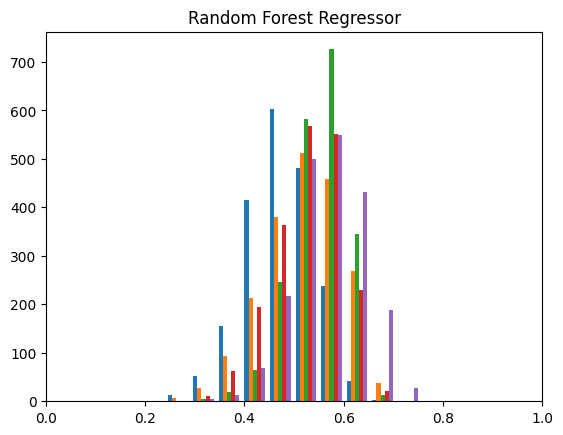

In [144]:
plt.hist(rf_prediction)
plt.title('Random Forest Regressor')
plt.xlim(0, 1)
plt.show()

In [137]:
lr_regressor.fit(test_features, test_target)
lr_prediction = lr_regressor.predict(valid_features)

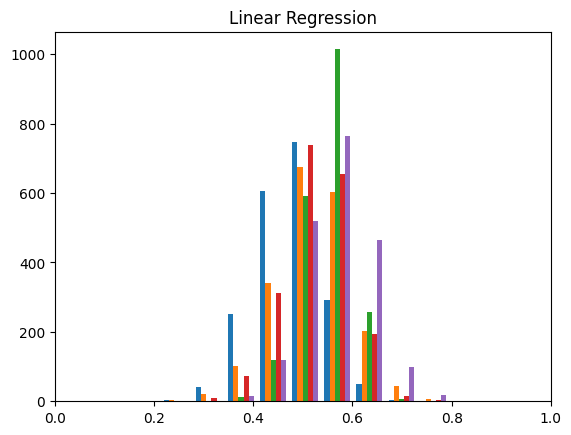

In [145]:
plt.hist(lr_prediction)
plt.title('Linear Regression')
plt.xlim(0, 1)
plt.show()

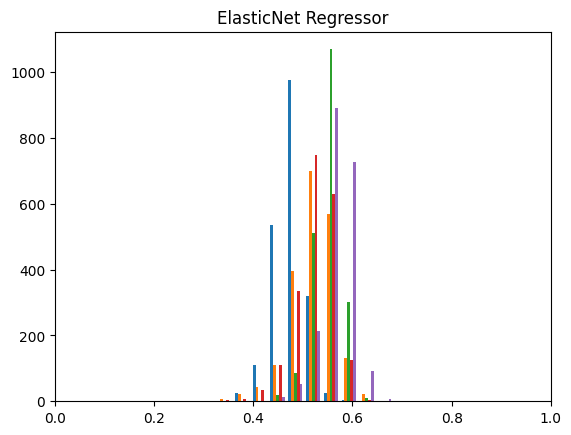

In [146]:
en_regressor.fit(test_features, test_target)
en_prediction = en_regressor.predict(valid_features)
plt.hist(en_prediction)
plt.title('ElasticNet Regressor')
plt.xlim(0, 1)
plt.show()

По гистограммам видно, что лучше выбрать Случайный лес. К тому же с ним, чуть проще бороться с переобучением

In [143]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 150, 300],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 3, 4],
    'max_features': ['log2', 'sqrt'],
    'min_impurity_decrease': [0, 0.001, 0.01]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, verbose=2)
grid_search.fit(test_features, test_target)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=150; total time=   0.8s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_samples_leaf=1, n_estimators=150; total time=   0.8s
[CV] END max_depth=5, max_features=log2, min_impurity_decrease=0, min_sample

In [147]:
print(best_params, best_score)

{'max_depth': None, 'max_features': 'log2', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'n_estimators': 300} 0.22813204527292577


In [149]:
rf_regressor = RandomForestRegressor(max_depth=None, max_features='log2',
                                     min_impurity_decrease=0, min_samples_leaf=1,
                                     n_estimators=300)
rf_regressor.fit(test_features, test_target)
en_prediction = en_regressor.predict(valid_features)

mse = np.mean((valid_target - en_prediction) ** 2)
print(f'MSE: {mse}')

MSE: 0.01932699116460336


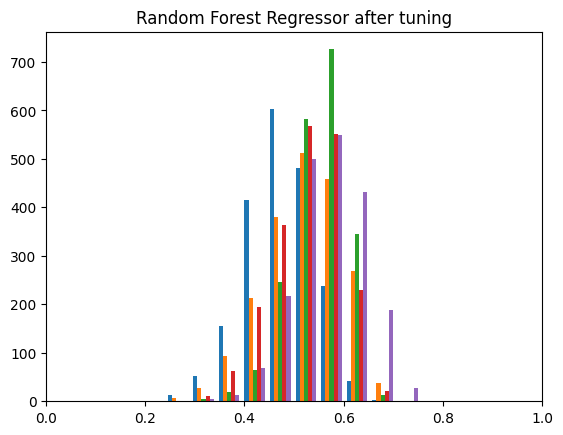

In [150]:
plt.hist(rf_prediction)
plt.title('Random Forest Regressor after tuning')
plt.xlim(0, 1)
plt.show()

In [153]:
# Сохраняем модель
joblib.dump(rf_regressor, 'random_forest_model.joblib')

['random_forest_model.joblib']

# Тестовая часть датасета

In [199]:
path_transcribe = 'test_set/transcription/transcription_test.pkl'
audio_path = 'test_set/audio/'

output_folder_photo = 'test_set/photo'
video_folder_path = 'test_set/test_data'

first_zip = 'test_set'

In [159]:
root_dir = first_zip
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        print(f)
        if "zip" in f:
            print(f)
            anzip(os.path.join(root, f), root+'/test')

readme.md
test_data.zip
test_data.zip
Архив test_set/test_data.zip извлечен в test_set/test
transcription_test.pkl


In [161]:
root_dir = video_folder_path
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        print(f)
        if "zip" in f:
            print(f)
            anzip(os.path.join(root, f), root)

test80_08.zip
test80_08.zip


RuntimeError: File <ZipInfo filename='test80_08.zip' filemode='----r-x---' external_attr=0x1 file_size=240075551 compress_size=240075563> is encrypted, password required for extraction

In [168]:
fall = []

root_dir = video_folder_path # Начальная точка обхода (текущая директория)
save_dir = audio_path
for root, dirs, files in os.walk(root_dir):
    # print(f"Current directory: {root}")
    # print("Directories:", dirs)
    # print("Files:", files)
    # print('-' * 30)
    for f in files:
        if ".mp4" in f:
            a = re.sub('.mp4','.wav', f)
            #print(f, a)
            #print(os.path.join(root, f), os.path.join(save_dir, a))
            try:
                clip_audio(os.path.join(root, f), os.path.join(save_dir, a))
            except:
                 fall.append(os.path.join(root, f))
                 print(os.path.join(save_dir, a))

MoviePy - Writing audio in test_set/audio/9z5cV1ANYwE.000.wav


MoviePy - Done.
test_set/audio/N4tuu9aCXkw.002.wav
test_set/audio/WosLI6krxUg.005.wav
MoviePy - Writing audio in test_set/audio/Bije9nsMl7M.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ODDGS0hTcUc.002.wav


MoviePy - Done.
test_set/audio/g24JGYuT74A.004.wav
MoviePy - Writing audio in test_set/audio/F9mZ6De_6Ko.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/m2uxFfpb5xU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BBSB9OJdb0Q.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/leslBYwG8kc.001.wav


MoviePy - Done.
test_set/audio/TD2jIXMD-SM.000.wav
MoviePy - Writing audio in test_set/audio/rqfvIjzegpI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cA3KzjBNr4M.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-10-QQDO_ME.005.wav


MoviePy - Done.
test_set/audio/oC-qxnrmJws.001.wav
MoviePy - Writing audio in test_set/audio/1mHjMNZZvFo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IV01x2GS61g.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Af_F0IzHK6o.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/CwmjP27fivQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/99OBSlFjLXI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A7qb47cmxJo.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Gvdh94z-SoM.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/B77ZCcCMrkM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nghDz0el8iI.002.wav


MoviePy - Done.
test_set/audio/OACoHiwOdXQ.001.wav
MoviePy - Writing audio in test_set/audio/ai-RZb0ZpKI.000.wav


MoviePy - Done.
test_set/audio/pslp6X3OWy0.000.wav
MoviePy - Writing audio in test_set/audio/yZk7Laj80z4.000.wav


MoviePy - Done.
test_set/audio/YryBLVZgJj0.002.wav
test_set/audio/P9WDAY-MFzk.004.wav
MoviePy - Writing audio in test_set/audio/JRqhE9jsamU.000.wav


MoviePy - Done.
test_set/audio/Psahy1Vju4A.004.wav
MoviePy - Writing audio in test_set/audio/TIRrlL71dEQ.001.wav


MoviePy - Done.
test_set/audio/me15sHPOjKo.004.wav
test_set/audio/scifP1EXSdo.005.wav
test_set/audio/OLFhKCgexRU.005.wav
MoviePy - Writing audio in test_set/audio/OZlpENU9h28.004.wav


MoviePy - Done.
test_set/audio/VJuVsi6G96s.004.wav
test_set/audio/XN5vpJU3ifw.002.wav
MoviePy - Writing audio in test_set/audio/8OckVmEZ8X8.000.wav


MoviePy - Done.
test_set/audio/qVrXROy4Ais.005.wav
MoviePy - Writing audio in test_set/audio/mQpNe8f5xA8.005.wav


MoviePy - Done.
test_set/audio/KmHe8urs3LI.004.wav
test_set/audio/NXG4n1pr4Ok.000.wav
test_set/audio/Q0C0OU-j4DA.000.wav
test_set/audio/hquzfo9MVDo.005.wav
test_set/audio/R2LlBNLDOeg.000.wav
MoviePy - Writing audio in test_set/audio/SPD5fXHVyIk.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/n5Jeeqfj2_U.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AotbiNsU85A.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RgZTZIf8K8g.004.wav


MoviePy - Done.
test_set/audio/Pr-RpZ4gYCM.003.wav
MoviePy - Writing audio in test_set/audio/aQVGVhcMBtE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6NjuNY4LfQc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qtB-CogljAo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3wgZrRMosvY.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b6eoqD1J_qU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/53QFyec0uN0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2AYq7CdNXNo.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5Ku4_r_Yxsk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/TD2jIXMD-SM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j7VLzb0qw8Q.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3df_Uk9EmwU.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/g0PWBzU95sI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/VNK6LQHh25w.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1DCnIad1Y0w.001.wav


MoviePy - Done.
test_set/audio/WpEZOSrENL0.001.wav
MoviePy - Writing audio in test_set/audio/SPMDX6qt4I4.000.wav


MoviePy - Done.
test_set/audio/TyE0bVJZZto.003.wav
MoviePy - Writing audio in test_set/audio/-DOqN0d8KHw.005.wav


MoviePy - Done.
test_set/audio/YiX6thczM1w.000.wav


MoviePy - Writing audio in test_set/audio/NF8nb3SQPNg.004.wav


MoviePy - Done.
test_set/audio/sqnW6xXYTKg.004.wav
MoviePy - Writing audio in test_set/audio/mMNjlGNWsZA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j6d-KRDXnUI.004.wav


MoviePy - Done.
test_set/audio/yIM5bal1VVs.002.wav
test_set/audio/RbX4q4KceVk.001.wav
MoviePy - Writing audio in test_set/audio/LWO2ZhalAEY.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1uC-2TZqplE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/heE4ZZXwehI.003.wav


MoviePy - Done.
test_set/audio/OdwK_oMdfSU.004.wav
MoviePy - Writing audio in test_set/audio/5xA5iKk4v6w.000.wav


MoviePy - Done.
test_set/audio/WwmWN63mkT4.005.wav
test_set/audio/GO6s-qDADuU.001.wav
MoviePy - Writing audio in test_set/audio/bEXDNfLBy1I.001.wav


MoviePy - Done.
test_set/audio/FxVUG2R1y0Q.002.wav
MoviePy - Writing audio in test_set/audio/fwJykIyvS04.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8g5jPiQ6XdA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dRP8ZaAryro.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ySEeioc339E.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J8N2OCqM6N0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2bAsXLQjlt8.003.wav


MoviePy - Done.
test_set/audio/PgpMUHH8lEI.001.wav
test_set/audio/-Wqk9eex6bQ.000.wav
test_set/audio/W0Ay5uul8j0.000.wav
MoviePy - Writing audio in test_set/audio/MZkDsB04kt8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/As93GgkTdt4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/MlBwEhjftAw.004.wav


MoviePy - Done.
test_set/audio/ssexxLJLuhU.002.wav
test_set/audio/s-jZlMKQGwc.001.wav
MoviePy - Writing audio in test_set/audio/qLV1a_611kA.003.wav


MoviePy - Done.
test_set/audio/l3IoZ_QmOQo.003.wav


MoviePy - Writing audio in test_set/audio/FSBBbxNi0iU.000.wav


MoviePy - Done.
test_set/audio/mpk5Ubw2fj8.002.wav
MoviePy - Writing audio in test_set/audio/mBdVuEXRlfQ.005.wav


MoviePy - Done.
test_set/audio/LSqijVxP0EM.003.wav
MoviePy - Writing audio in test_set/audio/nQtiqrceBhg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bN2IM-rqZlc.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Fe9_SVPd_5I.001.wav


MoviePy - Done.
test_set/audio/vQEZ5KF9I4E.000.wav
test_set/audio/S1AEj1kO5dc.003.wav
MoviePy - Writing audio in test_set/audio/CO7vZjYF6Zk.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/isqmQc9AfBc.002.wav


MoviePy - Done.
test_set/audio/W0LRjSS9pVM.002.wav
MoviePy - Writing audio in test_set/audio/jwbHWwySJW8.005.wav


MoviePy - Done.
test_set/audio/WpEZOSrENL0.005.wav
MoviePy - Writing audio in test_set/audio/-8asrRvfJWA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/V1I40vVRk78.000.wav


MoviePy - Done.
test_set/audio/knK0zyX8bS4.001.wav
test_set/audio/knpgk7LAMb0.004.wav
test_set/audio/m0iznoJi8hw.000.wav
MoviePy - Writing audio in test_set/audio/el2DOd8E5io.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kY_4WyAXxrQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5z4G0biL9B4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kSk-rf7a1Ig.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/OXkDmd3nA94.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FNHMXPaHll0.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/SIpQm4G4DDg.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/pvvff396Rqg.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/uTluOTPA7e4.005.wav


MoviePy - Done.
test_set/audio/knpgk7LAMb0.003.wav
MoviePy - Writing audio in test_set/audio/PHUlL5ZzX5U.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1yIGI42lzak.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LP5N5uPfTdA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C_NtwmmF2Ys.001.wav


MoviePy - Done.
test_set/audio/u_qvbRpm88k.004.wav
MoviePy - Writing audio in test_set/audio/rIRBEkDhn6Q.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6zm71IHOCZA.003.wav


MoviePy - Done.
test_set/audio/Qz_cjgCtDcM.002.wav
test_set/audio/r9TaaVTo8Y8.005.wav
MoviePy - Writing audio in test_set/audio/836kYlEs9GI.005.wav


MoviePy - Done.
test_set/audio/wyq_eWJClSY.005.wav
test_set/audio/V7_h3URfSFY.004.wav
MoviePy - Writing audio in test_set/audio/2Z8Xi_DTlpI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZqbJIM7rmO8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/niWi1hcuSmo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/hhdoeK8SsiI.004.wav


MoviePy - Done.
test_set/audio/MI_GQLbnoew.002.wav
MoviePy - Writing audio in test_set/audio/P2T93mqAsWk.000.wav


MoviePy - Done.
test_set/audio/SkNO4x-LSgE.001.wav
test_set/audio/Y9wnqLKhNNI.000.wav
MoviePy - Writing audio in test_set/audio/ItkIHtgVhIk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DzqJmiQjsZ4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-10-QQDO_ME.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Y9WX7ucPP-o.004.wav


MoviePy - Done.
test_set/audio/WATt9OOVZh8.000.wav
test_set/audio/nEm44UpCKmA.004.wav
test_set/audio/VvVigAr4hZc.000.wav
MoviePy - Writing audio in test_set/audio/9-lptN92A68.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/2kqPuht5jTg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/usG6pVxbQkw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/B4ducm9sydg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8hGOOynn3ZU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2d6btbaNdfo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/29UCGJldICw.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZNymNgd5EuQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/53QFyec0uN0.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ApPnsnIZozw.003.wav


MoviePy - Done.
test_set/audio/R-vly7LKotQ.002.wav
test_set/audio/jlDYn537Pd0.005.wav
test_set/audio/-rxiLMvlZqM.002.wav
MoviePy - Writing audio in test_set/audio/Ie2y_yOeKpo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/wVpjBxCirAQ.003.wav


MoviePy - Done.
test_set/audio/vqLtOsoNPnU.000.wav
MoviePy - Writing audio in test_set/audio/xtDw9TlWiww.003.wav


MoviePy - Done.
test_set/audio/H6yu96w7tUc.004.wav
MoviePy - Writing audio in test_set/audio/bkzgccBFztM.005.wav


MoviePy - Done.
test_set/audio/vr5FWHUkYRM.002.wav
test_set/audio/M5_x5J-H2I0.002.wav
MoviePy - Writing audio in test_set/audio/0MB91ku0eEw.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9cj8rrj1wSk.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fiVORaERbP0.000.wav


MoviePy - Done.
test_set/audio/ya8Ec_yTai8.000.wav
MoviePy - Writing audio in test_set/audio/I5x9T9ftW18.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/69EsTnCVCp0.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/-awAu11kBZ0.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DnTtbAR_Qyw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/iQvoDdxt06M.002.wav


MoviePy - Done.
test_set/audio/KnbEca4Ibwk.004.wav
MoviePy - Writing audio in test_set/audio/3CyIOM2izmI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8Bt-vEroq6M.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3gmc2kLV4Bo.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZT7cEiaYGp8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2c42A4Z7qPE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/M20gRMBy-4I.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fBMKlYUjA9E.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/yRVvI1x2DBI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_kK9tGN883Y.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-4J4xkfN5cI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/W4tz3plvvKI.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9lA-PGQcHBc.001.wav


MoviePy - Done.
test_set/audio/KNx7_ajRwDI.005.wav
MoviePy - Writing audio in test_set/audio/3zAyM2edy1g.002.wav


MoviePy - Done.
test_set/audio/syTTeox8Yaw.000.wav
MoviePy - Writing audio in test_set/audio/d69zeSpdyCI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0MB91ku0eEw.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/Q4z4GRUtccE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/s-jZlMKQGwc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c672aEuUa-g.000.wav


MoviePy - Done.
test_set/audio/W0Ay5uul8j0.003.wav
test_set/audio/opqoflph5ZE.002.wav
test_set/audio/M_OpMKBEOyU.005.wav
test_set/audio/ySEeioc339E.000.wav
test_set/audio/r4BGKIXrD9c.004.wav
MoviePy - Writing audio in test_set/audio/p9tAC-RqZPI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7FXs86Z98E0.003.wav


MoviePy - Done.
test_set/audio/xq0-QVHxp-Q.003.wav
MoviePy - Writing audio in test_set/audio/bnM9Ow52x3o.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ihEFzP5S57g.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FU1ak530DDo.002.wav


MoviePy - Done.
test_set/audio/vzttwG7SKZ8.001.wav
test_set/audio/p-V78q8dtYo.004.wav
MoviePy - Writing audio in test_set/audio/kX-o1qmgWvc.003.wav


MoviePy - Done.
test_set/audio/n1nVCG0zqOI.001.wav
MoviePy - Writing audio in test_set/audio/XOioICna1hc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dB2XYhvqUBU.002.wav


MoviePy - Done.
test_set/audio/xmaC2XOhPaE.002.wav
MoviePy - Writing audio in test_set/audio/GaUs3UUUtmw.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ch2BcBv4SdQ.003.wav


MoviePy - Done.
test_set/audio/-m5QCnnp-vI.000.wav
MoviePy - Writing audio in test_set/audio/4vJ69g7gAH4.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BuKzIqR4eBU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ax8wm9K41og.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/OtGJDbI9qkM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IveGfOJ86wY.003.wav


MoviePy - Done.
test_set/audio/MsGTYOOp4hE.000.wav
MoviePy - Writing audio in test_set/audio/FaBTYkzhuK4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/S-e9-bW4seo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9a-3LrB7cDI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6M8OQNo64Tc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/HJkoeB_F4c4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5bi_PM3XMEQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9n8dNi-ERQ0.002.wav


MoviePy - Done.
test_set/audio/SfldZBPyPFo.004.wav
test_set/audio/N0UweTwwQqQ.005.wav
MoviePy - Writing audio in test_set/audio/6waL_gUxtAM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QipgesEKSNA.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Cv_QK9bPagQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BLc_GvsbI1U.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ev42vngXERU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b-qfeGqPd04.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1hpZ2ecWqtI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fSkQXqXR7D0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/lyZZSU1ziCQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-RqxrwIxMvE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QKcx5msA7iA.005.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/86upzmhvpXw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/L-rmZZP_wj8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ApPnsnIZozw.000.wav


MoviePy - Done.
test_set/audio/REAxeTWo1QM.004.wav
MoviePy - Writing audio in test_set/audio/0uCqd5hZcyI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/voB6O-ky9cA.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/F5kL7RWS_f0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Bmn4YEhgBDY.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/WpEZOSrENL0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BWAEpai6FK0.004.wav


MoviePy - Done.
test_set/audio/mpk5Ubw2fj8.003.wav
MoviePy - Writing audio in test_set/audio/ogSLrHVeqLI.002.wav


MoviePy - Done.
test_set/audio/mFz5Fbs97QA.005.wav
test_set/audio/nvlqJbHk_Lc.001.wav
MoviePy - Writing audio in test_set/audio/7tB2Rtm4XeU.003.wav


MoviePy - Done.
test_set/audio/k99PI3FGEj0.001.wav
MoviePy - Writing audio in test_set/audio/w_ExyXsnw2A.005.wav


MoviePy - Done.
test_set/audio/kJLeYUobR0M.003.wav
MoviePy - Writing audio in test_set/audio/A1lbD_OCuj4.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C5qRszPK9HY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5xA8-Y5qgT0.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fUf2XzWpSVo.002.wav


MoviePy - Done.
test_set/audio/PWM-bKcs2p8.005.wav
test_set/audio/UMMhvyjgRnM.002.wav
MoviePy - Writing audio in test_set/audio/7Y4cUPFEt-4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/uT-y9m7_-E0.000.wav


MoviePy - Done.
test_set/audio/Y1LXjxAQihQ.000.wav
test_set/audio/mwjoabuP-GM.002.wav


MoviePy - Writing audio in test_set/audio/gWCgqVn3m3k.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IQNNEfYYYiw.001.wav


MoviePy - Done.
test_set/audio/sHVXhr7_EOs.005.wav
MoviePy - Writing audio in test_set/audio/T1--98_78ns.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/L9sG80PI1Gw.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/X-GXO_urMow.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AT9kY7tP710.000.wav


MoviePy - Done.
test_set/audio/-Gl98Jn45Fs.004.wav
MoviePy - Writing audio in test_set/audio/9-lptN92A68.003.wav


MoviePy - Done.
test_set/audio/ikCqtEGQbrg.002.wav
test_set/audio/KIJ9IYETe38.004.wav
test_set/audio/hrat_RJczFM.005.wav
test_set/audio/jlDYn537Pd0.003.wav
MoviePy - Writing audio in test_set/audio/1q-N_zbsAg0.005.wav


MoviePy - Done.
test_set/audio/VvSk5m90xOs.001.wav
test_set/audio/p-V78q8dtYo.000.wav
MoviePy - Writing audio in test_set/audio/_plk5k7PBEg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7PYAn9njCHI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3wRj39GKLJ0.000.wav


MoviePy - Done.
test_set/audio/VTrqCDYHVqU.005.wav
MoviePy - Writing audio in test_set/audio/85isLsZHZpo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6RwVJK3husE.003.wav


MoviePy - Done.
test_set/audio/KYkfjIZEScM.002.wav
MoviePy - Writing audio in test_set/audio/g9zgIN56MnQ.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/pT8nyxks1Q4.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5kwoq4EZixQ.000.wav


MoviePy - Done.
test_set/audio/SR1Q5M2urxY.001.wav
MoviePy - Writing audio in test_set/audio/DZfcVxy2ceI.004.wav


MoviePy - Done.
test_set/audio/ixPqs7L8oAE.001.wav
MoviePy - Writing audio in test_set/audio/DrlC4bEYcmw.003.wav


MoviePy - Done.
test_set/audio/SPpox8EGQqU.004.wav
test_set/audio/QXFRE_pjrAE.002.wav


MoviePy - Writing audio in test_set/audio/GqFpXstFUZI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A1lbD_OCuj4.004.wav


MoviePy - Done.
test_set/audio/oe1PZxExhzc.005.wav
test_set/audio/oontew1LiUU.002.wav
test_set/audio/keW8-eSiQ70.000.wav
test_set/audio/PxkMDzORBPE.002.wav
MoviePy - Writing audio in test_set/audio/isaP2l3rlBQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/UWVOT3YPQH4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/hIxLNK_x_QA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Z_STuUHKQTg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RlUuWWWFrhM.002.wav


MoviePy - Done.
test_set/audio/p5QXPhJS8Ks.002.wav
MoviePy - Writing audio in test_set/audio/UUQQf9N2ce0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RYG6XhdmPY0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ej0RpdM9kJA.005.wav


MoviePy - Done.
test_set/audio/Ft0ahViXZPc.004.wav
MoviePy - Writing audio in test_set/audio/CdUYBux3Vn8.001.wav


MoviePy - Done.
test_set/audio/pKm9lxa4cmg.000.wav
MoviePy - Writing audio in test_set/audio/w7O2QJu2Wl4.003.wav


MoviePy - Done.
test_set/audio/Y9WX7ucPP-o.005.wav
test_set/audio/RWfY3Xk0XPQ.004.wav
MoviePy - Writing audio in test_set/audio/7MwZm3mhSA8.003.wav


MoviePy - Done.
test_set/audio/ld7mBR4v3yU.004.wav
MoviePy - Writing audio in test_set/audio/dy9EqbKLDP0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bj9kSmBeQRg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aqd4_4ga1fQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/E_xAcdGpPCI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9DF_-PXbpkg.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/IQNNEfYYYiw.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/l-WgXcGLdZk.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c672aEuUa-g.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qFYgMFMal_s.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6SoFnys6mf0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C9W-AEBcQzo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/L5kpy0SA7os.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/hspeWl-Bip0.001.wav


MoviePy - Done.
test_set/audio/MuYYY3XaJ7Q.001.wav
MoviePy - Writing audio in test_set/audio/WfZodMIIGR0.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/in-HuMgiDCE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/zeUC7e-4w1E.001.wav


MoviePy - Done.
test_set/audio/LBKbubsgpE8.002.wav
test_set/audio/uDm7iZuX5DQ.004.wav
MoviePy - Writing audio in test_set/audio/cgT-3CHBmKs.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZqbJIM7rmO8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/s6N1pv5lzrU.001.wav


MoviePy - Done.
test_set/audio/nQtiqrceBhg.000.wav
MoviePy - Writing audio in test_set/audio/6RwVJK3husE.001.wav


MoviePy - Done.
test_set/audio/puLXzqUvm_U.005.wav
MoviePy - Writing audio in test_set/audio/HL-K_PZXFR4.003.wav


MoviePy - Done.
test_set/audio/oe1PZxExhzc.002.wav
test_set/audio/vCV-5LypZCs.000.wav
MoviePy - Writing audio in test_set/audio/2AV8m02PjdU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nGe8dIc-ecc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_mvqVnzddCw.005.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/T1_6sVNHG70.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fiEEjrKhlNU.003.wav


MoviePy - Done.
test_set/audio/PReOtefm17s.000.wav
test_set/audio/mlXZQ8dO0nQ.000.wav
test_set/audio/hnWMsZEQWt4.005.wav
MoviePy - Writing audio in test_set/audio/bZAKBS9q0ZI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8aPfoJiDeBY.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GR-P1m_Yvm0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/k4QmzZuQl9s.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cT3oyHhUznw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ibawV2tqKug.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/f4rQJiW6oSk.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xcMwMi4fdis.003.wav


MoviePy - Done.
test_set/audio/Jn76eAPxjNA.001.wav
test_set/audio/omeHsKF7InA.004.wav
test_set/audio/mfGhtr0zy3k.003.wav
MoviePy - Writing audio in test_set/audio/U9cidDFDTQE.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DctPau1p7JM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Hklc55y7vUI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/orlXEgAepGo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qRtKUGgULL8.003.wav


MoviePy - Done.
test_set/audio/H6yu96w7tUc.003.wav
MoviePy - Writing audio in test_set/audio/9NS6CgxJCGM.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cMLkNVKkaOQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nYCuMoC5ibQ.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/26CMYJn3u6Y.000.wav


MoviePy - Done.
test_set/audio/VbiUhNAdzus.005.wav
MoviePy - Writing audio in test_set/audio/ujC_Fik6sBE.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7knYNR1tAig.003.wav


MoviePy - Done.
test_set/audio/SGnhyxlbqaE.000.wav
test_set/audio/oC-qxnrmJws.004.wav
MoviePy - Writing audio in test_set/audio/gOS-CneQsxI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QTtTAFqT-no.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/X-i_eQ48DBw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/De4i7-FX9Og.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RQeoo3idUJc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/12Ezy1y1cWY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DvWzedL3QCk.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/B8kzwm6ZaUo.003.wav


MoviePy - Done.
test_set/audio/x0mD5kr2hu4.003.wav
MoviePy - Writing audio in test_set/audio/XFpzukISe6s.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fyXiORXmWHs.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/jSw-grsJCnE.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YucC--PknOo.000.wav


MoviePy - Done.
test_set/audio/mKWscEow1U8.003.wav
test_set/audio/mZQP06F94u8.000.wav
MoviePy - Writing audio in test_set/audio/TEGJrmNFvXY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J8YpOUmN_aI.004.wav


MoviePy - Done.
test_set/audio/Psahy1Vju4A.001.wav
MoviePy - Writing audio in test_set/audio/CFK8ib0aWe8.002.wav


MoviePy - Done.
test_set/audio/NG8qWulkRM4.004.wav


MoviePy - Writing audio in test_set/audio/3LAaFUSGvsU.005.wav


MoviePy - Done.
test_set/audio/UipoC_HLOP0.002.wav
MoviePy - Writing audio in test_set/audio/eq1_h17oue4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/43tayteIFRk.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Z9GzSxQHKSI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2d6btbaNdfo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/S1AEj1kO5dc.000.wav


MoviePy - Done.
test_set/audio/hX2TVefa5bQ.003.wav
MoviePy - Writing audio in test_set/audio/sDNzrM6N7wA.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cMLkNVKkaOQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/r93dLeVRk3U.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j6d-KRDXnUI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C_NtwmmF2Ys.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/U_QQ8EuuWPg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/encC96iqr9Y.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2HE6cw3HFPk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PpJ4S8ZM8mQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7BgScfRre5M.000.wav


MoviePy - Done.
test_set/audio/hX2TVefa5bQ.004.wav
MoviePy - Writing audio in test_set/audio/t1PKNXE-IiM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7u0o63Z7q9E.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/z0v9LukQRHU.003.wav


MoviePy - Done.
test_set/audio/JJxLsbLQlIE.002.wav
test_set/audio/nZz1hK90gwA.005.wav
MoviePy - Writing audio in test_set/audio/QMRAbwZCTfI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/43tayteIFRk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bPTYw89PzLM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FlAGm93fJa0.003.wav


MoviePy - Done.
test_set/audio/vIW7gDmhYMk.000.wav
test_set/audio/pZxqWp0e-Ik.001.wav
MoviePy - Writing audio in test_set/audio/nghDz0el8iI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2f7rLXwzP3s.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RhFPotjd0hM.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/Cdh_OCMZ4U8.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/J28DwJsK8Do.001.wav


MoviePy - Done.
test_set/audio/PtBXYDPakZo.001.wav
MoviePy - Writing audio in test_set/audio/Wj8ZY5d1lbs.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IQNNEfYYYiw.004.wav


MoviePy - Done.
test_set/audio/phjVMKGYBKs.002.wav
MoviePy - Writing audio in test_set/audio/0SS47KwVOQ4.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/87r3cLkrw4A.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/eAkWSjU-JyY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9cxghgS9upg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3JAFkk42zPs.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0kg6pmbSN6A.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/0G2o3fik36I.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/T1tJTwlGqOM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0MB91ku0eEw.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3taD1fEPfC8.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cZ6xhB5yhfY.000.wav


MoviePy - Done.
test_set/audio/K9h_wA30XgM.004.wav
MoviePy - Writing audio in test_set/audio/bcx6xr9Ja-8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LKc69Et2Jg8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c70zW-HoZUA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vQEZ5KF9I4E.001.wav


MoviePy - Done.
test_set/audio/lFzrVSbp254.001.wav
MoviePy - Writing audio in test_set/audio/BgfYyUAoNPs.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cjbh1lfr43c.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3JAFkk42zPs.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/KRo-x2uoHUg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cY3nHc5fDYE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BLKXsX7-WIg.002.wav


MoviePy - Done.
test_set/audio/XfK7WZ3skUM.004.wav
MoviePy - Writing audio in test_set/audio/yyqXzlF8Fgc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J9MfhPoJOaw.000.wav


MoviePy - Done.
test_set/audio/IGjI8aP14gg.000.wav
MoviePy - Writing audio in test_set/audio/LKc69Et2Jg8.003.wav


MoviePy - Done.
test_set/audio/jrhvXPaXo-0.003.wav
test_set/audio/VForU0EmBr0.004.wav
test_set/audio/KYvMsMLNGvY.002.wav


MoviePy - Writing audio in test_set/audio/voB6O-ky9cA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AlEqtGWa43g.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LGdzP-r_G3U.000.wav


MoviePy - Done.
test_set/audio/KueRj0rDWIE.004.wav
MoviePy - Writing audio in test_set/audio/bGLwxQ1lonQ.000.wav


MoviePy - Done.
test_set/audio/mEQBB6XsJFk.003.wav
test_set/audio/YLKPVl-M3Ck.002.wav
test_set/audio/REAxeTWo1QM.001.wav
test_set/audio/KLY518hfGhU.002.wav
MoviePy - Writing audio in test_set/audio/ZMOcuCj-86c.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ai-RZb0ZpKI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J6RHl6U6Jcw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FPfgwGsy8dE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6WSr4IW6cNI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fsaslN7xV-w.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qP8YzH6LT9c.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xun35caJTQI.004.wav


MoviePy - Done.
test_set/audio/IFF47jVKMj8.005.wav
MoviePy - Writing audio in test_set/audio/AT9kY7tP710.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Pr-RpZ4gYCM.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9yZEb6bdxNY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ASDpn9yOYAo.004.wav


MoviePy - Done.
test_set/audio/Ry5JJvTfP-8.000.wav
MoviePy - Writing audio in test_set/audio/Z3E1jkaNRKs.002.wav


MoviePy - Done.
test_set/audio/Jh8yMyNZkuo.000.wav
MoviePy - Writing audio in test_set/audio/5BPGRteF64Y.003.wav


MoviePy - Done.
test_set/audio/gngqDNTAXnI.001.wav
test_set/audio/KNx7_ajRwDI.004.wav


MoviePy - Writing audio in test_set/audio/fGAcEyZXFTo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ask-ZFRztf8.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fG-hvGTHoec.003.wav


MoviePy - Done.
test_set/audio/kPife9TY9Pw.004.wav
MoviePy - Writing audio in test_set/audio/clMg72MI8rw.005.wav


MoviePy - Done.
test_set/audio/ndLtwmvPpr8.001.wav
MoviePy - Writing audio in test_set/audio/3ySH8eJQRCI.000.wav


MoviePy - Done.
test_set/audio/u_OwN18tbCI.001.wav
MoviePy - Writing audio in test_set/audio/IyBCZySg-c4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/TJD__22fOr0.002.wav


MoviePy - Done.
test_set/audio/T1_6sVNHG70.002.wav
test_set/audio/x0mD5kr2hu4.005.wav
MoviePy - Writing audio in test_set/audio/ly_0m16694Q.001.wav


MoviePy - Done.
test_set/audio/-NwfYYf5xLo.002.wav
MoviePy - Writing audio in test_set/audio/aJjAtOC8AQU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DcVwxxbKGF4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/P0a209IS614.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2TbU3Eg2i4A.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DcVwxxbKGF4.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Q9B3SJkH2Q8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/pru5ut4lxkQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/L_gmlaz-0s4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/U-XrzfFzMkg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/26ZnknvfdNM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7Kn5VT9bB4I.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/NVvKBE5FTMk.003.wav


MoviePy - Done.
test_set/audio/WGP2HLnoma0.000.wav
MoviePy - Writing audio in test_set/audio/Cng72emlXAM.002.wav


MoviePy - Done.
test_set/audio/YocrYFLm4CM.004.wav
test_set/audio/hmcLIjG-hS8.000.wav
test_set/audio/fmjILOLc3eg.004.wav
MoviePy - Writing audio in test_set/audio/nCWEEoJfjgE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/TkCDs7NlXyU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZkypeQdzgvQ.001.wav


MoviePy - Done.
test_set/audio/JJs_HTelie4.000.wav
MoviePy - Writing audio in test_set/audio/NYlFsljF0VM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kdPRPO3wgg0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YygvfVxOWP8.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2fzLibPAtvI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bLOSPQ8MAC8.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9ZMIYSBYIh8.005.wav


MoviePy - Done.
test_set/audio/oq_v2yocx34.000.wav
MoviePy - Writing audio in test_set/audio/3g6Ab-BIbR4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/84Lz5a9yRZg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/wBSf7anTC_g.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Sdqg-jn_tBk.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0MB91ku0eEw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xgwiqo2AsCA.003.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/N7oR6_oMBFk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2GHz8LYflE0.001.wav


MoviePy - Done.
test_set/audio/ouYYWCY__5A.003.wav
MoviePy - Writing audio in test_set/audio/urCVAp964Tc.004.wav


MoviePy - Done.
test_set/audio/xRhUBifOWiI.005.wav
MoviePy - Writing audio in test_set/audio/9CPKW0sqR3E.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3Vr5-zedeWk.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9NS6CgxJCGM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qBpv0BfiGQk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4JjpfL4y3XM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fv5lLeyRdd4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GkPz3-y6Les.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/R6NTuhZtOks.004.wav


MoviePy - Done.
test_set/audio/w2FKw8IhbFw.004.wav
MoviePy - Writing audio in test_set/audio/Cl5jhuLQ9Dg.000.wav


MoviePy - Done.
test_set/audio/WkbvQZU475o.002.wav
test_set/audio/G-25EWOIGNs.003.wav
MoviePy - Writing audio in test_set/audio/vE9XgQL7DGE.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/utv9RBNcL5w.003.wav


MoviePy - Done.
test_set/audio/SwXvcwQcqgk.001.wav
MoviePy - Writing audio in test_set/audio/0G2o3fik36I.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4OKYywIqnqg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8yFYvQ_kxW8.004.wav


MoviePy - Done.
test_set/audio/HhC2cGFFZeY.003.wav
MoviePy - Writing audio in test_set/audio/41NNb7cucVo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aaylz9A9K80.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/ai-RZb0ZpKI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aaylz9A9K80.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cjbh1lfr43c.004.wav


MoviePy - Done.
test_set/audio/oG84VxrGfj0.005.wav
MoviePy - Writing audio in test_set/audio/Agg7z10B_iY.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3J7Cl3FXs1o.005.wav


MoviePy - Done.
test_set/audio/OmXuhT4yJpo.004.wav
MoviePy - Writing audio in test_set/audio/8ZHpqRJ39HA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nfEhF5GBQpo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BmDClgdWlH4.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/d8skGb2ycio.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GJ0uTtD3kSg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/NhyVkwcZbTA.001.wav


MoviePy - Done.
test_set/audio/UANQntvIqVk.005.wav
MoviePy - Writing audio in test_set/audio/a97PXgrKSxo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Ay7bZ7Sgx9Q.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/E_xAcdGpPCI.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vLAHfIjmRMc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/NZXtEENlWL4.002.wav


MoviePy - Done.
test_set/audio/PsqpkFKX8co.003.wav
MoviePy - Writing audio in test_set/audio/m2uxFfpb5xU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/auhe41Tf50M.005.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/3b9fhd-EDaY.000.wav


MoviePy - Done.
test_set/audio/oe1PZxExhzc.004.wav
MoviePy - Writing audio in test_set/audio/RmEwRYfDn-4.000.wav


MoviePy - Done.
test_set/audio/Pmhjv20yOl4.003.wav
MoviePy - Writing audio in test_set/audio/AEqpMdMeMZA.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/L5PkZA1ErYY.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Dhbva5oGE7g.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/OuE91U_n04E.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/struoSVUsUg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/gZzB49daFfA.001.wav


MoviePy - Done.
test_set/audio/K9ZTOb6PbfQ.001.wav
test_set/audio/ly_0m16694Q.002.wav
MoviePy - Writing audio in test_set/audio/7knYNR1tAig.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/78zauTEQ-k8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FcR9VhCxBb0.005.wav


MoviePy - Done.
test_set/audio/gAWA-fcIa_M.000.wav
MoviePy - Writing audio in test_set/audio/dvMeqVbpKW8.003.wav


MoviePy - Done.
test_set/audio/U3UaF1aFek4.003.wav
MoviePy - Writing audio in test_set/audio/Rops7WYMCCY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xmaC2XOhPaE.000.wav


MoviePy - Done.
test_set/audio/n8IiQJyqjiE.005.wav
MoviePy - Writing audio in test_set/audio/CGfr9jl8w4Y.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/hrat_RJczFM.003.wav


MoviePy - Done.
test_set/audio/P0ZzjnS8E24.005.wav
MoviePy - Writing audio in test_set/audio/KpTHRBaYny8.004.wav


MoviePy - Done.
test_set/audio/t30ERiF6b50.002.wav
MoviePy - Writing audio in test_set/audio/nex61B854Ms.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/vp9p1osOaLI.001.wav


MoviePy - Done.
test_set/audio/KafUbLs_Fl8.000.wav
MoviePy - Writing audio in test_set/audio/o2lu6rkd5-Y.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6EMgu2djYrU.000.wav


MoviePy - Done.
test_set/audio/opqoflph5ZE.005.wav
test_set/audio/UvX6ctu2ObM.003.wav
test_set/audio/l0qApUuiDjo.000.wav
MoviePy - Writing audio in test_set/audio/d8skGb2ycio.001.wav


MoviePy - Done.
test_set/audio/ihmTGSMvQM4.003.wav
MoviePy - Writing audio in test_set/audio/US4PxgfKDeA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IP_Smb0hVSw.004.wav


MoviePy - Done.
test_set/audio/L-C1blPD_ec.003.wav
MoviePy - Writing audio in test_set/audio/s0pgZM5G6ds.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZoHY-rWJsyw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8YQKwMdiaAE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Ea0UKBPCm3Q.003.wav


MoviePy - Done.
test_set/audio/Se3Gts4u1vs.002.wav
MoviePy - Writing audio in test_set/audio/iVtaXNWqFac.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Fco1CMgOadI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Gl93Hw1A2kY.000.wav


MoviePy - Done.
test_set/audio/P0ZzjnS8E24.002.wav
MoviePy - Writing audio in test_set/audio/0iQIfGnKflc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QBZieJiOl1w.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/KpTHRBaYny8.003.wav


MoviePy - Done.
test_set/audio/OMHlfDF99Mw.001.wav
test_set/audio/mK8ebTJyrCI.001.wav
test_set/audio/txU8yE9d-4k.000.wav
MoviePy - Writing audio in test_set/audio/jVSnAbEGKLM.000.wav


MoviePy - Done.
test_set/audio/VhHnmeRABJw.002.wav
MoviePy - Writing audio in test_set/audio/ZaihsIQZCx8.004.wav


MoviePy - Done.
test_set/audio/OSDlyk5ZgAk.001.wav


MoviePy - Writing audio in test_set/audio/DfpKVl9Zpdg.000.wav


MoviePy - Done.
test_set/audio/H6yu96w7tUc.001.wav
test_set/audio/UVMEzA3yHsM.004.wav
MoviePy - Writing audio in test_set/audio/c8idT3lRnQ8.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/heE4ZZXwehI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/tCnfvBwWVKw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/UEYKBC_SuzU.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3S72dDIm1fM.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RhFPotjd0hM.001.wav


MoviePy - Done.
test_set/audio/Vyktsh14Kww.002.wav
test_set/audio/LGPm8ok6kVo.000.wav
MoviePy - Writing audio in test_set/audio/W7BbL3NZvrU.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vCY4uvfrWXA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/a5NTqK367wo.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J9WyswA0vow.005.wav


MoviePy - Done.
test_set/audio/lsXw8u4QXIU.002.wav
test_set/audio/pT8nyxks1Q4.003.wav
MoviePy - Writing audio in test_set/audio/TK6hBCARiHI.003.wav


MoviePy - Done.
test_set/audio/jmbAPNTJ3Vk.004.wav
MoviePy - Writing audio in test_set/audio/ZhPQrqxo2mw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5Wmlo8Z5yVA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c7tczvW3_dQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/JzS1ZJGBd5A.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/thl4HwoqyrI.005.wav


MoviePy - Done.
test_set/audio/-N6QKrbnaDs.001.wav
MoviePy - Writing audio in test_set/audio/J4GQm9j0JZ0.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/fhUGU2uiS1U.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7knYNR1tAig.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5T2PhH-OMds.002.wav


MoviePy - Done.
test_set/audio/nR0h3WFbPfA.002.wav
MoviePy - Writing audio in test_set/audio/39o1zJFeM7E.000.wav


MoviePy - Done.
test_set/audio/kL-CeaXG9jM.005.wav
MoviePy - Writing audio in test_set/audio/VXcccqr-IAU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cgGCyBMdGrA.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DChmTb-c9uM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FTk2SCmJI_w.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C47tB5JmEqQ.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c3SQSM9OIsA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LeQKH1vAVpg.002.wav


MoviePy - Done.
test_set/audio/kY_4WyAXxrQ.002.wav
MoviePy - Writing audio in test_set/audio/e3Y7na4SBh4.001.wav


MoviePy - Done.
test_set/audio/OhHg1lyxe4I.003.wav
MoviePy - Writing audio in test_set/audio/xqGyF2T3pso.004.wav


MoviePy - Done.
test_set/audio/T9xSEBSaL7Q.000.wav
MoviePy - Writing audio in test_set/audio/_0bg1TLPP-I.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8i7H-uSCQcc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Bz3Jx4QL_6Q.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/300gK3CnzW0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8e4nnel_x-M.003.wav


MoviePy - Done.
test_set/audio/vJDx6TCX32M.005.wav


MoviePy - Writing audio in test_set/audio/ZGox7tevC6A.000.wav


MoviePy - Done.
test_set/audio/S4H50iotXF0.000.wav
MoviePy - Writing audio in test_set/audio/_mtiuHyOFXg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BLc_GvsbI1U.005.wav


MoviePy - Done.
test_set/audio/P0ZzjnS8E24.003.wav
MoviePy - Writing audio in test_set/audio/2TbU3Eg2i4A.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xEmwNv4OxGE.003.wav


MoviePy - Done.
test_set/audio/GG9WPQLI_rg.002.wav
test_set/audio/GcuoyJPO-KU.005.wav
MoviePy - Writing audio in test_set/audio/QS7TwjzkYiU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Z5S5uGXkNuc.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9z5cV1ANYwE.004.wav


MoviePy - Done.
test_set/audio/Nv0-x4K9YFI.003.wav
MoviePy - Writing audio in test_set/audio/38fE5B4ghw0.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/JZNMxa3OKHY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6JfSPPVUgIg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_TbRQa4InvM.001.wav


MoviePy - Done.
test_set/audio/RWhyKkFI3zw.003.wav
MoviePy - Writing audio in test_set/audio/xeE08Vn-HXI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/51z2rCqPqPE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4XdZDodpzac.004.wav


MoviePy - Done.
test_set/audio/p_kPnCD7WzU.004.wav
MoviePy - Writing audio in test_set/audio/cvg03XGFjCk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bEXDNfLBy1I.005.wav


MoviePy - Done.
test_set/audio/w4cZStXMUII.004.wav
test_set/audio/io0aNQE8En8.001.wav
MoviePy - Writing audio in test_set/audio/DhqfB9chceo.004.wav


MoviePy - Done.
test_set/audio/Gvdh94z-SoM.000.wav


MoviePy - Writing audio in test_set/audio/a5NTqK367wo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/oXRhk1PUPcQ.001.wav


MoviePy - Done.
test_set/audio/-PWjgx2czwY.001.wav
MoviePy - Writing audio in test_set/audio/jwcSbw4NDn0.001.wav


MoviePy - Done.
test_set/audio/p_wf-KszNlk.001.wav
test_set/audio/KH1PIMlztec.000.wav
MoviePy - Writing audio in test_set/audio/_bOOlidEWgY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7ZnijRlK5-E.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/oU7zAWm_01o.001.wav


MoviePy - Done.
test_set/audio/lShOveDL2dw.003.wav
test_set/audio/pzfDth6nFQE.001.wav
MoviePy - Writing audio in test_set/audio/uoLDJJMK5Gw.003.wav


MoviePy - Done.
test_set/audio/nmZRXxKPPuQ.004.wav
test_set/audio/n2BuwHbdilY.005.wav
MoviePy - Writing audio in test_set/audio/Qa-yF-tByDM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vZPLbzF0aSg.002.wav


MoviePy - Done.
test_set/audio/vNEs2yGe77s.001.wav
MoviePy - Writing audio in test_set/audio/NVvKBE5FTMk.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1-GgVRmAEoo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j1idNSoB7tA.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A29hMesGCEI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/simc6hmrUOE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Se3Gts4u1vs.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/f_mEEFFeh-0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aJjAtOC8AQU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/oontew1LiUU.000.wav


MoviePy - Done.
test_set/audio/X-i_eQ48DBw.003.wav
test_set/audio/ODDGS0hTcUc.003.wav


MoviePy - Writing audio in test_set/audio/XtI2ju2a8iM.002.wav


MoviePy - Done.
test_set/audio/tt-EaApaHx4.003.wav
MoviePy - Writing audio in test_set/audio/encC96iqr9Y.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_lQinJGE7Qs.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3hKgh9AB3tk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-10-QQDO_ME.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-fqiCqZtgYs.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/NXG4n1pr4Ok.003.wav


MoviePy - Done.
test_set/audio/wUkdpuWq_Q0.004.wav
MoviePy - Writing audio in test_set/audio/4RKQGZzPClk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dLltwqkvsNg.000.wav


MoviePy - Done.
test_set/audio/OD3cfWeJaOY.002.wav
MoviePy - Writing audio in test_set/audio/KNx7_ajRwDI.002.wav


MoviePy - Done.
test_set/audio/PWAe9M2SxT8.002.wav
MoviePy - Writing audio in test_set/audio/2TXrDZgbDHE.000.wav


MoviePy - Done.
test_set/audio/mkJjaOADfj4.000.wav
MoviePy - Writing audio in test_set/audio/PWM-bKcs2p8.002.wav


MoviePy - Done.
test_set/audio/tPVSlH_VmZk.000.wav
MoviePy - Writing audio in test_set/audio/nB-fPmvZg3U.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cx8IycWgMVs.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/53gtUkC7IZM.000.wav


MoviePy - Done.
test_set/audio/modNfUPt3F4.001.wav
test_set/audio/OoxYhDbzWwg.001.wav
MoviePy - Writing audio in test_set/audio/txU8yE9d-4k.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_7s27dUoYVg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Q8Hfg0odW2k.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/h6LOjpCRXtY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C-48U5oDuvw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/evrzg3Pzyc0.003.wav


MoviePy - Done.
test_set/audio/Yj36y7ELRZE.002.wav
MoviePy - Writing audio in test_set/audio/3zAyM2edy1g.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IP_Smb0hVSw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/VoPuhcQc_mg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/hl70w5drc_4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fBcc1UMtZME.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/6V807Mf_gHM.004.wav


MoviePy - Done.
test_set/audio/n8IiQJyqjiE.002.wav
test_set/audio/nLB29nx1Jp4.004.wav
MoviePy - Writing audio in test_set/audio/zyGz_H1UTnQ.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FGkS4vJYOpM.001.wav


MoviePy - Done.
test_set/audio/n877YOU6Qy0.000.wav
test_set/audio/nndDX4RgU1w.003.wav
MoviePy - Writing audio in test_set/audio/EYbPGTIcnjs.004.wav


MoviePy - Done.
test_set/audio/PsHb4YHooKM.000.wav
test_set/audio/Lj1WuMXFa-4.003.wav
test_set/audio/P7poMmhYnM0.002.wav
MoviePy - Writing audio in test_set/audio/wVpjBxCirAQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/19pTUX8KfYM.001.wav


MoviePy - Done.
test_set/audio/YGrCXe2-fVk.002.wav
MoviePy - Writing audio in test_set/audio/MkVsl0hdphE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/z54OqeICELg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1Kb5d-w3YJ8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/gkhbUDIK-YM.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/nvlqJbHk_Lc.005.wav


MoviePy - Done.
test_set/audio/Prb5j6jLKBs.005.wav
MoviePy - Writing audio in test_set/audio/Po4UGCJbCbw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DChmTb-c9uM.003.wav


MoviePy - Done.
test_set/audio/lsXw8u4QXIU.004.wav
test_set/audio/yIe7Rp54-bU.003.wav
MoviePy - Writing audio in test_set/audio/UtVo107m5lg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/tg0i-zxvQXk.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0u56Q_QmxIM.000.wav


MoviePy - Done.
test_set/audio/tt-EaApaHx4.005.wav
MoviePy - Writing audio in test_set/audio/5QUDu-PC7N4.000.wav


MoviePy - Done.
test_set/audio/nOFHZ_s7Et4.000.wav
MoviePy - Writing audio in test_set/audio/fyXiORXmWHs.005.wav


MoviePy - Done.
test_set/audio/w0CQ55sKmck.000.wav
MoviePy - Writing audio in test_set/audio/-N6QKrbnaDs.000.wav


MoviePy - Done.
test_set/audio/WnmPDmb00Mc.001.wav
MoviePy - Writing audio in test_set/audio/hIFNZ_ycngg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AWe6ZZUmlZw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QBZieJiOl1w.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/zNmuwZkaeVg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/wK_ExIjn5Q8.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C23rns4ZCy8.002.wav


MoviePy - Done.
test_set/audio/V4ibYU1O-YI.003.wav
test_set/audio/g1TMjzZH8bw.003.wav
test_set/audio/-lSBwF052u0.005.wav
MoviePy - Writing audio in test_set/audio/R0RURVpmU9M.001.wav


MoviePy - Done.
test_set/audio/pOtWKOF07iU.005.wav
MoviePy - Writing audio in test_set/audio/A7exx3pEPkE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/lLObIVKYDUI.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ihA8DzHWyiU.000.wav


MoviePy - Done.
test_set/audio/jFx6AEw6viQ.001.wav
MoviePy - Writing audio in test_set/audio/KYkfjIZEScM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fsLf6Xv_Gbk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/T1--98_78ns.004.wav


MoviePy - Done.
test_set/audio/KM6Nc_VipyQ.000.wav
MoviePy - Writing audio in test_set/audio/ABWFQuPG1LA.001.wav


MoviePy - Done.
test_set/audio/hDqsuyVeWmw.001.wav
MoviePy - Writing audio in test_set/audio/0MB91ku0eEw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Y98eRPs-78E.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cQRFb-xa4Vc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/uKy7lHuMQ_o.003.wav


MoviePy - Done.
test_set/audio/VxtZDXM0cuQ.003.wav
MoviePy - Writing audio in test_set/audio/2uAJJH7B5aw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4kIHxR6s1L4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/f9GeYKAXgAQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZCLfVue6xAg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZYmZ6fOnEVg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AQz6_ZpzGIE.001.wav


MoviePy - Done.
test_set/audio/UWG7Jyqc1CY.000.wav
MoviePy - Writing audio in test_set/audio/wTo1uZns2X8.004.wav


MoviePy - Done.
test_set/audio/fyXiORXmWHs.001.wav
test_set/audio/SgWtBK48AjE.005.wav
MoviePy - Writing audio in test_set/audio/QNVsr2mGwGs.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cpch8WDydcM.004.wav


MoviePy - Done.
test_set/audio/PReOtefm17s.004.wav


MoviePy - Writing audio in test_set/audio/3P_D_bd-_NM.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Tg8a_iNEamM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/sDWJMBZ1mVA.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/s0pgZM5G6ds.000.wav


MoviePy - Done.
test_set/audio/Gvdh94z-SoM.001.wav
MoviePy - Writing audio in test_set/audio/K-iwJMxjyx4.002.wav


MoviePy - Done.
test_set/audio/PTV5TBVRHxo.004.wav
test_set/audio/LKBoLbWHJYI.000.wav
MoviePy - Writing audio in test_set/audio/0kg6pmbSN6A.003.wav


MoviePy - Done.
test_set/audio/jrH_Pj-X0fs.004.wav
test_set/audio/PKe86w7jSGE.000.wav
MoviePy - Writing audio in test_set/audio/d_POf1pikX0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/wp59eOvygp0.000.wav


MoviePy - Done.
test_set/audio/oqXx6ipHfUE.004.wav
test_set/audio/unfkD5YNaDg.003.wav
MoviePy - Writing audio in test_set/audio/pvvff396Rqg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/uifW-cV-iQo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9-lptN92A68.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/owRKOW0ymCM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6-_1-vBNl_0.000.wav


MoviePy - Done.
test_set/audio/YocrYFLm4CM.001.wav
test_set/audio/hI-wCYzV8xs.002.wav
MoviePy - Writing audio in test_set/audio/9J-KIPMQmqk.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/jVSnAbEGKLM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BJpWi1qGp1A.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EelHLfeSJfM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/r2BoxB3kgYk.005.wav


MoviePy - Done.
test_set/audio/VUGWfw5PVLY.001.wav


MoviePy - Writing audio in test_set/audio/cWvZnl5XjwI.002.wav


MoviePy - Done.
test_set/audio/JmAQlC-FEV8.000.wav
MoviePy - Writing audio in test_set/audio/NoHext7JXYU.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nOCSTnpB_F4.004.wav


MoviePy - Done.
test_set/audio/sOkGz6gEmGk.004.wav
MoviePy - Writing audio in test_set/audio/shQmRW4CrGE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZGox7tevC6A.003.wav


MoviePy - Done.
test_set/audio/l7U3YDIOE_s.004.wav
MoviePy - Writing audio in test_set/audio/3S72dDIm1fM.002.wav


MoviePy - Done.
test_set/audio/S-e9-bW4seo.002.wav
test_set/audio/JJxLsbLQlIE.001.wav
test_set/audio/U9cidDFDTQE.005.wav
test_set/audio/GquB5W7bzFo.004.wav
MoviePy - Writing audio in test_set/audio/vzttwG7SKZ8.002.wav


MoviePy - Done.
test_set/audio/RVEO1QNRAOU.005.wav
MoviePy - Writing audio in test_set/audio/CESTtNvDpww.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/fY4tctYZTz8.002.wav


MoviePy - Done.
test_set/audio/M17x1DCxFj4.000.wav


MoviePy - Writing audio in test_set/audio/CFk4v2Kd5Ns.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/plNPzKp2DFw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/isaP2l3rlBQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/z0v9LukQRHU.002.wav


MoviePy - Done.
test_set/audio/hnWMsZEQWt4.004.wav
MoviePy - Writing audio in test_set/audio/3wRj39GKLJ0.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/R42dmIPCXwo.000.wav


MoviePy - Done.
test_set/audio/Sdqg-jn_tBk.005.wav
MoviePy - Writing audio in test_set/audio/WnmPDmb00Mc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qFYgMFMal_s.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2oEUp9sGRGk.002.wav


MoviePy - Done.
test_set/audio/KNOHhnRMpSw.004.wav
test_set/audio/yHwuRYr5lxk.002.wav
MoviePy - Writing audio in test_set/audio/9xJ0rFCU-OM.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/yyqXzlF8Fgc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cJs_LosR-u8.004.wav


MoviePy - Done.
test_set/audio/PWAe9M2SxT8.005.wav
MoviePy - Writing audio in test_set/audio/BStHNKV820Q.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Y6iogSmj6FQ.001.wav


MoviePy - Done.
test_set/audio/hmy9XEvT2v4.003.wav


MoviePy - Writing audio in test_set/audio/53gtUkC7IZM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/rJgbslC72gw.000.wav


MoviePy - Done.
test_set/audio/VTv4BAYgJpk.000.wav
MoviePy - Writing audio in test_set/audio/cJs_LosR-u8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Xfmu-7JuDGg.005.wav


MoviePy - Done.
test_set/audio/pDt0F4zFfBs.004.wav
test_set/audio/pDt0F4zFfBs.002.wav
test_set/audio/USicjVA1trA.000.wav
test_set/audio/SfldZBPyPFo.005.wav
test_set/audio/Uu-NbXUPr-A.004.wav
test_set/audio/Lz3hYPF6aIM.001.wav
MoviePy - Writing audio in test_set/audio/-4J4xkfN5cI.002.wav


MoviePy - Done.
test_set/audio/tYpxPqwle5k.000.wav
test_set/audio/UUxEpR5Jgt0.000.wav
MoviePy - Writing audio in test_set/audio/0G2o3fik36I.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LmA23EIaXqg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/tcmYlyeqwuI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0axZSeaUbfs.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BStHNKV820Q.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Qa-yF-tByDM.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7qGYGbIg45c.001.wav


MoviePy - Done.
test_set/audio/mhF4kYTlVUE.005.wav
MoviePy - Writing audio in test_set/audio/AjCI_w9Szks.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/yOzHZOg95Ug.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/D4TU65xbF4g.003.wav


MoviePy - Done.
test_set/audio/xgwiqo2AsCA.005.wav
MoviePy - Writing audio in test_set/audio/r2BoxB3kgYk.002.wav


MoviePy - Done.
test_set/audio/qyzuaettjU8.000.wav
MoviePy - Writing audio in test_set/audio/ZHya-p83XPQ.000.wav


MoviePy - Done.
test_set/audio/VxtZDXM0cuQ.000.wav
MoviePy - Writing audio in test_set/audio/Q9B3SJkH2Q8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/si_gZCrLa4A.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_GFregyrwfo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/f39E4ct09Cc.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZRl_k6DzTeI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/B-OJ_xZILLg.004.wav


MoviePy - Done.
test_set/audio/VZ6jhnbk-5g.005.wav
MoviePy - Writing audio in test_set/audio/c672aEuUa-g.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Jcw9NZkMn6I.000.wav


MoviePy - Done.
test_set/audio/-KtFfRqPFXA.003.wav
MoviePy - Writing audio in test_set/audio/B9NSU6gQdRw.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kV7MFI2_ddo.003.wav


MoviePy - Done.
test_set/audio/mwjoabuP-GM.001.wav
MoviePy - Writing audio in test_set/audio/UtVo107m5lg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/50gokPvvMs8.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZIyfXdCxN9E.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/U2RemWUyjts.002.wav


MoviePy - Done.
test_set/audio/luH2RoZW-eY.005.wav
test_set/audio/VuadgOz6T7s.004.wav
test_set/audio/jd9_8OPxM3A.000.wav
MoviePy - Writing audio in test_set/audio/E3z1D7CKoOA.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/R_6hhFo7M3o.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3VyriB3isO8.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/a5tVPpLsaGc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/12lqQE6oPNE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7qGYGbIg45c.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/jvHDFrgu9PA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/NG8qWulkRM4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A7ZNwKJzGpk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/B3VQeeev0r0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ipP--IqIuWU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8XBprf4NyOg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DegRGUG4Wi0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dQOeQYWIgm8.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/y6LC5kAJmHw.005.wav


MoviePy - Done.
test_set/audio/nKLhatlbqEw.004.wav
MoviePy - Writing audio in test_set/audio/yUESJPS0wS8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/idsEawKW4X8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IV01x2GS61g.001.wav


MoviePy - Done.
test_set/audio/wJl7DbsbrDA.003.wav
MoviePy - Writing audio in test_set/audio/13KtmgntgQw.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c7tczvW3_dQ.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/-mt-IKgGhuY.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EyX8QI5nPTY.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YPMffqhP0C8.005.wav


MoviePy - Done.
test_set/audio/MOobNUpfWiY.001.wav
MoviePy - Writing audio in test_set/audio/6N02tjYPLh8.004.wav


MoviePy - Done.
test_set/audio/JmAQlC-FEV8.002.wav
test_set/audio/--Ymqszjv54.000.wav
MoviePy - Writing audio in test_set/audio/zMXfMcqpPwQ.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Kga18VO9VwY.004.wav


MoviePy - Done.
test_set/audio/lErjGxBb1Bk.001.wav
MoviePy - Writing audio in test_set/audio/rjS0PIwS47M.002.wav


MoviePy - Done.
test_set/audio/voSLxKtKr0Q.001.wav
test_set/audio/NdAJGXf8aos.000.wav
test_set/audio/sPMNhG1Sehc.000.wav
MoviePy - Writing audio in test_set/audio/cWvZnl5XjwI.000.wav


MoviePy - Done.
test_set/audio/HoJXPFp9hYo.001.wav
MoviePy - Writing audio in test_set/audio/ff-3k-nzoXA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_fJcW5234bY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PKe86w7jSGE.004.wav


MoviePy - Done.
test_set/audio/gCQT7zfS7sI.004.wav
MoviePy - Writing audio in test_set/audio/EAMHqNxa9yY.000.wav


MoviePy - Done.
test_set/audio/NVvKBE5FTMk.002.wav
MoviePy - Writing audio in test_set/audio/jpPZVmzleAo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Pc-oQQwkIv8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2q8orkMs2Jg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/zwO2zBdbCb4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1mReUxIEuw0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bt-ev53zZWE.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/fL8VYpOTLSM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J30sMEMrKjA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YyHOKFYDZ5Y.001.wav


MoviePy - Done.
test_set/audio/Vk3scj5vhd4.003.wav
MoviePy - Writing audio in test_set/audio/TeNC9wOhlXM.001.wav


MoviePy - Done.
test_set/audio/kPXVZD3ac8s.001.wav
MoviePy - Writing audio in test_set/audio/5ghk5950BhU.003.wav


MoviePy - Done.
test_set/audio/sf29orxf4X0.005.wav
MoviePy - Writing audio in test_set/audio/2AV8m02PjdU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C9W-AEBcQzo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/eq1_h17oue4.004.wav


MoviePy - Done.
test_set/audio/U2RemWUyjts.005.wav
test_set/audio/SCnQFpdklMg.003.wav
MoviePy - Writing audio in test_set/audio/ZlcINjtdkQQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EmGTj1DRMbo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9UWCHrG5mys.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Gl93Hw1A2kY.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PsHb4YHooKM.004.wav


MoviePy - Done.
test_set/audio/WfZodMIIGR0.004.wav
MoviePy - Writing audio in test_set/audio/iFSF6v3xw_k.003.wav


MoviePy - Done.
test_set/audio/y3_71Wpt9eA.003.wav
test_set/audio/UHXueLgWoOw.002.wav
test_set/audio/qVrXROy4Ais.002.wav
MoviePy - Writing audio in test_set/audio/_Q4wOgixh7E.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GHetseJP358.000.wav


MoviePy - Done.
test_set/audio/mFz5Fbs97QA.000.wav
MoviePy - Writing audio in test_set/audio/z1q3ktuRdII.004.wav


MoviePy - Done.
test_set/audio/sSR1a5XW7n4.004.wav
MoviePy - Writing audio in test_set/audio/6oL9yyc9iJc.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/4bDOetaLvZs.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/m0iznoJi8hw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FksSYDfLH04.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EiXQ9RErt6c.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nUbhRInpVbA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PpJ4S8ZM8mQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Pb7aNc6Kd40.000.wav


MoviePy - Done.
test_set/audio/MZkDsB04kt8.001.wav
test_set/audio/JbXgnjVWEoM.000.wav
MoviePy - Writing audio in test_set/audio/jxoOEkSq0uM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/51KRxB3g7A8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_01AyUz9J9I.001.wav


MoviePy - Done.
test_set/audio/VmXZ2jMWuvk.005.wav
test_set/audio/OMTlpgrJYFk.004.wav
test_set/audio/YiX6thczM1w.004.wav
test_set/audio/KGRUaRe3r7I.004.wav
MoviePy - Writing audio in test_set/audio/GaUs3UUUtmw.003.wav


MoviePy - Done.
test_set/audio/hquzfo9MVDo.000.wav
MoviePy - Writing audio in test_set/audio/4lj66h4CXI8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BeyIfaH64xY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fEix0DPOWtg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ezMO8EHKAVw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BV6Pqy4fSwc.002.wav


MoviePy - Done.
test_set/audio/OugdInDyt9s.004.wav
test_set/audio/naAGy30bnwA.004.wav
MoviePy - Writing audio in test_set/audio/EwMMNKLjO9w.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8gvBbE6iZNo.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/2DZb5yIc6Fg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_g3M_MoFIvA.003.wav


MoviePy - Done.
test_set/audio/SkNO4x-LSgE.003.wav
MoviePy - Writing audio in test_set/audio/fiVORaERbP0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qFYgMFMal_s.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/siEnTktB4lQ.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b8GPFr11adA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/h6LOjpCRXtY.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6N02tjYPLh8.003.wav


MoviePy - Done.
test_set/audio/YQwkdwB9Sxo.000.wav
MoviePy - Writing audio in test_set/audio/6waL_gUxtAM.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/pvvff396Rqg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ADBzMIo1jd8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/SxKLweLx_ZE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bAxlTgobVHE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/zJEnT19uoPY.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/d1eh3dHNi1Y.005.wav


MoviePy - Done.
test_set/audio/L4uFD6434Pc.000.wav
MoviePy - Writing audio in test_set/audio/9RfE2-aTvaM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0uCqd5hZcyI.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9_6auSk_wkY.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/W4tz3plvvKI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2bAsXLQjlt8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/zWetcoNHgrQ.001.wav


MoviePy - Done.
test_set/audio/J0JrzUmZGcA.000.wav
MoviePy - Writing audio in test_set/audio/v1ScttBOQc8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/gGyV-rc-sKE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/04oq2yrBwMg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/F5iykLTSCJc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IFXaH_E54iA.003.wav


MoviePy - Done.
test_set/audio/RWhyKkFI3zw.000.wav
test_set/audio/wK_ExIjn5Q8.000.wav
test_set/audio/VQMizni7nY0.000.wav
test_set/audio/piNQPNAKzyU.004.wav
test_set/audio/HekcZ0Em60E.001.wav
MoviePy - Writing audio in test_set/audio/jub-AHFTH_g.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Fe9_SVPd_5I.003.wav


MoviePy - Done.
test_set/audio/osqQpQsJNPQ.005.wav
MoviePy - Writing audio in test_set/audio/EL1Q7x_1a74.004.wav


MoviePy - Done.
test_set/audio/r1YAW67aevY.002.wav
test_set/audio/KLY518hfGhU.003.wav
MoviePy - Writing audio in test_set/audio/50gokPvvMs8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/pT8nyxks1Q4.002.wav


MoviePy - Done.
test_set/audio/UEYKBC_SuzU.002.wav
test_set/audio/rMFJmA5dRFQ.003.wav
MoviePy - Writing audio in test_set/audio/Jy716zClCKs.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4kYaYIcuLpM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/gJPlOShvaoI.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-aU2FN5pkWA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/M39PNQ8Omhc.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/ZGox7tevC6A.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A29hMesGCEI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cNXnowQb7rs.000.wav


MoviePy - Done.
test_set/audio/vYkHHVeNK_M.000.wav
MoviePy - Writing audio in test_set/audio/aQVGVhcMBtE.002.wav


MoviePy - Done.
test_set/audio/XNWN7ScxVIA.005.wav
MoviePy - Writing audio in test_set/audio/uMCRfie1lkc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/UEYKBC_SuzU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4nJLbAKgwfw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bPLhV0PGR50.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/WD1WsbooU2w.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-agCXYgb7pI.002.wav


MoviePy - Done.
test_set/audio/nndDX4RgU1w.001.wav
test_set/audio/nYCuMoC5ibQ.003.wav
MoviePy - Writing audio in test_set/audio/LKqN07ryM5I.000.wav


MoviePy - Done.
test_set/audio/G2D3qU6R_YA.000.wav
test_set/audio/n4NkVZ1_dfk.001.wav
MoviePy - Writing audio in test_set/audio/oe1PZxExhzc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b6eoqD1J_qU.001.wav


MoviePy - Done.
test_set/audio/k7-dMNJDc-w.001.wav
test_set/audio/SYlV95nPTPs.003.wav
test_set/audio/xmD4FKMq2rk.002.wav
MoviePy - Writing audio in test_set/audio/RGuHfwIRKpA.004.wav


MoviePy - Done.
test_set/audio/Lz3hYPF6aIM.002.wav
test_set/audio/QXFRE_pjrAE.005.wav
MoviePy - Writing audio in test_set/audio/54JawR1x0II.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PHv6CzBIC5E.003.wav


MoviePy - Done.
test_set/audio/UvX6ctu2ObM.000.wav
MoviePy - Writing audio in test_set/audio/FcR9VhCxBb0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5xA8-Y5qgT0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2-LDYe7OXZU.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/omeHsKF7InA.003.wav


MoviePy - Done.
test_set/audio/OovRk5U9_GY.005.wav
MoviePy - Writing audio in test_set/audio/_01AyUz9J9I.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/87r3cLkrw4A.004.wav


MoviePy - Done.
test_set/audio/OSDlyk5ZgAk.005.wav
MoviePy - Writing audio in test_set/audio/XnSbc0tEzQ0.005.wav


MoviePy - Done.
test_set/audio/-VTqcHNgH7M.000.wav
test_set/audio/L_gmlaz-0s4.000.wav
MoviePy - Writing audio in test_set/audio/3WmWJ1lNy-U.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Uu-NbXUPr-A.003.wav


MoviePy - Done.
test_set/audio/g_UeE-1ghtQ.000.wav
MoviePy - Writing audio in test_set/audio/ask-ZFRztf8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Bbx88iJwZ5Q.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Ra7BFLFFDv8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/CbNAOLHByZQ.003.wav


MoviePy - Done.
test_set/audio/KnbEca4Ibwk.003.wav
MoviePy - Writing audio in test_set/audio/8qDKGnABATw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9_yDcQcapu0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6wHQsN5g2RM.001.wav


MoviePy - Done.
test_set/audio/xsDABUrvs6w.003.wav
MoviePy - Writing audio in test_set/audio/OiDyfO2zB7s.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/yftfxiDNXko.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kK534gUcRF4.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-6otZ7M-Mro.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/XT4rTk6-Etc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PVm7Om88BSw.002.wav


MoviePy - Done.
test_set/audio/OMHlfDF99Mw.005.wav
MoviePy - Writing audio in test_set/audio/cpzY1b6wJqs.001.wav


MoviePy - Done.
test_set/audio/UQeuBvZNusI.002.wav
MoviePy - Writing audio in test_set/audio/bN2IM-rqZlc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/B_DeKthR_V0.000.wav


MoviePy - Done.
test_set/audio/O2wMPdp2-Is.000.wav
test_set/audio/KYvMsMLNGvY.004.wav
MoviePy - Writing audio in test_set/audio/Znixev2a1AI.005.wav


MoviePy - Done.
test_set/audio/PRplbrM70sg.002.wav
MoviePy - Writing audio in test_set/audio/r1YAW67aevY.001.wav


MoviePy - Done.
test_set/audio/wYixHjntI-4.000.wav
MoviePy - Writing audio in test_set/audio/GR-P1m_Yvm0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DfpKVl9Zpdg.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2Fgn78rYjPM.004.wav


MoviePy - Done.
test_set/audio/n9eruV15f3o.003.wav
MoviePy - Writing audio in test_set/audio/AlEqtGWa43g.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RQeoo3idUJc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/hIxLNK_x_QA.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4bDOetaLvZs.003.wav


MoviePy - Done.
test_set/audio/yj2Y1Y26rd4.003.wav
MoviePy - Writing audio in test_set/audio/5ghk5950BhU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/VPFrKx72gvo.005.wav


MoviePy - Done.
test_set/audio/HH03EXo0TB0.005.wav
MoviePy - Writing audio in test_set/audio/evrzg3Pzyc0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/T3v3-2tvV0s.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0QTR0WiJSNk.005.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/4CSV8L7aVik.004.wav


MoviePy - Done.
test_set/audio/w4cZStXMUII.005.wav
test_set/audio/T6CMGXdPUTA.005.wav
test_set/audio/sHVXhr7_EOs.001.wav
MoviePy - Writing audio in test_set/audio/J8N2OCqM6N0.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9cHxDnk6SUs.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9yZEb6bdxNY.002.wav


MoviePy - Done.
test_set/audio/X1EjfXX3NTk.005.wav
MoviePy - Writing audio in test_set/audio/dl9IT3OvI0o.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/V9roK_mLM-w.004.wav


MoviePy - Done.
test_set/audio/rT0TqakPrAI.001.wav
test_set/audio/VTrqCDYHVqU.000.wav
test_set/audio/kKRc2aXzQyM.001.wav
MoviePy - Writing audio in test_set/audio/dJlEHhyij5k.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7Y3S4nfQHeo.000.wav


MoviePy - Done.
test_set/audio/mQpNe8f5xA8.000.wav
test_set/audio/gCLfduV3Phw.000.wav
MoviePy - Writing audio in test_set/audio/bzaOB8BoWPU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EwMMNKLjO9w.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/36sZ__mv_KY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/PVm7Om88BSw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2SzC9dm4Yy4.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C47tB5JmEqQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c2LeNguVNrI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/69EsTnCVCp0.002.wav


MoviePy - Done.
test_set/audio/VNK6LQHh25w.002.wav
MoviePy - Writing audio in test_set/audio/bEXDNfLBy1I.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/mpk5Ubw2fj8.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cY3nHc5fDYE.002.wav


MoviePy - Done.
test_set/audio/IzsP0TRzFbo.000.wav
MoviePy - Writing audio in test_set/audio/rW3hFpfGMHs.002.wav


MoviePy - Done.
test_set/audio/K9h_wA30XgM.003.wav
MoviePy - Writing audio in test_set/audio/VoPuhcQc_mg.001.wav


MoviePy - Done.
test_set/audio/simc6hmrUOE.001.wav


MoviePy - Writing audio in test_set/audio/69BopbFc34U.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2hhqEWiv4eI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GcuoyJPO-KU.000.wav


MoviePy - Done.
test_set/audio/Jog1-pYOSD0.004.wav
test_set/audio/vYkHHVeNK_M.005.wav
MoviePy - Writing audio in test_set/audio/shtirfEzWFA.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dd0z9mErfSo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EoakbXJmcto.001.wav


MoviePy - Done.
test_set/audio/HWuh0biZQ_c.005.wav
MoviePy - Writing audio in test_set/audio/-6otZ7M-Mro.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YBsKLg3GMrE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/glgfB3vFewc.004.wav


MoviePy - Done.
test_set/audio/Kv0kZgqZEM0.005.wav
MoviePy - Writing audio in test_set/audio/cnsvc0alWOA.005.wav


MoviePy - Done.
test_set/audio/xq0-QVHxp-Q.002.wav
MoviePy - Writing audio in test_set/audio/bYXRyimxh7A.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/383HhOtOBwg.005.wav


MoviePy - Done.
test_set/audio/Y1LXjxAQihQ.002.wav
test_set/audio/wBCSJVBr4ZE.000.wav
test_set/audio/UoC_4qi_m9c.004.wav
test_set/audio/VoPuhcQc_mg.004.wav
MoviePy - Writing audio in test_set/audio/05l5bteT_qA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/HEHMW0uiFa4.001.wav


MoviePy - Done.
test_set/audio/mK8ebTJyrCI.005.wav
MoviePy - Writing audio in test_set/audio/3tPq9fNOXZQ.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/vOEQlAMABWM.004.wav


MoviePy - Done.
test_set/audio/XNWN7ScxVIA.004.wav
MoviePy - Writing audio in test_set/audio/4JjpfL4y3XM.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/Gk94xrcmFts.001.wav


MoviePy - Done.
test_set/audio/sf8TXpaKnt4.004.wav
MoviePy - Writing audio in test_set/audio/_mvqVnzddCw.003.wav


MoviePy - Done.
test_set/audio/L5kpy0SA7os.004.wav
MoviePy - Writing audio in test_set/audio/A4zSLp-1gps.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ouYYWCY__5A.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/VAZLQqJa9rQ.000.wav


MoviePy - Done.
test_set/audio/VoPuhcQc_mg.005.wav
MoviePy - Writing audio in test_set/audio/maDObxiOQRo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c3esnCQDoKc.002.wav


MoviePy - Done.
test_set/audio/i1gouUmZumY.000.wav
test_set/audio/ItkIHtgVhIk.002.wav
MoviePy - Writing audio in test_set/audio/sntohi33U5s.003.wav


MoviePy - Done.
test_set/audio/XT4rTk6-Etc.002.wav
test_set/audio/u_qvbRpm88k.000.wav
MoviePy - Writing audio in test_set/audio/RZOimXPTG0s.004.wav


MoviePy - Done.
test_set/audio/SSBC6EsBCro.000.wav
test_set/audio/o6JCQlOC3oE.000.wav
MoviePy - Writing audio in test_set/audio/zFVjcb45pjI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YZp79VcnY0w.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EcOC7ZVRSg4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9KAqOrdiZ4I.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_UnoRkHkYB8.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5CRqN54uejE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/naAGy30bnwA.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/KHQJhOzdrYo.001.wav


MoviePy - Done.
test_set/audio/v1ScttBOQc8.003.wav
MoviePy - Writing audio in test_set/audio/6RwVJK3husE.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/outvbZgNX58.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3DURnr95fMg.005.wav


MoviePy - Done.
test_set/audio/wyq_eWJClSY.001.wav
MoviePy - Writing audio in test_set/audio/3DURnr95fMg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kAjvzIWWrWA.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/WFY3xwXQ0Zw.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/APqMkruLkoE.002.wav


MoviePy - Done.
test_set/audio/PKtzsEqLGx4.003.wav
test_set/audio/qssXr_Fg96o.004.wav
MoviePy - Writing audio in test_set/audio/8bn3HZY76xU.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1XqMZQu_pP4.004.wav


MoviePy - Done.
test_set/audio/VIKk25Ozx40.001.wav
MoviePy - Writing audio in test_set/audio/eCoEQ_R5C3U.001.wav


MoviePy - Done.
test_set/audio/hPguTv1Zvg8.005.wav
test_set/audio/iEgV9E3xm90.004.wav
MoviePy - Writing audio in test_set/audio/D4hPHPp1W-Q.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/19pTUX8KfYM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/HTF8k56_Oxo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/THO-md3eEkA.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EX3i4IMY1Pw.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/XhgDsQlEnuU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2TMl5EMrdVI.001.wav


MoviePy - Done.
test_set/audio/jlHKgXrxCu8.005.wav


MoviePy - Writing audio in test_set/audio/cRDYrvxRJ6U.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/heE4ZZXwehI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aIh8DTa3RVg.004.wav


MoviePy - Done.
test_set/audio/Gvdh94z-SoM.003.wav
MoviePy - Writing audio in test_set/audio/3WoXkI06zGk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5bYq8LXMRaw.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QBZieJiOl1w.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/l7U3YDIOE_s.005.wav


MoviePy - Done.
test_set/audio/vr5FWHUkYRM.004.wav
MoviePy - Writing audio in test_set/audio/-DOqN0d8KHw.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dl9IT3OvI0o.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b9nbAAe8F7o.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/t30ERiF6b50.005.wav


MoviePy - Done.
test_set/audio/uf_sIIw4zxY.000.wav
MoviePy - Writing audio in test_set/audio/BxdFQhBNZys.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aLvpOYqzErk.003.wav


MoviePy - Done.
test_set/audio/QXc2qhIHfAA.002.wav
MoviePy - Writing audio in test_set/audio/KVepk_9iPEU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RlaaCqle7tY.004.wav


MoviePy - Done.
test_set/audio/PReOtefm17s.003.wav
test_set/audio/wzCdM6Fe_4A.000.wav
MoviePy - Writing audio in test_set/audio/8cIuBkFoh0s.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7tB2Rtm4XeU.002.wav


MoviePy - Done.
test_set/audio/PsHb4YHooKM.002.wav
test_set/audio/ncmnmmmWEpU.002.wav
MoviePy - Writing audio in test_set/audio/1mdMhaq5p4w.003.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/7WixH0aSfqI.003.wav


MoviePy - Done.
test_set/audio/mkWfG-4vvGc.002.wav
test_set/audio/RVEO1QNRAOU.001.wav
test_set/audio/uStuc1OX0f0.005.wav
test_set/audio/lxnV9X8T2Zc.002.wav
test_set/audio/TNjEJGdqmH0.004.wav
MoviePy - Writing audio in test_set/audio/0_xOGmydDN0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nGe8dIc-ecc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cXqH7_dYM_k.001.wav


MoviePy - Done.
test_set/audio/X5aKCrWf6a4.002.wav
MoviePy - Writing audio in test_set/audio/zMXfMcqpPwQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/eXtskPoi58A.004.wav


MoviePy - Done.
test_set/audio/L-rmZZP_wj8.005.wav
MoviePy - Writing audio in test_set/audio/4yogPbHFQ9o.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AvuWv3LLmrA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j-9NUiMYbos.001.wav


MoviePy - Done.
test_set/audio/UrOamWOcOwQ.001.wav
MoviePy - Writing audio in test_set/audio/_65KGQpiabs.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/OmXuhT4yJpo.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3hKgh9AB3tk.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7-7qX0heWkg.002.wav


MoviePy - Done.
test_set/audio/m-GLU7qAR28.004.wav
MoviePy - Writing audio in test_set/audio/fwJykIyvS04.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/nkmYbzMmrYw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ilOi-sQo9HI.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/9Lbj3wpwk-c.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/gkhbUDIK-YM.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/isqmQc9AfBc.004.wav


MoviePy - Done.
test_set/audio/RF3JnDmv8WY.005.wav
test_set/audio/sf29orxf4X0.004.wav
MoviePy - Writing audio in test_set/audio/jVSnAbEGKLM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A3StIKMjn4k.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QpA0gj1y6KE.002.wav


MoviePy - Done.
test_set/audio/VIhStXxpAr0.002.wav
test_set/audio/TSGpD2NBeCQ.005.wav
MoviePy - Writing audio in test_set/audio/JSmYRIDgryI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fGAcEyZXFTo.001.wav


MoviePy - Done.
test_set/audio/m5kTITzj1bY.003.wav
MoviePy - Writing audio in test_set/audio/3DURnr95fMg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZT7cEiaYGp8.005.wav


MoviePy - Done.
test_set/audio/P0a209IS614.000.wav
MoviePy - Writing audio in test_set/audio/usG6pVxbQkw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Gdrgw7Z6tLg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xA2OJtxFoeg.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LGgx7RVdL2Y.003.wav


MoviePy - Done.
test_set/audio/xYXVkQOmSfk.004.wav
MoviePy - Writing audio in test_set/audio/GyLjVOVPGKQ.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/WnmPDmb00Mc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/dNXqs5HNijI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cx8IycWgMVs.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6NjuNY4LfQc.003.wav


MoviePy - Done.
test_set/audio/tuuQmKxW3iU.000.wav
test_set/audio/nLuAoNAOGcQ.005.wav
test_set/audio/JO44XCaQGVY.001.wav
MoviePy - Writing audio in test_set/audio/wTo1uZns2X8.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/-ZP25UpJeJ4.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/KsToJAKi7xQ.001.wav


MoviePy - Done.
test_set/audio/HoJXPFp9hYo.002.wav
MoviePy - Writing audio in test_set/audio/ZoHY-rWJsyw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/OTXGM3Guxy4.002.wav


MoviePy - Done.
test_set/audio/-N6QKrbnaDs.004.wav
test_set/audio/yHwuRYr5lxk.000.wav
test_set/audio/NFAlff6GUpA.004.wav
MoviePy - Writing audio in test_set/audio/qVcw5-mm31s.003.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/CPtaCNonKlE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/QqTw0lnrtBo.003.wav


MoviePy - Done.
test_set/audio/jd9_8OPxM3A.005.wav
test_set/audio/SI93csgHMTk.003.wav
MoviePy - Writing audio in test_set/audio/hsXn0N8bAYs.000.wav


MoviePy - Done.
test_set/audio/nLB29nx1Jp4.002.wav
test_set/audio/p6UMx8dwHZQ.005.wav
MoviePy - Writing audio in test_set/audio/Qqc1539E6rs.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fKrX-KXgXYM.005.wav


MoviePy - Done.
test_set/audio/oontew1LiUU.003.wav
MoviePy - Writing audio in test_set/audio/d9_YDJdF-7I.001.wav


MoviePy - Done.
test_set/audio/nLuAoNAOGcQ.001.wav
test_set/audio/y2UF49ddapI.000.wav
MoviePy - Writing audio in test_set/audio/A3StIKMjn4k.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5VG1EgzvprE.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/9RfE2-aTvaM.004.wav


MoviePy - Done.
test_set/audio/IL5VgGakSNw.001.wav
MoviePy - Writing audio in test_set/audio/QovE6L-C9VY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4fN-DKUzgWQ.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C3knX70mzxQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/HkqPfxphZsE.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/d9ekvXz64Mc.004.wav


MoviePy - Done.
test_set/audio/YliKljQIX2o.005.wav
MoviePy - Writing audio in test_set/audio/2AV8m02PjdU.005.wav


MoviePy - Done.
test_set/audio/yftfxiDNXko.003.wav
test_set/audio/mFz5Fbs97QA.004.wav
MoviePy - Writing audio in test_set/audio/Hm5K_K0v718.002.wav


MoviePy - Done.
test_set/audio/yHwuRYr5lxk.001.wav
MoviePy - Writing audio in test_set/audio/5Eez38v8TuU.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YPnuq0tDDqk.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/orlXEgAepGo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/upgv7xmOb1I.000.wav


MoviePy - Done.
test_set/audio/xmD4FKMq2rk.004.wav
MoviePy - Writing audio in test_set/audio/TmpP2fXeVtk.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xVJDjbiIjTo.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3VTL2kFt17M.003.wav


MoviePy - Done.
test_set/audio/yp-tfq1NxBk.001.wav
test_set/audio/pPtzEnf5afw.002.wav
MoviePy - Writing audio in test_set/audio/lLObIVKYDUI.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/54JawR1x0II.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qoztP0w5-Vo.002.wav


MoviePy - Done.
test_set/audio/TOdvDQQWlCA.001.wav
MoviePy - Writing audio in test_set/audio/Ah5PEPT4xbo.000.wav


MoviePy - Done.
test_set/audio/o-fNF5QVMNo.001.wav
test_set/audio/jOTlJwOBSd4.001.wav
test_set/audio/qW0TYVtzq5A.004.wav
MoviePy - Writing audio in test_set/audio/c7tczvW3_dQ.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9uMpKla2OQM.002.wav


MoviePy - Done.
test_set/audio/m0tNIKbEwHE.001.wav
test_set/audio/T1_6sVNHG70.003.wav
test_set/audio/OuE91U_n04E.004.wav
MoviePy - Writing audio in test_set/audio/c3esnCQDoKc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/m-GLU7qAR28.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/oYhWw97JYyU.005.wav


MoviePy - Done.
test_set/audio/WpEZOSrENL0.000.wav
MoviePy - Writing audio in test_set/audio/AFvUxDwJB84.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/Ie2y_yOeKpo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IzsP0TRzFbo.001.wav


MoviePy - Done.
test_set/audio/MI_GQLbnoew.003.wav
MoviePy - Writing audio in test_set/audio/qkmEt0ofGq8.000.wav


MoviePy - Done.
test_set/audio/VPFrKx72gvo.003.wav
MoviePy - Writing audio in test_set/audio/3S72dDIm1fM.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_Q4wOgixh7E.005.wav


MoviePy - Done.
test_set/audio/Rsz-26AaL2o.002.wav
MoviePy - Writing audio in test_set/audio/Z9GzSxQHKSI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0iQIfGnKflc.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BSfClgoqf00.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9eNHxfOV2Kg.005.wav


MoviePy - Done.
test_set/audio/sR6UEGk-_mE.000.wav
MoviePy - Writing audio in test_set/audio/_tq-VgoXGMo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/A0braVJH3Pw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/jQRFHBVs0dA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cgp1OzTOq1o.003.wav


MoviePy - Done.
test_set/audio/hM96SfN5_F4.001.wav
MoviePy - Writing audio in test_set/audio/me9kzWYVEoI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/puLXzqUvm_U.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2SzC9dm4Yy4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/xq0-QVHxp-Q.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/yEY_2BYZhnQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/F4yC1_n6ApY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fiVkE3iDWY4.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/It0-yCwOc5k.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cY3nHc5fDYE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/UvaGeSNcw8I.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cLaZxEf1nE4.004.wav


MoviePy - Done.
test_set/audio/Vwdi8vyTAUg.001.wav
test_set/audio/sSR1a5XW7n4.000.wav
test_set/audio/UhNyHUwo1SY.004.wav
MoviePy - Writing audio in test_set/audio/xQHmbJ_lPjY.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/yBlPsPBRv5E.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/5BPGRteF64Y.004.wav


MoviePy - Done.
test_set/audio/V9roK_mLM-w.005.wav
MoviePy - Writing audio in test_set/audio/W48yW9XTI4c.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j6Rvmjjp7pU.001.wav


MoviePy - Done.
test_set/audio/WwGca41TJVU.000.wav
test_set/audio/vhugKRUnd-c.005.wav
MoviePy - Writing audio in test_set/audio/oontew1LiUU.005.wav


MoviePy - Done.
test_set/audio/UA6UY69EVSI.001.wav
MoviePy - Writing audio in test_set/audio/FU1ak530DDo.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Fe9_SVPd_5I.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cWvZnl5XjwI.001.wav


MoviePy - Done.
test_set/audio/nghDz0el8iI.003.wav
MoviePy - Writing audio in test_set/audio/eZwGkhUa0TQ.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/8mZZlnbmOYE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_X6_C_Oy9VA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4vdJGgZpj4k.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/CO7vZjYF6Zk.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/a38rz5AIslE.005.wav


MoviePy - Done.
test_set/audio/mK8ebTJyrCI.004.wav
MoviePy - Writing audio in test_set/audio/YwsVpkumbJc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/lyznxF-Pj6g.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/40rn4A64Bdk.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DyZlhseSuec.000.wav


MoviePy - Done.
test_set/audio/n6JNJurop2U.001.wav
test_set/audio/iL6lNdRS0ZU.003.wav
MoviePy - Writing audio in test_set/audio/U2RemWUyjts.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fSDA4eEyGHk.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7kO7jYYUVWg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cLaZxEf1nE4.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/zF3Uk2OAJAE.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/KJ643kfjqLY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_Q4wOgixh7E.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/a84s1DYag-I.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cA43Gfcg0QA.005.wav


MoviePy - Done.
test_set/audio/WeyuzDseGg4.002.wav


MoviePy - Writing audio in test_set/audio/8e4nnel_x-M.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C5qRszPK9HY.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZeGT9pSG734.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7gXF3MVPXPU.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1tPH6PNeOSk.005.wav


MoviePy - Done.
test_set/audio/LBKbubsgpE8.000.wav
MoviePy - Writing audio in test_set/audio/_Q4wOgixh7E.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/0ObEtA6Q8vU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/SIpQm4G4DDg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/uYvDMWWq2Jw.003.wav


MoviePy - Done.
test_set/audio/jFx6AEw6viQ.003.wav
MoviePy - Writing audio in test_set/audio/2SzC9dm4Yy4.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fiVkE3iDWY4.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4Qr1BjZhnpg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/JbXgnjVWEoM.003.wav


MoviePy - Done.
test_set/audio/lkeXyB-3Gs0.000.wav
MoviePy - Writing audio in test_set/audio/CGfr9jl8w4Y.003.wav


MoviePy - Done.
test_set/audio/r2HcJYjGK5s.000.wav
MoviePy - Writing audio in test_set/audio/7b9DirXrkHo.005.wav


MoviePy - Done.
test_set/audio/xsDABUrvs6w.004.wav
MoviePy - Writing audio in test_set/audio/4vdJGgZpj4k.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/g1TMjzZH8bw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/x9FAFeaizu0.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/ouYYWCY__5A.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LNiiKncirQA.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/isaP2l3rlBQ.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2mfmw63l88g.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/19pTUX8KfYM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2TXrDZgbDHE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/jxt1W2WRNHQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bDjqDn6susQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/feg-RNvT-t0.004.wav


MoviePy - Done.
test_set/audio/hmTY4CubpiE.005.wav
MoviePy - Writing audio in test_set/audio/75XbCb7G8kw.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FkzVX7SQ9wE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/f7togdqxEoo.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2PSGksTyrnI.000.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/XEpdSMQfEOs.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9UEBU_yiTPs.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/p_kPnCD7WzU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/SYlV95nPTPs.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/struoSVUsUg.004.wav


MoviePy - Done.
test_set/audio/t6-ljEWQjW8.001.wav


MoviePy - Writing audio in test_set/audio/9cj8rrj1wSk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1q-N_zbsAg0.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/h_kjgcJ_bqU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/300gK3CnzW0.001.wav


MoviePy - Done.
test_set/audio/qAisk1lgv2I.000.wav
MoviePy - Writing audio in test_set/audio/5IqtX-uq28E.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cgp1OzTOq1o.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b8GPFr11adA.003.wav


MoviePy - Done.
test_set/audio/iWyAQkMVNfM.005.wav
test_set/audio/l3IoZ_QmOQo.005.wav
test_set/audio/KTdbKiGFzJY.001.wav
test_set/audio/oANKg9_grdA.001.wav
MoviePy - Writing audio in test_set/audio/fiEEjrKhlNU.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Vyktsh14Kww.001.wav


MoviePy - Done.
test_set/audio/hmy9XEvT2v4.002.wav
MoviePy - Writing audio in test_set/audio/8qDKGnABATw.000.wav


MoviePy - Done.
test_set/audio/pEYFpmjwKC0.000.wav
MoviePy - Writing audio in test_set/audio/MK7KveAeb6Y.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/-N6QKrbnaDs.003.wav


MoviePy - Done.
test_set/audio/TPRQyuiNYmI.001.wav
MoviePy - Writing audio in test_set/audio/3wgZrRMosvY.004.wav


MoviePy - Done.
test_set/audio/NpMRzuRmeDQ.002.wav
test_set/audio/IL5VgGakSNw.002.wav
MoviePy - Writing audio in test_set/audio/rIHcq2E67Nc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/eqXrUXW4yHY.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6tiGdvduOaA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bN2IM-rqZlc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/m2uxFfpb5xU.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/bnoPmV0_aIc.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GG9WPQLI_rg.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/a97PXgrKSxo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/KDwpjQiIfjY.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/oYiWW-Qc0rs.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9Crw2RtrBcY.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/a38rz5AIslE.004.wav


MoviePy - Done.
test_set/audio/PEjFZNkbQos.002.wav
test_set/audio/VuadgOz6T7s.005.wav
test_set/audio/pPtzEnf5afw.001.wav
test_set/audio/JduPstuHv5A.002.wav
MoviePy - Writing audio in test_set/audio/a84s1DYag-I.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ilOi-sQo9HI.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/m5kTITzj1bY.004.wav


MoviePy - Done.
test_set/audio/T3v3-2tvV0s.003.wav
MoviePy - Writing audio in test_set/audio/QipgesEKSNA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8QtlG5ujHyc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/MLCIfM5jYlI.002.wav


MoviePy - Done.
test_set/audio/tTBRJznaNi0.003.wav
test_set/audio/P_wDFLJnW-o.002.wav
MoviePy - Writing audio in test_set/audio/C2Y9Puk3Obk.004.wav


MoviePy - Done.
test_set/audio/Lj1WuMXFa-4.005.wav
MoviePy - Writing audio in test_set/audio/4a6-tNo-NDM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/P7poMmhYnM0.004.wav


MoviePy - Done.
test_set/audio/pnY7YOgdl54.001.wav
MoviePy - Writing audio in test_set/audio/8RVJqjILSD0.004.wav


MoviePy - Done.
test_set/audio/R8Gpa-rRywc.002.wav
test_set/audio/On2c_8sU8Vw.000.wav
test_set/audio/Rw_ZLT9vZTI.001.wav
MoviePy - Writing audio in test_set/audio/QS7TwjzkYiU.005.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/IFXaH_E54iA.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kQ8HhrysfaA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/LRczShwIVbM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BLwgxAWf7cg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/phjVMKGYBKs.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ASDpn9yOYAo.001.wav


MoviePy - Done.
test_set/audio/PVm7Om88BSw.000.wav
test_set/audio/wy1szFSVpEI.000.wav
MoviePy - Writing audio in test_set/audio/U-XrzfFzMkg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ytSIdQkw3gc.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3b9fhd-EDaY.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/CRLsCyMfskE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/b5uTy9czllM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cQRFb-xa4Vc.004.wav


MoviePy - Done.
test_set/audio/LBrmHHzyIiY.004.wav
MoviePy - Writing audio in test_set/audio/qLbOPbx33dk.000.wav


MoviePy - Done.
test_set/audio/O2J_3ScUCUQ.001.wav
test_set/audio/xGo_wImhwkQ.004.wav
MoviePy - Writing audio in test_set/audio/TUaOp5eIU2c.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bmj4khBLUOs.000.wav


MoviePy - Done.
test_set/audio/vp9p1osOaLI.000.wav
test_set/audio/W4tz3plvvKI.001.wav
MoviePy - Writing audio in test_set/audio/j7VLzb0qw8Q.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/aIh8DTa3RVg.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GyLjVOVPGKQ.002.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/vLAHfIjmRMc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/HUHFlCs3YJ8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vAEqpUwBMJQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BfTaDQvantk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZgFh3JPMs3Q.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/lLhd1Cs3XDU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vp9p1osOaLI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/As93GgkTdt4.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/c-c6xhtIq84.003.wav


MoviePy - Done.
test_set/audio/T-mK85acIOc.001.wav
test_set/audio/NoHext7JXYU.005.wav
MoviePy - Writing audio in test_set/audio/fEZrAGQoh_g.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_ZjEr8ybbFM.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C0UMWrEJ2x0.002.wav


MoviePy - Done.
test_set/audio/HPEemWelY1E.005.wav
test_set/audio/yIM5bal1VVs.001.wav
test_set/audio/rY_bqkNUp9I.005.wav
MoviePy - Writing audio in test_set/audio/lNG_XdqMf0g.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/muLgzV1gGao.000.wav


MoviePy - Done.
test_set/audio/WTzDOt2GO1M.004.wav
MoviePy - Writing audio in test_set/audio/zyGz_H1UTnQ.001.wav


MoviePy - Done.
test_set/audio/fTpemcfElxI.002.wav
test_set/audio/S-jhg6Y5OrE.000.wav
MoviePy - Writing audio in test_set/audio/niWi1hcuSmo.004.wav


MoviePy - Done.
test_set/audio/liRQoL7SsPw.005.wav
test_set/audio/YGrCXe2-fVk.000.wav
MoviePy - Writing audio in test_set/audio/J8YpOUmN_aI.002.wav


MoviePy - Done.
test_set/audio/xfMOELCuN94.005.wav
test_set/audio/V2nvyZB-JNM.005.wav
test_set/audio/Wy4hWbeibhU.001.wav
MoviePy - Writing audio in test_set/audio/gX20EUUZc9M.003.wav


MoviePy - Done.
test_set/audio/maDObxiOQRo.004.wav


MoviePy - Writing audio in test_set/audio/7PYAn9njCHI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bLOSPQ8MAC8.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/C-48U5oDuvw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/EelHLfeSJfM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8hGOOynn3ZU.002.wav


MoviePy - Done.
test_set/audio/struoSVUsUg.000.wav
MoviePy - Writing audio in test_set/audio/e07IozLUeKc.003.wav


MoviePy - Done.
test_set/audio/Jf8lqSpAjZ8.005.wav
MoviePy - Writing audio in test_set/audio/rMFJmA5dRFQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fG-hvGTHoec.001.wav


MoviePy - Done.
test_set/audio/uf_sIIw4zxY.003.wav
MoviePy - Writing audio in test_set/audio/wJl7DbsbrDA.002.wav


MoviePy - Done.
test_set/audio/IL5VgGakSNw.004.wav
test_set/audio/T4eZ81aJwJI.001.wav
MoviePy - Writing audio in test_set/audio/KYvMsMLNGvY.001.wav


MoviePy - Done.
test_set/audio/WZnLayQeIZ0.004.wav
test_set/audio/LBKbubsgpE8.004.wav
MoviePy - Writing audio in test_set/audio/69BopbFc34U.005.wav


MoviePy - Done.
test_set/audio/Wx3BaKp74Ig.001.wav
MoviePy - Writing audio in test_set/audio/48S9_KZvzVw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/MZkDsB04kt8.003.wav


MoviePy - Done.
test_set/audio/VoPuhcQc_mg.002.wav
MoviePy - Writing audio in test_set/audio/ZO5JoyVTat8.003.wav


MoviePy - Done.
test_set/audio/mBJTwQsDC4M.005.wav
MoviePy - Writing audio in test_set/audio/7ZnijRlK5-E.004.wav


MoviePy - Done.
test_set/audio/TwWDFpN3occ.000.wav
MoviePy - Writing audio in test_set/audio/gFEntQ_UKvk.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/3wRj39GKLJ0.003.wav


MoviePy - Done.
test_set/audio/KhMsmtSC5Lg.002.wav
MoviePy - Writing audio in test_set/audio/9XqeGs2MMic.002.wav


MoviePy - Done.
test_set/audio/MCr6FmFAhak.000.wav
test_set/audio/hqe-8SMJGmc.001.wav


MoviePy - Writing audio in test_set/audio/simc6hmrUOE.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Y9WX7ucPP-o.003.wav


MoviePy - Done.
test_set/audio/mEQBB6XsJFk.002.wav
MoviePy - Writing audio in test_set/audio/DvmzcQI5cnM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YGJ33FXzJO8.001.wav


MoviePy - Done.
test_set/audio/P7poMmhYnM0.000.wav
MoviePy - Writing audio in test_set/audio/Gtq5nfRlRx8.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/G2D3qU6R_YA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Vj-Cmtqv_qY.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2UxhlaDEPmI.001.wav


MoviePy - Done.
test_set/audio/kN9cs2nFhM4.001.wav
test_set/audio/nEm44UpCKmA.002.wav
MoviePy - Writing audio in test_set/audio/AJIphVRpYrg.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9_yDcQcapu0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6WSr4IW6cNI.002.wav


MoviePy - Done.
test_set/audio/phjVMKGYBKs.004.wav
test_set/audio/OACoHiwOdXQ.000.wav
test_set/audio/wzCdM6Fe_4A.002.wav
test_set/audio/itQ2wSlXqCw.003.wav
MoviePy - Writing audio in test_set/audio/gj3-xvhPeWg.004.wav


MoviePy - Done.
test_set/audio/wXLL0teBlvs.002.wav
MoviePy - Writing audio in test_set/audio/uE2U_Y7QrIw.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J9WyswA0vow.000.wav


MoviePy - Done.
test_set/audio/rWT8N_yjf60.000.wav
test_set/audio/SRjhmQTPOmA.001.wav
MoviePy - Writing audio in test_set/audio/8n6G3V3-Tk8.000.wav


MoviePy - Done.
test_set/audio/kAjvzIWWrWA.000.wav
test_set/audio/Jcw9NZkMn6I.003.wav
test_set/audio/OMHlfDF99Mw.002.wav
test_set/audio/MDoZUDTSayc.004.wav
MoviePy - Writing audio in test_set/audio/yBlPsPBRv5E.003.wav


MoviePy - Done.
test_set/audio/PQBGDxYGaXU.002.wav
MoviePy - Writing audio in test_set/audio/btcCanysQsw.002.wav


MoviePy - Done.
test_set/audio/sf29orxf4X0.001.wav
test_set/audio/rUGAiuYHNgE.003.wav
MoviePy - Writing audio in test_set/audio/syTTeox8Yaw.001.wav


MoviePy - Done.
test_set/audio/nIwFocnmRFY.005.wav


MoviePy - Writing audio in test_set/audio/kDJigDGDJTo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7GRC7XjGzX8.002.wav


MoviePy - Done.
test_set/audio/-R2SZu3SYgM.001.wav
MoviePy - Writing audio in test_set/audio/dqVPzqpGX-w.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/N0UweTwwQqQ.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/I5x9T9ftW18.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/wKBObhJXCSQ.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/cWZudzeJVXg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_kK9tGN883Y.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bcx6xr9Ja-8.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/CQMH9Qguuao.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FSBBbxNi0iU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8KyS0FKbKfI.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/De4i7-FX9Og.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YFm-8VGsUGg.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BLc_GvsbI1U.001.wav


MoviePy - Done.
test_set/audio/p5v75vAZ7F0.000.wav
MoviePy - Writing audio in test_set/audio/6wIEiqmuHOM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/13kjwEtSyXc.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/OovRk5U9_GY.001.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/Tm44tg1zPwU.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/SI93csgHMTk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j6d-KRDXnUI.002.wav


MoviePy - Done.
test_set/audio/o6JCQlOC3oE.003.wav
MoviePy - Writing audio in test_set/audio/QdafN9Y_j-Y.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BuKzIqR4eBU.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/R0RURVpmU9M.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Etw3iulV5Eg.002.wav


MoviePy - Done.
test_set/audio/UQeuBvZNusI.004.wav
test_set/audio/PTV5TBVRHxo.005.wav
test_set/audio/vqLtOsoNPnU.005.wav
test_set/audio/Tr3A7WODEuM.004.wav
MoviePy - Writing audio in test_set/audio/htH89DBizno.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DegRGUG4Wi0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8WXW8ODj44k.003.wav


MoviePy - Done.
test_set/audio/XQZ5M9oLkXw.002.wav
MoviePy - Writing audio in test_set/audio/nmZRXxKPPuQ.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fgEddXirQvQ.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2GHz8LYflE0.003.wav


MoviePy - Done.
test_set/audio/YJ5CINQ8v_E.002.wav
MoviePy - Writing audio in test_set/audio/R8Gpa-rRywc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J6RHl6U6Jcw.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/85isLsZHZpo.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/owRKOW0ymCM.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4FS7wEOOBNk.004.wav


MoviePy - Done.
test_set/audio/xun35caJTQI.001.wav
MoviePy - Writing audio in test_set/audio/8g5jPiQ6XdA.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6NjuNY4LfQc.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/G7hYffrZ1Hc.002.wav


MoviePy - Done.
test_set/audio/OD3cfWeJaOY.000.wav
MoviePy - Writing audio in test_set/audio/2Z8Xi_DTlpI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fsLf6Xv_Gbk.003.wav


MoviePy - Done.
test_set/audio/Lt89YrQHF_w.003.wav
MoviePy - Writing audio in test_set/audio/z6E5hLYhaZk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8hfhLOXpCNM.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/x6Tluj4dJTU.003.wav


MoviePy - Done.
test_set/audio/Sb1b8JMVhLs.004.wav
MoviePy - Writing audio in test_set/audio/jrhvXPaXo-0.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/J8N2OCqM6N0.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9n8dNi-ERQ0.001.wav


MoviePy - Done.
test_set/audio/JoQRNgGQCgY.001.wav
MoviePy - Writing audio in test_set/audio/1Wh2mIFrGvk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ihmTGSMvQM4.001.wav


MoviePy - Done.
test_set/audio/NyQ2K2J3N0s.002.wav
test_set/audio/uStuc1OX0f0.002.wav
test_set/audio/qAisk1lgv2I.005.wav
test_set/audio/LKqN07ryM5I.002.wav
test_set/audio/kK4QL7pOrhs.001.wav
MoviePy - Writing audio in test_set/audio/qoztP0w5-Vo.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/d_POf1pikX0.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/BS0wgLXqFgc.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/evQsOFQju08.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/qoZwA4ESb7g.002.wav


MoviePy - Done.
test_set/audio/tvKUJujTUEo.000.wav


MoviePy - Writing audio in test_set/audio/iqs7mZbg5UI.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/4lIbWq27O84.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/On2c_8sU8Vw.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/vwY6OhjDjOA.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bBqZyG-9ksM.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/57o4odfqTs8.000.wav


MoviePy - Done.
test_set/audio/xgwiqo2AsCA.004.wav
MoviePy - Writing audio in test_set/audio/VnUkBYQkJms.000.wav


MoviePy - Done.
test_set/audio/nR0h3WFbPfA.005.wav
MoviePy - Writing audio in test_set/audio/fBMKlYUjA9E.002.wav


MoviePy - Done.
test_set/audio/WosLI6krxUg.004.wav
test_set/audio/NXG4n1pr4Ok.005.wav
MoviePy - Writing audio in test_set/audio/6l0RBbxg4fk.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/VTv4BAYgJpk.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/R9JcmvLBbTs.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/26CMYJn3u6Y.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Bo-mrL28d8M.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/2NNYN1ZCJhw.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/FxVUG2R1y0Q.005.wav


MoviePy - Done.
test_set/audio/mpXOSY5dW7c.001.wav
MoviePy - Writing audio in test_set/audio/69EsTnCVCp0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DZfcVxy2ceI.002.wav


MoviePy - Done.
test_set/audio/RWfY3Xk0XPQ.001.wav
test_set/audio/OoxYhDbzWwg.003.wav
test_set/audio/scifP1EXSdo.000.wav
test_set/audio/nvlqJbHk_Lc.003.wav
test_set/audio/pQy4omHIf7o.005.wav
MoviePy - Writing audio in test_set/audio/fEZrAGQoh_g.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/4CSV8L7aVik.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/gZzB49daFfA.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/50gokPvvMs8.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/6zm71IHOCZA.005.wav


MoviePy - Done.
test_set/audio/nLB29nx1Jp4.000.wav
test_set/audio/NzCflfxgvwo.001.wav
MoviePy - Writing audio in test_set/audio/y9nS5DkAInI.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/_plk5k7PBEg.004.wav


MoviePy - Done.
test_set/audio/rCxlfusNJlY.003.wav
MoviePy - Writing audio in test_set/audio/cNGvJfbdI1o.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/j5fXaXrNPoA.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8KyS0FKbKfI.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/1Lv72Si4GnY.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fipvPdFbKN4.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Ahiq4zhmYco.004.wav


MoviePy - Done.
test_set/audio/hPguTv1Zvg8.000.wav
MoviePy - Writing audio in test_set/audio/lkdQjIunxSE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8OckVmEZ8X8.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/Iy7rcTk7KsQ.000.wav


MoviePy - Done.
test_set/audio/nClvfVFYzbM.002.wav
MoviePy - Writing audio in test_set/audio/_7hGh6VU4IU.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/UD-8YYU7GZs.002.wav


MoviePy - Done.
test_set/audio/V8w2Lo5wxl8.003.wav
MoviePy - Writing audio in test_set/audio/ioaBnmfoHgo.005.wav


MoviePy - Done.
test_set/audio/h9jIdLBaMEo.003.wav


MoviePy - Writing audio in test_set/audio/6V807Mf_gHM.003.wav


MoviePy - Done.
test_set/audio/uDm7iZuX5DQ.000.wav
test_set/audio/Pr-RpZ4gYCM.004.wav
MoviePy - Writing audio in test_set/audio/og8vtyRh_bc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/syJo_sm8IqQ.001.wav


MoviePy - Done.
test_set/audio/ygUEI08LgcM.005.wav
MoviePy - Writing audio in test_set/audio/7ZnijRlK5-E.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AotbiNsU85A.003.wav


MoviePy - Done.
test_set/audio/xmaC2XOhPaE.004.wav
test_set/audio/iL6lNdRS0ZU.005.wav
MoviePy - Writing audio in test_set/audio/BlvmREgt2C0.001.wav


MoviePy - Done.
test_set/audio/OovRk5U9_GY.003.wav
MoviePy - Writing audio in test_set/audio/vA1ytZ6QR5c.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fL8VYpOTLSM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZNymNgd5EuQ.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/sntohi33U5s.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/JSEx8RqGcPs.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8RObWRnyuG0.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/83cmR2fkyy8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/ZeGT9pSG734.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/19cplBTXyoY.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/wBCSJVBr4ZE.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GQczMGrVgbc.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/uStuc1OX0f0.001.wav


MoviePy - Done.
test_set/audio/uRY3aJAaogw.004.wav


MoviePy - Writing audio in test_set/audio/dB65He57Ki8.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/kFak4VnRnRM.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bSeTNdOtK7I.005.wav


MoviePy - Done.
test_set/audio/XJj34u5IzU0.005.wav
MoviePy - Writing audio in test_set/audio/xcMwMi4fdis.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/fsaslN7xV-w.005.wav


MoviePy - Done.
test_set/audio/uHrP02iwW1o.003.wav
MoviePy - Writing audio in test_set/audio/be0DQawtVkE.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bcRPLKygrNk.004.wav


MoviePy - Done.
test_set/audio/xsDABUrvs6w.005.wav
test_set/audio/GiILhJbj5JI.004.wav
test_set/audio/WYXRdYT4F0Q.001.wav
MoviePy - Writing audio in test_set/audio/muLgzV1gGao.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/IveGfOJ86wY.005.wav


MoviePy - Done.
test_set/audio/KVepk_9iPEU.001.wav
test_set/audio/XmWA7zTJj-c.005.wav
test_set/audio/me15sHPOjKo.003.wav
MoviePy - Writing audio in test_set/audio/yw-2AGeAjFc.000.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bBqZyG-9ksM.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/69EsTnCVCp0.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/yzKfXFT5KYU.001.wav


MoviePy - Done.
test_set/audio/taSAaWKcmTw.003.wav
MoviePy - Writing audio in test_set/audio/ZxxRJRz2hf0.000.wav


MoviePy - Done.
test_set/audio/KmHe8urs3LI.001.wav
test_set/audio/UANQntvIqVk.001.wav
MoviePy - Writing audio in test_set/audio/QqTw0lnrtBo.000.wav


MoviePy - Done.
test_set/audio/RsYSOFRFszk.000.wav
test_set/audio/sSR1a5XW7n4.003.wav
MoviePy - Writing audio in test_set/audio/kUpkeJDcxaE.005.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/8YQKwMdiaAE.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/YPnuq0tDDqk.004.wav


MoviePy - Done.


MoviePy - Writing audio in test_set/audio/8PXQ_5tUv74.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/KtY6C83o2rs.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/bj9kSmBeQRg.002.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/DvWzedL3QCk.003.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/RpJkD_vCi0A.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/9mM_0vrO3wc.004.wav


MoviePy - Done.
test_set/audio/jlDYn537Pd0.000.wav
test_set/audio/sa1ZACqr15U.001.wav
MoviePy - Writing audio in test_set/audio/_7hGh6VU4IU.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/AJIphVRpYrg.001.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/GiILhJbj5JI.005.wav


MoviePy - Done.
test_set/audio/Ld8ouPJpdDU.000.wav
MoviePy - Writing audio in test_set/audio/XT4rTk6-Etc.003.wav


MoviePy - Done.
test_set/audio/mXaI17Dx7u0.004.wav
MoviePy - Writing audio in test_set/audio/oontew1LiUU.004.wav


MoviePy - Done.
test_set/audio/JJxLsbLQlIE.003.wav
MoviePy - Writing audio in test_set/audio/7QpoDA8t6yQ.004.wav


MoviePy - Done.
test_set/audio/wYixHjntI-4.003.wav
MoviePy - Writing audio in test_set/audio/t6-ljEWQjW8.004.wav


MoviePy - Done.
MoviePy - Writing audio in test_set/audio/7Y3S4nfQHeo.003.wav


MoviePy - Done.


In [169]:
print(len(fall))

657


In [188]:
with open(path_transcribe, 'rb') as file:
        transc = pickle.load(file, encoding="latin")

In [191]:
df = pd.DataFrame.from_dict(transc, orient="index").reset_index()
df.rename(columns={'index':'file_name', 0:'text'}, inplace=True)
df['clean'] = df['text'].apply(clean_pipeline)
df['processed'] = df['clean'].apply(preprocess_pipeline)
df['amount of words_cleared']= df['clean'].apply(lambda x: len(x))
df['amount of words_all']= df['text'].apply(lambda x: len(x))
df['unique_words'] = df['text'].apply(lambda x : len(np.unique(x.split(' ')))) 

print(len(df_text))
df.sample(5)

2000


file_name                                               text  \
405   fGAcEyZXFTo.001.mp4  That was a Cody Simpson song called "Flower." ...   
468   BLc_GvsbI1U.004.mp4  Trees already coated in acorns, so we're all t...   
767   JzS1ZJGBd5A.000.mp4  Honestly, when you're eating a lot of fruit, y...   
1714  2hhqEWiv4eI.005.mp4  I think with every video, I just get more and ...   
460   04oq2yrBwMg.002.mp4  How often do you do something like this? I've ...   

                                                  clean  \
405   that was a cody simpson song called flower tha...   
468   trees already coated in acorns , so we re all ...   
767   honestly , when you re eating a lot of fruit ,...   
1714  i think with every video , i just get more and...   
460   how often do you do something like this ? i ve...   

                                              processed  \
405   cody simpson song called flower going new vide...   
468   tree already coated acorn , make space life or...   
767   honestly , eating lot fruit , really crave des...   
1714  think every video , get comfortable talking wo...   
460   often something like ? never done live stream ...   

      amount of words_cleared  amount of words_all  unique_words  
405                       117                  124            24  
468                       279                  276            47  
767                       254                  251            40  
1714                      281                  279            42  
460                       128                  131            26

In [201]:
for i in range(len(df)):
    # link = audio_path+re.sub('.mp4', '.wav', df.loc[i, 'file_name'])
    # duration,  mfcc_mean, mfcc_std, cent_mean, cent_std, roloff_mean, roloff_std, rms_mean, rms_std = get_features(link)
    # df.at[i, 'duration'] = duration
    # df.at[i, 'mfcc_mean'] = mfcc_mean
    # df.at[i, 'mfcc_std'] = mfcc_std
    # df.at[i, 'cent_mean'] = cent_mean
    # df.at[i, 'cent_std'] = cent_std
    # df.at[i, 'roloff_mean'] = roloff_mean
    # df.at[i, 'roloff_std'] = roloff_std
    # df.at[i, 'rms_mean'] = rms_mean
    # df.at[i, 'rms_std']  = rms_std
    try:
        link = audio_path+re.sub('.mp4', '.wav', df.loc[i, 'file_name'])
        duration,  mfcc_mean, mfcc_std, cent_mean, cent_std, roloff_mean, roloff_std, rms_mean, rms_std = get_features(link)
        df.at[i, 'duration'] = duration
        df.at[i, 'mfcc_mean'] = mfcc_mean
        df.at[i, 'mfcc_std'] = mfcc_std
        df.at[i, 'cent_mean'] = cent_mean
        df.at[i, 'cent_std'] = cent_std
        df.at[i, 'roloff_mean'] = roloff_mean
        df.at[i, 'roloff_std'] = roloff_std
        df.at[i, 'rms_mean'] = rms_mean
        df.at[i, 'rms_std']  = rms_std
    except:
        df.at[i, 'duration'] = None
        df.at[i, 'mfcc_mean'] = None
        df.at[i, 'mfcc_std'] = None
        df.at[i, 'cent_mean'] = None
        df.at[i, 'cent_std'] = None
        df.at[i, 'roloff_mean'] = None
        df.at[i, 'roloff_std'] = None
        df.at[i, 'rms_mean'] = None
        df.at[i, 'rms_std']  = None

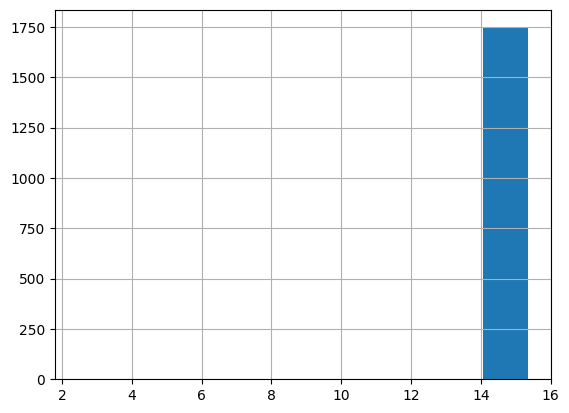

<Axes: >

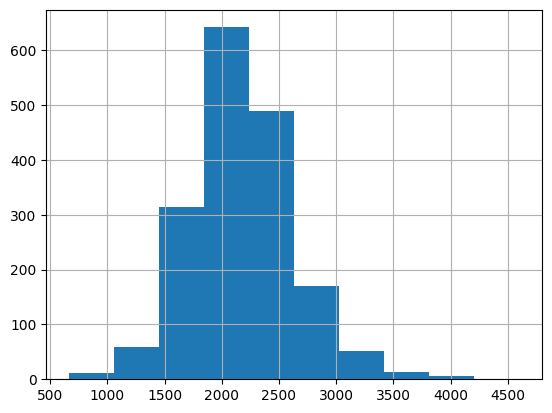

In [203]:
df['duration'].hist()
plt.show()
df['cent_mean'].hist()

In [232]:

df.columns

Index(['file_name', 'text', 'clean', 'processed', 'amount of words_cleared',
       'amount of words_all', 'unique_words', 'duration', 'mfcc_mean',
       'mfcc_std', 'cent_mean', 'cent_std', 'roloff_mean', 'roloff_std',
       'rms_mean', 'rms_std', 'spacious_pose'],
      dtype='object')

In [216]:
df.info()
tmp = df.copy()
to_fill = ['duration', 'mfcc_mean',
       'mfcc_std', 'cent_mean', 'cent_std', 'roloff_mean', 'roloff_std',
       'rms_mean', 'rms_std']
for c in to_fill:
    df[c].fillna(df[c].mean(), inplace=True)

# df = df.fillna(
# #tmp = tmp.fillna(tmp.mean(), inplace=True)
# #tmp['cent_mean'].hist()
# #df.fillna(df.mean(), inplace=True)
# #tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   file_name                2000 non-null   object
 1   text                     2000 non-null   object
 2   clean                    2000 non-null   object
 3   processed                2000 non-null   object
 4   amount of words_cleared  2000 non-null   int64 
 5   amount of words_all      2000 non-null   int64 
 6   unique_words             2000 non-null   int64 
 7   duration                 1759 non-null   object
 8   mfcc_mean                1759 non-null   object
 9   mfcc_std                 1759 non-null   object
 10  cent_mean                1759 non-null   object
 11  cent_std                 1759 non-null   object
 12  roloff_mean              1759 non-null   object
 13  roloff_std               1759 non-null   object
 14  rms_mean                 1759 non-null  

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   file_name                2000 non-null   object 
 1   text                     2000 non-null   object 
 2   clean                    2000 non-null   object 
 3   processed                2000 non-null   object 
 4   amount of words_cleared  2000 non-null   int64  
 5   amount of words_all      2000 non-null   int64  
 6   unique_words             2000 non-null   int64  
 7   duration                 2000 non-null   float64
 8   mfcc_mean                2000 non-null   float64
 9   mfcc_std                 2000 non-null   float64
 10  cent_mean                2000 non-null   float64
 11  cent_std                 2000 non-null   float64
 12  roloff_mean              2000 non-null   float64
 13  roloff_std               2000 non-null   float64
 14  rms_mean                

In [218]:
display(df.sample(3))
df.to_csv('df_sound_test.csv')

file_name                                               text  \
1721  yHwuRYr5lxk.001.mp4  I would really appreciate if you started your ...   
1157  5ghk5950BhU.000.mp4  This is my other video. This is [inaudible 00:...   
101   aIh8DTa3RVg.004.mp4  ... say spaghetti bolognese. She would serve m...   

                                                  clean  \
1721  i would really appreciate if you started your ...   
1157  this is my other video this is inaudible satur...   
101    say spaghetti bolognese she would serve me a ...   

                                              processed  \
1721  would really appreciate started couponscom cou...   
1157  video inaudible saturday red liquid ice review...   
101   say spaghetti bolognese would serve bowl full ...   

      amount of words_cleared  amount of words_all  unique_words   duration  \
1721                      277                  275            39  15.277601   
1157                      215                  225            35  15.330000   
101                       184                  188            36  15.320000   

      mfcc_mean   mfcc_std    cent_mean     cent_std  roloff_mean  \
1721 -11.545975  17.325039  2174.053677  1137.253819  4076.325574   
1157 -19.360235  21.164148  2826.025678  1892.027723  4730.072659   
101  -14.403358  23.873316  2395.479949  1523.904898  4143.967063   

       roloff_std  rms_mean   rms_std  
1721  2027.547905  0.059010  0.041565  
1157  2520.866910  0.056124  0.047704  
101   2586.932978  0.069901  0.062912

In [219]:
table_cv = process_videos_in_folder(video_folder_path, output_folder_photo)
table_cv.rename(columns={'filename':'file_name'}, inplace=True)
table_cv.to_csv("pose_parameters_FINAL.csv", index=False)

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f82675d680] moov atom not found
I0000 00:00:1731217200.342524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217200.359203  314010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217200.364136  314008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217200.374389  314006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217200.384181  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217200.395670  314015 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217200.426904  314012 inference_feedback_

Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217201.049896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217201.061432  314030 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217201.065872  314026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217201.077846  314028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217201.225580  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217201.236341  314035 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 11


W0000 00:00:1731217201.275038  314032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217201.298509  314033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217201.609364  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217201.619832  314040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217201.623861  314037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217201.634962  314037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217202.840391  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217202.851339  314050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217202.856873  314047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217202.863004  314046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217203.006971  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217203.017394  314055 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217203.053093  314053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217203.079789  314054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217203.395950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217203.406539  314060 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217203.408878  314058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217203.417545  314057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217204.586249  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217204.598223  314070 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217204.601482  314067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217204.608533  314066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217204.757162  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217204.768508  314075 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217204.795742  314073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217204.819534  314071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217205.135877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217205.146651  314080 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217205.149127  314076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217205.158585  314076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217206.411323  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217206.421930  314089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217206.425771  314085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217206.438231  314085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217206.572470  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217206.583055  314095 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217206.617498  314091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217206.642774  314093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217207.053106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217207.063669  314100 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217207.066382  314099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217207.073121  314099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217208.409810  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217208.420622  314109 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217208.423432  314106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217208.432930  314106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217208.572230  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217208.582561  314115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217208.613233  314113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217208.626698  314112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217208.999397  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217209.010152  314122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217209.012369  314119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217209.019387  314119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217210.146859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217210.157643  314131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217210.161260  314130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217210.172012  314130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217210.320155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217210.330718  314136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731217210.362900  314132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217210.376287  314135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217210.665851  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217210.676406  314143 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217210.678646  314142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217210.684687  314141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217211.728048  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217211.738689  314152 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217211.741067  314151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217211.750258  314151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217211.877389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217211.887755  314157 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217211.902295  314156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217212.213984  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217212.224537  314162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217212.227075  314159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217212.239479  314158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217213.527990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217213.538878  314172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217213.541455  314168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217213.546392  314169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217213.702678  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217213.713345  314177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217213.726636  314175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217213.751202  314173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217214.129898  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217214.140498  314182 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217214.143077  314181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217214.149892  314181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217215.406511  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217215.417146  314192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217215.419709  314191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217215.426139  314191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217215.579250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217215.589946  314197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217215.603551  314194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


W0000 00:00:1731217215.623182  314193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217215.929406  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217215.940024  314202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217215.942275  314199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217215.948232  314200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217217.250691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217217.261320  314212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217217.263683  314210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217217.269730  314209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217217.414286  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217217.425212  314217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217217.439872  314215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217217.763012  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217217.773574  314222 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217217.775929  314219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217217.785889  314220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f802ddaf00] moov atom not found
I0000 00:00:1731217218.389335  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217218.400100  314227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217218.402444  314224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217218.406962  314225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217218.416937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217218.427277  314232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217218.456650  314228 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217219.262238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217219.272939  314262 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217219.275330  314261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217219.284909  314258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217219.427690  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217219.438144  314267 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217219.470552  314265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217219.487152  314263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217219.809872  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217219.820342  314272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217219.822755  314270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217219.831567  314271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f8de80] moov atom not found
I0000 00:00:1731217220.436917  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217220.447413  314277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217220.449828  314273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217220.454605  314274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217220.465023  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217220.475181  314283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217220.488080  314279 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217221.379296  314299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217221.687956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217221.698571  314308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217221.701179  314307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217221.706117  314307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8060ba0c0] moov atom not found
I0000 00:00:1731217222.311659  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217222.322324  314313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217222.324729  314309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217222.329552  314310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217222.338807  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217222.349127  314318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217222.362128  314314 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731217222.525075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217222.535046  314343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217222.537534  314339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217222.542762  314340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217222.551693  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217222.561829  314348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217222.591220  314345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217223.294447  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217223.305047  314378 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217223.307662  314377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217223.316690  314377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217223.442617  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217223.452886  314383 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217223.466211  314381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217223.784079  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217223.794589  314388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217223.797082  314385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217223.801809  314384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8055b96c0] moov atom not found
I0000 00:00:1731217224.420784  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217224.431334  314399 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217224.433608  314398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217224.442027  314396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217224.451989  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217224.462360  314404 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217224.483138  314401 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217225.290859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217225.301586  314434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217225.303910  314433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217225.313596  314433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217225.467610  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217225.477988  314439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217225.499051  314436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731217225.511700  314437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217225.843048  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217225.853734  314444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217225.856330  314443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217225.862459  314440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217227.217047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217227.227840  314454 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217227.230498  314453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217227.236572  314450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217227.391113  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217227.401829  314459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 2


W0000 00:00:1731217227.430326  314456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217227.450677  314455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217227.915198  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217227.925637  314464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217227.928146  314460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217227.932923  314460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217229.212700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217229.223370  314474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217229.226037  314473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217229.230891  314473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217229.390649  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217229.401079  314479 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217229.434558  314476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217229.462359  314476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217229.780620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217229.791092  314484 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217229.793546  314482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217229.798318  314481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217230.985848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217230.996481  314494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217230.998942  314490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217231.003641  314490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217231.158182  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217231.168676  314499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217231.181669  314497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217231.655437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217231.665842  314504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217231.668100  314502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217231.672952  314503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217232.952745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217232.963401  314514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217232.966324  314511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217232.971818  314511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217233.106535  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217233.117321  314519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217233.131759  314517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217233.467226  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217233.477611  314524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217233.479874  314521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217233.484520  314522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f812f06c00] moov atom not found
I0000 00:00:1731217234.058612  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217234.069584  314529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217234.071954  314525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217234.077302  314528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217234.086877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217234.097116  314534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217234.110218  314530 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217234.977343  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217234.988296  314567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217234.990677  314563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217235.000573  314563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217235.159345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217235.169775  314572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217235.183285  314570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


W0000 00:00:1731217235.195646  314571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217235.511707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217235.522176  314577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217235.525291  314573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217235.535012  314576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8175541c0] moov atom not found
I0000 00:00:1731217236.168063  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217236.179182  314582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217236.182667  314579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217236.187820  314578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217236.197127  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217236.208494  314587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217236.222650  314584 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217237.352888  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217237.363313  314612 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217237.365726  314609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217237.373829  314609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217238.593921  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217238.605009  314621 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217238.607608  314620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217238.613067  314619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217238.744297  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217238.754798  314626 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217238.772747  314622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217239.228464  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217239.239473  314632 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217239.241920  314628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217239.248614  314629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217240.217360  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217240.228868  314641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217240.231311  314639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217240.235874  314638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217240.333103  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217240.343676  314646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217240.366640  314643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217240.603618  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217240.614249  314651 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217240.617538  314650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217240.626808  314650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217241.607451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217241.618290  314662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217241.620700  314658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217241.625501  314660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217241.758508  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217241.768829  314667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217241.791299  314663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217242.121624  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217242.132358  314672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217242.135312  314671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217242.140236  314669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217243.354320  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217243.365025  314682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217243.368007  314679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217243.375968  314679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217243.529233  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217243.540033  314687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217243.555162  314685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217243.567458  314684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217243.891835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217243.902626  314692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217243.905229  314691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217243.910876  314690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217245.225057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217245.235919  314703 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217245.238447  314699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217245.243307  314702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217245.409473  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217245.420118  314708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217245.436088  314706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217245.448261  314705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217245.830677  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217245.841081  314713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217245.843580  314712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217245.850784  314712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217247.185737  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217247.196349  314723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217247.198601  314720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217247.204364  314719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217247.360086  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217247.370538  314728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217247.398364  314724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217247.410239  314726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217247.810514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217247.820876  314733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217247.823507  314732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217247.831535  314730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217249.134582  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217249.145194  314743 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217249.147937  314742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217249.153438  314742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217249.306137  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217249.316664  314748 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217249.344786  314745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217249.359260  314744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217249.687176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217249.697554  314753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217249.699849  314750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217249.704642  314749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217251.058633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217251.069418  314765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217251.071914  314763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217251.076641  314764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217251.224353  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217251.234658  314770 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217251.266626  314766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217251.283220  314768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217251.699492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217251.710174  314775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217251.712527  314774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217251.718217  314773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217253.061469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217253.072276  314785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217253.074617  314783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217253.080238  314784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217253.231878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217253.242419  314790 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217253.258277  314786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217253.273762  314787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217253.597507  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217253.608029  314795 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217253.610335  314792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217253.616052  314793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217254.759253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217254.770084  314805 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217254.773192  314801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217254.779147  314803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217254.903278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217254.913772  314810 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217254.927075  314809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217255.225130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217255.235806  314816 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217255.238162  314815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217255.244273  314813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217256.415471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217256.426612  314825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217256.428967  314823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217256.433878  314823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217256.599001  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217256.609428  314830 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217256.622948  314827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217256.635085  314826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217256.984586  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217256.995031  314835 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217256.997770  314831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217257.002534  314831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217258.375151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217258.385875  314845 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217258.388385  314844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217258.393262  314844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217258.539027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217258.549276  314850 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217258.562616  314848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731217258.890299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217258.900814  314855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217258.903499  314854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217258.911000  314854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217260.301495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217260.312553  314865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217260.315098  314861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217260.320022  314864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217260.475525  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217260.485993  314870 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217260.517166  314867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217260.529948  314868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217260.862248  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217260.872943  314875 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217260.875325  314872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217260.880485  314871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217262.309815  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217262.320523  314885 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217262.323596  314883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217262.330654  314883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217262.488658  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217262.502399  314890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217262.515679  314888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


W0000 00:00:1731217262.528203  314887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217262.858537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217262.869214  314895 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217262.872260  314894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217262.878646  314893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217264.041780  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217264.052520  314905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217264.055262  314904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217264.059976  314904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217264.226801  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217264.237126  314910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217264.250297  314908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217264.263097  314906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217264.580436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217264.590839  314915 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217264.593610  314914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217264.598395  314914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217265.743693  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217265.754460  314928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217265.756775  314927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217265.761420  314927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217265.907306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217265.917627  314933 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217265.933147  314929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217266.274946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217266.285537  314938 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217266.287953  314934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217266.292839  314937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217267.845960  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217267.856684  314948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217267.858961  314947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217267.863620  314944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217268.017196  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217268.028158  314953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217268.041398  314949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217268.060471  314951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217268.398109  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217268.408629  314958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217268.410982  314957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217268.415824  314954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217269.894749  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217269.905366  314968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217269.907642  314965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217269.912339  314964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217270.049715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217270.060263  314973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217270.087628  314969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217270.430051  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217270.440560  314978 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217270.443029  314975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217270.448458  314977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217271.524178  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217271.534850  314988 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217271.537294  314984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217271.541940  314987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217271.687871  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217271.698572  314993 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217271.712769  314989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217272.039830  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217272.050421  314998 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217272.052880  314996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217272.059119  314996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217273.208638  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217273.219328  315008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217273.221687  315004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217273.227662  315006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217273.364842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217273.375297  315013 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217273.389031  315009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217273.789187  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217273.800429  315018 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217273.802951  315017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217273.807896  315017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217275.000076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217275.010769  315028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217275.013121  315027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217275.017841  315024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217275.177983  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217275.188573  315034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217275.201775  315031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


W0000 00:00:1731217275.214039  315030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217275.594068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217275.604597  315039 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217275.607213  315037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217275.612488  315038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217276.931766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217276.942574  315048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217276.945019  315044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217276.949911  315045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217277.108333  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217277.118707  315053 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217277.136317  315050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731217277.148480  315049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217277.565835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217277.576326  315059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217277.578964  315058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217277.584335  315057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217278.784499  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217278.795209  315068 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217278.798476  315064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217278.804004  315067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217278.935775  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217278.946363  315073 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217278.960556  315071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217279.276665  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217279.287055  315079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217279.289659  315075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217279.294618  315078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217280.703856  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217280.714774  315090 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217280.717186  315089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217280.721949  315086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217280.874094  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217280.884590  315095 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217280.898132  315091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217281.314165  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217281.324468  315101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217281.326976  315097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217281.331770  315099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217282.405847  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217282.416574  315110 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217282.418852  315107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217282.423569  315109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217282.570736  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217282.581169  315115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217282.595414  315111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217282.931459  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217282.942922  315120 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217282.947835  315119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217282.956208  315119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217284.176544  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217284.187521  315130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217284.192437  315129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217284.200364  315126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217284.340799  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217284.352231  315135 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217284.366140  315132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217284.700511  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217284.712237  315140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217284.715708  315137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217284.722726  315138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217285.927208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217285.938661  315151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217285.941128  315147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217285.946160  315147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217286.112710  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217286.123493  315156 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217286.138041  315153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731217286.151010  315152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217286.490461  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217286.501226  315161 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217286.504183  315159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217286.510653  315159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217287.888373  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217287.899236  315171 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217287.901713  315168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217287.906777  315168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217288.062838  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217288.073627  315176 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217288.091649  315174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217288.106065  315173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217288.430518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217288.442250  315181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217288.445083  315178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217288.450383  315179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217289.854626  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217289.865369  315191 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217289.867941  315187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217289.873249  315190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217290.035534  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217290.046183  315196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217290.059475  315194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217290.072625  315192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217290.402971  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217290.413695  315201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217290.416173  315198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217290.420997  315197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217291.826351  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217291.837277  315211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217291.840166  315210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217291.846126  315210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217292.000209  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217292.010610  315216 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217292.025161  315213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217292.343934  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217292.354576  315221 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217292.356812  315218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217292.361486  315217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217293.557361  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217293.568212  315231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217293.571503  315227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217293.576391  315229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217293.701369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217293.712086  315236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217293.726886  315232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217294.075289  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217294.085861  315241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217294.088313  315237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217294.095647  315239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217295.411662  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217295.422508  315252 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217295.425750  315251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217295.433541  315251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217295.577166  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217295.587804  315257 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217295.600804  315254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217296.056915  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217296.067441  315262 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217296.069813  315259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217296.074569  315258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217297.355424  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217297.366162  315271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217297.368569  315269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217297.373371  315269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217297.516262  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217297.526755  315277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217297.547405  315275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217297.863397  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217297.873867  315282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217297.876467  315280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217297.881316  315281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217299.129633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217299.140464  315291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217299.144056  315288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217299.149038  315290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217299.296305  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217299.306590  315296 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217299.321043  315294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217299.817910  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217299.828679  315302 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217299.830907  315299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217299.835774  315298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217301.015341  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217301.025987  315311 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217301.028235  315308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217301.032657  315307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217301.166742  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217301.177302  315316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217301.193838  315312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217301.556276  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217301.566510  315322 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217301.568775  315318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217301.573679  315319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217303.009745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217303.020496  315331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217303.023019  315328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217303.027911  315328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217303.189411  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217303.199945  315336 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217303.214110  315334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217303.226630  315335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217303.549706  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217303.560047  315342 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217303.562564  315340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217303.568480  315340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217304.701841  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217304.712554  315351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217304.715089  315350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217304.720142  315348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217304.864655  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217304.875090  315356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217304.888333  315352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217305.406583  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217305.416992  315362 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217305.419608  315358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217305.427464  315361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217306.748832  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217306.759713  315372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217306.761969  315368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217306.766845  315369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217306.909539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217306.920076  315377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217306.933890  315374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


W0000 00:00:1731217306.960985  315374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217307.295669  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217307.306186  315382 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217307.308513  315381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217307.316455  315381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217308.556544  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217308.567186  315392 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217308.569622  315388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217308.575452  315388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217308.723908  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217308.734530  315397 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217308.748015  315394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217309.086718  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217309.097243  315402 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217309.099664  315398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217309.107295  315401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217310.424558  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217310.435316  315412 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217310.438862  315408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217310.443623  315409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217310.583429  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217310.593854  315417 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217310.606938  315415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217310.934390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217310.944947  315422 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217310.948121  315418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217310.954189  315420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217312.281449  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217312.292182  315432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217312.294927  315428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217312.300955  315431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217312.436821  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217312.447167  315437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217312.461637  315435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217312.826918  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217312.837319  315442 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217312.839872  315441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217312.844743  315440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217314.147203  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217314.157884  315452 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217314.160322  315448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217314.165065  315448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217314.325446  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217314.335995  315457 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217314.350407  315456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217314.375546  315456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217314.771434  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217314.781812  315462 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217314.784107  315459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217314.789008  315461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217315.982007  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217315.992721  315473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217315.995154  315469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217316.001199  315471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217316.130492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217316.140940  315478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217316.158732  315475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217316.627262  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217316.637709  315483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217316.640089  315479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217316.645004  315480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217317.603211  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217317.613866  315493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217317.616334  315489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217317.621349  315492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217317.769009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217317.779306  315498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217317.793497  315495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217318.173874  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217318.184566  315503 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217318.186926  315500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217318.191764  315502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217319.469494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217319.480294  315514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217319.482978  315512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217319.487799  315513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217319.628647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217319.639113  315520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217319.653030  315519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217320.003006  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217320.013468  315525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217320.016205  315524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217320.022046  315523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217321.251479  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217321.262232  315534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217321.264598  315530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217321.269635  315532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217321.408021  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217321.418595  315539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217321.432913  315537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217321.773054  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217321.783474  315545 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217321.785791  315541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217321.790712  315542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217323.105932  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217323.116661  315554 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217323.120064  315553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217323.127351  315553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217323.277547  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217323.287949  315559 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217323.301103  315557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217323.645476  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217323.656091  315565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217323.658474  315563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217323.663267  315563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217324.860410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217324.871018  315574 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217324.873391  315571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217324.878083  315570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217325.007776  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217325.018231  315580 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217325.031519  315576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217325.363524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217325.373928  315586 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217325.376475  315585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217325.381487  315585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217326.639866  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217326.650572  315596 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217326.653159  315594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217326.659141  315594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217326.799924  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217326.810275  315601 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217326.826357  315600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217327.187109  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217327.197502  315606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217327.199719  315605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217327.204445  315602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217328.464897  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217328.475686  315617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217328.479015  315613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217328.484832  315614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217328.615204  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217328.625724  315622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217328.638899  315619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731217329.033296  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217329.044682  315627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217329.049219  315626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217329.055373  315624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217330.307303  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217330.318600  315637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217330.322003  315635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217330.331029  315635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217330.467384  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217330.478751  315642 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217330.501067  315638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731217330.879849  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217330.891193  315647 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217330.894637  315645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217330.899414  315645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217332.100851  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217332.112093  315657 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217332.114722  315656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217332.119874  315653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217332.251476  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217332.261931  315662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217332.275024  315658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217332.567601  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217332.578328  315668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217332.581127  315667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217332.586712  315667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217333.721218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217333.732389  315677 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217333.736141  315676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217333.741287  315675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217333.879354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217333.889599  315683 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217333.904063  315681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217334.223286  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217334.234661  315688 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217334.237149  315684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217334.241945  315687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217335.602092  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217335.612831  315698 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217335.616319  315697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217335.621489  315694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217335.777049  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217335.787520  315704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217335.803189  315702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217335.815936  315701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217336.295665  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217336.306011  315709 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217336.308513  315707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217336.313263  315706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217337.528406  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217337.539016  315718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217337.541531  315714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217337.547244  315715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217337.682681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217337.692877  315723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217337.705977  315720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217338.026772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217338.037142  315729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217338.039516  315726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217338.045334  315726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217339.382759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217339.393316  315738 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217339.395934  315734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217339.400697  315735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217339.553918  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217339.564529  315743 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217339.586830  315739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217339.599173  315741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217339.972363  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217339.982703  315749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217339.985216  315746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217339.989941  315746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217341.370602  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217341.381272  315758 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217341.383854  315755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217341.391807  315757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217341.545597  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217341.556106  315763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217341.570398  315762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217341.582897  315761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217342.009399  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217342.019968  315769 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217342.022676  315765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217342.028667  315767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217343.276731  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217343.287563  315778 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217343.290159  315775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217343.294920  315775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217343.451000  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217343.461452  315783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217343.475835  315781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731217343.490392  315780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217343.835480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217343.846144  315789 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217343.848825  315788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217343.853785  315788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217345.274832  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217345.285697  315804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217345.288165  315803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217345.293107  315803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217345.448639  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217345.458957  315809 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217345.473636  315808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217345.845863  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217345.856292  315815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217345.858916  315814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217345.863961  315813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217347.111009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217347.121798  315824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217347.124432  315823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217347.129257  315823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217347.285336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217347.295931  315829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 15


W0000 00:00:1731217347.327468  315826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217347.340359  315828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217347.772780  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217347.783170  315834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217347.785545  315831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217347.791407  315833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217349.029923  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217349.040981  315844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217349.043318  315841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217349.048187  315840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217349.211129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217349.221589  315849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217349.234894  315847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217349.252468  315846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217349.578563  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217349.589107  315854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217349.591784  315853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217349.598439  315851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217350.890549  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217350.901279  315864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217350.904001  315863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217350.912456  315863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217351.061846  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217351.072279  315869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217351.086308  315866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217351.416757  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217351.427186  315874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217351.429537  315870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217351.434312  315870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217352.650101  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217352.660908  315884 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217352.663621  315881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217352.671058  315881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217352.822027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217352.832213  315889 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217352.845192  315886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217353.161010  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217353.171435  315894 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217353.173906  315892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217353.179113  315891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217354.474406  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217354.485087  315905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217354.487456  315901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217354.492291  315904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217354.648008  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217354.658589  315910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217354.672076  315908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217354.998867  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217355.009793  315916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217355.012737  315912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217355.018022  315912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217356.269627  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217356.280389  315926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217356.282744  315925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217356.287846  315925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217356.436287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217356.446520  315931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217356.459905  315927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731217356.902661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217356.913125  315936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217356.915733  315933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217356.921771  315935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217358.064637  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217358.075444  315946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217358.078878  315945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217358.083894  315944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217358.219376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217358.229926  315951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217358.243196  315948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217358.640319  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217358.650936  315956 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217358.653529  315955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217358.658646  315955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217359.996627  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217360.007432  315966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217360.009841  315962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217360.015501  315964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217360.159574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217360.170105  315971 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217360.183206  315967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217360.516130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217360.526521  315976 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217360.529160  315973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217360.534173  315973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217361.907846  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217361.918506  315985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217361.921784  315982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217361.928440  315984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217362.068279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217362.078586  315991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217362.091762  315989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217362.422795  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217362.433383  315996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217362.435811  315992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217362.440690  315995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217363.658896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217363.669687  316005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217363.672063  316001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217363.676894  316001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217363.809839  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217363.820357  316010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217363.833606  316006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217364.145454  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217364.156110  316018 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217364.158646  316014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217364.163427  316014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217365.237466  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217365.248695  316028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217365.251058  316024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217365.255815  316025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217365.407433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217365.417783  316033 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217365.430831  316029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217365.771191  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217365.781495  316038 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217365.784169  316037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217365.789052  316035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217366.912397  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217366.923136  316048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217366.925381  316044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217366.931006  316044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217367.078717  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217367.089283  316053 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217367.102387  316049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217367.429627  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217367.440230  316058 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217367.442619  316056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217367.447592  316056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217368.810055  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217368.820854  316068 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217368.824310  316067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217368.828979  316067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217368.983075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217368.993651  316073 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217369.008216  316069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217369.336219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217369.346631  316078 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217369.349276  316076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217369.354357  316075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217370.749701  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217370.760387  316088 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217370.762911  316086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217370.767622  316084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217370.913834  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217370.924390  316093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217370.937535  316089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217371.252707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217371.263214  316098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217371.265543  316094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217371.270103  316095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217372.590973  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217372.601785  316108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217372.604667  316107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217372.609567  316106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217372.756200  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217372.766551  316113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217372.780968  316112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217373.134437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217373.145152  316118 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217373.148121  316114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217373.153229  316116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217374.311272  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217374.321886  316128 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217374.324486  316127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217374.329357  316125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217374.492646  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217374.503295  316133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217374.516855  316129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217374.530125  316130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217374.852538  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217374.862963  316138 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217374.865572  316137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217374.871349  316137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217376.030076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217376.040849  316148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217376.044770  316147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217376.050130  316147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217376.208561  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217376.219738  316154 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217376.234685  316151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731217376.252745  316153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217376.555171  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217376.566602  316159 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217376.571852  316158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217376.579688  316158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217377.768754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217377.780777  316168 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217377.787214  316167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217377.794156  316166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217377.927431  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217377.938755  316173 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217377.962288  316170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217378.347503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217378.358892  316179 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217378.362403  316178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217378.370128  316178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217379.584819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217379.596037  316188 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217379.599159  316184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217379.604444  316186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217379.742299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217379.752895  316193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217379.766498  316189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217380.106087  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217380.117233  316198 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217380.119892  316194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217380.125081  316195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217381.384764  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217381.396437  316208 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217381.399033  316205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217381.404187  316206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217381.546028  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217381.556544  316213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217381.570746  316209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217381.906916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217381.917581  316218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217381.920467  316217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217381.926188  316217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217382.990146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217383.000962  316228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217383.003416  316226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217383.008828  316227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217383.119117  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217383.129625  316233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217383.143149  316229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217383.376667  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217383.387217  316238 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217383.389807  316237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217383.394772  316236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217384.542813  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217384.553927  316248 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217384.556790  316247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217384.561684  316246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217384.739723  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217384.750376  316253 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217384.764278  316251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217384.776910  316252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217385.226421  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217385.237441  316259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217385.240248  316256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217385.244948  316255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217386.526539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217386.537262  316269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217386.539946  316268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217386.548808  316268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217386.687423  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217386.697738  316274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217386.711142  316271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217387.340564  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217387.351147  316279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217387.353566  316276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217387.358294  316275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217388.670372  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217388.681004  316291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217388.683430  316288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217388.688246  316288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217388.845708  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217388.856191  316296 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217388.869535  316293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731217388.882308  316295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217389.274759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217389.285179  316301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217389.287913  316298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217389.293634  316300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217390.573573  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217390.584268  316311 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217390.586858  316310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217390.592679  316310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217390.731597  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217390.741993  316316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217390.756487  316314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217391.296688  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217391.307197  316321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217391.310061  316320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217391.314966  316320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217392.528528  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217392.539170  316331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217392.541641  316327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217392.546463  316329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217392.676245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217392.686574  316336 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217392.716727  316333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217393.055067  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217393.065799  316341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217393.068215  316337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217393.073138  316338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217394.286333  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217394.296957  316350 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217394.300340  316349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217394.305278  316346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217394.448342  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217394.458923  316355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217394.472592  316352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217394.795083  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217394.805723  316361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217394.808281  316360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217394.813321  316360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217395.937760  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217395.948518  316371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217395.951152  316370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217395.956019  316367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217396.095078  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217396.105587  316376 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217396.119794  316374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217396.449339  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217396.459825  316383 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217396.462324  316380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217396.467049  316379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217397.602924  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217397.613747  316393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217397.616465  316392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217397.621762  316392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217397.757205  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217397.767889  316398 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217397.781155  316395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217398.111078  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217398.121590  316403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217398.124362  316402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217398.129224  316400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217399.281292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217399.292090  316413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217399.294535  316409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217399.299172  316410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217399.437165  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217399.447426  316418 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217399.461495  316416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217399.796139  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217399.806551  316423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217399.810265  316421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217399.815262  316419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217400.930930  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217400.941643  316433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217400.944274  316432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217400.953772  316432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217401.083130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217401.093664  316438 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217401.107113  316434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217401.414902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217401.425288  316443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217401.427731  316440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217401.432602  316440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217402.617815  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217402.628577  316453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217402.631055  316449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217402.635943  316450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217402.781629  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217402.792050  316458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217402.806573  316456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217403.146095  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217403.156851  316463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217403.159406  316462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217403.166095  316461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217404.460980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217404.471875  316472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217404.475237  316468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217404.479968  316469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217404.642732  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217404.653136  316478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217404.666251  316474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731217404.681476  316475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217405.015712  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217405.026185  316483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217405.028511  316479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217405.034118  316481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217406.344374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217406.355078  316493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217406.357358  316490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217406.363093  316491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217406.513506  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217406.524029  316498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217406.537606  316497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217406.901245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217406.915198  316504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217406.917786  316503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217406.922747  316500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217408.227456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217408.238363  316513 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217408.240696  316510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217408.246410  316512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217408.414821  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217408.425408  316518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217408.438756  316514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217408.451074  316515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217408.771327  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217408.781854  316524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217408.785219  316522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217408.792683  316522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217410.103345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217410.114201  316533 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217410.116705  316531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217410.121463  316531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217410.284514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217410.294863  316538 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217410.309002  316536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217410.321221  316534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217410.659852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217410.670378  316544 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217410.672642  316541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217410.677469  316543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217411.911193  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217411.922032  316555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217411.924542  316551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217411.930520  316551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217412.046229  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217412.056890  316560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217412.070844  316559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217412.385282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217412.395893  316565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217412.398755  316564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217412.403774  316561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217413.546876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217413.557706  316575 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217413.560182  316573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217413.565706  316573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217413.697938  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217413.708516  316580 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217413.722066  316577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217414.026808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217414.037354  316585 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217414.039951  316584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217414.044926  316582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217415.242003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217415.252757  316596 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217415.256523  316595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217415.261492  316594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217415.421228  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217415.431781  316601 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217415.446099  316598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217415.460645  316597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217415.876446  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217415.886901  316606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217415.889430  316604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217415.894512  316602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217417.254642  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217417.265465  316616 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217417.268130  316615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217417.273176  316613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217417.420296  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217417.430697  316621 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217417.444873  316618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217417.846068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217417.856765  316626 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217417.860249  316625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217417.865307  316623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217419.038797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217419.049475  316636 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217419.052028  316632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217419.056875  316635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217419.207768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217419.218187  316641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217419.231973  316639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217419.566645  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217419.577187  316646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217419.579613  316643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217419.589433  316643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217420.841011  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217420.852054  316656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217420.854534  316654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217420.859537  316653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217421.022087  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217421.032964  316661 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217421.046768  316657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217421.059637  316659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217421.434518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217421.445786  316666 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217421.450743  316665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217421.460471  316664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217422.759822  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217422.771489  316676 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217422.775016  316675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217422.779944  316675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217422.938430  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217422.949942  316682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217422.967936  316679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217422.983985  316681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217423.343084  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217423.354744  316687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217423.358027  316683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217423.364020  316684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217424.712578  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217424.723305  316696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217424.725762  316694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217424.734519  316692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217424.880473  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217424.890852  316702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217424.905511  316701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217425.307237  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217425.318158  316708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217425.321697  316707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217425.327783  316707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217426.542974  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217426.554710  316717 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217426.557169  316715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217426.563260  316715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217426.693488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217426.704066  316722 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217426.717810  316718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217427.106302  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217427.116743  316728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217427.119723  316727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217427.125030  316727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217428.298974  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217428.309748  316737 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217428.312380  316736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217428.320552  316735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217428.466095  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217428.476432  316742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217428.494588  316738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217428.852208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217428.862792  316748 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217428.865408  316744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217428.870965  316745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217430.158182  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217430.168960  316759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217430.172582  316758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217430.177317  316757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217430.316306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217430.326648  316764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217430.343005  316760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217430.710532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217430.721082  316769 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217430.723396  316766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217430.729319  316768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217431.917434  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217431.928221  316779 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217431.930684  316777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217431.936116  316775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217432.080639  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217432.091184  316784 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217432.122081  316780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217432.134356  316781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217432.479934  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217432.490459  316789 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217432.492946  316788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217432.498640  316788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217433.663451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217433.674341  316799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217433.677515  316797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217433.683155  316797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217433.826849  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217433.837602  316804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217433.850970  316800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217434.175616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217434.186425  316809 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217434.188835  316805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217434.195512  316806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217435.350695  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217435.361358  316820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217435.364552  316817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217435.370141  316818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217435.495417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217435.505951  316825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217435.519115  316821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217435.837684  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217435.848118  316830 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217435.850768  316829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217435.856220  316829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217437.079308  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217437.089998  316840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217437.092461  316837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217437.098342  316837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217437.247235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217437.257619  316845 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217437.271027  316841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217437.756821  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217437.767304  316850 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217437.770015  316849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217437.774919  316847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217438.974881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217438.985669  316860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217438.988255  316856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217438.993039  316856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217439.143287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217439.153923  316865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217439.167518  316863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731217439.526323  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217439.536806  316870 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217439.539157  316868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217439.544119  316867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217440.868938  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217440.879613  316879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217440.882220  316877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217440.887026  316876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217441.040789  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217441.051318  316885 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217441.064691  316881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731217441.082907  316882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217441.412858  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217441.423230  316890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217441.425596  316887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217441.430386  316887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217442.694532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217442.705311  316899 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217442.707987  316898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217442.714336  316897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217442.860466  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217442.871618  316904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217442.886153  316902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731217443.198229  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217443.208514  316910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217443.210712  316908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217443.215477  316906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217444.429242  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217444.440088  316919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217444.442330  316916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217444.446927  316915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217444.587387  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217444.597824  316924 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217444.610946  316922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217444.926258  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217444.936808  316929 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217444.939412  316926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217444.944382  316925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217446.162819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217446.173534  316940 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217446.175954  316938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217446.180724  316936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217446.334691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217446.345038  316945 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217446.358377  316941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217446.779336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217446.789731  316950 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217446.791998  316946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217446.797592  316949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217448.141605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217448.152675  316960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217448.155440  316959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217448.161709  316959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217448.322183  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217448.333188  316965 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217448.347315  316961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731217448.362388  316964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217448.733344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217448.744426  316970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217448.746983  316967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217448.751877  316968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217450.089369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217450.100912  316980 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217450.103421  316978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217450.108289  316978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217450.273559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217450.284027  316985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217450.297565  316983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217450.309792  316981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217450.672587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217450.683922  316990 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217450.686369  316987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217450.692364  316987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217452.041646  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217452.052474  317000 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217452.054984  316997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217452.059947  316997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217452.218158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217452.228978  317005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217452.242673  317001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


W0000 00:00:1731217452.255636  317003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217452.587249  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217452.597983  317010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217452.600534  317006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217452.605532  317008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217453.868209  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217453.878978  317020 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217453.881471  317019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217453.890064  317018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217454.023106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217454.033686  317025 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217454.047254  317023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217454.373340  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217454.383776  317030 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217454.386098  317026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217454.390968  317027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217455.655391  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217455.666197  317041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217455.668757  317039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217455.673505  317039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217455.821159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217455.831687  317046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217455.844928  317043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217456.232946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217456.243461  317051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217456.246178  317048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217456.252096  317047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217457.505865  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217457.516507  317061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217457.518752  317058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217457.523384  317058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217457.668247  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217457.678767  317066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217457.692188  317062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217458.070225  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217458.080934  317071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217458.084370  317067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217458.089316  317067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217459.339564  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217459.350388  317081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217459.352820  317077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217459.357705  317077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217459.508245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217459.518833  317086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217459.532474  317083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217459.885767  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217459.896122  317091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217459.898394  317089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217459.904470  317089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217461.114939  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217461.125547  317100 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217461.127878  317098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217461.134266  317098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217461.261957  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217461.272424  317106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217461.285969  317104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217461.591410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217461.604545  317111 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217461.606996  317107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217461.611914  317109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217462.895589  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217462.906374  317120 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217462.908759  317116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217462.913666  317117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217463.047540  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217463.059009  317125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217463.072619  317121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217463.397920  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217463.408395  317131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217463.410582  317127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217463.415544  317129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217464.638594  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217464.649320  317140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217464.651760  317139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217464.657030  317138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217464.808989  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217464.820485  317146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217464.836516  317144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217464.863899  317144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217465.239615  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217465.250357  317157 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217465.252789  317154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217465.257925  317156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217466.413842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217466.425077  317167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217466.427548  317165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217466.432912  317165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217466.580295  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217466.590843  317172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217466.604117  317169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217466.979302  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217466.991247  317177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217466.994012  317174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217466.998939  317173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217468.175270  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217468.187090  317187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217468.191052  317186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217468.197018  317184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217468.373916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217468.385349  317192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217468.399953  317188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217468.413176  317191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217468.902126  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217468.914371  317197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217468.919496  317196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217468.926147  317194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217470.183027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217470.194668  317207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217470.198089  317204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217470.204355  317204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217470.383064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217470.393596  317212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217470.409918  317210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217470.430611  317209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217470.896909  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217470.907671  317217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217470.910558  317213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217470.915393  317214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217472.138913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217472.150122  317227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217472.152694  317226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217472.160227  317223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217472.309598  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217472.320644  317232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217472.333742  317228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217472.766464  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217472.777318  317239 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217472.780130  317238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217472.784916  317238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217474.059228  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217474.069901  317249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217474.072274  317248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217474.078322  317247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217474.230335  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217474.240834  317254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217474.255183  317250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217474.589516  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217474.600053  317259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217474.602763  317258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217474.608550  317258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217475.973253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217475.984105  317270 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217475.986600  317269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217475.992069  317268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217476.149162  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217476.159787  317275 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217476.175258  317273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217476.187503  317272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217476.518936  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217476.529601  317280 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217476.532250  317278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217476.538790  317278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217477.798129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217477.808897  317290 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217477.811396  317287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217477.816365  317288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217477.963614  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217477.974282  317295 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217477.991938  317291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217478.329226  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217478.340036  317300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217478.342725  317296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217478.347550  317297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217479.537972  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217479.548740  317310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217479.551430  317307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217479.556271  317308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217479.692135  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217479.702492  317315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217479.715775  317311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217480.174733  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217480.185450  317320 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217480.188071  317318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217480.194533  317319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217481.375016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217481.386060  317329 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217481.388747  317328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217481.393475  317326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217481.529820  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217481.540606  317334 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217481.555197  317330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217481.938557  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217481.948962  317340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217481.951263  317339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217481.956124  317339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217483.263850  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217483.274519  317349 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217483.277684  317346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217483.282576  317345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217483.426689  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217483.437036  317354 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217483.455232  317352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217483.785945  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217483.796433  317360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217483.798877  317358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217483.804338  317358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217485.101457  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217485.112228  317369 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217485.114704  317367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217485.119365  317365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217485.269940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217485.280255  317375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217485.293277  317373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217485.667239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217485.677719  317381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217485.680160  317380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217485.684906  317380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217486.865226  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217486.876038  317390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217486.878427  317386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217486.883324  317387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217487.020413  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217487.031034  317395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217487.044561  317391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217487.334628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217487.345038  317400 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217487.347258  317396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217487.351862  317398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217488.547726  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217488.558568  317410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217488.561041  317406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217488.566041  317409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217488.759635  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


Количество изображений с зрительным контактом: 16


I0000 00:00:1731217488.772008  317415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217488.788344  317413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217488.801316  317411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217489.289189  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217489.300598  317420 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217489.303901  317419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217489.311681  317419 inference

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217490.562894  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217490.574068  317430 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217490.576637  317427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217490.581517  317427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217490.737375  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217490.747938  317435 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731217490.778941  317431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217490.791750  317432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217491.145367  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217491.156324  317440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217491.158926  317436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217491.163989  317439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217492.385155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217492.396267  317450 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217492.398805  317449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217492.403814  317447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217492.568175  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217492.578852  317455 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217492.595191  317451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217492.608193  317452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217492.922250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217492.933176  317460 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217492.935622  317457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217492.941650  317459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217494.213836  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217494.225114  317470 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217494.229211  317469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217494.237818  317469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Количество изображений с зрительным контактом: 14


I0000 00:00:1731217494.431055  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217494.441869  317475 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217494.455378  317473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217494.471843  317471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217494.800662  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217494.811652  317480 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217494.814248  317476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217496.274561  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217496.285572  317491 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217496.288394  317490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217496.293314  317490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217496.446727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217496.457517  317496 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217496.471200  317493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217496.924474  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217496.935212  317501 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217496.937710  317498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217496.943684  317499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217498.126555  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217498.137260  317511 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217498.140276  317510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217498.145353  317507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217498.309059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217498.320078  317516 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217498.334233  317513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


W0000 00:00:1731217498.347531  317512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217498.837344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217498.848278  317521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217498.850793  317518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217498.855807  317517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217500.254703  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217500.265597  317531 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217500.268377  317530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217500.274169  317530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217500.431155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217500.441785  317536 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217500.455350  317532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731217500.467496  317534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217500.790702  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217500.800988  317541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217500.803527  317539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217500.811209  317538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217502.028542  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217502.039310  317551 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217502.041702  317549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217502.047388  317548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217502.210864  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217502.221417  317556 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217502.234882  317554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217502.247003  317553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217502.637179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217502.647910  317561 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217502.650328  317558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217502.655641  317559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217503.810363  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217503.821139  317570 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217503.824343  317569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217503.829263  317569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217503.991203  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217504.001779  317576 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217504.015490  317572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217504.028633  317574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217504.351136  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217504.361869  317581 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217504.364234  317578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217504.369118  317577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217505.657041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217505.667991  317591 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217505.670382  317589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217505.675216  317590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217505.825119  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217505.835474  317596 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217505.848686  317592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731217506.202910  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217506.213583  317602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217506.216285  317601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217506.222989  317600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217507.490793  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217507.501436  317611 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217507.504303  317610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217507.509155  317607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217507.659576  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217507.669956  317616 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217507.683032  317612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217508.000539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217508.010995  317622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217508.013266  317619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217508.018141  317620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217509.176145  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217509.186819  317631 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217509.189188  317628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217509.195527  317630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217509.328404  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217509.339117  317636 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217509.353104  317635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217509.692185  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217509.702755  317641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217509.705455  317639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217509.710350  317640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217510.844206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217510.854948  317651 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217510.857368  317647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217510.862228  317647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217510.999792  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217511.010329  317656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217511.024388  317653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217511.350618  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217511.361397  317661 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217511.364281  317660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217511.369238  317658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217512.626759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217512.637558  317672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217512.640010  317670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217512.644851  317670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217512.792770  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217512.803312  317677 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217512.816613  317673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731217513.215376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217513.225718  317682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217513.228035  317679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217513.232747  317681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217514.374772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217514.386011  317692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217514.391451  317688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217514.397134  317690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217514.555773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217514.567102  317697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217514.585572  317696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217514.599324  317693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217514.951656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217514.963080  317702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217514.966505  317701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217514.972540  317698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217516.136394  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217516.148063  317713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217516.151568  317710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217516.156801  317709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217516.313525  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217516.324131  317718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217516.338582  317714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217516.353296  317715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217516.709292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217516.720342  317723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217516.723827  317720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217516.735042  317720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217517.946051  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217517.957064  317732 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217517.960336  317731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217517.965633  317728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217518.131871  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217518.142576  317738 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217518.156695  317736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731217518.170258  317734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217518.491999  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217518.502620  317743 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217518.505889  317742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217518.510913  317740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217519.684950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217519.696018  317754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217519.699167  317751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217519.704637  317752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217519.858713  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217519.869043  317759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217519.884541  317758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217519.899366  317755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217520.226094  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217520.236578  317765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217520.239062  317762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217520.244658  317761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217521.467591  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217521.478302  317774 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217521.480689  317773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217521.485485  317770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217521.636795  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217521.647341  317779 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217521.660797  317778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217522.231599  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217522.242070  317785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217522.244416  317783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217522.249121  317784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217523.567842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217523.578693  317794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217523.581136  317790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217523.587090  317790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217523.733128  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217523.743578  317799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217523.759048  317798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217524.106064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217524.116632  317806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217524.119278  317803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217524.125128  317803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217525.453881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217525.464554  317816 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217525.467344  317815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217525.473320  317813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217525.638584  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217525.649145  317822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217525.663580  317819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217525.677299  317820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217525.996439  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217526.006850  317827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217526.009925  317825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217526.016010  317825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217527.383852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217527.394704  317837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217527.397026  317835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217527.401967  317834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217527.560196  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217527.570600  317842 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217527.583898  317838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217527.951286  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217527.961642  317847 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217527.963870  317844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217527.968634  317846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217529.307683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217529.318464  317857 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217529.320907  317854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217529.326324  317855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217529.459773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217529.470348  317862 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217529.484258  317860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217529.832286  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217529.843481  317867 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217529.846110  317865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217529.850908  317865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217531.141238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217531.152099  317877 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217531.154702  317875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217531.161465  317876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217531.306063  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217531.316667  317882 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217531.330869  317878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217531.673649  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217531.684106  317887 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217531.686500  317883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217531.691320  317885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217532.967457  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217532.978258  317897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217532.980672  317894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217532.986876  317893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217533.119155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217533.129739  317902 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217533.143559  317900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731217533.464903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217533.475385  317907 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217533.477795  317903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217533.482667  317905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217534.767599  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217534.778337  317917 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217534.780574  317913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217534.785430  317913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217534.936850  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217534.947105  317922 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217534.960229  317920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217535.278754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217535.289299  317927 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217535.291767  317924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217535.296516  317924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217536.373605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217536.384362  317938 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217536.386895  317935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217536.392427  317934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217536.527860  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217536.538384  317943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217536.551866  317939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217536.863834  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217536.874274  317948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217536.876653  317946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217536.881541  317947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217537.922819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217537.933719  317959 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217537.936172  317958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217537.940958  317956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217538.096536  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217538.107028  317964 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217538.126267  317962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217538.138966  317963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217538.456585  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217538.467113  317970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217538.469480  317968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217538.475900  317967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217539.603862  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217539.614531  317979 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217539.617399  317975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217539.622120  317976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217539.789599  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217539.800162  317984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217539.813318  317983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731217539.825885  317980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217540.163449  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217540.173951  317989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217540.176239  317988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217540.180869  317987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217541.245118  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217541.255877  317999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217541.258894  317996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217541.263696  317997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217541.411537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217541.422320  318006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217541.436937  318004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731217541.465683  318004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217541.780987  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217541.791364  318011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217541.793642  318007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217541.798338  318007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217543.062745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217543.073436  318021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217543.075791  318017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217543.083158  318020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217543.220645  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217543.230904  318026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217543.243883  318023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217543.551989  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217543.562572  318031 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217543.565734  318027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217543.570921  318027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217544.840065  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217544.850856  318041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217544.853148  318037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217544.858220  318040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217545.015089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217545.025523  318046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217545.038939  318044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217545.413151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217545.423834  318051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217545.426266  318048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217545.433504  318047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217546.753694  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217546.764530  318062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217546.767014  318059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217546.772056  318059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217546.920183  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217546.930674  318067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217546.944130  318064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217547.411959  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217547.422381  318072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217547.424683  318070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217547.429668  318071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217548.632543  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217548.643139  318082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217548.645412  318079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217548.650262  318080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217548.791628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217548.802165  318087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217548.815740  318085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217549.249338  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217549.260267  318092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217549.262668  318089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217549.267514  318088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217550.410910  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217550.422174  318102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217550.424451  318098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217550.430328  318100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217550.583618  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217550.594260  318107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217550.607586  318104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217550.633668  318106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217550.938174  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217550.948724  318114 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217550.951264  318112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217550.957367  318112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217552.213879  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217552.224784  318123 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217552.227317  318120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217552.232229  318120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217552.381956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217552.392510  318129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217552.406216  318125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217552.721492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217552.732205  318134 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217552.734863  318133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217552.739828  318132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217554.160206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217554.171061  318143 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217554.173674  318142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217554.178412  318139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217554.342903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217554.353211  318148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217554.367410  318144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217554.381523  318145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217554.729820  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217554.740506  318154 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217554.743104  318153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217554.748420  318153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217556.004568  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217556.015204  318166 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217556.017578  318162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217556.022463  318163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217556.168499  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217556.178895  318171 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217556.191950  318168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217556.567042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217556.577533  318177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217556.580244  318176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217556.585524  318176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217557.931356  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217557.942204  318186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217557.944893  318185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217557.949893  318185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217558.103692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217558.113979  318191 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217558.127319  318189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217558.487319  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217558.497852  318197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217558.500454  318194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217558.505136  318193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217559.849306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217559.860301  318206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217559.863245  318205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217559.867890  318205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217560.027612  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217560.038274  318211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217560.052141  318209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731217560.064629  318207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217560.391831  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217560.403148  318216 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217560.408141  318214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217560.413553  318212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217561.657165  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217561.668896  318226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217561.672375  318224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217561.681425  318225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217561.828776  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217561.840452  318231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217561.856130  318228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217562.181361  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217562.192747  318236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217562.196370  318235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217562.203409  318233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217563.494051  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217563.504927  318246 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217563.509294  318242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217563.514226  318243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217563.653887  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217563.664245  318251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217563.679359  318248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217563.995659  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217564.007152  318256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217564.010084  318255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217564.015894  318252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217565.170240  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217565.181214  318266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217565.184729  318265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217565.190262  318265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217565.314188  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217565.324741  318271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217565.338658  318270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217565.689245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217565.699955  318276 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217565.702736  318275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217565.709172  318273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217566.893833  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217566.904732  318287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217566.907551  318286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217566.912709  318286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217567.044252  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217567.054664  318292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217567.084064  318290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217567.434819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217567.446078  318297 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217567.448600  318294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217567.454517  318294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217568.680140  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217568.690948  318307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217568.694274  318304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217568.699261  318304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217568.858803  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217568.871965  318312 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217568.886514  318309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217568.901419  318308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217569.217376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217569.228192  318317 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217569.230916  318316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217569.236722  318316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217570.489060  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217570.500217  318326 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217570.502894  318323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217570.509087  318324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217570.647976  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217570.658486  318332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217570.671895  318328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217570.992741  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217571.003099  318337 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217571.005701  318333 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217571.010403  318335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217572.096493  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217572.107386  318346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217572.109820  318342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217572.115229  318345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217572.242450  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217572.253177  318351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217572.266650  318347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217572.571493  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217572.582034  318357 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217572.584429  318356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217572.589304  318355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217573.638834  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217573.649562  318368 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217573.652310  318367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217573.657308  318366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217573.769742  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217573.780037  318373 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217573.793245  318370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217574.081862  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217574.092249  318378 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217574.094548  318374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217574.101112  318376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217575.302334  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217575.313128  318388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217575.315760  318385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217575.320630  318384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217575.469133  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217575.479801  318393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217575.493871  318390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217575.834783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217575.845094  318399 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217575.848566  318397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217575.853582  318397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217577.060164  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217577.071035  318409 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217577.073723  318408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217577.079566  318407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217577.236452  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217577.247037  318414 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217577.260344  318410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217577.273101  318413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217577.635659  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217577.646133  318419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217577.648893  318418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217577.655142  318418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217578.906681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217578.917494  318429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217578.919946  318426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217578.930606  318426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217579.076200  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217579.086698  318434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217579.101208  318431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217579.416847  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217579.427289  318439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217579.429788  318437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217579.434594  318435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217580.716386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217580.727121  318449 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217580.729911  318448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217580.734809  318448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217580.870957  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217580.881518  318454 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217580.895213  318451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217581.218833  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217581.229338  318459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217581.231876  318458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217581.237775  318455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217582.540231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217582.550908  318468 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217582.554162  318464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217582.559196  318466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217582.722790  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217582.733420  318474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217582.746805  318470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217582.759149  318472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217583.215471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217583.225957  318479 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217583.228272  318478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217583.232983  318477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217584.335471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217584.346391  318488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217584.348846  318487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217584.354471  318487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217584.484753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217584.495215  318493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217584.508840  318489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217584.954277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217584.964855  318499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217584.967642  318497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217584.972539  318495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217586.393419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217586.404126  318515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217586.407477  318514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217586.415168  318512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217586.557524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217586.568419  318520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217586.582774  318517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217586.950302  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217586.960892  318526 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217586.964593  318525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217586.970609  318522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217588.211075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217588.221885  318535 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217588.224304  318531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217588.230281  318531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217588.370990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217588.381604  318540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217588.395236  318537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217588.722705  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217588.733506  318546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217588.735892  318542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217588.741468  318542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217589.940633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217589.951776  318555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217589.954542  318553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217589.962308  318554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217590.097964  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217590.108531  318560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217590.121897  318556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217590.472767  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217590.483160  318565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217590.485674  318563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217590.490465  318561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217591.713800  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217591.724564  318575 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217591.727099  318574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217591.733171  318574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217591.872771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217591.883310  318580 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217591.896935  318576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217592.234597  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217592.245413  318585 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217592.248285  318584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217592.256041  318584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217593.478714  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217593.489488  318595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217593.492326  318594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217593.498230  318593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217593.640736  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217593.651320  318600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217593.664739  318598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217593.985414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217593.996397  318605 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217593.998834  318602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217594.004954  318602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217595.240653  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217595.251680  318615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217595.254192  318612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217595.259000  318613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217595.401701  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217595.412002  318620 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217595.426218  318618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217595.756122  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217595.766553  318626 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217595.769201  318622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217595.774947  318623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217597.018370  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217597.029102  318636 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217597.031824  318635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217597.036801  318633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217597.189452  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217597.199993  318641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217597.214039  318637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217597.588897  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217597.599552  318646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217597.602035  318642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217597.606768  318642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217598.800551  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217598.811355  318655 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217598.813664  318654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217598.818379  318651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217598.976633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217598.987041  318661 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217599.009582  318657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217599.021677  318659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217599.379709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217599.390380  318666 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217599.392637  318662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217599.398691  318665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217600.657529  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217600.668341  318675 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217600.671002  318674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217600.678908  318674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217600.821327  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217600.832082  318680 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217600.845362  318677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217601.258278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217601.268896  318687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217601.271631  318686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217601.277476  318686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217602.492986  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217602.503904  318696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217602.506276  318692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217602.511074  318692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217602.652198  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217602.662655  318701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217602.675902  318697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217603.079194  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217603.089792  318707 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217603.092281  318703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217603.097122  318704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217604.225258  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217604.236104  318716 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217604.238392  318713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217604.243168  318712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217604.392560  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217604.403068  318721 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217604.417169  318719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731217604.781073  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217604.791570  318726 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217604.793971  318725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217604.799382  318725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217606.044317  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217606.055980  318737 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217606.059500  318735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217606.065491  318735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217606.217944  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217606.229276  318742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217606.244103  318738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731217606.259408  318740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217606.618751  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217606.630001  318747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217606.634771  318745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217606.641644  318745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217607.816466  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217607.827361  318757 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217607.830563  318753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217607.840519  318753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217607.993053  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217608.003853  318762 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217608.019488  318760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217608.034904  318758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217608.329328  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217608.340002  318767 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217608.342899  318765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217608.347796  318763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217609.460620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217609.472168  318777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217609.474575  318773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217609.480482  318773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217609.629621  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217609.640071  318782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217609.653471  318779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217609.977018  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217609.988423  318787 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217609.990796  318784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217609.995604  318784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217611.396213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217611.406921  318797 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217611.411144  318796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217611.416692  318793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217611.574358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217611.584824  318802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217611.599223  318801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217611.611161  318800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217612.013163  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217612.024294  318807 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217612.026675  318803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217612.031988  318805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217613.338313  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217613.349170  318817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217613.352860  318814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217613.357957  318814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217613.506236  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217613.516850  318822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217613.530585  318818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217613.854937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217613.865619  318827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217613.868004  318824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217613.874585  318823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217615.070090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217615.080791  318839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217615.083535  318837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217615.089410  318838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217615.219566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217615.230145  318844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217615.244597  318840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217615.570519  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217615.581145  318849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217615.583964  318848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217615.588843  318845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217616.726673  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217616.737509  318859 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217616.740140  318856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217616.744995  318857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217616.883163  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217616.893701  318864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217616.911971  318860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217617.244732  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217617.255241  318870 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217617.257886  318867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217617.264719  318869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217618.454767  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217618.465471  318879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217618.468093  318878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217618.472877  318875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217618.620900  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217618.631151  318884 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217618.644153  318880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217618.984943  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217618.995518  318889 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217618.998735  318886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217619.004817  318886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217620.358034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217620.368872  318899 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217620.371289  318895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217620.377238  318895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217620.534190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217620.544752  318904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217620.559319  318900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217620.573359  318901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217621.012779  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217621.023068  318909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217621.025518  318907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217621.030295  318908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217622.382985  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217622.393639  318919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217622.396186  318917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217622.400924  318915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217622.563244  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217622.573778  318924 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217622.588115  318922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731217622.608843  318921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217623.082264  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217623.092696  318930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217623.095320  318929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217623.101160  318926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217624.630331  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217624.641097  318939 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217624.643567  318936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217624.649453  318936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217624.816984  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217624.827665  318944 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217624.842076  318942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217624.854855  318943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217625.216129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217625.226763  318950 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217625.229141  318946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217625.233893  318946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217626.762869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217626.773580  318960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217626.776239  318957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217626.782279  318958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217626.947116  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217626.957513  318965 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217626.971988  318962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


W0000 00:00:1731217626.984264  318961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217627.328978  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217627.339545  318971 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217627.341994  318967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217627.346960  318967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217628.591665  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217628.602371  318980 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217628.604758  318979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217628.611090  318979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217628.756698  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217628.767073  318985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217628.780318  318981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217629.171241  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217629.181984  318991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217629.184570  318990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217629.189280  318990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217630.340982  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217630.352051  319000 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217630.355283  318996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217630.361360  318997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217630.492391  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217630.502901  319005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217630.517187  319001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217630.842010  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217630.852597  319010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217630.855029  319009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217630.860119  319006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217632.022896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217632.033831  319020 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217632.036268  319017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217632.040963  319016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217632.170814  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217632.181157  319025 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217632.195229  319024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217632.567131  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217632.577925  319030 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217632.580712  319026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217632.585564  319028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217633.898747  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217633.909697  319040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217633.912797  319036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217633.917728  319038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217634.067160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217634.077614  319045 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217634.108059  319042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217634.120325  319041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217634.473647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217634.484145  319050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217634.486821  319048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217634.493527  319048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217635.677951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217635.688831  319060 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217635.692458  319059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217635.697538  319057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217635.821636  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217635.832014  319065 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217635.846328  319062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217636.257249  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217636.268392  319071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217636.270726  319068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217636.275632  319067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217637.432250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217637.443083  319081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217637.445891  319080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217637.451004  319078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217637.587719  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217637.598073  319086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217637.612384  319084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217638.082880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217638.093227  319091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217638.095707  319090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217638.100631  319090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217639.386848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217639.397755  319101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217639.400432  319100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217639.405603  319100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217639.556007  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217639.566388  319106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217639.579850  319102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217639.906294  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217639.917006  319111 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217639.919457  319108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217639.924169  319110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217641.180845  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217641.191672  319120 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217641.194155  319116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217641.199224  319117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217641.344860  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217641.355307  319126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217641.369886  319124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731217641.699286  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217641.709965  319131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217641.712426  319128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217641.718281  319128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217642.882535  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217642.893193  319140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217642.895920  319139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217642.902035  319139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217643.032432  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217643.042901  319145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217643.057048  319144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217643.407133  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217643.417584  319151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217643.419947  319148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217643.426033  319150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217644.577119  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217644.587925  319160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217644.590318  319158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217644.595225  319156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217644.735153  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217644.745582  319165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217644.758837  319163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217645.096483  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217645.107176  319170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217645.109709  319169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217645.116330  319169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217646.240131  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217646.250950  319181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217646.253435  319179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217646.259338  319179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217646.428145  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217646.438791  319186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217646.452340  319182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217646.464743  319184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217646.797832  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217646.808379  319191 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217646.810837  319189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217646.815592  319187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217648.126646  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217648.137320  319201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217648.140327  319198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217648.145550  319199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217648.293236  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217648.303903  319206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217648.317037  319203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217648.692852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217648.703199  319211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217648.706569  319210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217648.711417  319207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217649.899433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217649.910501  319221 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217649.913330  319220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217649.918222  319217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217650.060909  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217650.071679  319226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217650.085677  319222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217650.546176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217650.556552  319231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217650.559311  319230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217650.564291  319227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217651.722298  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217651.734671  319241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217651.738122  319239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217651.744298  319238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217651.890476  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217651.902036  319246 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217651.916519  319242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217652.357089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217652.368805  319251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217652.372557  319250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217652.377896  319249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217653.572300  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217653.584069  319261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217653.587296  319257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217653.592040  319257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217653.755963  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217653.766420  319266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731217653.785936  319264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217653.802091  319265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217654.103546  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217654.114536  319271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217654.117758  319267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217654.126674  319270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217655.454488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217655.466026  319281 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217655.468489  319279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217655.473774  319279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217655.614157  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217655.624777  319286 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217655.638920  319284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217655.976659  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217655.987978  319291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217655.990674  319289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217655.997111  319287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217657.281716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217657.292453  319301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217657.294969  319297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217657.299740  319299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217657.468079  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217657.478777  319307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217657.492070  319303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217657.504677  319304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217657.818769  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217657.829376  319312 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217657.831702  319308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217657.836583  319310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217659.118868  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217659.129945  319321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217659.132708  319317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217659.140342  319320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217659.293462  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217659.304076  319326 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217659.317241  319322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217659.653606  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217659.663962  319332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217659.666461  319331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217659.675889  319329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217660.874899  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217660.885782  319341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217660.888357  319338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217660.893246  319337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217661.032499  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217661.042827  319346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217661.056274  319342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217661.409138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217661.419692  319352 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217661.422170  319351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217661.427485  319351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217662.677316  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217662.688022  319361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217662.690409  319357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217662.697278  319358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217662.836032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217662.846603  319366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217662.859990  319364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217663.214241  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217663.224765  319371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217663.227175  319369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217663.231932  319368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217664.430915  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217664.441799  319382 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217664.444281  319381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217664.448967  319381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217664.602993  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217664.613436  319387 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217664.627002  319383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217665.161238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217665.171728  319392 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217665.174281  319391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217665.179150  319389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217666.433960  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217666.444664  319403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217666.447298  319402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217666.452653  319402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217666.586800  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217666.597054  319408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217666.610179  319404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217666.915281  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217666.925986  319413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217666.928223  319410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217666.933861  319411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217668.012260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217668.022972  319423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217668.025455  319419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217668.030530  319421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217668.144210  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217668.154499  319428 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217668.167968  319425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217668.490664  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217668.501252  319433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217668.504275  319431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217668.511143  319431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217669.693965  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217669.704775  319443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217669.707255  319439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217669.711989  319439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217669.835866  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217669.846440  319448 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217669.859578  319445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217670.164174  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217670.174801  319453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217670.177420  319449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217670.182699  319452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217671.440487  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217671.451311  319462 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217671.454113  319460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217671.459917  319459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217671.599881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217671.610425  319468 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217671.624719  319464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217671.950423  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217671.961253  319473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217671.963828  319471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217671.968686  319471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217673.289435  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217673.300072  319482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217673.302473  319479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217673.307948  319481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217673.443801  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217673.454333  319487 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217673.467475  319485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217673.798942  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217673.809412  319493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217673.811714  319490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217673.816473  319490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217675.038552  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217675.049153  319504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217675.051437  319501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217675.056324  319503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217675.195830  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217675.206445  319509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217675.219720  319505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217675.651106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217675.661546  319515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217675.664156  319512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217675.669234  319514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217676.824209  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217676.835033  319525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217676.837794  319524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217676.845416  319524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217676.993125  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217677.003748  319530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217677.018203  319527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217677.477537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217677.488226  319535 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217677.491411  319532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217677.497656  319534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217678.629221  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217678.640233  319545 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217678.642694  319541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217678.647516  319541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217678.800729  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217678.811160  319550 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217678.825267  319546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217679.278034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217679.288642  319555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217679.291093  319552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217679.297101  319554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217680.449433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217680.460231  319565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217680.462786  319562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217680.467674  319563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217680.620315  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217680.630856  319570 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217680.644204  319568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217680.974114  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217680.984595  319575 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217680.987038  319573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217680.991909  319571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217682.312628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217682.323190  319585 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217682.325950  319584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217682.330762  319581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217682.490011  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217682.500475  319590 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217682.514963  319587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217682.527487  319589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217682.851038  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217682.861587  319597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217682.864130  319593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217682.869037  319596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217684.117525  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217684.128284  319607 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217684.130655  319603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217684.136389  319606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217684.281710  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217684.292094  319612 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217684.306130  319609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217684.646981  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217684.657515  319617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217684.659984  319614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217684.665701  319616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217685.807813  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217685.818608  319627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217685.821277  319626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217685.826387  319625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217685.976581  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217685.987017  319632 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217686.000551  319628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217686.353517  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217686.364990  319638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217686.367498  319637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217686.372237  319637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217687.488715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217687.499675  319647 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217687.502197  319644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217687.508060  319646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217687.647768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217687.658249  319653 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217687.671487  319651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217688.063678  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217688.074306  319658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217688.076779  319657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217688.082552  319656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217689.348796  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217689.359730  319667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217689.362138  319664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217689.368014  319663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217689.513628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217689.524186  319672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217689.538421  319669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217689.920299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217689.930858  319678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217689.933323  319676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217689.938063  319677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217691.089620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217691.100421  319687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217691.103108  319686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217691.108507  319684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217691.258389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217691.268978  319692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217691.282184  319688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217691.611933  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217691.622549  319697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217691.624957  319694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217691.629726  319693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217692.734519  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217692.745293  319708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217692.748188  319707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217692.752969  319704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217692.907064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217692.917525  319713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217692.930740  319709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217693.265490  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217693.276005  319718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217693.278383  319716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217693.284247  319716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217694.578942  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217694.589682  319728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217694.592208  319726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217694.596886  319725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217694.738323  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217694.748725  319733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217694.762903  319731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217695.377400  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217695.389033  319738 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217695.393004  319737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217695.397926  319737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217696.651565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217696.663221  319749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217696.666447  319745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217696.676314  319748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217696.814420  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217696.826012  319754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217696.840606  319750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217697.199279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217697.210813  319761 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217697.215849  319760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217697.221130  319760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217698.457159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217698.468203  319771 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217698.470662  319770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217698.476356  319767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217698.606130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217698.616694  319776 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217698.630274  319772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731217698.942690  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217698.953902  319781 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217698.956405  319778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217698.961209  319778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217700.325539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217700.337174  319792 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217700.340473  319791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217700.345719  319791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217700.504454  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217700.514973  319797 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217700.532108  319793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217700.544404  319795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217700.914151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217700.925559  319803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217700.928443  319802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217700.933304  319799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217702.284529  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217702.295421  319813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217702.298284  319809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217702.303158  319809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217702.468150  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217702.478629  319818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217702.495050  319816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217702.510275  319814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217702.915385  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217702.926004  319823 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217702.929343  319822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217702.934252  319822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217704.186217  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217704.196954  319833 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217704.199395  319832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217704.204521  319829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217704.366002  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217704.376416  319838 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217704.389763  319836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217704.401999  319835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217704.730694  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217704.741032  319843 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217704.743446  319840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217704.748224  319840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217706.077570  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217706.088346  319855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217706.090996  319854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217706.095675  319854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217706.251159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217706.261701  319864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217706.279751  319860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731217706.291918  319862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217706.667565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217706.678199  319869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217706.680579  319866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217706.685461  319867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217707.908338  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217707.919195  319879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217707.921760  319875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217707.931914  319878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217708.080776  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217708.091459  319884 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217708.105002  319882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217708.511380  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217708.522408  319889 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217708.524868  319886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217708.529752  319885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217709.765289  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217709.776152  319898 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217709.778430  319897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217709.783220  319896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217709.923169  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217709.933541  319904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217709.946532  319901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217710.268711  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217710.279130  319909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217710.281641  319905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217710.286644  319905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217711.757731  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217711.768456  319918 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217711.770754  319916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217711.775498  319914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217711.929136  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217711.939523  319924 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217711.954704  319920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217712.295757  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217712.306387  319929 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217712.308706  319928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217712.313527  319925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217713.619401  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217713.630224  319938 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217713.632599  319936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217713.638079  319937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217713.768483  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217713.779087  319943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217713.792235  319939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217714.114480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217714.125188  319949 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217714.127586  319945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217714.132466  319945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217715.333603  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217715.344318  319958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217715.346783  319957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217715.351524  319957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217715.514793  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217715.525180  319963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217715.539671  319960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731217715.552576  319959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217715.889761  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217715.900424  319969 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217715.903066  319968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217715.917258  319968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217717.188533  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217717.199235  319979 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217717.201654  319975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217717.207443  319977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217717.369112  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217717.379737  319984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217717.393004  319980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731217717.405232  319983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217717.790692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217717.801132  319991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217717.803681  319988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217717.809744  319990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217718.960465  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217718.971275  320001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217718.973683  319997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217718.979736  320000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217719.142044  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217719.152649  320006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217719.166623  320002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217719.180478  320003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217719.545526  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217719.556237  320011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217719.558549  320007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217719.563220  320008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217720.685309  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217720.696343  320021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217720.698604  320017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217720.703211  320020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217720.830768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217720.843812  320026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217720.857117  320022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731217721.224618  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217721.235077  320031 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217721.237607  320029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217721.242625  320027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217722.495062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217722.505816  320041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217722.508258  320040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217722.513024  320037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217722.665025  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217722.675520  320046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217722.688791  320043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217723.119262  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217723.129816  320051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217723.132292  320049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217723.136954  320050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217724.386283  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217724.397178  320061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217724.399769  320060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217724.404654  320057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217724.548700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217724.559143  320066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217724.572443  320064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217724.978859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217724.989414  320071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217724.991757  320070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217724.996605  320068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217726.136716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217726.147720  320081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217726.150905  320077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217726.156701  320079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217726.300171  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217726.310757  320087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217726.325393  320084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217726.352376  320084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217726.698503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217726.709094  320092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217726.712264  320091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217726.718545  320091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217727.867229  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217727.878048  320101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217727.880715  320097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217727.886705  320099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217728.036206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217728.046778  320107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217728.059860  320104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217728.518803  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217728.529264  320112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217728.531666  320108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217728.537657  320111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217729.731707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217729.742662  320121 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217729.745211  320117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217729.749944  320119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217729.913259  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217729.923938  320126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217729.938446  320123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217729.952396  320125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217730.276842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217730.287682  320131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217730.290552  320128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217730.296473  320127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217731.472257  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217731.483122  320141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217731.485648  320140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217731.490446  320138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217731.635089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217731.645672  320146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217731.660360  320143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731217731.687617  320143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217731.999917  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217732.010523  320151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217732.013063  320147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217732.017736  320148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217733.223303  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217733.234200  320160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217733.236655  320157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217733.241704  320158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217733.396947  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217733.407510  320165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217733.422036  320162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217733.727353  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217733.738099  320170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217733.741528  320169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217733.747233  320169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217734.993400  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217735.004320  320179 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217735.007947  320176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217735.012815  320175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217735.164704  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217735.174970  320184 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217735.187911  320182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217735.212823  320181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217735.510966  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217735.521378  320189 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217735.523809  320188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217735.529002  320187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217736.820218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217736.830991  320199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217736.833484  320197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217736.839622  320197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217736.974806  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217736.985456  320204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217736.999779  320202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217737.323502  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217737.333971  320209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217737.336364  320208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217737.341078  320205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217738.577523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217738.588503  320218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217738.592207  320217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217738.597111  320215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217738.752603  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217738.763100  320223 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217738.777528  320221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217738.789851  320219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217739.186004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217739.196834  320228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217739.199524  320227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217739.204502  320227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217740.327765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217740.338558  320237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217740.340985  320233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217740.345945  320233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217740.476727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217740.487134  320242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217740.500405  320238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217741.047510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217741.058990  320247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217741.063318  320246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217741.069803  320245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217742.275717  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217742.286892  320256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217742.290216  320252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217742.296158  320253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217742.450323  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217742.461593  320261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217742.475623  320257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217742.489691  320260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217742.803814  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217742.815370  320266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217742.819050  320264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217742.824779  320263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217744.108057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217744.119167  320275 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217744.123960  320272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217744.133897  320273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217744.274155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217744.284780  320280 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217744.299233  320276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217744.636251  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217744.646903  320285 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217744.649520  320281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217744.654460  320281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217745.818207  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217745.829035  320294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217745.832436  320292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217745.841994  320293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217745.984751  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217745.995238  320299 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217746.012339  320296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217746.410129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217746.420645  320304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217746.424469  320300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217746.431322  320303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217747.643029  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217747.653742  320313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217747.656254  320312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217747.661110  320311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217747.808547  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217747.818999  320318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217747.841349  320316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217748.172138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217748.183227  320323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217748.185648  320321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217748.190377  320320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217749.692999  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217749.703917  320332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217749.707314  320331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217749.713848  320329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217749.872813  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217749.883290  320337 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217749.914020  320336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217749.926450  320334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217750.238649  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217750.249179  320342 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217750.251730  320341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217750.259297  320338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217751.446414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217751.457145  320351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217751.459828  320349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217751.466395  320350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217751.606318  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217751.616742  320356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217751.629988  320353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217751.988333  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217751.998890  320361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217752.002158  320358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217752.007073  320357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217753.199377  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217753.210075  320370 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217753.212702  320367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217753.217415  320369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217753.355032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217753.365453  320375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217753.378736  320373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217753.714954  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217753.725440  320380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217753.728679  320379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217753.734539  320379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217754.917605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217754.928405  320389 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217754.931112  320386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217754.936076  320386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217755.088313  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217755.099015  320394 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217755.112129  320390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217755.434037  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217755.444744  320399 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217755.447330  320395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217755.453294  320396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217756.650486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217756.661281  320408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217756.663613  320405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217756.668167  320406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217756.809616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217756.820100  320413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217756.833308  320409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217757.199998  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217757.210411  320418 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217757.212713  320417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217757.218753  320417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217758.156347  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217758.167031  320427 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217758.169463  320426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217758.174357  320423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217758.263420  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217758.273924  320432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217758.287339  320429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731217758.566049  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217758.576492  320437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217758.578975  320435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217758.583761  320435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217759.593673  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217759.604522  320446 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217759.607515  320442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217759.612570  320444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217759.770592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217759.781147  320451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217759.794566  320447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217759.806839  320449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217760.421917  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217760.432663  320456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217760.435056  320454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217760.439765  320454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217761.586143  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217761.597004  320467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217761.599556  320464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217761.604754  320466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217761.756176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217761.766627  320472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217761.779808  320468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217762.357077  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217762.367705  320477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217762.370054  320474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217762.375228  320475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217763.732354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217763.743183  320486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217763.745937  320485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217763.750820  320484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217763.933969  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217763.944461  320491 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217763.957678  320488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217763.969888  320487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217764.345787  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217764.356117  320496 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217764.358695  320495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217764.363551  320495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217765.244082  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217765.254630  320505 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217765.257889  320501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217765.263661  320504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217765.358594  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217765.369022  320510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217765.383401  320507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217765.653723  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217765.664131  320515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217765.667514  320514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217765.672346  320511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217766.705890  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217766.716680  320524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217766.719033  320521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217766.723877  320522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217766.858149  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217766.868644  320529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217766.882012  320526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217767.185062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217767.195752  320534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217767.198322  320533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217767.203112  320530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217768.316286  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217768.326957  320543 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217768.329394  320540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217768.334342  320541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217768.476911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217768.487211  320548 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217768.500316  320545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217768.874678  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217768.885330  320553 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217768.887815  320549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217768.892753  320550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217770.054322  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217770.064963  320562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217770.068346  320561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217770.072907  320558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217770.209636  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217770.220064  320567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217770.233192  320565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217770.561342  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217770.571775  320572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217770.574063  320568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217770.579131  320571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217771.827724  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217771.838627  320581 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217771.841122  320577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217771.846101  320579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217771.987496  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217771.998074  320586 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217772.011287  320584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217772.330910  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217772.341471  320591 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217772.343820  320588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217772.349629  320589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217773.558201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217773.569065  320600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217773.571877  320599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217773.577694  320599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217773.703526  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217773.713983  320605 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217773.727890  320603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217774.150992  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217774.161624  320610 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217774.164059  320609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217774.169136  320609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217775.451508  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217775.462394  320619 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217775.464673  320616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217775.469564  320617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217775.620738  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217775.631158  320624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217775.644179  320620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217776.027410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217776.037890  320629 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217776.040569  320628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217776.045409  320628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217777.341057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217777.351902  320638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217777.354211  320635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217777.360094  320635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217777.503998  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217777.514437  320643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217777.527595  320639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217777.846830  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217777.857399  320648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217777.859799  320645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217777.864611  320645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217779.032500  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217779.043242  320657 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217779.045656  320654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217779.050996  320654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217779.186586  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217779.197340  320662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217779.210321  320658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217779.617867  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217779.628171  320667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217779.630402  320664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217779.635370  320664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217781.049250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217781.060237  320676 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217781.062647  320672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217781.068485  320672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217781.220221  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217781.230587  320681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217781.243870  320679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217781.583980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217781.594683  320686 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217781.597142  320685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217781.601948  320684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217782.633091  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217782.644042  320695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217782.646527  320692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217782.652412  320693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217782.760585  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217782.770980  320700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217782.784164  320696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217783.019141  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217783.029817  320705 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217783.032283  320701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217783.037015  320701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217784.069551  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217784.080264  320714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217784.082616  320711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217784.087789  320713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217784.214406  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217784.224847  320719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217784.238694  320716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217784.736977  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217784.747388  320724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217784.750936  320723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217784.755883  320720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217786.017866  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217786.029317  320734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217786.032939  320733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217786.040123  320732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217786.190699  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217786.202108  320739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217786.222875  320736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217786.236227  320735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217786.677704  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217786.689310  320744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217786.692771  320741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217786.699694  320743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217787.739166  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217787.750245  320753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217787.753639  320749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217787.762488  320750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217787.898896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217787.909565  320758 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217787.925221  320755 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217788.330157  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217788.340612  320763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217788.343524  320760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217788.351734  320761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217789.655329  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217789.666263  320772 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217789.668988  320768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217789.676391  320771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217789.819551  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217789.830132  320777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217789.843229  320773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217790.146433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217790.156989  320782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217790.159419  320781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217790.165050  320781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217791.302526  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217791.313363  320791 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217791.315833  320787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217791.322557  320790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217791.466578  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217791.477198  320796 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217791.490862  320792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217791.810787  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217791.821541  320801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217791.824285  320800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217791.829506  320800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217793.001944  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217793.012725  320810 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217793.015122  320806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217793.020887  320809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217793.174626  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217793.185134  320815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 2


W0000 00:00:1731217793.216798  320811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217793.230134  320813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217793.565715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217793.576047  320821 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217793.578834  320820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217793.584509  320820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217794.578995  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217794.589798  320830 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217794.592331  320826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217794.597220  320826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217794.761835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217794.772376  320835 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217794.787567  320832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 17


W0000 00:00:1731217794.801291  320833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217795.136138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217795.147017  320840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217795.149595  320839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217795.155010  320839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217796.415735  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217796.426639  320849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217796.431668  320848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217796.436703  320848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217796.585832  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217796.596420  320854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217796.610989  320851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217796.953919  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217796.964522  320859 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217796.968022  320857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217796.972813  320857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217798.238319  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217798.249286  320868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217798.252197  320867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217798.260163  320867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217798.392173  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217798.402792  320873 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217798.416247  320870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217799.007311  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217799.017685  320878 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217799.020068  320874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217799.024878  320875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217800.203189  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217800.214042  320887 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217800.219759  320886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217800.224695  320884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217800.378349  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217800.389007  320892 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217800.403440  320889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217800.761802  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217800.772514  320897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217800.775203  320896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217800.780314  320894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217801.996691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217802.007527  320906 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217802.009885  320902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217802.014666  320904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217802.145879  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217802.156305  320911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217802.169581  320908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217802.554950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217802.565573  320916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217802.568212  320913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217802.575861  320913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217803.756038  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217803.766884  320926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217803.769347  320925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217803.774946  320922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217803.911593  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217803.922137  320931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217803.935823  320928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217804.344174  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217804.354666  320936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217804.357085  320935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217804.362040  320932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217805.628505  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217805.639383  320947 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217805.641899  320943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217805.646599  320945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217805.791009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217805.801611  320952 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217805.814924  320948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217806.158743  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217806.169625  320957 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217806.172112  320955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217806.177945  320953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217807.569889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217807.580743  320966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217807.583172  320962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217807.588000  320964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217807.745279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217807.756000  320971 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217807.769341  320969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217807.781409  320967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217808.135544  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217808.145949  320976 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217808.148343  320974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217808.159202  320974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217809.463843  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217809.474545  320985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217809.477009  320981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217809.482692  320984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217809.627414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217809.637825  320990 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217809.650892  320986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731217809.974119  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217809.984663  320995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217809.987322  320993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217809.993328  320993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217811.258019  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217811.268643  321004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217811.271265  321000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217811.276228  321000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217811.425489  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217811.435994  321009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217811.465048  321008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


W0000 00:00:1731217811.489525  321008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217811.815564  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217811.826320  321014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217811.829130  321012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217811.834033  321010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217813.051279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217813.061943  321023 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217813.064418  321022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217813.070638  321022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217813.219184  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217813.229517  321028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217813.242946  321026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217813.612958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217813.623546  321033 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217813.625996  321032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217813.630883  321030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217814.843238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217814.853958  321042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217814.856509  321041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217814.861122  321038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217815.009115  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217815.019897  321047 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217815.033276  321043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731217815.539765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217815.550322  321052 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217815.553039  321051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217815.557879  321049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217816.963235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217816.973952  321063 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217816.976358  321059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217816.981039  321060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217817.113232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217817.123891  321068 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217817.138452  321067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217817.464485  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217817.475078  321073 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217817.477744  321072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217817.482879  321072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217818.633510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217818.644192  321082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217818.646671  321079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217818.652453  321079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217818.793150  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217818.803426  321087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217818.816620  321085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217819.162709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217819.173236  321092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217819.175928  321091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217819.180829  321091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217820.375749  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217820.386671  321101 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217820.389001  321099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217820.394009  321100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217820.538772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217820.549329  321106 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217820.563498  321104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731217820.886114  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217820.896506  321111 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217820.899031  321108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217820.904991  321109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217822.112934  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217822.123722  321120 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217822.126152  321116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217822.131112  321118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217822.268339  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217822.278837  321125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217822.293752  321121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217822.804683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217822.815348  321130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217822.817836  321129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217822.822585  321126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217824.038658  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217824.049195  321139 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217824.051844  321137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217824.056596  321137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217824.202264  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217824.212716  321144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217824.226142  321140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217824.720932  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217824.731674  321151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217824.734190  321150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217824.739011  321150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217826.005030  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217826.015899  321160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217826.018396  321156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217826.023162  321156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217826.178446  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217826.189076  321165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217826.202772  321162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217826.546995  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217826.557399  321170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217826.559668  321166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217826.565117  321169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217827.789344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217827.800143  321185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217827.802846  321184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217827.810465  321184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217827.942663  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217827.953157  321190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217827.967213  321186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217828.349899  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217828.360518  321195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217828.362964  321192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217828.368555  321191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217829.651703  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217829.662409  321206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217829.665102  321205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217829.670534  321202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217829.839981  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217829.851167  321213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217829.870001  321211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217829.883711  321209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217830.261007  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217830.272593  321218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217830.276123  321216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217830.280901  321216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217831.571956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217831.583572  321227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217831.586727  321223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217831.592626  321224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217831.727523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217831.738410  321232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217831.762631  321229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217832.122757  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217832.134093  321237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217832.137376  321236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217832.142761  321233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217833.036219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217833.047197  321247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217833.050418  321244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217833.055421  321245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217833.143338  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217833.153899  321252 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217833.167873  321250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217833.427256  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217833.437896  321257 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217833.440258  321256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217833.445963  321256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217834.578669  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217834.589316  321267 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217834.592369  321266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217834.597402  321265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217834.755959  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217834.766431  321272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217834.779855  321270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731217834.797107  321269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217835.188770  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217835.199359  321277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217835.201661  321274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217835.206272  321274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217836.450854  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217836.461456  321289 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217836.464266  321288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217836.469632  321285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217836.604626  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217836.614967  321294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217836.629237  321293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217837.019162  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217837.029825  321301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217837.032444  321299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217837.037269  321299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217838.337443  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217838.348211  321310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217838.351421  321306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217838.360090  321306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217838.515906  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217838.526408  321315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217838.539478  321312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217838.551019  321311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217838.887108  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217838.897980  321321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217838.900336  321317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217838.905056  321318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217839.961083  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217839.972186  321330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217839.974905  321329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217839.979905  321326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217840.123963  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217840.134725  321335 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217840.147956  321331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217840.461878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217840.472493  321340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217840.474936  321338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217840.479819  321336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217841.661292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217841.672150  321351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217841.674956  321348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217841.685587  321348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217841.849797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217841.860248  321356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217841.875917  321354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217841.887823  321355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217842.214446  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217842.225054  321361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217842.227712  321358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217842.234065  321360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217843.639428  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217843.650125  321370 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217843.652553  321366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217843.658167  321369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217843.795118  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217843.805727  321375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217843.819120  321371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217844.148000  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217844.158570  321380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217844.160924  321376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217844.165913  321378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217845.554440  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217845.565195  321389 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217845.567959  321387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217845.573727  321387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217845.722306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217845.732807  321394 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217845.747449  321391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217846.072806  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217846.083377  321399 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217846.085945  321398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217846.091713  321398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217847.296750  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217847.307544  321408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217847.310746  321404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217847.317410  321407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217847.444520  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217847.454753  321413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217847.468342  321409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217847.830842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217847.841213  321418 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217847.843569  321414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217847.848542  321417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217849.133950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217849.144657  321429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217849.147982  321428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217849.153085  321428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217849.299336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217849.309790  321434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217849.323994  321431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217849.733962  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217849.744466  321439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217849.746739  321436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217849.751952  321435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217851.051896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217851.062633  321451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217851.064977  321447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217851.072516  321450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217851.213311  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217851.223913  321456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217851.240218  321453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217851.563642  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217851.574154  321461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217851.576797  321459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217851.581999  321460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217852.809228  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217852.820048  321472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217852.822664  321471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217852.828072  321471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217852.955233  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217852.965700  321477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217852.979766  321474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217853.282316  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217853.292771  321482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217853.295437  321481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217853.300460  321480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217854.277887  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217854.288657  321491 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217854.292303  321490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217854.297101  321490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217854.440106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217854.450369  321496 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217854.463641  321495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217854.953360  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217854.963887  321501 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217854.966718  321499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217854.971972  321499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217855.977945  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217855.988703  321510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217855.991433  321509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217855.996904  321509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217856.148179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217856.158903  321515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217856.172735  321512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217856.519510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217856.530015  321520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217856.532405  321516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217856.538137  321517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217857.808031  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217857.818837  321529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217857.821249  321525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217857.826242  321526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217857.972334  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217857.982761  321534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217857.996980  321532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731217858.394067  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217858.404668  321539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217858.407299  321538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217858.412217  321537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217859.648642  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217859.659233  321550 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217859.661757  321549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217859.666583  321549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217859.824162  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217859.834697  321555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217859.849254  321553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217859.862934  321552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217860.170172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217860.181834  321560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217860.184605  321559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217860.189811  321556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217861.412513  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217861.423100  321569 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217861.425852  321567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217861.431462  321568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217861.572758  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217861.583041  321574 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217861.596115  321570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731217861.936687  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217861.947184  321579 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217861.949582  321575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217861.954592  321576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217863.323058  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217863.333814  321590 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217863.336162  321588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217863.341099  321589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217863.506920  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217863.517608  321595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217863.536301  321592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217863.548665  321594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217864.078843  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217864.089165  321600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217864.091977  321596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217864.099627  321598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217865.549697  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217865.560349  321609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217865.562797  321608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217865.568499  321605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217865.710857  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217865.721295  321614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217865.734585  321611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217866.061000  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217866.071331  321619 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217866.074097  321618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217866.080580  321616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217867.223260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217867.233874  321628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217867.236542  321627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217867.243283  321624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217867.384869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217867.395280  321633 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217867.410786  321630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217867.728661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217867.739115  321638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217867.741648  321637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217867.747546  321637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217868.962548  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217868.973645  321647 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217868.977519  321643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217868.982428  321644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217869.121524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217869.131981  321652 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217869.145142  321649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217869.448930  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217869.459437  321659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217869.461729  321658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217869.466603  321656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217870.731247  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217870.742010  321670 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217870.745463  321667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217870.750369  321668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217870.884175  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217870.894721  321675 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217870.907839  321673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217871.220250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217871.230844  321680 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217871.233168  321679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217871.238024  321677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217872.625392  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217872.636252  321689 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217872.638616  321686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217872.644522  321686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217872.829385  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


Количество изображений с зрительным контактом: 2


I0000 00:00:1731217872.839945  321694 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217872.853086  321690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217872.865383  321693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217873.197959  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217873.208683  321699 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217873.211413  321697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217873.216506  321698 inference

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217874.654239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217874.664975  321710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217874.667419  321706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217874.672212  321709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217874.849726  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217874.861092  321715 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 2


W0000 00:00:1731217874.875420  321711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217874.888353  321714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217875.206550  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217875.218144  321720 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217875.221752  321719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217875.226898  321716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217876.457741  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217876.469166  321730 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217876.474232  321728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217876.481294  321729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217876.613160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217876.624330  321735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217876.639993  321733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217876.969538  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217876.980113  321740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217876.982948  321739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217876.990316  321738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217878.144452  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217878.155271  321749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217878.157704  321748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217878.164281  321745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217878.297186  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217878.307777  321756 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217878.329261  321754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731217878.684817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217878.695247  321761 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217878.697878  321758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217878.702976  321759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217879.818446  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217879.829191  321770 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217879.831589  321766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217879.837121  321768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217879.987085  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217879.997733  321775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217880.011608  321772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217880.359404  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217880.370115  321780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217880.372671  321776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217880.377481  321776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217881.500294  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217881.511102  321789 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217881.514111  321785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217881.519206  321786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217881.657495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217881.668075  321794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217881.684659  321792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217882.000539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217882.010956  321799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217882.014643  321797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217882.019495  321795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217883.197526  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217883.208427  321808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217883.211220  321805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217883.216045  321804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217883.356376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217883.366928  321813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217883.380118  321809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217883.710096  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217883.720736  321820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217883.723463  321819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217883.729356  321819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217884.983854  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217884.995092  321829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217884.997629  321826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217885.006038  321826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217885.144434  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217885.154791  321834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217885.170331  321831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731217885.523632  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217885.534501  321839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217885.537435  321838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217885.542435  321838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217886.779204  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217886.789985  321848 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217886.792442  321845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217886.797331  321844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217886.952068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217886.962636  321853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217886.975986  321850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217887.300731  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217887.311232  321858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217887.313937  321855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217887.320121  321856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217888.543953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217888.554834  321868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217888.557421  321865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217888.562535  321866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217888.706184  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217888.716849  321873 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217888.731200  321870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731217889.100561  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217889.110989  321880 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217889.113413  321877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217889.118261  321876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217890.318992  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217890.329601  321890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217890.332181  321889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217890.337125  321888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217890.503155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217890.513512  321895 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217890.526701  321891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217890.539556  321892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217890.869960  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217890.880438  321900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217890.883343  321898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217890.888085  321896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217892.122482  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217892.133208  321909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217892.135711  321906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217892.140615  321906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217892.303010  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217892.313571  321914 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217892.327053  321910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217892.339239  321911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217892.691243  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217892.701730  321919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217892.704069  321916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217892.708840  321917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217893.851136  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217893.861753  321928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217893.864105  321925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217893.870105  321927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217894.016802  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217894.027263  321933 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217894.040663  321929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217894.447455  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217894.458172  321940 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217894.460719  321938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217894.465666  321937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217895.722318  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217895.733123  321949 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217895.735702  321948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217895.742591  321947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217895.896102  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217895.906638  321954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217895.919867  321950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217896.272980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217896.283653  321959 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217896.286050  321955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217896.290990  321958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217897.381108  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217897.391919  321968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217897.395024  321964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217897.401689  321964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217897.536128  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217897.546634  321973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217897.560442  321971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217897.872571  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217897.883017  321978 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217897.885408  321974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217897.890302  321975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217899.188279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217899.199019  321987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217899.201447  321983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217899.206381  321984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217899.354414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217899.364851  321992 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217899.378148  321990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731217899.732964  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217899.743441  321997 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217899.746575  321996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217899.754209  321996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217901.089141  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217901.100153  322006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217901.102497  322002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217901.108809  322005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217901.260208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217901.270716  322011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217901.284747  322010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217901.617977  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217901.628360  322016 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217901.630909  322013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217901.636169  322013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217902.795572  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217902.806400  322025 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217902.808762  322021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217902.813624  322022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217902.949152  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217902.959828  322032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217902.973514  322028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731217903.326365  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217903.336784  322037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217903.339709  322036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217903.344414  322036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217904.493731  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217904.504480  322046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217904.507004  322044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217904.511829  322042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217904.655369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217904.666029  322051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217904.679688  322048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217905.111704  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217905.122365  322056 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217905.124767  322053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217905.130422  322055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217906.247244  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217906.258055  322065 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217906.260434  322063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217906.265999  322064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217906.396231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217906.406808  322070 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217906.420348  322066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217906.790592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217906.801169  322075 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217906.803871  322073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217906.810917  322074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217907.712430  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217907.723323  322086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217907.726303  322082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217907.731947  322085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217907.846117  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217907.857164  322091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217907.870650  322087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731217908.180948  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217908.191492  322096 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217908.193774  322094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217908.199179  322093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217909.374152  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217909.385051  322105 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217909.387607  322104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217909.393589  322104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217909.536775  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217909.547513  322110 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217909.560640  322106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217909.879263  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217909.889980  322115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217909.892595  322111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217909.897490  322114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217911.069250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217911.080039  322126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217911.082345  322124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217911.089075  322125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217911.226218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217911.237171  322131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217911.251083  322127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217911.604172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217911.614723  322136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217911.617085  322132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217911.622575  322133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217912.739420  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217912.750236  322145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217912.752646  322144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217912.757432  322141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217912.922900  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217912.933513  322150 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217912.964817  322146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217912.977473  322147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217913.470065  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217913.481038  322155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217913.483527  322152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217913.488320  322151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217914.633249  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217914.644057  322166 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217914.646639  322162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217914.651570  322163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217914.809582  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217914.819980  322171 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217914.834173  322170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217914.846379  322168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217915.316340  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217915.327019  322176 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217915.329698  322174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217915.335602  322174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217916.725497  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217916.736620  322185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217916.740301  322184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217916.745418  322182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217916.911232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217916.921705  322190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217916.935013  322187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217916.947143  322188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217917.310486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217917.321080  322195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217917.323549  322192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217917.328362  322193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217918.485963  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217918.496788  322204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217918.499411  322203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217918.505296  322203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217918.643251  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217918.654706  322209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217918.678822  322208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731217918.989262  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217919.000627  322214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217919.004201  322213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217919.010013  322210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217920.144494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217920.156292  322223 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217920.161342  322222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217920.166495  322222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217920.315027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217920.325716  322228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217920.339889  322226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217920.691249  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217920.702841  322235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217920.705834  322232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217920.716269  322234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217921.954303  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217921.965508  322244 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217921.968890  322241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217921.973697  322241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217922.109066  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217922.119529  322249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217922.150923  322246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217922.490671  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217922.501739  322254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217922.504337  322253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217922.509338  322250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217923.685285  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217923.696475  322263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217923.700491  322262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217923.705517  322259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217923.865175  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217923.875941  322268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217923.895210  322266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731217923.907568  322264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217924.239943  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217924.250664  322273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217924.253177  322269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217924.259745  322271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217925.544932  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217925.555818  322282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217925.558549  322280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217925.564984  322279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217925.696290  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217925.706799  322287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217925.720220  322283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217926.044697  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217926.055783  322292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217926.058337  322288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217926.063244  322290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217927.250223  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217927.261121  322303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217927.263953  322302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217927.268958  322300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217927.413899  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217927.424379  322308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217927.438680  322306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217927.767092  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217927.777825  322313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217927.780341  322309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217927.787208  322312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217929.194562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217929.205226  322322 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217929.207900  322318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217929.213976  322319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217929.363634  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217929.374895  322327 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217929.388376  322325 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217929.729989  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217929.741328  322332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217929.744102  322328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217929.749884  322331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217930.937959  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217930.948777  322343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217930.951280  322342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217930.956494  322342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217931.100456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217931.110815  322348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217931.124002  322344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217931.510777  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217931.521410  322353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217931.523914  322350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217931.528655  322349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217932.625594  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217932.636413  322362 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217932.638958  322360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217932.646399  322361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217932.797154  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217932.807837  322367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217932.820979  322364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217933.146626  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217933.157073  322372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217933.159650  322370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217933.167012  322370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217934.494073  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217934.504904  322381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217934.507396  322378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217934.517031  322378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217934.672686  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217934.683011  322386 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217934.696064  322382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731217934.708213  322385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217935.046227  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217935.056848  322391 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217935.059743  322389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217935.064644  322387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217936.478016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217936.488757  322400 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217936.491509  322399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217936.498869  322399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217936.670283  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217936.680815  322405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731217936.695057  322403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217936.707882  322401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217937.027946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217937.038509  322410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217937.041106  322407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217937.047061  322409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217938.278883  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217938.289645  322419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217938.292484  322418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217938.297549  322417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217938.428260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217938.438634  322424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217938.452776  322422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731217938.922523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217938.933202  322429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217938.935969  322428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217938.942584  322428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217940.115571  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217940.126406  322439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217940.129835  322436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217940.135141  322435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217940.274096  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217940.284537  322445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217940.297694  322442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217940.753098  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217940.763870  322450 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217940.766511  322447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217940.771689  322446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217942.050771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217942.061690  322459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217942.064143  322455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217942.071032  322458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217942.213998  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217942.224635  322464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217942.237821  322462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731217942.635555  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217942.645959  322469 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217942.648891  322465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217942.655037  322467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217943.796955  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217943.807927  322478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217943.810489  322476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217943.821265  322476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217943.974208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217943.984986  322483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217943.998616  322480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731217944.013918  322481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217944.352911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217944.363259  322488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217944.366702  322487 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217944.371610  322486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217945.655217  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217945.666049  322499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217945.668346  322496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217945.673551  322497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217945.810142  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217945.820571  322504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217945.833733  322500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217946.190284  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217946.200970  322509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217946.203714  322508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217946.210129  322507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217947.492717  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217947.503504  322518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217947.505925  322514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217947.511868  322515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217947.661502  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217947.672154  322524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217947.687840  322522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217948.101341  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217948.111880  322533 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217948.114725  322532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217948.121091  322531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217949.370894  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217949.381637  322542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217949.384471  322541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217949.391694  322541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217949.539179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217949.549557  322547 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217949.562690  322543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731217949.982264  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217949.992703  322552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217949.995148  322548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217949.999907  322549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217951.272656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217951.283343  322563 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217951.286171  322562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217951.293788  322562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217951.454736  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217951.465254  322568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217951.478683  322564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217951.491158  322567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217951.834553  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217951.845255  322573 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217951.847677  322570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217951.852695  322571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217953.105531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217953.116371  322582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217953.118900  322580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217953.124612  322579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217953.292090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217953.302603  322587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217953.315869  322585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731217953.328175  322584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217953.673464  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217953.684024  322592 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217953.686201  322590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217953.691113  322588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217954.789009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217954.799744  322601 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217954.802179  322598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217954.808174  322598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217954.954677  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217954.965452  322606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217954.978609  322602 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217955.353709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217955.364228  322611 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217955.366515  322608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217955.371299  322607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217956.564942  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217956.575711  322622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217956.578075  322621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217956.582714  322619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217956.713855  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217956.724349  322627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217956.737777  322623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217957.168469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217957.178893  322632 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217957.181183  322629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217957.186090  322628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217958.307766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217958.318458  322641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217958.321452  322637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217958.328189  322639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217958.458640  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217958.469123  322646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217958.483511  322642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217959.023351  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217959.033874  322651 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217959.036234  322650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217959.043009  322650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217960.204902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217960.215882  322660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217960.218233  322657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217960.223654  322658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217960.381370  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217960.392125  322665 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217960.406780  322661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217960.419177  322663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217960.753707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217960.764435  322672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217960.766923  322670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217960.771605  322671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217962.039443  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217962.050334  322681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217962.052786  322680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217962.065754  322680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217962.209794  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217962.220344  322686 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217962.233751  322682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217962.592317  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217962.602827  322691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217962.605123  322689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217962.611829  322689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217963.979249  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217963.990075  322700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217963.992560  322698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217963.998358  322698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217964.136134  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217964.146561  322705 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217964.159993  322701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217964.496509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217964.507969  322710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217964.511329  322706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217964.516931  322708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217965.958765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217965.970531  322721 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217965.975267  322718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217965.981167  322719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217966.153825  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217966.165278  322726 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731217966.179937  322723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217966.199837  322724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217966.565061  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217966.576640  322731 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217966.579838  322730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217966.588608  322727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217967.451228  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217967.462044  322740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217967.464517  322736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217967.469652  322737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217967.530822  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217967.541471  322745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217967.555342  322743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731217967.694985  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217967.705942  322750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217967.708528  322746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217967.713385  322748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217968.563349  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217968.574592  322759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217968.576854  322756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217968.581574  322756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217968.736714  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217968.747249  322764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217968.760739  322761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731217969.118645  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217969.129912  322769 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217969.132360  322768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217969.138795  322768 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217970.424622  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217970.435248  322778 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217970.438745  322774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217970.443634  322776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217970.598275  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217970.608735  322783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217970.622006  322781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731217970.967958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217970.978935  322788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217970.982275  322787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217970.987475  322787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217972.347070  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217972.357877  322799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217972.360310  322796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217972.365367  322798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217972.522603  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217972.533664  322804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217972.551372  322800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731217972.565441  322803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217972.925819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217972.936196  322809 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217972.938397  322808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217972.943176  322806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217974.311257  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217974.322097  322818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217974.324645  322817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217974.329401  322814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217974.485374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217974.496001  322823 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217974.509233  322819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217974.861613  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217974.872260  322829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217974.874613  322828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217974.880224  322827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217976.091052  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217976.101608  322840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217976.104179  322838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217976.111033  322838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217976.250802  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217976.261180  322845 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217976.274425  322843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217976.612781  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217976.623313  322850 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217976.627050  322849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217976.634155  322848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217977.819180  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217977.829933  322859 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217977.833688  322858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217977.840933  322858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217977.975345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217977.985773  322864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217977.999846  322862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217978.318059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217978.328692  322869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217978.331092  322868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217978.336763  322867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217979.542815  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217979.553722  322878 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217979.556220  322875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217979.560959  322875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217979.708025  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217979.718452  322883 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217979.739971  322880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731217980.234273  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217980.244929  322888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217980.248364  322886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217980.253121  322884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217981.381493  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217981.392145  322899 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217981.394419  322895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217981.399153  322895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217981.531737  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217981.542141  322904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217981.555262  322902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217981.864559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217981.875196  322909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217981.877849  322907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217981.885559  322907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217983.205161  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217983.217042  322921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217983.226780  322920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217983.231600  322917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217983.406255  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217983.416817  322926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731217983.435774  322923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217983.452665  322925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217983.960890  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217983.971360  322931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217983.981291  322929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217983.986321  322928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217985.305186  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217985.315984  322940 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217985.319325  322939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217985.324346  322936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217985.474037  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217985.484512  322945 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217985.497802  322941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217985.818833  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217985.829468  322950 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217985.832824  322949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217985.838511  322949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217987.160846  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217987.171505  322963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217987.174270  322962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217987.179321  322959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217987.326449  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217987.337056  322968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217987.350369  322964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217987.686155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217987.696510  322973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217987.699052  322971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217987.703854  322971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217988.911960  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217988.922689  322982 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217988.925064  322978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217988.930690  322981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217989.076557  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217989.087220  322987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217989.100666  322984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731217989.614375  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217989.624939  322992 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217989.627577  322990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217989.632335  322989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217990.712705  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217990.723483  323001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217990.725825  323000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217990.731649  323000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217990.865010  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217990.875545  323006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217990.889597  323004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217991.206930  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217991.217554  323013 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217991.220323  323011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217991.225110  323011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217992.517791  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217992.528540  323022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217992.531293  323020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217992.536021  323021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217992.705410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217992.716161  323027 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217992.729347  323023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731217992.742649  323024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217993.069299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217993.079856  323034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217993.082117  323030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217993.089096  323031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217994.393923  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217994.404934  323043 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217994.407363  323039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217994.412291  323041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217994.555395  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217994.565720  323048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217994.580045  323044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731217994.885503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217994.896033  323053 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217994.898335  323049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217994.904281  323051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217996.204935  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217996.215663  323065 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217996.219026  323061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217996.223930  323061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217996.381464  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217996.391895  323070 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217996.410006  323066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731217996.434314  323068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217996.759695  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217996.770174  323075 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217996.779110  323074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217996.784125  323071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217998.057913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217998.068574  323084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217998.070963  323083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217998.075862  323082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217998.230428  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217998.240948  323089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217998.254016  323087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731217998.270619  323086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731217998.573167  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217998.583886  323094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217998.586661  323093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217998.591539  323090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731217999.895281  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731217999.906279  323103 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731217999.908915  323099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731217999.913907  323100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218000.067478  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218000.077960  323108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218000.091010  323104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218000.437338  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218000.448121  323113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218000.450676  323110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218000.456391  323109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218001.668292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218001.679108  323122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218001.682327  323121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218001.687226  323119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218001.851653  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218001.862185  323127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218001.875781  323126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


W0000 00:00:1731218001.890190  323124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218002.360354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218002.370828  323134 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218002.373630  323130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218002.378456  323133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218003.619462  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218003.630194  323143 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218003.632857  323141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218003.637969  323139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218003.782060  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218003.792598  323148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218003.807792  323145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218004.168660  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218004.179156  323153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218004.181510  323152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218004.186671  323152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218005.278715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218005.289431  323162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218005.291856  323161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218005.297000  323158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218005.431574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218005.442194  323167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218005.456409  323166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218005.797607  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218005.808019  323172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218005.810614  323168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218005.816950  323169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218006.943884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218006.954493  323183 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218006.956755  323180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218006.961450  323180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218007.105624  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218007.115991  323188 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218007.129590  323185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218007.439873  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218007.450347  323193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218007.452983  323191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218007.457848  323189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218008.699298  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218008.709980  323202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218008.712482  323200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218008.717408  323200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218008.864122  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218008.874674  323207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218008.887859  323203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218009.206322  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218009.216805  323212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218009.219347  323209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218009.225411  323209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218010.536041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218010.547820  323221 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218010.551458  323218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218010.561470  323218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218010.708741  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218010.720310  323226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218010.735883  323224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218010.751059  323225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218011.064216  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218011.075109  323231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218011.080175  323230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218011.086154  323227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218012.336239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218012.347522  323242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218012.351876  323239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218012.356794  323238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218012.492033  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218012.502309  323247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218012.519161  323245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218012.854397  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218012.865242  323252 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218012.868177  323251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218012.873518  323249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218014.090813  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218014.101654  323261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218014.104996  323260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218014.111030  323260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218014.252709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218014.263030  323266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218014.280296  323263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218014.582469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218014.593123  323271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218014.596561  323268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218014.601697  323267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218015.846933  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218015.857843  323280 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218015.860418  323279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218015.866353  323279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218016.023164  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218016.033609  323285 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218016.047079  323281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731218016.059326  323282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218016.374016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218016.384599  323292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218016.387217  323289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218016.392240  323290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218017.671508  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218017.682358  323303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218017.684771  323299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218017.689643  323299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218017.827437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218017.837924  323308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218017.859498  323305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218018.215006  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218018.225620  323313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218018.228165  323312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218018.234633  323312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218019.567843  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218019.578671  323322 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218019.581811  323319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218019.586583  323319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218019.740072  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218019.750428  323327 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218019.763477  323323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218020.196079  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218020.206639  323332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218020.208937  323331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218020.214453  323331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218021.155294  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218021.166224  323341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218021.168739  323340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218021.173960  323340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218021.309865  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218021.320498  323346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218021.333916  323342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218021.656225  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218021.666853  323351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218021.669258  323349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218021.675169  323348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218022.613880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218022.624607  323360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218022.627332  323357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218022.631968  323356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218022.761364  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218022.772026  323365 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218022.785405  323362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218023.113683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218023.124187  323372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218023.126652  323369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218023.131362  323368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218024.339409  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218024.350341  323381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218024.352981  323377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218024.357721  323377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218024.503422  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218024.514088  323386 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218024.527671  323385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218024.849256  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218024.859890  323391 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218024.862967  323387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218024.867804  323388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218026.116115  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218026.126833  323400 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218026.129202  323397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218026.134153  323399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218026.291511  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218026.301968  323405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218026.315523  323401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218026.707047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218026.717574  323410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218026.720014  323409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218026.724712  323407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218027.990058  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218028.000821  323419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218028.003436  323418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218028.008309  323416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218028.176124  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218028.186821  323424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218028.200208  323420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218028.212624  323423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218028.555573  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218028.566223  323429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218028.569641  323428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218028.577465  323427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218029.778326  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218029.789177  323438 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218029.791948  323434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218029.799834  323434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218029.948260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218029.958826  323445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218029.977306  323442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218030.293600  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218030.304021  323450 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218030.306395  323449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218030.312145  323447 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218031.608984  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218031.619865  323459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218031.622395  323455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218031.627210  323455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218031.781469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218031.791974  323464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218031.806375  323460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218032.131703  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218032.142186  323469 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218032.144569  323467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218032.149375  323467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218033.355348  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218033.366283  323478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218033.368806  323477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218033.373656  323474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218033.518210  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218033.528816  323483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218033.544052  323481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218033.877985  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218033.888624  323488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218033.891011  323485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218033.895696  323484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218035.059400  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218035.070377  323499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218035.072805  323495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218035.079002  323495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218035.206000  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218035.216742  323504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218035.231440  323501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218035.693345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218035.704311  323509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218035.707714  323505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218035.715467  323507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218036.865500  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218036.876223  323518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218036.878591  323514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218036.883426  323516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218037.017679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218037.028206  323523 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218037.042475  323521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218037.409136  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218037.419763  323528 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218037.422281  323525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218037.428121  323525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218038.502514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218038.513376  323537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218038.515795  323533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218038.520846  323534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218038.656292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218038.666847  323542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218038.680035  323538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218039.052928  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218039.063660  323549 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218039.066382  323548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218039.071297  323546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218040.216633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218040.227529  323558 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218040.230127  323554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218040.239263  323556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218040.383688  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218040.394288  323563 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218040.407442  323559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218040.749022  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218040.759791  323568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218040.762169  323564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218040.767420  323565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218041.940090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218041.950985  323577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218041.953393  323576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218041.958631  323576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218042.114688  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218042.125130  323582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218042.138468  323580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218042.620039  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218042.630850  323587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218042.633330  323584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218042.638106  323586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218043.843128  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218043.853912  323598 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218043.856289  323595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218043.861376  323596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218044.012732  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218044.023388  323603 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218044.036931  323601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218044.364318  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218044.374912  323608 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218044.377359  323604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218044.382355  323606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218045.478708  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218045.489365  323617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218045.492037  323615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218045.501699  323615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218045.642042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218045.652578  323622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218045.666109  323619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218045.985299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218045.995816  323627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218045.998395  323626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218046.003117  323624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218047.273611  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218047.284460  323636 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218047.287398  323635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218047.292276  323635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218047.438061  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218047.448558  323641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218047.461911  323637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731218047.798307  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218047.809060  323646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218047.811488  323645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218047.817312  323643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218048.988555  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218048.999417  323655 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218049.001714  323651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218049.006526  323651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218049.143893  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218049.154350  323660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218049.167471  323656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218049.474052  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218049.484608  323665 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218049.487465  323663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218049.494094  323663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218050.783788  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218050.794432  323674 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218050.797405  323670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218050.803557  323672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218050.939795  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218050.950306  323679 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218050.963930  323677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218051.472715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218051.484510  323686 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218051.486970  323683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218051.491823  323682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218052.865219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218052.876251  323695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218052.878775  323693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218052.883642  323693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218053.036574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218053.047366  323700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218053.061286  323697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218053.389037  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218053.399510  323705 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218053.401853  323701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218053.406867  323702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218054.743993  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218054.754827  323714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218054.757267  323710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218054.762174  323712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218054.915554  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218054.926418  323719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218054.940344  323715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218055.291748  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218055.303514  323724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218055.306878  323720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218055.311835  323720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218056.843371  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218056.854706  323735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218056.858431  323731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218056.868861  323731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218057.032052  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218057.043543  323740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731218057.060716  323736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218057.074507  323739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218057.409790  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218057.421394  323747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218057.424930  323745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218057.430800  323743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218058.700819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218058.711638  323756 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218058.716176  323753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218058.720935  323752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218058.844992  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218058.855508  323761 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218058.869547  323757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218059.187985  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218059.198949  323766 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218059.201994  323765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218059.207475  323765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218060.272625  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218060.283470  323775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218060.286050  323771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218060.295414  323774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218060.415491  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218060.426064  323780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218060.440381  323776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218060.851598  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218060.862442  323785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218060.864976  323783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218060.870692  323783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218061.911177  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218061.922245  323794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218061.925107  323792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218061.930788  323791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218062.067450  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218062.077969  323799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218062.091383  323795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218062.429595  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218062.440163  323804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218062.442631  323800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218062.448418  323801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218063.623343  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218063.634329  323813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218063.636749  323810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218063.641951  323810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218063.789160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218063.799868  323818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218063.814285  323815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218064.129856  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218064.140584  323823 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218064.142987  323822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218064.148602  323819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218065.482361  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218065.493361  323834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218065.496181  323833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218065.502063  323833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218065.662875  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218065.673369  323839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218065.687519  323836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731218065.699576  323837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218066.048876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218066.059756  323844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218066.062341  323843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218066.067807  323843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218067.415878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218067.426729  323853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218067.429178  323849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218067.434996  323852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218067.586631  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218067.597113  323858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218067.610450  323854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218068.000666  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218068.011332  323863 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218068.014121  323862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218068.019088  323859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218069.356733  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218069.367580  323874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218069.370139  323871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218069.374970  323872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218069.533306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218069.548097  323879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218069.561735  323876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


W0000 00:00:1731218069.574297  323878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218069.894572  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218069.905221  323888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218069.907708  323885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218069.913824  323887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218071.248956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218071.259794  323899 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218071.262583  323897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218071.268061  323898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218071.420638  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218071.431130  323904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218071.450026  323902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218071.463327  323900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218071.792060  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218071.802747  323909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218071.805217  323905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218071.811392  323907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218073.216305  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218073.227028  323918 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218073.229370  323915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218073.234057  323917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218073.395514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218073.406175  323923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218073.419597  323919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218073.432016  323922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218073.759149  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218073.769749  323928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218073.772128  323924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218073.777851  323926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218075.046713  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218075.057438  323937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218075.059877  323933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218075.065705  323933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218075.200941  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218075.211662  323942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218075.224860  323938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218075.565257  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218075.575921  323947 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218075.578590  323946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218075.583576  323943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218076.848254  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218076.858934  323959 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218076.861284  323958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218076.867025  323958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218077.005683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218077.016138  323964 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218077.029171  323960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218077.356198  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218077.366737  323969 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218077.369069  323968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218077.373834  323968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218078.786436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218078.797194  323979 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218078.799641  323976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218078.804316  323977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218078.956824  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218078.967298  323984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218078.980842  323983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218079.346231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218079.356823  323989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218079.359701  323988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218079.365570  323986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218080.613541  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218080.624353  323998 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218080.626711  323995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218080.631560  323994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218080.784755  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218080.795657  324003 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218080.809380  323999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218081.127034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218081.137541  324008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218081.140633  324007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218081.145626  324005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218082.323966  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218082.334755  324017 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218082.337072  324013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218082.341902  324016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218082.490421  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218082.501048  324022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218082.514362  324018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218082.843851  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218082.854372  324027 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218082.857492  324023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218082.862432  324023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218083.984868  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218083.995581  324036 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218083.998442  324034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218084.003581  324032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218084.135957  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218084.146486  324043 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218084.160734  324042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218084.603219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218084.613557  324048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218084.615891  324046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218084.621933  324045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218085.728448  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218085.739207  324057 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218085.741620  324053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218085.746530  324053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218085.882741  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218085.893481  324062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218085.906893  324058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218086.286657  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218086.297142  324067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218086.299631  324066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218086.304485  324063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218087.421761  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218087.432753  324076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218087.435304  324075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218087.440233  324074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218087.580963  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218087.591518  324081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218087.606030  324077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218087.911292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218087.921734  324086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218087.924393  324084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218087.932271  324084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218089.151476  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218089.162248  324097 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218089.164917  324093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218089.169890  324093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218089.297404  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218089.308028  324102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218089.321578  324098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218089.893442  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218089.903880  324107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218089.906267  324106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218089.911164  324105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218090.973468  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218090.984165  324116 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218090.987496  324115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218090.994967  324115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218091.115568  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218091.125997  324121 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218091.140370  324119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218091.663571  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218091.674223  324126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218091.676692  324124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218091.684357  324124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218092.920817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218092.931870  324136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218092.935331  324134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218092.942030  324135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218093.101245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218093.111969  324141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218093.125442  324137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


W0000 00:00:1731218093.142174  324140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218093.614706  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218093.625214  324146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218093.634735  324145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218093.639839  324144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218094.853072  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218094.863919  324155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218094.866384  324151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218094.871263  324151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218095.013172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218095.023794  324160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218095.037259  324156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218095.427567  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218095.438032  324165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218095.441584  324163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218095.446789  324163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218096.720376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218096.731252  324176 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218096.734104  324175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218096.740319  324173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218096.890877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218096.901515  324181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218096.914750  324177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218097.267095  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218097.277950  324186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218097.280548  324185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218097.286814  324185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218098.701750  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218098.712442  324195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218098.714862  324191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218098.719646  324194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218098.874232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218098.884697  324200 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218098.899238  324196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218099.216145  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218099.226810  324205 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218099.229469  324201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218099.234873  324204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218100.408813  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218100.419626  324214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218100.422326  324213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218100.432324  324213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218100.597400  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218100.608023  324219 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731218100.621280  324215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218100.633415  324218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218100.969273  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218100.980510  324224 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218100.984081  324221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218100.989501  324223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218102.196386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218102.207756  324235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218102.212415  324231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218102.217897  324233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218102.362282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218102.373711  324240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218102.388349  324238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731218102.783430  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218102.794871  324245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218102.798040  324242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218102.803494  324241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218104.074779  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218104.086433  324254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218104.090059  324253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218104.095244  324251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218104.243955  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218104.254674  324259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218104.269625  324257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218104.619820  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218104.630541  324264 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218104.633001  324260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218104.639331  324261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218106.016384  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218106.026972  324274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218106.029287  324271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218106.035121  324270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218106.196214  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218106.206638  324279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218106.220082  324276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218106.234696  324277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218106.674236  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218106.684752  324284 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218106.688757  324280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218106.694595  324280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218107.981740  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218107.992555  324295 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218107.998141  324294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218108.006935  324294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218108.173183  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218108.183848  324300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731218108.199140  324299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218108.219424  324297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218108.669690  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218108.680321  324305 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218108.682841  324304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218108.688696  324304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218109.974960  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218109.985727  324314 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218109.988315  324312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218109.993107  324310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218110.144596  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218110.154963  324319 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218110.168324  324315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218110.588020  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218110.598520  324324 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218110.601362  324323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218110.607478  324321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218111.718205  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218111.729048  324333 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218111.731481  324329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218111.737290  324329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218111.860241  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218111.870692  324339 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218111.884081  324335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218112.192234  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218112.202886  324345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218112.206353  324344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218112.212439  324344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218113.651305  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218113.662179  324354 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218113.664635  324351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218113.669583  324351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218113.836213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218113.846922  324359 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218113.860278  324356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731218113.874330  324357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218114.195876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218114.206620  324364 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218114.209244  324361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218114.214180  324361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218115.481666  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218115.492598  324373 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218115.495551  324371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218115.502033  324371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218115.658629  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218115.669806  324378 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218115.685164  324375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731218115.714943  324375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218116.027354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218116.038094  324383 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218116.040589  324382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218116.045353  324379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80a4ee1c0] moov atom not found
I0000 00:00:1731218116.677008  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218116.688109  324390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218116.690977  324389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218116.695857  324386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218116.706015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218116.716686  324395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218116.730691  324394 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218117.547924  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218117.558956  324424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218117.561597  324422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218117.567369  324421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218117.737519  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218117.748344  324429 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731218117.763781  324426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218117.776512  324425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218118.108030  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218118.118810  324434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218118.121661  324432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218118.127868  324432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8181ac180] moov atom not found
I0000 00:00:1731218118.776663  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218118.787811  324439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218118.790357  324435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218118.795151  324437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218118.805673  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218118.816509  324444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218118.829947  324442 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218119.682810  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218119.693748  324473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218119.696437  324471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218119.703189  324471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218119.865364  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218119.876119  324478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218119.889263  324476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218119.901881  324474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218120.232224  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218120.242931  324483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218120.245369  324479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218120.250465  324482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218121.476531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218121.487204  324492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218121.489750  324491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218121.494925  324491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218121.632492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218121.642911  324498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218121.656202  324494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218122.060769  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218122.071180  324504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218122.073723  324503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218122.078846  324503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81fd98600] moov atom not found
I0000 00:00:1731218122.661487  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218122.672237  324509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218122.674696  324506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218122.679191  324506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218122.688524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218122.698935  324514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218122.712000  324511 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218123.776967  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218123.787664  324538 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218123.791107  324537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218123.798739  324537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218125.053085  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218125.063976  324547 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218125.066411  324546 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218125.071255  324543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218125.237408  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218125.248004  324552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218125.262607  324550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218125.277471  324548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218125.581189  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218125.591881  324557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218125.594193  324553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218125.599216  324556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218126.971394  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218126.982445  324568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218126.985235  324567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218126.990172  324567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218127.155351  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218127.165959  324573 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218127.180465  324569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731218127.192777  324571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218127.586447  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218127.597236  324578 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218127.599793  324577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218127.604576  324577 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81406bb80] moov atom not found
I0000 00:00:1731218128.259519  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218128.270670  324583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218128.273223  324580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218128.278051  324581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218128.288075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218128.298416  324588 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218128.311711  324584 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218129.165932  324605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218129.485904  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218129.496505  324612 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218129.499064  324611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218129.506878  324611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218130.711486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218130.723706  324623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218130.726034  324622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218130.733657  324622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218130.875683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218130.886275  324628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218130.899647  324624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218131.229605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218131.240244  324633 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218131.243972  324632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218131.249003  324629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218132.582076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218132.592951  324642 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218132.595583  324639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218132.603213  324641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218132.756280  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218132.766740  324647 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218132.779926  324643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731218133.168264  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218133.178927  324652 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218133.181175  324649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218133.185863  324649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218134.429417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218134.440173  324663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218134.443625  324662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218134.448955  324662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218134.586875  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218134.597400  324668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218134.610639  324664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218134.933656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218134.944485  324673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218134.947265  324672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218134.952873  324672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218136.195084  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218136.205943  324682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218136.209123  324678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218136.214070  324678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218136.357859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218136.368573  324687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218136.382127  324683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218136.708552  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218136.719071  324692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218136.721937  324691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218136.727316  324691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218137.795772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218137.807075  324703 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218137.809931  324702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218137.816176  324702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218137.970369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218137.981087  324708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218137.994582  324706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218138.332426  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218138.342958  324713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218138.345310  324709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218138.351204  324709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218138.958718  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218138.969502  324718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218138.972220  324717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218138.976904  324715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218138.986557  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218138.996997  324723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218139.010184  324719 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218139.919011  324739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218140.241492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218140.251991  324747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218140.254456  324743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218140.259244  324745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8031d3c80] moov atom not found
I0000 00:00:1731218140.880529  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218140.891251  324754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218140.893774  324753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218140.898898  324751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218140.908569  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218140.918940  324759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218140.932268  324756 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218142.191951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218142.202445  324787 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218142.204778  324786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218142.209558  324786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218143.447117  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218143.457961  324796 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218143.461328  324795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218143.467290  324794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218143.622772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218143.633338  324801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218143.646810  324797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218143.658972  324798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218144.107583  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218144.118327  324806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218144.121159  324804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218144.127344  324804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218145.424783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218145.435676  324815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218145.438439  324813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218145.443416  324813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218145.588146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218145.598778  324820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218145.612798  324817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218146.008990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218146.019923  324825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218146.022544  324823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218146.027349  324823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218147.299986  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218147.310879  324834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218147.313273  324831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218147.318264  324833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218147.470614  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218147.481036  324839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218147.494460  324837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218147.900523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218147.912323  324844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218147.916215  324843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218147.921620  324842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218149.247158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218149.259246  324853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218149.262766  324850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218149.268080  324850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218149.429804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218149.441247  324858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218149.456975  324855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218149.471903  324854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218149.891563  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218149.902583  324863 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218149.905791  324859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218149.913782  324860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218151.191551  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218151.203181  324874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218151.206699  324873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218151.217510  324871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218151.353505  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218151.364104  324879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218151.379005  324878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218151.889622  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218151.900457  324884 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218151.903390  324882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218151.909112  324883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8106c8b40] moov atom not found
I0000 00:00:1731218152.541657  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218152.552517  324889 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218152.555041  324888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218152.560211  324885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218152.569723  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218152.580124  324894 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218152.595623  324890 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218153.515560  324911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218153.829946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218153.841366  324918 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218153.844335  324915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218153.849157  324916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8031d3c80] moov atom not found
I0000 00:00:1731218154.484944  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218154.495921  324923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218154.498442  324921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218154.503345  324920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218154.513177  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218154.523492  324928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218154.537098  324927 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218155.600682  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218155.611501  324972 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218155.614472  324970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218155.619143  324968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218155.781149  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218155.791532  324977 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218155.805138  324973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218155.817425  324975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218156.148199  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218156.158871  324984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218156.161765  324982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218156.166587  324982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218157.482870  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218157.493596  324993 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218157.496147  324992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218157.502014  324992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218157.654616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218157.665385  324998 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218157.683532  324996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218157.697817  324997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218158.038827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218158.049434  325003 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218158.051851  324999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218158.056700  325000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218159.380884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218159.391937  325012 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218159.394438  325008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218159.403265  325009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218159.535733  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218159.546327  325017 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218159.561424  325016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218160.067484  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218160.077985  325022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218160.080618  325021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218160.085511  325018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f820bd1dc0] moov atom not found
I0000 00:00:1731218160.699102  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218160.710048  325029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218160.712645  325028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218160.717106  325028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218160.726669  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218160.737090  325034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218160.750585  325030 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218161.654827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218161.665583  325078 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218161.668067  325074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218161.677782  325074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218161.811628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218161.822120  325083 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218161.835277  325079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218162.186016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218162.196706  325088 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218162.199312  325086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218162.204228  325085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8168ae680] moov atom not found
I0000 00:00:1731218162.835299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218162.846207  325093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218162.848837  325091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218162.853648  325091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218162.862919  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218162.872994  325098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218162.886278  325094 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218164.379760  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218164.390233  325122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218164.392594  325119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218164.397340  325119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218165.604824  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218165.615524  325131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218165.617969  325128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218165.622784  325129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218165.768035  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218165.778417  325136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218165.791674  325132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218166.120627  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218166.131508  325141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218166.134049  325137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218166.139083  325139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81406bb80] moov atom not found
I0000 00:00:1731218166.762321  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218166.773347  325148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218166.775919  325147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218166.780542  325144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218166.790344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218166.800919  325153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218166.814303  325149 inference_feedback_

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218168.153163  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218168.163668  325177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218168.166058  325175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218168.171872  325174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218169.277271  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218169.288127  325188 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218169.290688  325186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218169.295825  325184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218169.431226  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218169.441683  325193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218169.456541  325190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218169.782619  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218169.793168  325198 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218169.795600  325197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218169.801187  325197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fe200] moov atom not found
I0000 00:00:1731218170.355925  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218170.366786  325203 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218170.369450  325199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218170.374224  325201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218170.384061  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218170.394348  325208 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218170.407486  325205 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218170.568339  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218170.578845  325233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218170.581451  325229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218170.586240  325232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218170.595956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218170.606273  325238 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218170.619607  325236 inference_feedback_

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218171.941281  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218171.952055  325262 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218171.955788  325261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218171.960735  325258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218173.222025  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218173.232708  325273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218173.235118  325272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218173.239929  325272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218173.380287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218173.390690  325278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218173.404733  325277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218173.861661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218173.871959  325283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218173.874172  325279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218173.879102  325282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218175.039076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218175.049781  325294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218175.052632  325290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218175.057608  325293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218175.213443  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218175.224012  325299 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218175.237270  325295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218175.699499  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218175.709927  325304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218175.712279  325301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218175.717231  325302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218176.344633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218176.355532  325309 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218176.358001  325308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218176.362809  325306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218176.372376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218176.382737  325314 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218176.395972  325310 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218177.187032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218177.197784  325343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218177.200312  325339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218177.205067  325342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218177.365680  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218177.376144  325348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218177.389198  325344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731218177.401493  325345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218177.708649  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218177.719298  325353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218177.721648  325349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218177.727411  325349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218179.010502  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218179.021278  325364 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218179.023942  325362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218179.028645  325360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218179.178493  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218179.189081  325369 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218179.202467  325365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218179.543957  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218179.554371  325374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218179.556995  325373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218179.563056  325372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218180.208336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218180.219091  325379 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218180.221812  325378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218180.226770  325377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218180.236967  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218180.247491  325384 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218180.260871  325382 inference_feedback_

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218181.568488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218181.578887  325408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218181.582106  325404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218181.586964  325407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218182.829299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218182.840224  325417 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218182.843727  325414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218182.849775  325413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218182.994852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218183.005377  325422 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218183.018668  325418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218183.614897  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218183.625382  325427 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218183.627851  325423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218183.632474  325426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821d2cd80] moov atom not found
I0000 00:00:1731218184.248827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218184.259840  325432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218184.262257  325430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218184.267083  325429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218184.276431  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218184.286679  325437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218184.299828  325434 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8180e25c0] moov atom not found
I0000 00:00:1731218184.456762  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218184.467027  325462 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218184.469432  325458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218184.474137  325461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218184.483401  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218184.493407  325467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218184.506688  325465 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218185.178951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218185.189699  325496 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218185.192086  325493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218185.198308  325493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218185.352656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218185.363064  325503 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218185.376421  325499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218185.700306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218185.710581  325508 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218185.713104  325504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218185.719007  325506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218186.818175  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218186.828986  325517 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218186.831678  325516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218186.837397  325513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218186.971112  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218186.981506  325522 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218186.995657  325519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218187.318656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218187.329185  325527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218187.331922  325524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218187.338016  325525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218188.638949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218188.649656  325536 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218188.652080  325532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218188.657130  325534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218188.796686  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218188.807208  325541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218188.820526  325537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218189.180321  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218189.190805  325546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218189.195753  325545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218189.201790  325543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218190.504490  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218190.515174  325563 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218190.517653  325561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218190.522523  325562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218190.673533  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218190.684006  325568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218190.699721  325567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218191.045823  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218191.056376  325573 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218191.059074  325571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218191.065012  325571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218192.348176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218192.358867  325582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218192.361235  325581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218192.366306  325580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218192.513733  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218192.524165  325587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218192.537589  325584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218192.892880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218192.903222  325592 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218192.905552  325591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218192.910426  325591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218194.164376  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218194.176371  325604 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218194.179943  325603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218194.184671  325603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218194.316256  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218194.327641  325609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218194.343406  325607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218194.683371  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218194.694885  325614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218194.699908  325613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218194.705972  325612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218195.872515  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218195.884128  325623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218195.887523  325622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218195.893856  325621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218196.023053  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218196.033754  325628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218196.047695  325624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218196.464428  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218196.475897  325633 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218196.479286  325629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218196.484239  325631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218197.882841  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218197.893958  325642 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218197.896379  325641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218197.907775  325641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218198.044184  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218198.054665  325647 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218198.068775  325643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218198.549593  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218198.561039  325652 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218198.563507  325648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218198.569643  325651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218199.956687  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218199.967447  325663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218199.970643  325659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218199.976860  325661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218200.119009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218200.129463  325668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218200.143531  325665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218200.636942  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218200.647492  325673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218200.651267  325672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218200.659373  325672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218201.838587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218201.849328  325682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218201.851640  325678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218201.857445  325681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218201.990724  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218202.001047  325687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218202.014213  325684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218202.376875  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218202.387203  325692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218202.390789  325691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218202.395970  325689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218202.954010  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218202.964927  325697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218202.967570  325696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218202.972273  325693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218202.981597  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218202.991954  325702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218203.005728  325698 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218203.973125  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218203.983788  325726 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218203.986569  325724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218203.991480  325723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218205.220173  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218205.231036  325735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218205.233924  325734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218205.241616  325732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218205.375559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218205.385974  325740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218205.399256  325736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218205.827597  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218205.838238  325745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218205.841003  325744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218205.848783  325744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218206.991214  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218207.001932  325754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218207.004558  325753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218207.009260  325750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218207.157107  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218207.167683  325759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218207.182080  325757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218207.493555  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218207.504055  325764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218207.506656  325760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218207.511581  325763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218208.826024  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218208.836825  325777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218208.840352  325776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218208.845283  325774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218208.990117  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218209.000695  325782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218209.018952  325780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218209.443770  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218209.454402  325787 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218209.456928  325785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218209.461991  325784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218210.702893  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218210.713623  325796 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218210.716045  325792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218210.721845  325792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218210.861038  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218210.871584  325801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218210.887204  325800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218211.190778  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218211.201264  325806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218211.203926  325804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218211.208770  325804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f806bffa00] moov atom not found
I0000 00:00:1731218211.810201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218211.820943  325811 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218211.823368  325810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218211.828202  325809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218211.837616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218211.847880  325816 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218211.861049  325812 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218213.083120  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218213.093626  325840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218213.096294  325838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218213.101050  325837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c59c0] moov atom not found
I0000 00:00:1731218213.702818  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218213.713585  325847 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218213.716044  325845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218213.720942  325846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218213.730244  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218213.740361  325852 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218213.753614  325849 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218215.048052  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218215.059315  325876 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218215.061678  325872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218215.066423  325873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218216.304096  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218216.314841  325885 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218216.317202  325881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218216.321865  325884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218216.472953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218216.483357  325890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218216.496483  325888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218216.872567  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218216.883052  325895 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218216.885521  325892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218216.890494  325894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218218.047798  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218218.058565  325906 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218218.061087  325905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218218.067435  325904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218218.209923  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218218.220224  325911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218218.234034  325910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218218.570072  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218218.580504  325916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218218.583833  325915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218218.588615  325912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218219.782903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218219.793627  325925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218219.796132  325924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218219.801053  325922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218219.957838  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218219.968361  325930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218219.981640  325926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218220.381662  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218220.392002  325935 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218220.394245  325934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218220.399146  325934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218221.584208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218221.595138  325944 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218221.598538  325943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218221.606093  325943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218221.750188  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218221.760572  325949 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218221.773602  325947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218222.211030  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218222.221473  325954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218222.223928  325951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218222.228968  325952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218223.502307  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218223.513102  325965 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218223.515561  325961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218223.520502  325964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218223.658706  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218223.669226  325970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218223.682504  325966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218224.023056  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218224.033527  325975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218224.036068  325972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218224.041240  325974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218225.177360  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218225.188067  325984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218225.190351  325980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218225.195819  325981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218225.323766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218225.334265  325989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218225.348531  325986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218225.657468  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218225.667876  325994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218225.670455  325992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218225.676118  325990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218226.912953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218226.923891  326003 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218226.926362  326002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218226.933414  326001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218227.084842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218227.095366  326008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218227.109045  326004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218227.511940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218227.522242  326013 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218227.524713  326012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218227.530655  326012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218228.739972  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218228.750721  326024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218228.753281  326020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218228.758237  326022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218228.897535  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218228.908012  326029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218228.925075  326026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218229.266829  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218229.277365  326034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218229.280306  326033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218229.285033  326030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218230.504006  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218230.514914  326043 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218230.517520  326040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218230.522427  326041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218230.680121  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218230.690587  326048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218230.703538  326044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218231.031383  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218231.041962  326053 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218231.044226  326050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218231.049074  326052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218232.151166  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218232.161832  326062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218232.164309  326059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218232.168970  326059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218232.316453  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218232.326699  326067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218232.340189  326063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218232.653178  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218232.663615  326072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218232.666079  326069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218232.677153  326069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218233.877126  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218233.887904  326081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218233.890251  326080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218233.894931  326079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218234.032549  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218234.043037  326086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218234.056314  326083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218234.397040  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218234.407554  326091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218234.410197  326090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218234.416163  326090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218235.621477  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218235.632019  326100 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218235.634475  326098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218235.639229  326099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218235.772457  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218235.782760  326105 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218235.795707  326102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218236.266562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218236.277109  326112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218236.279812  326111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218236.285806  326111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218236.878201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218236.889919  326117 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218236.893549  326116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218236.899275  326114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218236.908698  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218236.919360  326122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218236.943742  326119 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218237.295850  326164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218237.307061  326163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218237.319358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218237.329858  326172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218237.333575  326170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218237.339446  326171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218238.216319  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218238.227028  326196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218238.230730  326193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218238.235746  326193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218238.377489  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218238.388038  326201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218238.401181  326200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218238.747274  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218238.757922  326206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218238.760593  326205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218238.765321  326205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218239.862273  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218239.873080  326215 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218239.875781  326214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218239.883160  326214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218240.028247  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218240.038778  326220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218240.053243  326216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218240.449613  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218240.460143  326227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218240.462823  326225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218240.467621  326223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218241.587160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218241.597927  326236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218241.601195  326234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218241.606306  326233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218241.738547  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218241.748982  326241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218241.763293  326238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218242.113628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218242.124054  326246 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218242.126540  326245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218242.133384  326245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218243.228204  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218243.238990  326255 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218243.242050  326253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218243.249325  326253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218243.404419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218243.414784  326260 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218243.429291  326257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218243.444022  326258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218243.756550  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218243.766962  326265 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218243.769375  326263 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218243.774112  326261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f802d1ba00] moov atom not found
I0000 00:00:1731218244.388590  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218244.399455  326270 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218244.401907  326268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218244.406679  326266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218244.416041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218244.426108  326275 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218244.439142  326272 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218245.609792  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218245.620318  326301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218245.623029  326300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218245.633709  326300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218246.806103  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218246.816712  326310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218246.819089  326307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218246.825012  326309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218246.964172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218246.974690  326315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218246.988269  326311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218247.291179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218247.301628  326320 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218247.304402  326319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218247.311941  326319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218247.884755  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218247.895449  326325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218247.897787  326322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218247.902570  326323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218247.912337  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218247.922566  326330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218247.936065  326328 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218248.095087  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218248.105296  326355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218248.107887  326351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218248.112761  326353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218248.121961  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218248.132410  326360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218248.145700  326358 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218248.494049  326408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218248.499081  326408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218248.511718  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218248.522017  326415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218248.524528  326411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218248.529257  326412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218248.690979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218248.701327  326440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218248.704134  326438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218248.710549  326437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218248.722480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218248.732754  326445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218248.735409  326444 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218249.518155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218249.528803  326464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218249.531477  326463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218249.540449  326463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218249.680835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218249.691132  326469 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218249.704348  326465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218250.018799  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218250.029168  326474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218250.031756  326473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218250.036634  326473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218251.221188  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218251.231825  326483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218251.234180  326479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218251.240186  326479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218251.383000  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218251.393418  326488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218251.406545  326486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218251.770259  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218251.780903  326493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218251.784406  326492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218251.789235  326490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218252.936695  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218252.947595  326504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218252.950023  326501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218252.955423  326500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218253.083047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218253.093353  326509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218253.106340  326505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218253.406812  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218253.417214  326514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218253.419823  326512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218253.426409  326513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218253.982958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218253.993886  326519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218253.996501  326518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218254.001121  326515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218254.010445  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218254.020830  326524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218254.033680  326520 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218254.940167  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218254.950895  326568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218254.953312  326564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218254.957928  326564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218255.111158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218255.121535  326573 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218255.134823  326569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218255.473670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218255.483960  326578 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218255.486333  326575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218255.491131  326575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218256.105878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218256.116531  326583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218256.118840  326579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218256.123592  326582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218256.132924  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218256.143062  326588 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218256.155901  326586 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218257.024684  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218257.035567  326619 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218257.037952  326618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218257.042723  326618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218257.206552  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218257.217117  326624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218257.231197  326621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


W0000 00:00:1731218257.244310  326622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218257.562344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218257.572850  326629 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218257.575507  326628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218257.580352  326628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f809782800] moov atom not found
I0000 00:00:1731218258.222210  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218258.233085  326634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218258.235440  326630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218258.240161  326631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218258.249494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218258.259594  326639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218258.272873  326636 inference_feedback_

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218259.475010  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218259.485574  326663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218259.488023  326660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218259.492648  326659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8181ad5c0] moov atom not found
I0000 00:00:1731218260.059782  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218260.070583  326668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218260.073118  326666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218260.077888  326666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218260.087205  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218260.097464  326673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218260.112431  326671 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81cd70940] moov atom not found
I0000 00:00:1731218260.271457  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218260.281609  326698 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218260.283947  326696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218260.288688  326694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218260.297817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218260.307912  326703 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218260.321956  326700 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218261.101502  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218261.112214  326734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218261.115529  326733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218261.120473  326731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218261.252753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218261.263083  326739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218261.276146  326737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218261.614166  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218261.624610  326744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218261.627033  326741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218261.631865  326740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f86980] moov atom not found
I0000 00:00:1731218262.208589  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218262.219516  326749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218262.221998  326748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218262.226599  326748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218262.236253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218262.246488  326754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218262.259609  326751 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218263.060779  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218263.071404  326783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218263.073878  326782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218263.081447  326781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218263.219503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218263.229965  326788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218263.244207  326785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218263.807499  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218263.818132  326793 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218263.820696  326792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218263.825710  326792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f806bffa00] moov atom not found
I0000 00:00:1731218264.410695  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218264.421538  326798 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218264.424300  326794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218264.429073  326795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218264.438607  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218264.449006  326803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218264.462180  326799 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218265.782709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218265.793129  326827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218265.795741  326826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218265.800473  326826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218266.396883  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218266.407785  326832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218266.410288  326831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218266.415138  326829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218266.424592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218266.434768  326837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218266.447517  326834 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218267.713282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218267.723789  326863 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218267.726112  326861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218267.731027  326859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81df98800] moov atom not found
I0000 00:00:1731218268.288134  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218268.298735  326868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218268.301085  326866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218268.306151  326864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218268.315725  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218268.326091  326873 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218268.339314  326870 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218269.185566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218269.196133  326897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218269.198373  326893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218269.203464  326895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f820bd0500] moov atom not found
I0000 00:00:1731218269.760481  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218269.771309  326902 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218269.773816  326900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218269.778974  326901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218269.788497  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218269.798569  326907 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218269.811334  326903 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f809f64f40] moov atom not found
I0000 00:00:1731218269.967042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218269.977269  326932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218269.979743  326928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218269.984516  326930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218269.993422  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218270.003766  326937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218270.016608  326933 inference_feedback_

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218271.281343  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218271.291897  326962 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218271.295036  326959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218271.301432  326959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81cd74bc0] moov atom not found
I0000 00:00:1731218271.878465  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218271.889254  326967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218271.891536  326964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218271.896146  326964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218271.905365  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218271.915516  326972 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218271.928551  326970 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218272.085102  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218272.095419  326997 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218272.097797  326995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218272.102556  326996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218272.111889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218272.121985  327002 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218272.134951  326999 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8123fc6c0] moov atom not found
I0000 00:00:1731218272.291730  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218272.301689  327029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218272.304366  327026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218272.309146  327027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218272.318156  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218272.328291  327034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218272.341237  327031 inference_feedback_

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218273.624797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218273.635377  327059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218273.638126  327058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218273.643954  327058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218274.922893  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218274.933688  327069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218274.936512  327068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218274.942981  327068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218275.075731  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218275.086317  327074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218275.099308  327071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218275.417276  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218275.427697  327079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218275.429989  327075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218275.434743  327078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218276.574065  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218276.584948  327088 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218276.587514  327086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218276.594009  327087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218276.734498  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218276.744948  327093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218276.758060  327090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218277.084130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218277.094408  327098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218277.096861  327096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218277.101534  327096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218278.290612  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218278.301550  327109 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218278.304289  327108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218278.309014  327106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218278.455282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218278.465692  327114 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218278.483119  327111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218278.869436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218278.879921  327119 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218278.882609  327115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218278.887393  327116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218279.493177  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218279.504030  327124 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218279.506429  327122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218279.511077  327120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218279.520555  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218279.530706  327129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218279.543565  327127 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218280.652467  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218280.663138  327173 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218280.667935  327171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218280.673173  327169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218280.836458  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218280.846967  327178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218280.862758  327175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731218280.874982  327174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218281.298911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218281.309814  327183 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218281.314634  327182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218281.321330  327182 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81ad18b80] moov atom not found
I0000 00:00:1731218281.940589  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218281.951614  327188 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218281.954119  327187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218281.958830  327186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218281.968176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218281.978897  327193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218281.991729  327189 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218282.889779  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218282.900576  327224 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218282.903867  327220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218282.909410  327220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218283.052607  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218283.063131  327229 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218283.080601  327227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218283.408745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218283.419346  327234 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218283.421668  327233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218283.426552  327233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218284.650343  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218284.661552  327243 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218284.665355  327242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218284.670633  327241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218284.807785  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218284.818210  327248 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218284.831460  327246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218285.220379  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218285.230734  327253 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218285.233365  327251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218285.238294  327251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a41fc0] moov atom not found
I0000 00:00:1731218285.831396  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218285.842297  327258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218285.844952  327257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218285.849937  327256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218285.862592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218285.873053  327263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218285.886143  327259 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218287.306935  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218287.317354  327291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218287.319733  327288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218287.324561  327287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f87e80] moov atom not found
I0000 00:00:1731218287.943342  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218287.954072  327296 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218287.956939  327294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218287.961875  327293 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218287.971486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218287.981915  327301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218287.995334  327299 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218288.335502  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218288.345889  327351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218288.348351  327349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218288.353093  327348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81406cd40] moov atom not found
I0000 00:00:1731218288.365841  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218288.376025  327356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218288.378500  327353 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218289.117191  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218289.127846  327377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218289.130261  327373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218289.135076  327373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218289.274990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218289.285378  327382 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218289.300057  327379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218289.631784  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218289.642312  327387 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218289.644910  327386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218289.649916  327383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218290.835481  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218290.846353  327396 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218290.848770  327395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218290.853778  327392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218290.996725  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218291.007211  327401 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218291.020303  327397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218291.337317  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218291.347823  327406 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218291.350396  327403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218291.361302  327403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218291.948167  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218291.958914  327411 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218291.962089  327408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218291.966791  327409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218291.976309  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218291.986403  327416 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218291.999424  327412 inference_feedback_

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218293.402822  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218293.413336  327442 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218293.416937  327440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218293.423089  327440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218294.571097  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218294.581784  327451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218294.584224  327450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218294.589013  327450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218294.735835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218294.746311  327456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218294.764260  327454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218295.287838  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218295.298411  327461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218295.300821  327457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218295.305538  327458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218296.626348  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218296.637209  327470 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218296.639674  327466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218296.644437  327467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218296.789348  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218296.799643  327475 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218296.812490  327471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218297.137415  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218297.147846  327482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218297.150187  327479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218297.154991  327481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218297.769876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218297.780586  327487 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218297.782966  327483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218297.787676  327484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218297.797044  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218297.807078  327492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218297.820063  327488 inference_feedback_

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218298.882635  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218298.893159  327516 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218298.896139  327512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218298.901237  327515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218300.034117  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218300.044839  327525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218300.047343  327523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218300.052289  327521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218300.193694  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218300.204019  327530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218300.217157  327527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218300.594530  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218300.605175  327535 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218300.608024  327534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218300.613636  327533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218301.828042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218301.838663  327546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218301.841360  327543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218301.846831  327542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218301.988825  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218301.999341  327551 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218302.013536  327549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218302.499858  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218302.510223  327556 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218302.512608  327555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218302.518334  327554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218303.122895  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218303.133677  327561 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218303.136109  327558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218303.140811  327559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218303.150459  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218303.160561  327566 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218303.174242  327562 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218304.289057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218304.299652  327590 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218304.301978  327589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218304.308242  327586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f806bfd540] moov atom not found
I0000 00:00:1731218304.887642  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218304.898418  327595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218304.900919  327594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218304.905480  327594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218304.914995  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218304.925184  327600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218304.938407  327596 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218305.855783  327618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218306.236038  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218306.246490  327624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218306.249032  327623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218306.254613  327623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8127f11c0] moov atom not found
I0000 00:00:1731218306.861773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218306.872666  327629 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218306.875485  327627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218306.880570  327628 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218306.892498  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218306.902599  327634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218306.915774  327631 inference_feedback_

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218307.855162  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218307.865719  327660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218307.868216  327658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218307.873262  327658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f822f58f80] moov atom not found
I0000 00:00:1731218308.420100  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218308.430810  327665 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218308.433204  327663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218308.438133  327662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218308.447643  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218308.457767  327670 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218308.470854  327666 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218309.232754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218309.243463  327699 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218309.245869  327698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218309.250707  327695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218309.389059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218309.399545  327704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218309.413059  327700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218309.727672  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218309.738100  327709 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218309.740457  327705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218309.748103  327707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f8d540] moov atom not found
I0000 00:00:1731218310.317708  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218310.328473  327714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218310.330903  327711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218310.335872  327712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218310.345111  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218310.355270  327719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218310.368488  327717 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81cb18e00] moov atom not found
I0000 00:00:1731218310.525125  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218310.535477  327744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218310.537771  327740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218310.542592  327743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218310.554261  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218310.564534  327749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218310.578369  327745 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218311.320628  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218311.331405  327783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218311.333829  327781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218311.338394  327779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218311.487671  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218311.498129  327788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218311.511584  327787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731218311.830827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218311.841310  327795 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218311.844346  327794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218311.850650  327794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218313.051071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218313.061840  327806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218313.064610  327804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218313.070194  327802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218313.201417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218313.211750  327811 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218313.224993  327807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218313.637045  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218313.647631  327816 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218313.650216  327812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218313.654986  327814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8123fc6c0] moov atom not found
I0000 00:00:1731218314.250218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218314.261201  327821 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218314.264352  327819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218314.269345  327818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218314.279146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218314.289801  327826 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218314.303118  327822 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218314.648858  327875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218314.653790  327874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f88300] moov atom not found
I0000 00:00:1731218314.666392  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218314.676697  327881 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218314.679151  327880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218314.684106  327877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218315.367542  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218315.378289  327900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218315.381047  327896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218315.385972  327897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218315.537034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218315.547536  327905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218315.560968  327903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218315.870881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218315.881498  327910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218315.884801  327909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218315.890930  327907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218317.085645  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218317.096305  327919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218317.098636  327915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218317.103432  327915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218317.237763  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218317.248247  327924 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218317.262454  327921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218317.573177  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218317.583505  327929 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218317.586237  327925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218317.592101  327928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f822f596c0] moov atom not found
I0000 00:00:1731218318.168114  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218318.178937  327934 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218318.181238  327931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218318.185947  327932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218318.195194  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218318.205538  327939 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218318.218451  327936 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218318.884235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218318.895094  327970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218318.898207  327966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218318.904266  327966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218319.059895  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218319.070349  327975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218319.083601  327973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218319.097911  327971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218319.431580  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218319.442006  327980 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218319.444369  327979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218319.449070  327978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218320.625759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218320.636458  327989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218320.638963  327986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218320.644883  327986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218320.793794  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218320.804308  327994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218320.818272  327992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218321.152505  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218321.162953  327999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218321.166090  327998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218321.171064  327995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81fd98600] moov atom not found
I0000 00:00:1731218321.779291  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218321.789935  328004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218321.792440  328003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218321.797257  328002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218321.806768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218321.817020  328009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218321.829950  328006 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218323.118238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218323.128685  328033 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218323.131286  328032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218323.136194  328032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218324.302380  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218324.313546  328044 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218324.318202  328041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218324.324265  328041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218324.459537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218324.470506  328049 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218324.484350  328045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218324.951005  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218324.962412  328054 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218324.965257  328052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218324.974022  328050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218325.544358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218325.556745  328059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218325.561657  328055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218325.567571  328055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218325.577007  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218325.587311  328064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218325.602055  328060 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218326.502463  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218326.514035  328093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218326.516459  328092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218326.522695  328090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218326.672304  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218326.682684  328098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218326.696171  328095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731218327.118727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218327.129458  328103 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218327.131951  328099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218327.136835  328100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816a46600] moov atom not found
I0000 00:00:1731218327.747413  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218327.758297  328108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218327.760808  328104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218327.765831  328106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218327.775239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218327.785467  328113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218327.806107  328109 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218328.455984  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218328.466550  328142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218328.470314  328141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218328.477924  328141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218328.620368  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218328.630717  328147 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218328.643869  328143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218328.963609  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218328.974117  328154 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218328.976649  328153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218328.983174  328153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218330.207112  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218330.218205  328163 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218330.220741  328159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218330.225552  328162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218330.370789  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218330.381281  328168 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218330.394525  328165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218330.705260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218330.715698  328173 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218330.718964  328170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218330.724169  328169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218331.322965  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218331.333893  328178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218331.336388  328176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218331.341397  328175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218331.351026  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218331.361468  328183 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218331.374764  328181 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218332.220772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218332.231083  328207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218332.233551  328206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218332.238699  328204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f819a29200] moov atom not found
I0000 00:00:1731218332.809640  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218332.820541  328212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218332.823067  328209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218332.827843  328210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218332.837116  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218332.847315  328217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218332.860489  328214 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218333.511067  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218333.522052  328248 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218333.524423  328246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218333.530056  328247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218333.666039  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218333.676391  328253 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218333.690692  328250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218333.985089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218333.995598  328258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218333.997872  328255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218334.002704  328254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218335.059175  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218335.069883  328267 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218335.072340  328266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218335.080431  328266 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218335.202254  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218335.212683  328272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218335.225911  328268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731218335.538349  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218335.548721  328277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218335.551428  328276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218335.556145  328275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218336.132721  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218336.143623  328282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218336.146096  328279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218336.151343  328281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218336.161238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218336.171567  328287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218336.184703  328284 inference_feedback_

Количество изображений с зрительным контактом: 8


I0000 00:00:1731218337.322372  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218337.333086  328311 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218337.335384  328309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218337.340193  328309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f826763e80] moov atom not found
I0000 00:00:1731218337.924994  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218337.935917  328316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218337.938295  328315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218337.943723  328314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218337.953123  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218337.963614  328321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218337.976642  328317 inference_feedback_

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218339.179576  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218339.190584  328347 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218339.193202  328346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218339.198013  328346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218340.554220  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218340.564928  328356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218340.567734  328353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218340.572470  328354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218340.733438  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218340.743933  328361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218340.757882  328359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218340.770764  328360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218341.084350  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218341.094954  328366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218341.097606  328365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218341.102446  328365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f819a29200] moov atom not found
I0000 00:00:1731218341.761340  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218341.772013  328371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218341.774584  328370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218341.779404  328368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218341.788469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218341.798571  328376 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218341.811844  328375 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218342.976436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218342.986726  328400 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218342.989202  328396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218342.994048  328396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218343.964108  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218343.974859  328409 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218343.977322  328408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218343.982491  328407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218344.134728  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218344.145122  328414 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218344.158216  328410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218344.482979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218344.493492  328419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218344.496239  328416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218344.500984  328415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fdcc0] moov atom not found
I0000 00:00:1731218345.115902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.126600  328426 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.129061  328425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218345.133830  328422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218345.143213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.153459  328431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.166366  328429 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80a28dec0] moov atom not found
I0000 00:00:1731218345.328383  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.338588  328456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.341142  328453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218345.345758  328453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218345.354872  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.365021  328461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.377909  328457 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218345.733167  328510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f89180] moov atom not found
I0000 00:00:1731218345.745477  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.755619  328516 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.758829  328513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218345.763546  328514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218345.772373  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.7

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218345.925044  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.935514  328541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.938445  328540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218345.943250  328537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c5b40] moov atom not found
I0000 00:00:1731218345.955944  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218345.966092  328546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218345.968525  328542 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218346.133443  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218346.144004  328571 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218346.146235  328568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218346.151093  328567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b9b9f40] moov atom not found
I0000 00:00:1731218346.163291  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218346.173519  328576 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218346.175729  328573 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218346.884065  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218346.894861  328595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218346.897291  328591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218346.902099  328592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218347.043948  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218347.054566  328600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218347.067693  328598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218347.404532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218347.415060  328605 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218347.417629  328604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218347.423277  328604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8127f1000] moov atom not found
I0000 00:00:1731218348.002521  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218348.013316  328610 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218348.015702  328606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218348.020485  328609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218348.030093  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218348.040289  328615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218348.053279  328612 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823f22d00] moov atom not found
I0000 00:00:1731218348.210595  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218348.220984  328640 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218348.223206  328638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218348.228010  328637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218348.237135  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218348.247365  328645 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218348.278614  328641 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218348.626561  328694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218348.631368  328694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a7a200] moov atom not found
I0000 00:00:1731218348.643545  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218348.653659  328700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218348.656167  328696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218348.660842  328698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218348.822453  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218348.832951  328725 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218348.835884  328724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218348.840830  328722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218349.474574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218349.485444  328734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218349.487935  328733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218349.492821  328730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218349.639399  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218349.650041  328739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218349.663260  328736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218350.004279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218350.014705  328746 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218350.017100  328743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218350.023757  328745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218351.213330  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218351.224140  328755 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218351.227023  328751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218351.231896  328751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218351.361893  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218351.372261  328760 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218351.385380  328757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218351.706798  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218351.717286  328765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218351.720220  328762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218351.725025  328761 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218352.971015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218352.981825  328776 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218352.984265  328772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218352.988907  328775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218353.145569  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218353.156181  328781 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218353.169299  328780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218353.502716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218353.513442  328786 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218353.515955  328785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218353.520706  328784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80e7fc1c0] moov atom not found
I0000 00:00:1731218354.137176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218354.147927  328791 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218354.150292  328789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218354.155052  328790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218354.164424  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218354.174609  328796 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218354.187800  328794 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218354.890531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218354.901320  328827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218354.904138  328826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218354.909156  328826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218355.037380  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218355.047825  328832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218355.061518  328831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218355.397059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218355.407585  328837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218355.409943  328835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218355.414807  328835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218356.588699  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218356.599527  328846 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218356.601893  328843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218356.606660  328842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218356.756753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218356.767143  328851 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218356.781292  328849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218357.231648  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218357.242166  328856 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218357.244891  328855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218357.249768  328853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80451ec00] moov atom not found
I0000 00:00:1731218357.857700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218357.868639  328861 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218357.871148  328860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218357.876052  328857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218357.885904  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218357.896182  328866 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218357.909105  328863 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218358.698615  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218358.709369  328895 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218358.711961  328894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218358.716721  328894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218358.855592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218358.866216  328900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218358.879323  328896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218359.211333  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218359.221770  328905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218359.224069  328902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218359.228893  328904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218360.415904  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218360.426678  328914 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218360.429011  328911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218360.434039  328912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218360.568487  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218360.578920  328919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218360.592880  328917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218360.952396  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218360.962843  328924 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218360.965387  328922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218360.970973  328922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218361.543599  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218361.554436  328931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218361.556859  328930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218361.561910  328928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218361.571437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218361.581627  328936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218361.594901  328932 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218361.941859  328985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218361.947007  328984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218362.581535  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218362.592176  328995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218362.594666  328994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218362.599388  328993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218362.737799  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218362.748171  329000 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218362.762073  328998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218363.277491  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218363.287861  329005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218363.290337  329002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218363.295207  329002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218364.497026  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218364.507807  329014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218364.510167  329010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218364.514969  329010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218364.667896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218364.678428  329019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218364.692722  329016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218365.045689  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218365.056301  329024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218365.058600  329021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218365.064398  329021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81fd98600] moov atom not found
I0000 00:00:1731218365.695160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218365.706098  329031 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218365.708655  329028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218365.713666  329030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218365.724006  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218365.734686  329036 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218365.747864  329034 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218366.089748  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218366.100427  329086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218366.103758  329085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218366.108897  329083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8154f4040] moov atom not found
I0000 00:00:1731218366.122076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218366.132639  329091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218366.135194  329088 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218366.300131  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218366.310712  329116 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218366.313355  329114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218366.318224  329113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218366.967221  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218366.977887  329125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218366.980434  329123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218366.985267  329123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218367.155509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218367.167019  329130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 4


W0000 00:00:1731218367.185436  329128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218367.207400  329127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218367.673338  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218367.684876  329135 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218367.689018  329132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218367.694043  329132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218368.965607  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218368.976900  329144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218368.980254  329140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218368.987627  329143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218369.124184  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218369.135551  329149 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218369.158111  329145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218369.520808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218369.531230  329154 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218369.538130  329153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218369.545268  329153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f819244f40] moov atom not found
I0000 00:00:1731218370.129811  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218370.140715  329159 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218370.143339  329157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218370.148494  329156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218370.158268  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218370.169107  329164 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218370.183013  329160 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218371.091012  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218371.101659  329193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218371.104451  329190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218371.109505  329191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218371.253679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218371.264348  329198 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218371.279049  329196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218371.661759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218371.672183  329203 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218371.674519  329200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218371.681370  329201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80f4a1140] moov atom not found
I0000 00:00:1731218372.291808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218372.302538  329208 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218372.305041  329204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218372.310239  329205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218372.320042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218372.330557  329213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218372.346877  329211 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218373.136071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218373.147076  329242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218373.150279  329238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218373.155265  329240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218373.310725  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218373.321017  329249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218373.337516  329246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218373.350360  329248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218373.665298  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218373.676004  329254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218373.678584  329251 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218373.687488  329253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218374.753180  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218374.763965  329263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218374.766537  329259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218374.771613  329260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218374.915024  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218374.925488  329268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218374.939035  329264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218375.266806  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218375.277717  329273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218375.280661  329272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218375.285892  329271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80dceea80] moov atom not found
I0000 00:00:1731218375.905250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218375.916086  329278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218375.918701  329276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218375.923578  329274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218375.933130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218375.943676  329283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218375.956799  329281 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218377.155189  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218377.165662  329307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218377.168431  329305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218377.174559  329306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f826501580] moov atom not found
I0000 00:00:1731218377.782967  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218377.793949  329312 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218377.796491  329309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218377.801359  329308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218377.811486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218377.822011  329317 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218377.836298  329315 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218378.178451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218378.189052  329367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218378.191811  329365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218378.196505  329363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb940] moov atom not found
I0000 00:00:1731218378.209017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218378.219378  329372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218378.221687  329371 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218378.387531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218378.398047  329397 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218378.400638  329393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218378.405704  329396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b755cc0] moov atom not found
I0000 00:00:1731218378.418450  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218378.429087  329402 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218378.431589  329401 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218378.609215  329427 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218378.611742  329426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218378.616484  329424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c6500] moov atom not found
I0000 00:00:1731218378.629287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218378.639834  329432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218378.642623  329429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for fe

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218379.378149  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218379.389083  329453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218379.391808  329449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218379.396541  329451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218379.556085  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218379.566546  329458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218379.579532  329455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731218379.591470  329457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218379.902938  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218379.913363  329463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218379.915907  329462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218379.920646  329460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218381.122101  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218381.133000  329472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218381.136258  329471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218381.141119  329471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218381.288716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218381.299112  329477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218381.312140  329473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218381.697788  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218381.708873  329482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218381.711532  329481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218381.722579  329481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f822514d40] moov atom not found
I0000 00:00:1731218382.326624  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218382.337865  329487 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218382.340553  329486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218382.345275  329483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218382.354830  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218382.365029  329492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218382.378120  329489 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218383.222287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218383.233030  329521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218383.235468  329518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218383.240202  329520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218383.391709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218383.402248  329526 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218383.416572  329524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218383.832422  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218383.843032  329531 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218383.845607  329527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218383.851612  329528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81eaa4240] moov atom not found
I0000 00:00:1731218384.471015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218384.482055  329538 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218384.484883  329537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218384.489663  329536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218384.500064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218384.510812  329543 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218384.524149  329539 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218385.365852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218385.376781  329572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218385.379386  329570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218385.384202  329569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218385.547889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218385.558463  329577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218385.572808  329573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218385.585000  329575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218386.165253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218386.176193  329582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218386.178704  329578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218386.183362  329580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218387.390073  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218387.401077  329591 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218387.403611  329590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218387.408503  329590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218387.552557  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218387.563204  329596 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218387.576568  329592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218388.022947  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218388.033306  329601 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218388.035773  329598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218388.040816  329599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218388.653178  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218388.664103  329606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218388.667159  329605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218388.671840  329603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218388.681695  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218388.692375  329611 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218388.705766  329607 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218389.497511  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218389.508278  329641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218389.511705  329639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218389.516566  329639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218389.676980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218389.687718  329646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218389.703699  329645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


W0000 00:00:1731218389.721673  329643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218390.082408  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218390.093022  329651 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218390.095519  329647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218390.100242  329648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218391.480450  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218391.491406  329662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218391.493915  329660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218391.498792  329658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218391.646458  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218391.656998  329667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218391.670357  329665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218392.013398  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218392.024194  329672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218392.026565  329670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218392.031499  329669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218393.319774  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218393.330502  329681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218393.333012  329679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218393.338009  329679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218393.494587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218393.505115  329686 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218393.518271  329683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218393.891045  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218393.901586  329691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218393.903949  329688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218393.909503  329689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81aab85c0] moov atom not found
I0000 00:00:1731218394.538306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218394.549532  329696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218394.552802  329695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218394.557841  329694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218394.568108  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218394.578578  329701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218394.591817  329698 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218395.381876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218395.392815  329730 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218395.395377  329726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218395.400311  329728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218395.536580  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218395.547510  329735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218395.560647  329732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218395.944784  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218395.955500  329740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218395.957928  329736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218395.962788  329736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81ad17140] moov atom not found
I0000 00:00:1731218396.581596  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218396.592520  329745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218396.595072  329744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218396.599862  329742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218396.609450  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218396.619745  329750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218396.632765  329747 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218396.792391  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218396.803073  329777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218396.805499  329773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218396.810494  329775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218396.820770  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218396.831301  329782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218396.844614  329779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218398.017392  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218398.028730  329806 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218398.031429  329805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218398.037127  329805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8068a7e00] moov atom not found
I0000 00:00:1731218398.616818  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218398.627598  329811 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218398.629887  329809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218398.634584  329808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218398.643959  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218398.654343  329816 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218398.667912  329814 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218399.013559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218399.023970  329866 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218399.027216  329862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218399.031979  329865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a78840] moov atom not found
I0000 00:00:1731218399.044523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218399.055280  329871 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218399.057743  329869 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218399.237921  329896 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218399.240548  329893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218399.245343  329894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218399.932775  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218399.943591  329905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218399.946033  329903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218399.953803  329903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218400.117388  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218400.128097  329910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218400.142156  329908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731218400.154354  329909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218400.476353  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218400.486990  329915 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218400.489537  329911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218400.496127  329913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218401.814792  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218401.825814  329926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218401.828510  329924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218401.833457  329925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218401.997814  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218402.008549  329931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218402.022077  329927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218402.034125  329928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218402.561424  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218402.571908  329936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218402.574469  329933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218402.580074  329933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218404.072950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218404.083808  329946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218404.086778  329942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218404.095355  329945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218404.248928  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218404.259458  329951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218404.275583  329950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218404.287876  329948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218404.644777  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218404.655259  329956 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218404.657605  329953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218404.662419  329955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218405.915278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218405.925995  329965 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218405.928373  329964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218405.933316  329962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218406.081379  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218406.091878  329970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218406.105103  329966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218406.471439  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218406.481958  329975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218406.484267  329971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218406.491566  329974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218407.797822  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218407.808644  329986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218407.811124  329982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218407.816012  329983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218407.967633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218407.978279  329991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218407.991821  329988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731218408.327315  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218408.337763  329996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218408.340069  329992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218408.345888  329995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218409.623380  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218409.634235  330005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218409.636691  330001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218409.641673  330003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218409.790394  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218409.801043  330010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218409.815609  330008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218410.153107  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218410.164080  330015 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218410.166578  330014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218410.172565  330012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218411.484846  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218411.495701  330024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218411.498125  330020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218411.502953  330021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218411.639646  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218411.650086  330029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218411.663358  330027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218412.027908  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218412.038495  330034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218412.041134  330030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218412.045956  330030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218413.153268  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218413.164176  330043 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218413.166673  330042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218413.171419  330040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218413.318437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218413.328879  330048 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218413.342104  330044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218413.714110  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218413.725755  330055 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218413.730011  330051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218413.735373  330053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218414.881016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218414.892575  330064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218414.898487  330060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218414.904580  330063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218415.054304  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218415.065720  330069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218415.080481  330065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218415.408201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218415.419708  330074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218415.426758  330073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218415.432982  330070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218416.546186  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218416.557045  330084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218416.561940  330081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218416.567935  330080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218416.724990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218416.735479  330089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218416.749522  330085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218416.764724  330087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218417.194652  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218417.205608  330094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218417.212388  330093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218417.217191  330091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218418.407047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218418.417833  330103 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218418.421054  330102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218418.426740  330100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218418.572426  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218418.583058  330108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218418.603507  330104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218418.921336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218418.931943  330113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218418.934325  330110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218418.939297  330112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218420.004413  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218420.015166  330124 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218420.017784  330122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218420.023387  330123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218420.172953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218420.183396  330129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218420.197903  330127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218420.551028  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218420.561524  330134 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218420.564209  330132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218420.569166  330131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218421.789277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218421.799942  330143 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218421.802531  330139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218421.807401  330141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218421.944459  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218421.954936  330148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218421.969700  330145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218422.335855  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218422.346400  330153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218422.348927  330149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218422.353923  330150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81fd98600] moov atom not found
I0000 00:00:1731218422.962288  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218422.973133  330158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218422.975676  330157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218422.980510  330156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218422.990165  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218423.000554  330163 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218423.013970  330162 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f806794700] moov atom not found
I0000 00:00:1731218423.170562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218423.180881  330188 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218423.183261  330185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218423.188125  330187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218423.197600  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218423.207952  330193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218423.221064  330189 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218424.425200  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218424.436212  330217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218424.439048  330213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218424.444044  330215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218425.654844  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218425.665584  330228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218425.668448  330226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218425.673203  330226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218425.810869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218425.821300  330235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218425.835322  330233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218426.188023  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218426.198581  330240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218426.201021  330237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218426.205612  330236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218427.392790  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218427.403539  330249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218427.406012  330245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218427.410756  330245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218427.559771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218427.570201  330255 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218427.587024  330252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218427.901889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218427.912584  330260 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218427.915106  330259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218427.920707  330259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218429.132774  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218429.143587  330269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218429.145956  330267 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218429.150897  330268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218429.292656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218429.303001  330274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218429.316255  330270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218429.639834  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218429.650201  330281 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218429.652523  330278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218429.658362  330278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218431.121852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218431.132411  330292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218431.135700  330289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218431.141875  330291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218431.294711  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218431.305070  330298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218431.319391  330295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218431.351752  330295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218431.747551  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218431.758169  330303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218431.760815  330299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218431.765905  330299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218433.034874  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218433.045713  330320 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218433.048247  330319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218433.054140  330316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218433.212705  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218433.223070  330325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218433.236296  330321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


W0000 00:00:1731218433.248815  330324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218433.795385  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218433.805880  330330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218433.808452  330328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218433.813651  330327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218435.081902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218435.092667  330342 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218435.094993  330338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218435.100389  330338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218435.243913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218435.254277  330347 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218435.267498  330343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218435.598559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218435.609176  330352 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218435.611617  330350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218435.617491  330350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218436.821804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218436.832430  330362 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218436.835082  330361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218436.840099  330359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218436.966587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218436.977249  330367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218436.990425  330364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218437.313670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218437.324053  330374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218437.327202  330371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218437.332233  330370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218438.498720  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218438.509542  330384 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218438.513014  330383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218438.524869  330383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218438.652219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218438.662654  330389 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218438.677041  330386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218438.981071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218438.991577  330394 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218438.994231  330393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218439.000215  330391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218440.125730  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218440.136364  330403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218440.138866  330399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218440.143615  330399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218440.293507  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218440.303895  330408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218440.318259  330406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218440.343936  330407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218440.662142  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218440.672899  330414 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218440.675605  330411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218440.680847  330413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc4140] moov atom not found
I0000 00:00:1731218441.279592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218441.290502  330419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218441.292973  330417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218441.297686  330418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218441.307142  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218441.317423  330424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218441.330161  330420 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218442.082409  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218442.093158  330453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218442.095763  330452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218442.101641  330452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218442.237515  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218442.248165  330458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218442.261234  330457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218442.603441  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218442.614822  330466 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218442.618503  330465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218442.628181  330465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218443.895909  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218443.906923  330475 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218443.910223  330473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218443.918813  330472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218444.065330  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218444.075777  330480 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218444.090213  330479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218444.406548  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218444.417303  330485 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218444.419826  330482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218444.424993  330484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81aab85c0] moov atom not found
I0000 00:00:1731218445.034754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218445.045590  330492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218445.048294  330488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218445.052780  330488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218445.061967  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218445.072152  330497 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218445.085281  330495 inference_feedback_

Количество изображений с зрительным контактом: 8


I0000 00:00:1731218446.181354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218446.191749  330522 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218446.194235  330519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218446.199003  330519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218447.383999  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218447.394635  330531 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218447.397086  330529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218447.401833  330529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218447.553054  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218447.563505  330537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218447.577691  330535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218447.899352  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218447.909961  330542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218447.912312  330540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218447.916835  330539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218449.167075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218449.177925  330553 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218449.184284  330550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218449.189218  330551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218449.330039  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218449.340384  330558 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218449.353464  330554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218449.676804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218449.687392  330564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218449.689697  330563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218449.694562  330561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81eaa4240] moov atom not found
I0000 00:00:1731218450.272130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218450.282923  330569 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218450.285384  330565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218450.290330  330568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218450.300004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218450.310315  330574 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218450.324080  330572 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218451.714717  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218451.725234  330599 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218451.727751  330597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218451.732446  330597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8238d0680] moov atom not found
I0000 00:00:1731218452.335419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218452.346035  330604 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218452.348349  330600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218452.353194  330603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218452.362579  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218452.372914  330609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218452.385976  330607 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8267652c0] moov atom not found
I0000 00:00:1731218452.544623  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218452.554851  330634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218452.557347  330630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218452.562205  330633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218452.571205  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218452.581310  330639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218452.594213  330635 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218453.773453  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218453.783851  330669 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218453.786142  330666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218453.791093  330668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218454.940844  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218454.951522  330678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218454.954327  330676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218454.959549  330674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218455.101027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218455.111483  330684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218455.124792  330680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218455.470421  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218455.480931  330689 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218455.484320  330686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218455.489718  330688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218456.706886  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218456.717821  330701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218456.720211  330698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218456.726071  330698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218456.855262  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218456.865771  330706 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218456.879204  330702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218457.226073  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218457.236618  330711 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218457.239368  330708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218457.244622  330710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818e52b80] moov atom not found
I0000 00:00:1731218457.809794  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218457.820602  330718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218457.823029  330715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218457.827798  330714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218457.837217  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218457.847364  330723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218457.860567  330720 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218458.017990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218458.028150  330748 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218458.030324  330745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218458.034982  330744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218458.043985  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218458.054019  330753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218458.066899  330751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218458.226166  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218458.236554  330778 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218458.238946  330777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218458.243853  330775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218458.252949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218458.263043  330783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218458.284514  330779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218459.108443  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218459.120136  330814 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218459.124760  330811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218459.131074  330812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218459.282004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218459.293339  330819 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218459.313184  330815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731218459.330916  330818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218459.642343  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218459.653776  330824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218459.659557  330820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218459.664656  330823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218460.940905  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218460.952646  330835 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218460.955749  330834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218460.960744  330834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218461.115121  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218461.125500  330840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218461.139503  330838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218461.474766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218461.485324  330847 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218461.488053  330846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218461.493924  330846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218462.718374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218462.729290  330861 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218462.731978  330860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218462.738015  330857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218462.880284  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218462.890884  330867 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218462.921424  330864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218462.934872  330863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218463.246673  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218463.257995  330872 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218463.261435  330868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218463.269356  330871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218464.450276  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218464.461170  330882 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218464.464067  330880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218464.468985  330879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218464.619357  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218464.629894  330887 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218464.642943  330883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218464.987158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218464.997833  330892 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218465.000303  330888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218465.005130  330888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8180ddf00] moov atom not found
I0000 00:00:1731218465.604410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218465.615517  330897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218465.619038  330894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218465.624167  330895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218465.634113  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218465.644447  330902 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218465.657554  330898 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218466.817151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218466.827400  330927 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218466.829805  330923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218466.834557  330923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 3


I0000 00:00:1731218467.543978  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218467.554881  330937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218467.557274  330934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218467.562238  330936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218467.595647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218467.606089  330942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218467.619319  330938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218468.501288  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218468.512026  330959 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218468.516197  330956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218468.521258  330956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218468.669888  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218468.680334  330964 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218468.697871  330961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218468.718573  330963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218469.028888  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218469.039473  330969 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218469.042864  330968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218469.048287  330967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218470.218445  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218470.229137  330978 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218470.231966  330977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218470.237193  330977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218470.375328  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218470.385702  330984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218470.398885  330981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218470.731543  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218470.742080  330989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218470.744728  330988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218470.749719  330988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218471.949903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218471.960759  330998 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218471.963162  330996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218471.968036  330996 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218472.119950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218472.130418  331003 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218472.161362  330999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731218472.174008  331000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218472.557390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218472.567789  331009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218472.570043  331005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218472.579233  331008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218473.824181  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218473.834955  331021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218473.837529  331017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218473.842328  331020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218473.979278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218473.989688  331026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218474.003647  331022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218474.312605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218474.323385  331031 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218474.325760  331030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218474.330437  331027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218475.544660  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218475.555435  331041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218475.558815  331040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218475.563595  331037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218475.701093  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218475.711810  331046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218475.743607  331044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731218475.758161  331042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218476.093361  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218476.103883  331051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218476.106435  331050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218476.111405  331048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218477.275130  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218477.285787  331061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218477.288443  331058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218477.293473  331058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218477.426732  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218477.437232  331066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218477.451515  331064 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218477.921556  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218477.932363  331071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218477.934915  331069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218477.941513  331070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ae69280] moov atom not found
I0000 00:00:1731218478.527889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218478.538626  331077 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218478.541003  331074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218478.545807  331076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218478.555445  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218478.565537  331082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218478.578423  331079 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218479.509369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218479.520236  331143 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218479.522776  331141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218479.528079  331140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218479.686502  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218479.697023  331148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218479.710439  331146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218479.722436  331145 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218480.038995  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218480.049373  331153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218480.051935  331152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218480.058440  331149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81e2c1c80] moov atom not found
I0000 00:00:1731218480.719016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218480.729605  331159 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218480.732989  331156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218480.738121  331157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218480.747507  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218480.757864  331164 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218480.773848  331162 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218481.692850  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218481.703671  331193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218481.706268  331192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218481.711327  331189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218481.834972  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218481.845393  331198 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218481.858766  331196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218482.197340  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218482.207926  331203 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218482.210589  331202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218482.215812  331202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8004efc40] moov atom not found
I0000 00:00:1731218482.790674  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218482.801566  331208 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218482.804125  331207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218482.808936  331204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218482.818392  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218482.828479  331213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218482.841757  331210 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218483.194042  331259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218483.785621  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218483.796292  331274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218483.798607  331271 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218483.803268  331270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218483.933787  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218483.944235  331279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218483.957565  331276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731218484.281945  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218484.292325  331284 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218484.294706  331280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218484.299500  331280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81406bb80] moov atom not found
I0000 00:00:1731218484.858023  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218484.869020  331289 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218484.871597  331288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218484.876217  331285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218484.885523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218484.895785  331294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218484.908847  331290 inference_feedback_

Количество изображений с зрительным контактом: 9


I0000 00:00:1731218486.051922  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218486.062407  331321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218486.064862  331320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218486.069675  331317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218487.209381  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218487.220184  331330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218487.222711  331328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218487.227487  331328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218487.362848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218487.373283  331335 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218487.386446  331332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218487.730753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218487.741184  331340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218487.743997  331337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218487.750615  331339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218488.923873  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218488.934869  331350 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218488.937248  331347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218488.942330  331348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218489.078278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218489.088812  331355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218489.103328  331353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218489.402830  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218489.413277  331360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218489.415672  331356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218489.420391  331358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218490.799730  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218490.810416  331370 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218490.813536  331366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218490.819829  331369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218490.960764  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218490.971050  331377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218490.984980  331374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218491.284129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218491.294590  331382 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218491.297022  331379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218491.303047  331380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80498f800] moov atom not found
I0000 00:00:1731218491.885064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218491.895841  331387 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218491.898153  331384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218491.902908  331385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218491.912202  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218491.922387  331392 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218491.935400  331389 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218492.272562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218492.283277  331443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218492.285770  331441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218492.290532  331439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218492.912253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218492.923088  331452 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218492.925746  331448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218492.930517  331449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218493.088771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218493.099359  331457 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218493.112598  331455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218493.124313  331456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218493.450769  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218493.461412  331463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218493.464812  331460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218493.471224  331460 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81a46a7c0] moov atom not found
I0000 00:00:1731218494.093378  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218494.104372  331469 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218494.107928  331466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218494.112496  331465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218494.122865  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218494.133197  331474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218494.146183  331470 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218494.951364  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218494.962078  331504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218494.965220  331501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218494.970463  331503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218495.125662  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218495.136051  331509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218495.149277  331506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218495.475401  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218495.486025  331516 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218495.488458  331512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218495.496024  331512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218496.105030  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218496.115900  331521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218496.118412  331518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218496.123275  331517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218496.132724  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218496.142940  331526 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218496.156089  331523 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218496.827375  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218496.838206  331556 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218496.840805  331555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218496.847743  331555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218496.992911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218497.003314  331561 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218497.017453  331558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218497.406613  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218497.417234  331566 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218497.419729  331562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218497.424562  331563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f809786700] moov atom not found
I0000 00:00:1731218498.018044  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218498.028897  331571 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218498.031391  331570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218498.036172  331567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218498.045791  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218498.055935  331576 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218498.069145  331574 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218498.405512  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218498.415911  331626 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218498.419233  331625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218498.424108  331623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81cd73380] moov atom not found
I0000 00:00:1731218498.436222  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218498.446412  331631 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218498.448835  331628 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218498.611015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218498.621404  331656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218498.624353  331654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218498.629058  331653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218499.244785  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218499.255695  331666 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218499.258387  331665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218499.263065  331662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218499.390638  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218499.401079  331671 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218499.415205  331667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218499.715394  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218499.725784  331678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218499.728201  331675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218499.735009  331677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731218500.305595  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218500.316577  331683 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218500.319095  331680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218500.323972  331681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218500.333332  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218500.343469  331688 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218500.356645  331684 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218501.607585  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218501.618136  331715 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218501.621278  331714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218501.627660  331713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218502.916036  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218502.926854  331724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218502.929319  331723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218502.934448  331722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218503.078745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218503.089104  331730 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218503.102367  331726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218503.412073  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218503.422458  331735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218503.424925  331734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218503.430734  331732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8221ebd00] moov atom not found
I0000 00:00:1731218504.025460  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218504.037180  331741 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218504.040839  331739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218504.046266  331737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218504.056036  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218504.066917  331746 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218504.083935  331742 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218505.054729  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218505.065445  331776 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218505.068760  331772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218505.073636  331773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218505.212518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218505.222864  331781 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218505.237119  331777 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218505.564548  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218505.575102  331786 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218505.577795  331783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218505.582843  331783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218506.983068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218506.993891  331798 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218506.998072  331795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218507.004019  331797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218507.182881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218507.193366  331803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 17


W0000 00:00:1731218507.210249  331800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218507.230851  331802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218507.593817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218507.604176  331808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218507.607400  331805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218507.613359  331805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218508.272194  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218508.283480  331813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218508.285844  331811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218508.290681  331809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218508.300024  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218508.310157  331818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218508.330215  331816 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218509.739463  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218509.750057  331843 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218509.752487  331839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218509.757984  331839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81a46b600] moov atom not found
I0000 00:00:1731218510.343968  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218510.354630  331848 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218510.356949  331846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218510.361979  331845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218510.371353  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218510.381792  331853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218510.394978  331851 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81bce0340] moov atom not found
I0000 00:00:1731218510.553281  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218510.563746  331878 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218510.566044  331876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218510.570791  331874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218510.579837  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218510.589916  331883 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218510.603097  331880 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218512.131129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218512.141989  331923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218512.144612  331919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218512.149349  331921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218513.242855  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218513.253488  331934 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218513.255980  331931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218513.261832  331932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218513.396648  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218513.407074  331940 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218513.419999  331936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218513.869827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218513.880730  331946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218513.883121  331942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218513.888051  331945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218515.190044  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218515.200879  331955 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218515.203634  331954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218515.209156  331954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218515.358241  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218515.368782  331960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218515.382984  331958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218515.730379  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218515.741026  331966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218515.743537  331964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218515.748387  331963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218516.989107  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218516.999774  331975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218517.002226  331974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218517.007050  331974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218517.158154  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218517.168442  331982 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218517.181606  331978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218517.497461  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218517.507826  331987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218517.510658  331984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218517.516879  331984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218518.755694  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218518.766366  331997 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218518.768852  331995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218518.773524  331993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218518.935066  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218518.945588  332002 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218518.958913  332000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218518.971060  332001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218519.297417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218519.307693  332008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218519.310189  332006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218519.317279  332007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218520.618831  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218520.629393  332018 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218520.632944  332015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218520.639239  332015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218520.773253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218520.783899  332023 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218520.802074  332020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218521.127304  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218521.137694  332028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218521.140114  332026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218521.145836  332025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218521.730192  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218521.741049  332033 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218521.743423  332031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218521.748740  332029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218521.758075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218521.768209  332038 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218521.798811  332035 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218522.135041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218522.145528  332088 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218522.147982  332086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218522.152749  332084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218522.741940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218522.752833  332098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218522.755505  332096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218522.760449  332096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218522.902315  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218522.912975  332103 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218522.943776  332100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731218522.955997  332099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218523.292925  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218523.303507  332108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218523.306156  332107 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218523.311925  332106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218524.508663  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218524.519433  332119 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218524.521905  332118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218524.526852  332117 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218524.672883  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218524.683076  332126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218524.697171  332124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218525.114677  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218525.125172  332131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218525.127805  332130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218525.135144  332128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218526.440721  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218526.451758  332140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218526.454616  332136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218526.462281  332138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218526.609660  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218526.619991  332146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218526.634210  332144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218527.017123  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218527.027673  332151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218527.030272  332149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218527.035370  332147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218528.179542  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218528.190399  332160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218528.192972  332156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218528.198950  332157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218528.330818  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218528.341300  332165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218528.354484  332161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218528.674833  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218528.685555  332171 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218528.688029  332168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218528.694702  332170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218529.831582  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218529.842201  332180 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218529.844674  332179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218529.851394  332179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218529.984747  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218529.995031  332185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218530.008164  332181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218530.378509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218530.389046  332192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218530.391347  332189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218530.397257  332189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218531.457828  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218531.468444  332202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218531.470895  332201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218531.475628  332198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218531.602632  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218531.613011  332207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218531.626198  332204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218531.947456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218531.957939  332212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218531.960323  332209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218531.965179  332210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218532.564571  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218532.576215  332219 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218532.578627  332216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218532.583459  332217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218532.593793  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218532.604138  332224 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218532.618407  332222 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218533.505947  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218533.516558  332268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218533.519801  332265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218533.524920  332265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218533.664516  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218533.674795  332273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218533.688076  332269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218534.005624  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218534.016020  332279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218534.018618  332277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218534.023493  332276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218535.109987  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218535.120879  332288 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218535.123764  332287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218535.129705  332287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218535.260145  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218535.270633  332295 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218535.284586  332291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218535.701810  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218535.712385  332301 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218535.714869  332300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218535.720558  332298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218536.889261  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218536.899958  332310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218536.903280  332308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218536.908003  332307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218537.055754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218537.066241  332315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218537.079404  332311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218537.465495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218537.476031  332321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218537.478643  332320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218537.484731  332319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218538.686957  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218538.697770  332330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218538.700205  332328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218538.704829  332328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218538.853593  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218538.863941  332335 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218538.876956  332331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218539.250895  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218539.261368  332340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218539.264321  332339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218539.269102  332337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8252d5ec0] moov atom not found
I0000 00:00:1731218539.890048  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218539.900883  332346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218539.903329  332345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218539.908067  332342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218539.917335  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218539.927965  332351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218539.941219  332350 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218540.661362  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218540.672069  332380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218540.674669  332378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218540.679414  332379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218540.821966  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218540.832395  332385 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218540.845577  332383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218541.247021  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218541.257578  332390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218541.260328  332387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218541.265115  332387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218541.874604  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218541.885289  332396 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218541.887612  332394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218541.892545  332392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218541.902027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218541.912156  332401 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218541.925299  332400 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218542.084016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218542.094197  332426 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218542.096383  332424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218542.101045  332422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218542.110075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218542.120255  332431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218542.133212  332427 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218542.897240  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218542.907902  332460 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218542.910318  332457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218542.915175  332458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218543.051471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218543.061718  332465 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218543.075082  332461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218543.378080  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218543.388638  332472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218543.391333  332470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218543.402173  332470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218543.989884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218544.000541  332478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218544.002936  332476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218544.007538  332474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218544.017009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218544.027622  332483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218544.040547  332479 inference_feedback_

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218545.163127  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218545.173505  332508 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218545.176766  332504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218545.181544  332504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218546.408415  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218546.419049  332518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218546.421398  332515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218546.426132  332514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218546.572790  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218546.583068  332523 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218546.599020  332522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218546.948230  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218546.958737  332528 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218546.961123  332525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218546.966250  332527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218547.546876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218547.557783  332533 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218547.560295  332532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218547.564979  332531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218547.574533  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218547.584773  332538 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218547.597848  332534 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218547.937245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218547.947812  332588 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218547.952048  332587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218547.956764  332584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218548.515944  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218548.526663  332600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218548.529235  332596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218548.534171  332599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218548.685291  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218548.695771  332605 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218548.708945  332601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218549.054766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218549.066458  332610 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218549.071066  332606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218549.077359  332607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218549.697209  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218549.708847  332615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218549.712960  332613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218549.717711  332613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218549.727178  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218549.737779  332620 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218549.751800  332618 inference_feedback_

Количество изображений с зрительным контактом: 10


W0000 00:00:1731218550.786446  332635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218550.798953  332637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218551.241570  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218551.252859  332645 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218551.256543  332641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218551.262146  332643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218551.872874  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218551.884066  332650 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218551.887929  332649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218551.894096  332649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218551.904042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218551.914405  332655 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218551.927404  332652 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218552.086150  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218552.096331  332680 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218552.099316  332676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218552.104697  332677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218552.113697  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218552.123797  332685 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218552.137804  332682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218553.305572  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218553.316011  332719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218553.318464  332718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218553.324414  332718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218554.416557  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218554.427304  332728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218554.429721  332726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218554.434648  332724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218554.568097  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218554.578523  332733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218554.595608  332731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218554.908280  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218554.918746  332738 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218554.921811  332737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218554.926689  332734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81ad13780] moov atom not found
I0000 00:00:1731218555.491974  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218555.502728  332744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218555.505107  332740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218555.509558  332740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218555.519494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218555.529887  332749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218555.543052  332745 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218555.887220  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218555.897713  332799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218555.900419  332798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218555.905348  332797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218556.497688  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218556.508343  332808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218556.510924  332806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218556.515604  332806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218556.665431  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218556.675844  332813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218556.689723  332810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218557.091012  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218557.101576  332819 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218557.103922  332818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218557.109347  332815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218558.398267  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218558.408949  332831 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218558.411524  332827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218558.418008  332828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218558.578232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218558.588574  332836 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731218558.614309  332835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218558.627894  332835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218558.992144  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218559.002441  332841 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218559.005897  332840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218559.011767  332839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218560.142324  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218560.153132  332850 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218560.155606  332849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218560.163086  332849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218560.285789  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218560.296227  332855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218560.309755  332854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218560.643650  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218560.654200  332860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218560.656624  332859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218560.662718  332859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218561.257412  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218561.268214  332866 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218561.270677  332864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218561.275522  332863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218561.284944  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218561.295148  332871 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218561.308102  332867 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218562.120946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218562.131643  332915 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218562.134117  332911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218562.139115  332911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218562.263844  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218562.274283  332920 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218562.287471  332916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218562.609619  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218562.619946  332925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218562.622266  332922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218562.628133  332922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218563.817124  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218563.827841  332936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218563.830137  332933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218563.834842  332932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218563.968015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218563.978533  332941 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218563.992111  332940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218564.315157  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218564.325650  332946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218564.328032  332943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218564.332718  332942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81a46b600] moov atom not found
I0000 00:00:1731218564.908014  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218564.918815  332953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218564.921878  332949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218564.926701  332949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218564.936405  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218564.946767  332958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218564.960014  332954 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218565.307432  333004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218565.312232  333005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218566.060916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218566.071655  333018 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218566.074022  333016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218566.079788  333016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218566.232081  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218566.242459  333023 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218566.255464  333019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218566.602780  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218566.613106  333028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218566.615756  333025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218566.620554  333024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218567.232922  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218567.243888  333033 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218567.246902  333032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218567.251623  333032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218567.261141  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218567.271416  333038 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218567.285554  333035 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218568.468494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218568.478816  333063 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218568.481356  333061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218568.487007  333061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218569.067429  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218569.078177  333068 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218569.081110  333067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218569.086000  333067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218569.095672  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218569.105967  333073 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218569.118956  333069 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218569.465280  333121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218569.470194  333122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c63c0] moov atom not found
I0000 00:00:1731218569.482323  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218569.492705  333129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218569.495115  333128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218569.499833  333125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218570.184818  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218570.195469  333148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218570.197827  333146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218570.206333  333146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218570.354279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218570.364690  333153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218570.378021  333149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218570.710490  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218570.720979  333158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218570.723777  333156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218570.728665  333154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b8e7940] moov atom not found
I0000 00:00:1731218571.342421  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218571.353059  333164 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218571.356646  333161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218571.361335  333161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218571.370819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218571.380861  333170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218571.394047  333166 inference_feedback_

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218572.635124  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218572.645566  333196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218572.648210  333194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218572.653331  333193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c5ec0] moov atom not found
I0000 00:00:1731218573.241456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218573.252326  333201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218573.255313  333200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218573.259804  333200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218573.269187  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218573.279426  333206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218573.292626  333204 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218573.448873  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218573.459024  333231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218573.461303  333230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218573.466352  333230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218573.475693  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218573.485740  333236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218573.498635  333232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218574.143691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218574.154293  333265 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218574.157632  333264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218574.162428  333261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218574.299480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218574.309824  333272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218574.322959  333270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218574.653237  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218574.663710  333277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218574.666110  333275 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218574.670818  333273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81aab85c0] moov atom not found
I0000 00:00:1731218575.249869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218575.260846  333283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218575.263391  333282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218575.268052  333280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218575.277873  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218575.288232  333288 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218575.301211  333284 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218576.159549  333304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218576.515847  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218576.526245  333313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218576.528572  333310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218576.533193  333309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81aab85c0] moov atom not found
I0000 00:00:1731218577.162348  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218577.173145  333318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218577.175763  333317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218577.180382  333314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218577.189720  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218577.199794  333323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218577.212763  333320 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218577.373522  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218577.383899  333348 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218577.386339  333347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218577.391338  333344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218577.400633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218577.410716  333353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218577.440973  333351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218578.808805  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218578.819354  333378 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218578.822337  333377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218578.827277  333375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f7fc47f640] moov atom not found
I0000 00:00:1731218579.439004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218579.449884  333383 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218579.452419  333382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218579.457167  333379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218579.466654  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218579.476906  333388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218579.490149  333386 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218580.093658  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218580.104263  333417 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218580.107068  333414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218580.111850  333413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218580.269971  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218580.280452  333422 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218580.293674  333418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218580.305945  333420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218580.680024  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218580.690511  333428 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218580.693223  333424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218580.697932  333425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218581.752751  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218581.763507  333439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218581.766157  333435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218581.771011  333435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218581.903982  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218581.914402  333444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218581.927759  333442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218582.392205  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218582.402691  333450 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218582.405509  333448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218582.410659  333448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80cacaf00] moov atom not found
I0000 00:00:1731218582.982148  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218582.993016  333455 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218582.995569  333454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218583.000469  333452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218583.010155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218583.020336  333460 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218583.033297  333458 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218584.084431  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218584.094714  333485 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218584.097457  333482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218584.103571  333482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f824bbfa00] moov atom not found
I0000 00:00:1731218584.677533  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218584.688206  333492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218584.690548  333488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218584.695408  333490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218584.704900  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218584.714933  333497 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218584.727980  333493 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218584.891329  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218584.901723  333522 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218584.904296  333520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218584.909058  333519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218584.919053  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218584.929526  333527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218584.942786  333523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218585.102041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218585.112299  333552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218585.115548  333548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218585.120291  333548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218585.129617  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218585.139786  333557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218585.152922  333553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218585.314913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218585.325286  333582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218585.327505  333579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218585.332312  333578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218585.341736  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218585.351989  333587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218585.364989  333583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218585.527439  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218585.537827  333612 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218585.540398  333611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218585.545145  333608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218585.554903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218585.565207  333617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218585.578241  333615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218586.973192  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218586.983691  333644 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218586.986915  333640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218586.992922  333641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81bce1080] moov atom not found
I0000 00:00:1731218587.598574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218587.609486  333649 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218587.611949  333647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218587.616640  333646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218587.625988  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218587.636209  333654 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218587.649624  333653 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731218587.806887  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218587.817113  333679 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218587.819892  333675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218587.824612  333676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218587.834154  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218587.844316  333684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218587.857383  333680 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218588.545443  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218588.556118  333713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218588.558662  333710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218588.564232  333709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218588.705698  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218588.716182  333718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218588.729777  333714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218589.131718  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218589.142099  333724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218589.145390  333723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218589.151340  333723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cc2bc0] moov atom not found
I0000 00:00:1731218589.727175  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218589.737888  333729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218589.740337  333728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218589.745000  333725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218589.754190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218589.764606  333734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218589.777789  333731 inference_feedback_

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218590.921753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218590.932503  333758 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218590.935223  333757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218590.940665  333757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218592.095964  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218592.106700  333770 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218592.109270  333766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218592.116871  333769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218592.269712  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218592.280020  333775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218592.294194  333772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731218592.308893  333771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218592.721147  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218592.731978  333780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218592.735528  333778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218592.741513  333779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218593.995095  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218594.006682  333790 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218594.011203  333786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218594.018481  333787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218594.166136  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218594.177460  333797 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218594.194379  333794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731218594.537162  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218594.548539  333803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218594.552110  333799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218594.560540  333801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731218595.151940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218595.162778  333808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218595.166257  333807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218595.171456  333806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218595.181151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218595.191805  333813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218595.207397  333809 inference_feedback_

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218596.336196  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218596.347187  333838 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218596.350066  333836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218596.355259  333835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218597.649521  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218597.660139  333849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218597.663894  333846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218597.673254  333845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218597.829235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218597.839783  333854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218597.857437  333851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218597.870372  333850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218598.255272  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218598.265659  333859 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218598.275103  333857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218598.281438  333856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731218598.893876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218598.904622  333864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218598.907486  333862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218598.912237  333860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218598.921829  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218598.931918  333869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218598.945008  333865 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218599.289575  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218599.300019  333919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218599.303308  333918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218599.308265  333916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81d3c65c0] moov atom not found
I0000 00:00:1731218599.320433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218599.330774  333924 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218599.333130  333923 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218600.122867  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218600.133572  333946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218600.136033  333945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218600.143763  333945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218600.279284  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218600.289922  333951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218600.303183  333947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218600.738711  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218600.749408  333956 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218600.751902  333953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218600.756943  333954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8118eee80] moov atom not found
I0000 00:00:1731218601.361008  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218601.371847  333961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218601.374255  333958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218601.379050  333960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218601.388417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218601.398489  333966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218601.412525  333964 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218602.652932  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218602.663312  333991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218602.665784  333987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218602.670576  333987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a74180] moov atom not found
I0000 00:00:1731218603.285051  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218603.295956  333996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218603.298271  333994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218603.303085  333993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218603.312419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218603.322550  334001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218603.335877  333999 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218604.185544  334016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218604.521278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218604.531594  334027 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218604.534306  334025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218604.539084  334025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ae69140] moov atom not found
I0000 00:00:1731218605.178037  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218605.188918  334032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218605.191481  334028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218605.196211  334031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218605.205921  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218605.216043  334037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218605.229022  334034 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218606.373632  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218606.384125  334064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218606.386530  334062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218606.391521  334063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731218607.033722  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218607.044502  334069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218607.046906  334066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218607.051732  334065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218607.061228  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218607.071417  334074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218607.084673  334070 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218607.433647  334120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218607.438363  334120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218608.020083  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218608.030793  334133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218608.033820  334132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218608.039171  334130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218608.183836  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218608.194112  334138 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218608.207789  334136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218608.601706  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218608.611976  334144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218608.614246  334141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218608.618945  334141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f820bd0500] moov atom not found
I0000 00:00:1731218609.211987  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218609.222873  334151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218609.225380  334150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218609.229961  334150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218609.239520  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218609.249862  334156 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218609.263005  334154 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81aeadb40] moov atom not found
I0000 00:00:1731218609.424889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218609.434987  334181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218609.437498  334180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218609.442260  334180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218609.451440  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218609.461578  334186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218609.474653  334183 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218610.252084  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218610.262816  334231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218610.265268  334228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218610.272619  334230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218610.403252  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218610.413678  334237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218610.427962  334233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731218610.743027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218610.754353  334244 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218610.756829  334242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218610.764943  334240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218612.074437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218612.085187  334253 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218612.088083  334252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218612.094959  334252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218612.260484  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218612.270931  334258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218612.285276  334256 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218612.297477  334257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218612.625891  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218612.636306  334263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218612.639244  334260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218612.644167  334261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731218613.291477  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218613.302244  334269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218613.305027  334265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218613.309562  334265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218613.319106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218613.329302  334274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218613.364942  334272 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218614.158096  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218614.168848  334318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218614.171534  334317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218614.179072  334317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218614.304452  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218614.314875  334323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218614.328118  334319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218614.845783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218614.858766  334329 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218614.861177  334327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218614.867439  334328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218616.110872  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218616.121538  334339 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218616.124085  334335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218616.130651  334338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218616.277062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218616.287417  334344 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218616.301969  334341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218616.611374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218616.621891  334349 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218616.625593  334348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218616.630463  334347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80dcefe80] moov atom not found
I0000 00:00:1731218617.226585  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218617.237410  334355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218617.239926  334354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218617.244838  334353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218617.254438  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218617.264629  334360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218617.277745  334356 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218617.619642  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218617.630050  334412 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218617.632338  334408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218617.637126  334408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218618.311115  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218618.321913  334421 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218618.325199  334420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218618.331079  334420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218618.472057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218618.482575  334426 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218618.496788  334424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218618.880770  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218618.891160  334431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218618.893763  334429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218618.899772  334430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8154f3f80] moov atom not found
I0000 00:00:1731218619.497235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218619.508128  334437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218619.510802  334436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218619.515615  334433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218619.524842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218619.534950  334442 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218619.547926  334438 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218620.356375  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218620.366971  334471 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218620.369408  334467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218620.374396  334470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218620.526023  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218620.536348  334476 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218620.550171  334472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218621.040434  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218621.050814  334482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218621.053208  334478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218621.059232  334480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218622.340336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218622.350994  334493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218622.353603  334489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218622.359470  334491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218622.513959  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218622.524195  334498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218622.544374  334496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


W0000 00:00:1731218622.556475  334495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218623.027051  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218623.037386  334505 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218623.041132  334504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218623.049132  334502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81d3c7ec0] moov atom not found
I0000 00:00:1731218623.664245  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218623.674898  334510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218623.678122  334507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218623.682861  334507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218623.692427  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218623.702504  334515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218623.718175  334513 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218625.177863  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218625.188347  334539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218625.190871  334538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218625.196808  334537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218626.287261  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218626.298088  334550 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218626.300528  334549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218626.306634  334549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218626.440419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218626.450850  334555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218626.464324  334551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218626.759516  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218626.770002  334560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218626.772883  334559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218626.778012  334556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8180e4380] moov atom not found
I0000 00:00:1731218627.364510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218627.375122  334565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218627.377553  334564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218627.382430  334562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218627.392081  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218627.402337  334570 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218627.415550  334567 inference_feedback_

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218628.881731  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218628.892135  334597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218628.894813  334594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218628.899607  334594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218630.256441  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218630.267183  334606 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218630.269941  334604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218630.274670  334604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218630.425816  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218630.436152  334611 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218630.449246  334608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218630.888618  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218630.899078  334617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218630.901705  334616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218630.906428  334616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80838cfc0] moov atom not found
I0000 00:00:1731218631.513681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218631.524533  334622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218631.527171  334620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218631.532094  334618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218631.541713  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218631.551780  334627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218631.564904  334624 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218632.473896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218632.484666  334656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218632.487049  334655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218632.491948  334653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218632.658537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218632.669058  334662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218632.683481  334660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731218632.696354  334661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218633.028946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218633.039507  334667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218633.041968  334666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218633.047573  334663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218634.348861  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218634.359829  334678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218634.362167  334676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218634.366937  334676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218634.522305  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218634.532607  334683 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218634.546886  334680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218635.009179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218635.019675  334689 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218635.021927  334686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218635.026683  334686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218636.396635  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218636.407313  334699 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218636.409864  334696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218636.419328  334696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218636.575903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218636.586205  334704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218636.600669  334700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731218636.618270  334703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218637.073894  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218637.085033  334710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218637.089264  334706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218637.095131  334706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218638.322841  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218638.334024  334719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218638.337566  334717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218638.342773  334717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218638.496769  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218638.507641  334724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218638.522709  334722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218638.550934  334722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218638.956256  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218638.967625  334731 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218638.970906  334730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218638.980061  334730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cbcb00] moov atom not found
I0000 00:00:1731218639.606578  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218639.618152  334737 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218639.622846  334736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218639.628656  334734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218639.638260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218639.649290  334742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218639.664580  334738 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218640.416461  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218640.427338  334773 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218640.431395  334771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218640.436294  334770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218640.579961  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218640.590592  334778 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218640.603654  334776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218640.927991  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218640.938408  334785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218640.941050  334784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218640.946751  334784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218642.232090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218642.243031  334795 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218642.245857  334792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218642.251717  334793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218642.396845  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218642.407300  334800 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218642.421059  334798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218642.748777  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218642.759104  334805 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218642.761648  334804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218642.769013  334802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218643.992535  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218644.003377  334815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218644.005842  334814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218644.011244  334811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218644.173907  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218644.184353  334820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218644.198716  334817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218644.211125  334818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218644.598915  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218644.609504  334825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218644.612411  334821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218644.618320  334822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8123fc6c0] moov atom not found
I0000 00:00:1731218645.263935  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218645.274760  334831 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218645.277169  334829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218645.287461  334827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218645.297397  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218645.307581  334836 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218645.323252  334833 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731218645.668000  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218645.678551  334886 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218645.681127  334882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218645.685892  334883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218646.436052  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218646.446774  334897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218646.449301  334893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218646.455476  334893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218646.616999  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218646.627418  334903 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218646.640835  334899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218646.652886  334902 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218646.969172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218646.979702  334908 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218646.982116  334907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218646.987785  334905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218648.266816  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218648.277746  334918 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218648.280231  334917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218648.286542  334917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218648.438670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218648.449008  334923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218648.462149  334919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218648.826176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218648.836643  334929 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218648.839357  334927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218648.845670  334927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218650.345930  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218650.356580  334942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218650.359955  334939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218650.364691  334939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218650.517146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218650.527502  334947 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218650.542268  334945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218650.940263  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218650.950653  334953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218650.953026  334951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218650.958682  334951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823281140] moov atom not found
I0000 00:00:1731218651.579232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218651.590024  334958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218651.592528  334956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218651.597271  334954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218651.607076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218651.617348  334963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218651.632270  334959 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218652.788210  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218652.798545  334988 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218652.801086  334986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218652.809062  334986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816325b00] moov atom not found
I0000 00:00:1731218653.388172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218653.398830  334993 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218653.401331  334992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218653.405998  334991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218653.415399  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218653.425578  334998 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218653.438771  334994 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731218653.596232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218653.606680  335023 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218653.609065  335022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218653.613843  335019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218653.623160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218653.633343  335028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218653.646416  335026 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731218653.994388  335076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218653.999157  335077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81cb19940] moov atom not found
I0000 00:00:1731218654.011534  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218654.021837  335083 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218654.024386  335082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218654.029162  335080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218654.871139  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218654.881774  335105 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218654.884447  335103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218654.889160  335103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218655.050218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218655.060559  335110 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218655.075728  335106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218655.087703  335108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218655.473132  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218655.483667  335115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218655.486231  335114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218655.491183  335114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218656.848530  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218656.859217  335126 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218656.861748  335125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218656.866392  335124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218657.024472  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218657.034835  335131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218657.048903  335129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218657.061123  335130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218657.360797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218657.371150  335136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218657.373875  335135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218657.379821  335134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218658.365696  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218658.376446  335145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218658.378980  335144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218658.383846  335144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218658.526097  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218658.536508  335151 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218658.549661  335149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218658.895992  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218658.906395  335158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218658.908740  335156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218658.913412  335156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218660.306728  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218660.317503  335167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218660.320172  335164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218660.324921  335163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218660.481913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218660.492169  335172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218660.506331  335170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218660.848546  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218660.858930  335178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218660.862034  335174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218660.866838  335176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218662.275753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218662.286477  335188 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218662.295776  335187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218662.300876  335186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218662.459675  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218662.469927  335193 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218662.483111  335189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731218662.495941  335190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218662.835129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218662.845519  335199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218662.849401  335195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218662.857631  335195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218664.152951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218664.163761  335210 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218664.166120  335206 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218664.170859  335207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218664.324316  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218664.334840  335215 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218664.347848  335211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218664.669875  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218664.680232  335220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218664.682853  335218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218664.689413  335218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218665.897726  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218665.908495  335230 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218665.910894  335229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218665.915684  335229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218666.048598  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218666.058935  335235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218666.072786  335233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218666.375193  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218666.385741  335240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218666.388094  335239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218666.392814  335239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218667.537679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218667.548455  335251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218667.551259  335249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218667.556040  335250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218667.690009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218667.700376  335256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218667.713330  335252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218668.021077  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218668.031597  335263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218668.033955  335262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218668.038696  335259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218669.143475  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218669.154208  335273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218669.156724  335272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218669.162862  335270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218669.304059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218669.314538  335278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218669.329579  335277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218669.646358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218669.656807  335283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218669.659242  335281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218669.664307  335280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218670.822950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218670.833694  335292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218670.836213  335288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218670.840992  335289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218670.984176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218670.997482  335298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218671.010527  335294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218671.324518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218671.334822  335303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218671.337285  335302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218671.342160  335299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218672.563727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218672.574432  335314 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218672.576933  335310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218672.582508  335311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218672.724615  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218672.734961  335319 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218672.747970  335316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218673.080155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218673.090411  335325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218673.093236  335322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218673.099232  335322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218674.378445  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218674.389107  335341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218674.396289  335340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218674.401175  335340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218674.543307  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218674.553620  335346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218674.566772  335343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218674.966452  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218674.976915  335352 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218674.985518  335351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218674.990450  335348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218676.347923  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218676.358580  335362 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218676.361078  335358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218676.366035  335361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218676.528773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218676.539167  335367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218676.553294  335365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731218676.564795  335364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218676.884692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218676.894986  335374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218676.897682  335373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218676.903284  335371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218678.150189  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218678.160867  335384 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218678.163767  335383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218678.170240  335383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218678.301495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218678.311877  335389 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218678.325216  335385 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218678.700654  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218678.711069  335394 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218678.713398  335392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218678.718237  335392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218679.982374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218679.993151  335405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218679.995659  335402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218680.001697  335402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218680.140700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218680.151313  335410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218680.164364  335406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218680.475214  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218680.485600  335415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218680.487979  335412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218680.492922  335413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218681.711586  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218681.722280  335424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218681.725063  335423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218681.730858  335423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218681.885116  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218681.895471  335431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218681.909452  335429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218682.433603  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218682.443983  335437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218682.446578  335436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218682.452444  335435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218683.753819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218683.765520  335446 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218683.769285  335442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218683.774532  335445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218683.928358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218683.938956  335451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218683.952795  335449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218683.968767  335448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218684.402751  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218684.413615  335458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218684.416295  335456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218684.423665  335455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218685.703902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218685.715514  335467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218685.718912  335463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218685.725434  335466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218685.884293  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218685.894712  335472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 15


W0000 00:00:1731218685.928455  335469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218685.944191  335470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218686.270032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218686.280806  335478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218686.283507  335477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218686.288520  335477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218687.747253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218687.758863  335490 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218687.761621  335486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218687.767166  335488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218687.918304  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218687.929540  335495 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218687.947835  335491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218688.277816  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218688.289083  335501 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218688.292349  335497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218688.301547  335499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218689.584565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218689.595270  335510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218689.598107  335508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218689.603645  335507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218689.744036  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218689.754566  335515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218689.768014  335513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218690.223884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218690.234287  335520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218690.236664  335517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218690.242663  335516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218691.454575  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218691.465179  335530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218691.469419  335529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218691.478258  335529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218691.626893  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218691.637164  335535 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218691.650310  335532 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731218692.083381  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218692.093769  335540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218692.096407  335538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218692.102542  335539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218693.318532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218693.329181  335550 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218693.331580  335549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218693.337475  335549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218693.480594  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218693.491049  335555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218693.504239  335551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218693.840623  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218693.850913  335560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218693.853184  335557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218693.858017  335556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218695.093492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218695.104281  335571 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218695.107086  335568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218695.114766  335569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218695.252231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218695.262685  335576 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218695.275849  335572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218695.634651  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218695.645168  335581 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218695.647906  335580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218695.655264  335580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218696.908533  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218696.919139  335590 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218696.921898  335587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218696.929401  335589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218697.078661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218697.089069  335595 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218697.104852  335593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218697.449661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218697.460096  335601 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218697.462853  335599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218697.467659  335598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218698.710202  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218698.720970  335612 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218698.723405  335608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218698.728126  335608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218698.877254  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218698.887691  335617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218698.901924  335615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218699.268146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218699.278606  335623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218699.281439  335621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218699.286754  335619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218700.458759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218700.469514  335632 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218700.472145  335631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218700.478513  335631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218700.619901  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218700.630339  335637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218700.643496  335633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218700.973803  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218700.984201  335643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218700.987719  335640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218700.995279  335640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218702.290282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218702.301110  335653 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218702.304516  335652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218702.309400  335651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218702.461998  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218702.472309  335658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218702.487813  335657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218702.815543  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218702.826031  335663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218702.828349  335662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218702.832975  335660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218704.047151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218704.057982  335672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218704.060299  335668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218704.064981  335670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218704.213395  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218704.223785  335678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218704.236873  335674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218704.573647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218704.583966  335684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218704.586604  335683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218704.591569  335683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218705.853684  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218705.864397  335693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218705.866845  335689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218705.871705  335692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218706.012568  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218706.022886  335698 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218706.036475  335697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218706.375617  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218706.385981  335704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218706.388644  335703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218706.394993  335703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218707.559691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218707.570357  335715 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218707.572761  335713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218707.577741  335714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218707.728385  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218707.738684  335720 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218707.751818  335716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218708.078047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218708.088629  335725 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218708.090944  335721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218708.096547  335724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218709.371021  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218709.381762  335735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218709.384201  335731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218709.388845  335731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218709.531438  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218709.541766  335740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218709.554950  335739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218710.055314  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218710.065843  335745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218710.068222  335741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218710.073017  335743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218711.456765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218711.467533  335755 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218711.470875  335751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218711.475604  335752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218711.616750  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218711.626985  335760 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218711.640179  335757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218711.976471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218711.986912  335765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218711.989445  335764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218711.994824  335764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218713.397121  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218713.407824  335777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218713.410302  335776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218713.417779  335776 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218713.548480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218713.558670  335782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218713.572961  335779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218713.895937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218713.906253  335787 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218713.909235  335786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218713.915306  335785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218715.321268  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218715.331773  335798 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218715.334074  335794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218715.338856  335795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218715.488298  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218715.498558  335803 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218715.515138  335802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218715.939565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218715.950037  335808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218715.952752  335807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218715.957564  335807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218717.249645  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218717.260389  335818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218717.262842  335817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218717.267528  335817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218717.424633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218717.435053  335823 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218717.448104  335819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218717.797651  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218717.807999  335828 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218717.810769  335825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218717.815733  335825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218719.156377  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218719.167074  335837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218719.169441  335836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218719.176853  335836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218719.314454  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218719.324916  335842 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218719.337750  335838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218719.778029  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218719.788458  335848 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218719.791036  335847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218719.798432  335847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218721.097950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218721.108576  335857 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218721.111195  335856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218721.115911  335856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218721.274599  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218721.285331  335862 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218721.298649  335859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218721.312639  335861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218721.743680  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218721.754035  335868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218721.756662  335866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218721.761444  335866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218723.039993  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218723.050689  335877 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218723.053077  335873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218723.058630  335876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218723.211958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218723.222373  335882 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218723.236890  335880 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218723.252718  335881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218723.661021  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218723.671404  335888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218723.674323  335884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218723.679014  335886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218725.039915  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218725.050780  335898 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218725.053231  335897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218725.058033  335896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218725.220702  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218725.231222  335903 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218725.250522  335901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218725.262539  335900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218725.628772  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218725.639332  335911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218725.641763  335907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218725.647105  335910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218726.995138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218727.006737  335921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218727.009160  335918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218727.013845  335917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218727.151400  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218727.161630  335926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218727.177043  335923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218727.498208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218727.508476  335932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218727.517165  335931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218727.522854  335931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218728.899047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218728.909818  335941 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218728.912294  335937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218728.917706  335938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218729.062936  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218729.073287  335946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218729.087630  335943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218729.424419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218729.434765  335951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218729.437413  335950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218729.444447  335950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218730.739842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218730.751490  335961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218730.755086  335958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218730.760906  335958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218730.908247  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218730.919033  335966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218730.936893  335963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731218730.954388  335964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218731.279497  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218731.290398  335971 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218731.293674  335969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218731.303486  335969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218732.407956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218732.419667  335981 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218732.423211  335980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218732.428753  335980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218732.559106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218732.569598  335986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218732.587275  335984 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218732.884283  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218732.894865  335991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218732.899777  335989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218732.904665  335989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218734.043442  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218734.054300  336001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218734.056739  335997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218734.061454  335998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218734.199678  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218734.210001  336006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218734.223790  336004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218734.550523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218734.561845  336011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218734.564888  336009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218734.572383  336009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218735.735108  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218735.745846  336021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218735.748521  336020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218735.754738  336019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218735.897982  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218735.908277  336026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218735.921439  336022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218736.241501  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218736.252217  336032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218736.254643  336029 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218736.259481  336031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218737.486476  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218737.497434  336041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218737.500181  336037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218737.505963  336038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218737.662996  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218737.673390  336046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218737.686507  336042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218738.072489  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218738.082849  336052 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218738.085716  336048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218738.091842  336048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218739.307574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218739.318375  336061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218739.321048  336060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218739.325980  336059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218739.471337  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218739.481768  336066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218739.496472  336063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731218739.905253  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218739.915625  336072 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218739.918554  336071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218739.924888  336071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218741.364972  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218741.375775  336082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218741.379401  336080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218741.384303  336078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218741.546612  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218741.557096  336087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218741.570383  336083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731218741.582363  336086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218741.902077  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218741.912816  336092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218741.915188  336088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218741.920860  336088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218743.399138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218743.409855  336102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218743.412498  336101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218743.418405  336099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218743.572007  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218743.582501  336107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218743.601411  336103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218743.613617  336106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218743.934893  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218743.945437  336112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218743.947870  336110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218743.952632  336110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218745.191415  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218745.202188  336123 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218745.204904  336122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218745.211754  336122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218745.361310  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218745.371595  336128 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218745.384591  336125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218745.709981  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218745.720306  336133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218745.722947  336131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218745.727738  336132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218746.875986  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218746.886822  336142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218746.889208  336139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218746.894376  336140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218747.027112  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218747.037460  336148 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218747.050532  336144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218747.382912  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218747.393356  336153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218747.396096  336149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218747.402656  336152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218748.653564  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218748.664163  336162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218748.666700  336160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218748.671273  336158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218748.812365  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218748.822695  336167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218748.836810  336165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218749.211439  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218749.221928  336173 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218749.224579  336171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218749.231400  336171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218750.355226  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218750.365870  336182 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218750.368431  336180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218750.374227  336180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218750.516656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218750.527053  336187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218750.542393  336185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218750.897081  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218750.907540  336192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218750.910171  336191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218750.914924  336190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218752.192123  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218752.202916  336202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218752.205403  336198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218752.210123  336198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218752.375431  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218752.385945  336207 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218752.399938  336203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218752.412560  336205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218752.760258  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218752.770489  336213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218752.772936  336209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218752.777803  336210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218753.896540  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218753.907079  336223 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218753.909815  336219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218753.917889  336219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218754.058801  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218754.069039  336228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218754.082270  336224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218754.432164  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218754.442730  336233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218754.445088  336229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218754.449765  336229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218755.613094  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218755.623961  336242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218755.626321  336239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218755.631209  336240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218755.782158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218755.792554  336247 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218755.807517  336245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218756.214837  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218756.225389  336254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218756.228355  336250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218756.232992  336250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218757.417573  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218757.428294  336263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218757.430706  336259 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218757.435362  336260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218757.582185  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218757.592626  336268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218757.605794  336265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218757.988864  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218757.999334  336274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218758.002188  336272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218758.006940  336273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218759.185592  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218759.196324  336283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218759.199677  336279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218759.204542  336281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218759.344045  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218759.354410  336288 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218759.367494  336285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218759.844054  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218759.854450  336293 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218759.856776  336292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218759.861621  336292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218761.051635  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218761.062333  336303 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218761.064858  336302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218761.069632  336302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218761.232228  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218761.242700  336308 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218761.256508  336305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731218761.270644  336307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218761.803471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218761.813990  336313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218761.816501  336312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218761.821313  336312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218763.027363  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218763.038077  336323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218763.040491  336319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218763.045819  336319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218763.180118  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218763.190411  336328 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218763.203923  336326 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218763.599757  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218763.610159  336333 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218763.612674  336329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218763.617504  336329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218764.697352  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218764.708097  336345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218764.710633  336342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218764.715377  336342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218764.852177  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218764.862519  336350 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218764.875869  336346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218765.212221  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218765.222545  336355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218765.224891  336354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218765.229596  336353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218766.688644  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218766.699467  336385 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218766.701862  336381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218766.707680  336381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218766.858077  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218766.868483  336390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218766.886734  336388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218766.901706  336389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218767.369585  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218767.380285  336425 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218767.382778  336423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218767.387595  336421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218768.666017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218768.676796  336434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218768.679208  336431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218768.684688  336431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218768.820001  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218768.830347  336439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218768.843656  336437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218769.236600  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218769.247477  336445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218769.249843  336442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218769.254632  336444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218770.483800  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218770.494756  336454 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218770.497344  336450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218770.504067  336453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218770.644719  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218770.655027  336459 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218770.668069  336456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218771.040266  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218771.050752  336464 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218771.053263  336463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218771.058111  336462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218772.181528  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218772.192078  336474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218772.194640  336471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218772.199511  336470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218772.341013  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218772.351392  336479 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218772.365025  336475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218772.669102  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218772.679556  336484 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218772.682980  336483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218772.690430  336483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218773.801020  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218773.811771  336494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218773.814355  336492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218773.819186  336492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218773.951783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218773.962258  336499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218773.975384  336496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218774.272119  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218774.282583  336504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218774.284870  336501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218774.292983  336503 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218775.529302  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218775.540884  336514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218775.544618  336512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218775.549712  336512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218775.686291  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218775.697232  336519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218775.715537  336515 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218776.068039  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218776.079110  336525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218776.082541  336521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218776.091200  336524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218777.275510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218777.287233  336534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218777.290728  336531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218777.297342  336533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218777.431216  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218777.441712  336540 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218777.457583  336538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218777.889414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218777.900876  336545 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218777.903808  336544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218777.910050  336543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218779.325538  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218779.336203  336555 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218779.339579  336551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218779.345864  336551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218779.496469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218779.506893  336563 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218779.531946  336560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731218779.544176  336562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218779.863102  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218779.873451  336568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218779.876288  336565 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218779.885353  336564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218781.097022  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218781.107866  336577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218781.110533  336576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218781.115416  336574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218781.254784  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218781.265107  336582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218781.278379  336578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218781.601231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218781.611874  336587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218781.614172  336584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218781.618952  336586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218782.760382  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218782.770998  336597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218782.773800  336596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218782.780446  336595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218782.931962  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218782.942451  336602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218782.959330  336600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218783.266872  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218783.277427  336607 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218783.280024  336605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218783.288176  336603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218784.354847  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218784.365593  336617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218784.368037  336616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218784.374686  336616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218784.496540  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218784.506946  336622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218784.521283  336620 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218784.955632  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218784.966230  336627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218784.968638  336623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218784.974368  336623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218786.081521  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218786.092037  336637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218786.094785  336636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218786.099725  336635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218786.251633  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218786.262056  336643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218786.276268  336639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218786.808062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218786.818487  336648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218786.820931  336644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218786.826294  336644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218788.093151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218788.103893  336657 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218788.106222  336654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218788.112073  336654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218788.252057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218788.262442  336662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218788.275653  336658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218788.604808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218788.615186  336668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218788.617593  336664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218788.622600  336664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218789.878784  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218789.889520  336677 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218789.892038  336674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218789.897946  336674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218790.044622  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218790.054924  336682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218790.072177  336681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218790.422322  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218790.433000  336688 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218790.435603  336687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218790.440367  336686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218791.612509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218791.623117  336697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218791.625615  336696 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218791.630252  336694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218791.784460  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218791.794797  336702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218791.808816  336699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218792.137237  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218792.147617  336708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218792.156127  336707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218792.161039  336705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218793.491837  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218793.502392  336718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218793.511483  336716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218793.516191  336714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218793.662823  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218793.673331  336723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218793.687696  336721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218794.026236  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218794.036867  336728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218794.039300  336727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218794.044677  336727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218795.361389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218795.372071  336739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218795.374567  336736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218795.379282  336738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218795.549324  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218795.562987  336744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 14


W0000 00:00:1731218795.578153  336740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218795.593251  336742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218796.062672  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218796.072944  336750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218796.081895  336749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218796.086764  336746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218797.363472  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218797.374202  336768 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218797.377391  336764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218797.383296  336766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218797.532602  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218797.542869  336773 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218797.557775  336771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218797.936150  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218797.946454  336779 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218797.948775  336774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218797.953564  336774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218799.230899  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218799.241557  336790 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218799.243993  336787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218799.249921  336787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218799.396540  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218799.406841  336796 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218799.420866  336794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218799.805716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218799.816022  336801 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218799.818825  336798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218799.823887  336797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218801.073681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218801.084298  336810 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218801.086707  336808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218801.091400  336808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218801.237383  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218801.247700  336815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218801.261126  336811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218801.633421  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218801.643880  336821 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218801.646112  336817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218801.650971  336817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218802.827014  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218802.837624  336830 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218802.840043  336829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218802.845443  336827 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218803.006325  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218803.016734  336835 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218803.029859  336833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731218803.041736  336832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218803.389553  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218803.399837  336841 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218803.402360  336838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218803.407073  336838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218804.724617  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218804.735384  336850 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218804.737829  336846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218804.742461  336849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218804.899776  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218804.910227  336856 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218804.924101  336853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218805.400540  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218805.412019  336861 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218805.421572  336859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218805.426337  336857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218806.822900  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218806.833681  336871 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218806.836325  336870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218806.841998  336867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218806.990929  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218807.001418  336876 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218807.014958  336872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218807.432321  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218807.442710  336881 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218807.445525  336877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218807.450286  336879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218808.797423  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218808.808139  336891 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218808.810460  336889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218808.815197  336888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218808.972167  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218808.982679  336896 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218808.996909  336894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218809.010803  336893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218809.362053  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218809.372568  336901 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218809.374956  336897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218809.379662  336897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218810.659313  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218810.669967  336911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218810.672684  336908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218810.678845  336908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218810.820243  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218810.830616  336916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218810.845592  336915 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218811.328713  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218811.339465  336921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218811.342002  336919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218811.348989  336919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218812.519246  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218812.530025  336931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218812.533235  336927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218812.538276  336930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218812.664071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218812.674661  336936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218812.688684  336934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218813.094206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218813.104712  336941 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218813.107222  336939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218813.113865  336940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218814.296355  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218814.307070  336951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218814.309394  336949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218814.314845  336950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218814.450616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218814.460966  336956 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218814.474134  336952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218814.811738  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218814.822274  336961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218814.825715  336960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218814.836657  336960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218815.959763  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218815.970606  336970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218815.972984  336968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218815.977890  336966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218816.111518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218816.121912  336976 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218816.135189  336972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218816.449913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218816.466249  336981 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218816.469076  336978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218816.475290  336979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218817.557921  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218817.568624  336991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218817.571289  336990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218817.576934  336989 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218817.712670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218817.722981  336996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218817.736445  336993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218818.054670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218818.064899  337002 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218818.071946  337001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218818.076930  336998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218819.482977  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218819.493649  337012 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218819.496278  337009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218819.502484  337010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218819.648722  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218819.659093  337017 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218819.674208  337014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218820.013768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218820.024502  337022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218820.026950  337020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218820.031620  337020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218821.168345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218821.180210  337032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218821.185203  337031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218821.190672  337031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218821.327897  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218821.339413  337037 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218821.353639  337034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218821.724325  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218821.735324  337042 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218821.738432  337040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218821.745467  337039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218822.871402  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218822.883045  337051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218822.887324  337047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218822.892858  337048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218823.044927  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218823.055402  337056 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218823.073692  337053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218823.087220  337055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218823.432796  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218823.444234  337062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218823.447706  337060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218823.452869  337058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218824.570757  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218824.581764  337071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218824.584277  337067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218824.589337  337068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218824.731239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218824.741744  337076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218824.754906  337073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218825.153534  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218825.164193  337081 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218825.166733  337077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218825.171468  337077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218826.369675  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218826.380483  337091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218826.383209  337088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218826.388153  337089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218826.521109  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218826.531893  337096 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218826.545440  337092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218826.910406  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218826.921140  337102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218826.923631  337098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218826.929729  337099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218828.107819  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218828.118428  337112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218828.120939  337111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218828.126430  337108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218828.252990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218828.263420  337117 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218828.280026  337114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218828.585400  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218828.595979  337122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218828.598503  337118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218828.603286  337118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218829.878212  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218829.888999  337132 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218829.891808  337131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218829.897651  337128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218830.042665  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218830.053111  337137 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218830.066169  337135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218830.424097  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218830.434485  337142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218830.436954  337140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218830.441704  337140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218831.723992  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218831.734819  337153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218831.737158  337149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218831.742936  337150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218831.888004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218831.898409  337158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218831.912707  337154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218832.247990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218832.258339  337163 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218832.261899  337162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218832.268991  337161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218833.410069  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218833.420848  337172 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218833.424322  337171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218833.429227  337170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218833.583963  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218833.594262  337177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218833.608944  337175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218833.925280  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218833.935794  337182 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218833.938154  337178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218833.943567  337178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218835.056213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218835.066848  337192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218835.069353  337191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218835.074348  337188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218835.226179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218835.236794  337197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218835.252585  337196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218835.575848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218835.586332  337202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218835.588753  337198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218835.593587  337198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218836.931318  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218836.942283  337213 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218836.944857  337212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218836.950544  337212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218837.085679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218837.096035  337218 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218837.110435  337215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218837.439937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218837.450606  337223 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218837.453102  337222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218837.459003  337220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218838.706814  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218838.717658  337233 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218838.720130  337229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218838.724928  337229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218838.875845  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218838.886358  337238 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218838.899417  337234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218839.280452  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218839.290902  337243 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218839.293510  337242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218839.298379  337242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218840.561398  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218840.572076  337252 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218840.574547  337250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218840.579262  337248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218840.717517  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218840.727884  337258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218840.742193  337254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218841.117743  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218841.128272  337263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218841.130845  337262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218841.135644  337262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218842.442418  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218842.453214  337272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218842.455684  337269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218842.460408  337269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218842.607006  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218842.617332  337277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218842.630528  337273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218842.984997  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218842.995394  337283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218842.997656  337280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218843.002399  337280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218844.178522  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218844.189245  337293 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218844.192760  337289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218844.198377  337291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218844.338315  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218844.348972  337298 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218844.362166  337294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218844.399740  337294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218844.768499  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218844.779342  337304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218844.782803  337302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218844.788354  337303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218845.920975  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218845.931713  337313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218845.934123  337309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218845.939879  337312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218846.075216  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218846.085486  337318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218846.098665  337316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218846.472551  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218846.482962  337324 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218846.485404  337320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218846.490135  337321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218847.545246  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218847.556103  337335 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218847.558755  337332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218847.563474  337331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218847.702734  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218847.713363  337340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218847.726470  337336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731218848.078817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218848.089311  337346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218848.091934  337345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218848.096650  337345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218849.298950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218849.309494  337356 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218849.312035  337354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218849.317104  337354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218849.452938  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218849.463727  337361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218849.477009  337357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218849.783795  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218849.794153  337366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218849.796616  337364 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218849.801494  337362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218850.994610  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218851.005289  337375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218851.008004  337374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218851.013905  337374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218851.153308  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218851.163715  337381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218851.176908  337378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218851.494979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218851.505537  337387 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218851.509314  337386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218851.515031  337384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218852.723413  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218852.734052  337396 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218852.737236  337395 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218852.742176  337392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218852.888559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218852.898754  337401 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218852.932708  337397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218852.944866  337399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218853.258897  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218853.269384  337407 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218853.272188  337404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218853.279135  337404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218854.492320  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218854.503026  337416 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218854.506313  337415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218854.511423  337414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218854.641514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218854.651901  337421 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218854.666159  337419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218855.000913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218855.011358  337426 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218855.014020  337425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218855.018849  337422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218856.145921  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218856.156705  337436 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218856.159439  337435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218856.165647  337435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218856.312589  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218856.323087  337441 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218856.337665  337439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218856.753890  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218856.766263  337446 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218856.772685  337445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218856.777606  337445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218858.099176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218858.109896  337457 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218858.112301  337453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218858.118216  337453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218858.264949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218858.275458  337462 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218858.290598  337458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218858.775907  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218858.786482  337467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218858.789209  337465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218858.800302  337465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218859.954920  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218859.965580  337477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218859.968232  337475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218859.972948  337475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218860.114789  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218860.125127  337482 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218860.138302  337478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218860.453140  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218860.463631  337487 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218860.467048  337486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218860.471798  337485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218861.660605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218861.671323  337498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218861.673635  337495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218861.678366  337494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218861.818764  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218861.829265  337503 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218861.859277  337501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218862.170203  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218862.180920  337508 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218862.183475  337507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218862.188323  337505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218863.350432  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218863.361206  337517 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218863.364930  337516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218863.369949  337513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218863.502962  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218863.513432  337522 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218863.527541  337520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218863.833822  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218863.844530  337528 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218863.846964  337526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218863.852781  337526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218865.280101  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218865.290759  337537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218865.293148  337533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218865.297836  337536 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218865.465537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218865.476867  337542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731218865.493926  337538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218865.506632  337540 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218865.827611  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218865.838744  337548 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218865.842888  337547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218865.849873  337547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218867.332566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218867.344435  337557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218867.348874  337555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218867.354626  337556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218867.511387  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218867.522796  337562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218867.541559  337560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218867.555575  337558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218867.880787  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218867.892252  337568 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218867.896095  337566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218867.900852  337566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218869.124729  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218869.136247  337577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218869.138618  337574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218869.143757  337573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218869.263881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218869.274413  337582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218869.290762  337578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218869.634901  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218869.645550  337588 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218869.649769  337584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218869.658641  337587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218871.109313  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218871.120233  337597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218871.125258  337596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218871.131332  337596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218871.282748  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218871.293127  337602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218871.306320  337598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731218871.633426  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218871.644054  337607 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218871.646700  337606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218871.651862  337606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218872.895812  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218872.906617  337618 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218872.909072  337616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218872.913788  337614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218873.071139  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218873.081667  337623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218873.094795  337619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218873.435384  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218873.445822  337628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218873.448151  337625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218873.457985  337626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218874.668520  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218874.679160  337638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218874.681864  337635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218874.689485  337637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218874.827984  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218874.838465  337643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218874.851733  337641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218875.168966  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218875.179620  337648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218875.181845  337644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218875.186720  337647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218876.366324  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218876.377274  337658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218876.379746  337654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218876.384540  337654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218876.512110  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218876.522423  337664 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218876.535384  337660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218876.836252  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218876.846975  337669 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218876.849780  337668 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218876.854763  337665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218878.048154  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218878.058872  337678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218878.061244  337676 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218878.066617  337674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218878.209337  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218878.219876  337683 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218878.233815  337681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218878.600265  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218878.610864  337689 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218878.613539  337687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218878.619245  337687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218879.861929  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218879.872648  337698 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218879.875047  337694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218879.880993  337694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218880.024339  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218880.034979  337703 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218880.049329  337701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218880.667865  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218880.678550  337709 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218880.680953  337706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218880.686430  337706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218881.916401  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218881.927097  337718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218881.929881  337716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218881.935246  337717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218882.083469  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218882.094093  337724 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218882.110582  337723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


W0000 00:00:1731218882.128959  337720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218882.437145  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218882.447411  337730 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218882.449757  337726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218882.454622  337727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218883.817919  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218883.828515  337740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218883.830932  337737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218883.839121  337737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218883.975036  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218883.985412  337745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218883.998836  337741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218884.337139  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218884.347702  337750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218884.350615  337747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218884.355432  337747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218885.576468  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218885.587290  337760 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218885.589745  337756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218885.594591  337757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218885.732639  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218885.743272  337765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218885.756356  337762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218886.145620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218886.156081  337770 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218886.158750  337769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218886.164122  337769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218887.359344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218887.370097  337780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218887.372516  337779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218887.377368  337779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218887.516710  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218887.527321  337785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218887.540561  337781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218887.892937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218887.903333  337790 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218887.905718  337786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218887.910851  337789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218889.105067  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218889.115820  337799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218889.118500  337798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218889.123610  337798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218889.258913  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218889.269315  337805 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218889.283228  337801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218889.574166  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218889.584513  337810 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218889.588247  337809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218889.593076  337806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218890.887936  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218890.898640  337819 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218890.900959  337816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218890.905950  337817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218891.052080  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218891.062541  337824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218891.075841  337821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218891.635647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218891.646198  337830 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218891.648986  337829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218891.654057  337829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218892.808298  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218892.818903  337840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218892.821471  337838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218892.826222  337838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218892.963882  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218892.974210  337845 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218892.993079  337842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218893.412992  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218893.423441  337851 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218893.425940  337849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218893.431906  337848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218894.546088  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218894.556824  337860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218894.559525  337856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218894.566874  337859 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218894.696916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218894.707097  337865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218894.720278  337862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218895.192156  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218895.203464  337872 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218895.211227  337870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218895.216222  337868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218896.429410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218896.440261  337881 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218896.442719  337877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218896.448752  337877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218896.584573  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218896.594972  337886 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218896.607976  337882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218896.915052  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218896.925642  337891 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218896.928158  337890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218896.935675  337890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218898.106390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218898.117100  337901 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218898.119518  337899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218898.124414  337900 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218898.246850  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218898.257132  337906 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218898.270072  337904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218898.590174  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218898.600862  337911 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218898.603591  337907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218898.608440  337907 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218899.704004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218899.714824  337921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218899.717521  337920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218899.723902  337920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218899.849561  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218899.859994  337926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218899.873283  337923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218900.191583  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218900.201999  337931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218900.204320  337928 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218900.209326  337930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218901.349158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218901.359838  337940 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218901.362250  337937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218901.367136  337936 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218901.503657  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218901.514190  337945 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218901.527296  337941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218901.837818  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218901.848233  337951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218901.850638  337947 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218901.856300  337950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218902.953905  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218902.964548  337961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218902.967020  337960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218902.972783  337960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218903.108762  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218903.119287  337966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218903.132351  337963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731218903.438159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218903.448538  337971 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218903.451138  337970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218903.455975  337968 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218904.508420  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218904.519328  337981 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218904.521694  337978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218904.526483  337979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218904.665090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218904.675454  337986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218904.688880  337982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731218905.010707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218905.021159  337991 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218905.023824  337990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218905.029038  337990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218906.097582  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218906.108340  338001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218906.110996  338000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218906.115744  337999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218906.253066  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218906.263736  338006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218906.277076  338003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218906.578259  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218906.589252  338011 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218906.591768  338007 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218906.598611  338008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218907.717451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218907.728191  338022 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218907.730528  338019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218907.735395  338020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218907.890570  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218907.900870  338027 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218907.918292  338024 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731218907.938132  338026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218908.308474  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218908.318878  338032 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218908.321144  338028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218908.325968  338030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218909.563414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218909.574248  338041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218909.577438  338037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218909.582337  338037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218909.714929  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218909.725428  338046 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218909.739583  338044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218910.118878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218910.130298  338051 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218910.133713  338048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218910.140626  338048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218911.109955  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218911.121083  338061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218911.124205  338057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218911.131749  338059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218911.301146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218911.312522  338066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 17


W0000 00:00:1731218911.331171  338062 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218911.344250  338065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218911.681574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218911.693089  338071 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218911.696941  338070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218911.703325  338067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218912.976756  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218912.988317  338082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218912.990829  338080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218912.996000  338079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218913.132785  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218913.143351  338087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218913.157517  338085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218913.480208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218913.490874  338092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218913.493830  338091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218913.501803  338090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218914.713471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218914.725087  338102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218914.727681  338100 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218914.735955  338099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218914.885427  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218914.896018  338107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218914.910749  338105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218915.269151  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218915.279537  338112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218915.282126  338109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218915.287679  338108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218916.493688  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218916.504543  338123 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218916.507317  338120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218916.516052  338120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218916.673416  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218916.684010  338128 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218916.705067  338125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218916.717638  338126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218917.047949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218917.058824  338134 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218917.061342  338130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218917.069285  338133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218918.278312  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218918.289120  338147 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218918.292334  338146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218918.297732  338146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218918.433079  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218918.443470  338153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218918.458743  338150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218918.821500  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218918.831994  338158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218918.835333  338157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218918.841800  338157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218920.000940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218920.011699  338169 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218920.014060  338168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218920.019560  338168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218920.155374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218920.165806  338174 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218920.180748  338173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731218920.557530  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218920.568011  338181 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218920.571306  338177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218920.576068  338177 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218921.871774  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218921.882289  338192 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218921.884849  338190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218921.889584  338190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218922.032855  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218922.043270  338197 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218922.056395  338195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218922.432240  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218922.442534  338202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218922.444861  338199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218922.449943  338200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218923.823562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218923.834378  338212 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218923.836858  338211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218923.841592  338211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218923.985038  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218923.995579  338217 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218924.008836  338213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218924.426750  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218924.437442  338222 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218924.440367  338221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218924.445208  338221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218925.695248  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218925.705930  338232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218925.708302  338228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218925.713213  338230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218925.861827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218925.872252  338237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218925.885411  338233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218926.202602  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218926.213121  338242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218926.215637  338241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218926.224386  338241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218927.226167  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218927.236975  338253 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218927.239408  338250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218927.244347  338250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218927.367438  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218927.377843  338258 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218927.390998  338254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731218927.753976  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218927.764635  338263 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218927.767974  338262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218927.775064  338261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218928.730773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218928.741552  338272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218928.744299  338270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218928.749001  338268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218928.878078  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218928.888542  338277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218928.901838  338274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218929.219513  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218929.230009  338283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218929.232548  338281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218929.238399  338281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218930.404675  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218930.415476  338292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218930.418035  338290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218930.423210  338289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218930.565937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218930.576363  338297 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218930.589494  338295 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218930.908514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218930.918979  338302 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218930.921389  338298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218930.926207  338299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218932.102547  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218932.113256  338312 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218932.116096  338311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218932.120793  338308 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218932.258292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218932.268968  338317 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218932.282424  338314 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218932.603104  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218932.613668  338322 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218932.617352  338321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218932.622560  338319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218933.780475  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218933.791104  338333 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218933.794531  338332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218933.802491  338331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218933.940047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218933.950508  338338 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218933.966211  338334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218934.281003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218934.291506  338343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218934.294499  338339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218934.302610  338341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218935.697512  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218935.708119  338353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218935.711440  338349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218935.716121  338350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218935.868981  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218935.879377  338358 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218935.893317  338356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731218935.919372  338356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218936.242386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218936.253017  338363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218936.255327  338360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218936.260168  338362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218937.685683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218937.696383  338373 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218937.698838  338369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218937.703666  338371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218937.853881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218937.864264  338379 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218937.877340  338376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218938.204954  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218938.215438  338384 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218938.218031  338383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218938.223026  338380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218939.626080  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218939.636895  338393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218939.639454  338390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218939.644258  338392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218939.795164  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218939.805525  338398 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218939.818941  338394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218940.192902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218940.203387  338404 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218940.206002  338400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218940.213532  338402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218941.264436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218941.275064  338413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218941.277867  338412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218941.282706  338409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218941.420505  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218941.430887  338418 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218941.444360  338415 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218941.893176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218941.903703  338423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218941.906301  338421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218941.910912  338419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218943.026187  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218943.037006  338433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218943.039480  338429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218943.044143  338429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218943.192589  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218943.202862  338438 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218943.215963  338434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218943.583481  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218943.593849  338443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218943.596273  338439 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218943.601407  338442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218944.767859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218944.778584  338453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218944.781347  338452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218944.788597  338452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218944.924068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218944.934603  338458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218944.950632  338456 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218945.333661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218945.344102  338463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218945.346408  338459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218945.351257  338461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218946.657700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218946.668409  338473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218946.671967  338469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218946.676998  338469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218946.842726  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218946.853258  338478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218946.866712  338474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218946.878179  338476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218947.251896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218947.262404  338483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218947.265008  338482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218947.270990  338482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218948.492696  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218948.503766  338492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218948.506084  338489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218948.510627  338488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218948.666062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218948.676408  338498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218948.689549  338496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218949.052964  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218949.063423  338505 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218949.066896  338504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218949.071944  338501 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218950.262824  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218950.273589  338514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218950.275991  338510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218950.280679  338512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218950.430590  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218950.441112  338519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218950.454580  338517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218950.769120  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218950.779524  338525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218950.781815  338523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218950.786585  338523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218951.627773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218951.638345  338534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218951.640652  338533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218951.647639  338533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218951.768550  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218951.779024  338539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218951.792708  338538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218952.082771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218952.093207  338544 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218952.096082  338541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218952.101104  338543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218953.316163  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218953.326862  338554 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218953.329237  338552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218953.335022  338552 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218953.496498  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218953.506925  338559 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218953.519879  338555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218953.531788  338557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218953.891474  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218953.901815  338564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218953.904391  338560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218953.909354  338563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218955.215843  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218955.226975  338574 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218955.230198  338570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218955.240618  338570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218955.401115  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218955.412518  338579 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731218955.431769  338575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218955.444212  338576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218955.855783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218955.867028  338584 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218955.870329  338580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218955.875028  338580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218957.182062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218957.193104  338594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218957.197712  338590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218957.203564  338592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218957.357983  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218957.368190  338599 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218957.383256  338597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731218957.707938  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218957.719487  338604 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218957.723179  338603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218957.728102  338603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218959.157129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218959.167925  338615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218959.172347  338614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218959.180124  338614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218959.334933  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218959.345375  338620 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218959.361668  338616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


W0000 00:00:1731218959.377234  338619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218959.757538  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218959.768131  338625 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218959.771741  338622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218959.779184  338622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218961.151995  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218961.162903  338634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218961.165330  338630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218961.172102  338631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218961.324567  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218961.334984  338639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218961.356018  338637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731218961.368308  338636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218961.818931  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218961.830150  338645 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218961.832583  338643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218961.837333  338643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218963.074192  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218963.085139  338654 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218963.087764  338650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218963.092997  338653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218963.232610  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218963.243139  338659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218963.257947  338658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218963.863559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218963.873925  338664 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218963.876535  338663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218963.881523  338661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218965.145795  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218965.156495  338674 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218965.159261  338672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218965.164119  338670 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218965.335456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218965.345994  338679 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731218965.361334  338675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218965.373541  338678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218965.701041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218965.711395  338684 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218965.713674  338681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218965.718388  338681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218966.870692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218966.881417  338694 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218966.884829  338693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218966.890322  338690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218967.026796  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218967.037365  338699 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218967.050738  338695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218967.450224  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218967.460624  338704 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218967.463353  338702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218967.468363  338700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218968.647277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218968.657986  338714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218968.660497  338713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218968.666584  338713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218968.803062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218968.813541  338719 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218968.827104  338715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218969.145621  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218969.156056  338725 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218969.159328  338724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218969.164095  338723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218970.382690  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218970.393513  338735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218970.397277  338734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218970.403384  338734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218970.550951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218970.561259  338740 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218970.575646  338736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731218970.893079  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218970.903695  338745 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218970.906455  338741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218970.911366  338744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218972.201055  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218972.212078  338756 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218972.214532  338752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218972.219264  338752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218972.373877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218972.384307  338761 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218972.401014  338758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218972.413263  338759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218972.755726  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218972.766150  338766 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218972.774896  338764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218972.779748  338762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218974.099305  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218974.110001  338775 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218974.112468  338774 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218974.117230  338771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218974.260668  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218974.271056  338780 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218974.284821  338778 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218974.646075  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218974.656529  338785 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218974.658915  338782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218974.663918  338782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218975.824566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218975.835374  338795 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218975.838040  338793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218975.843971  338793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218975.979036  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218975.989643  338800 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218976.002768  338796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218976.323504  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218976.334003  338805 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218976.336731  338804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218976.341548  338801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218977.503160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218977.513898  338815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218977.516397  338814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218977.521322  338811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218977.677500  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218977.687911  338820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218977.701205  338817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218978.015754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218978.026304  338825 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218978.028833  338821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218978.034844  338823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218979.302213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218979.313166  338836 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218979.315646  338832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218979.320469  338833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218979.452373  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218979.462781  338841 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218979.477300  338839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218979.775425  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218979.785810  338846 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218979.788174  338843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218979.793019  338842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218980.976854  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218980.987760  338855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218980.991055  338854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218980.995810  338851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218981.130382  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218981.140879  338860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218981.172908  338857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218981.512372  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218981.522653  338866 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218981.525239  338865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218981.530216  338863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218982.714221  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218982.725053  338875 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218982.727815  338874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218982.735256  338874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218982.880976  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218982.891422  338880 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218982.905370  338877 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218983.230317  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218983.241060  338885 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218983.243793  338882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218983.248390  338882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218984.503765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218984.514446  338895 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218984.516933  338891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218984.521768  338892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218984.672250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218984.682684  338900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218984.695940  338898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731218985.029318  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218985.039814  338905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218985.042176  338903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218985.047765  338904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218986.380255  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218986.391039  338916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218986.393653  338912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218986.402456  338914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218986.556924  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218986.567488  338921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218986.583554  338918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731218986.596368  338917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218987.071134  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218987.082432  338926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218987.089893  338924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218987.095545  338924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218988.340348  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218988.351110  338936 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218988.353786  338935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218988.359985  338935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218988.483319  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218988.493766  338941 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218988.508318  338939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731218988.819584  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218988.830088  338946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218988.832487  338944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218988.838307  338945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218990.226808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218990.237502  338956 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218990.240273  338954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218990.244984  338953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218990.375735  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218990.386244  338961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218990.400218  338960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731218990.695681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218990.706255  338966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218990.708953  338965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218990.715015  338965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218991.929531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218991.940168  338976 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218991.942848  338975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218991.948639  338973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218992.085479  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218992.095978  338981 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218992.110043  338978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218992.421586  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218992.432061  338986 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218992.434457  338985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218992.439351  338982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218993.629347  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218993.640142  338996 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218993.642546  338993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218993.647287  338994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218993.788649  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218993.799019  339001 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218993.812161  338997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731218994.220255  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218994.230729  339006 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218994.233027  339002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218994.238702  339005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218995.472524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218995.483273  339016 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218995.485684  339012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218995.492360  339015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218995.633658  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218995.644002  339021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218995.657032  339018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218996.012910  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218996.023488  339026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218996.025776  339025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218996.030595  339023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218997.196346  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218997.208429  339035 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218997.211083  339033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218997.215935  339033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218997.354617  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218997.364981  339040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218997.380087  339037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731218997.685949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218997.696472  339045 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218997.698988  339042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218997.704488  339042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731218998.928877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218998.941407  339054 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218998.944263  339050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218998.950176  339050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218999.100785  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218999.111021  339059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218999.141646  339057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731218999.153452  339058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731218999.481659  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731218999.492157  339064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731218999.494532  339063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731218999.500315  339063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219000.686213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219000.697017  339074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219000.700255  339073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219000.706033  339073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219000.848335  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219000.859635  339079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219000.873839  339075 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731219001.221497  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219001.232985  339084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219001.236344  339083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219001.241057  339083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219002.706011  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219002.717880  339093 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219002.721482  339092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219002.732256  339092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219002.885595  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219002.895946  339098 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219002.916312  339095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219002.931510  339097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219003.240666  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219003.251863  339103 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219003.254410  339099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219003.259137  339099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219004.483077  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219004.494065  339112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219004.496575  339110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219004.504121  339110 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219004.639498  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219004.649992  339117 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219004.663991  339113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219005.108575  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219005.119106  339122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219005.123288  339120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219005.128154  339118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219006.305979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219006.316947  339131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219006.321660  339127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219006.327804  339127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219006.463069  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219006.473497  339136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219006.487346  339134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219006.838940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219006.849694  339141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219006.852133  339140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219006.857222  339140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219008.001106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219008.011912  339150 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219008.014710  339149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219008.019579  339146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219008.154543  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219008.165066  339155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219008.178401  339152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219008.487158  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219008.497706  339160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219008.500415  339159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219008.505565  339159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219009.697549  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219009.709947  339170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219009.712822  339168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219009.718902  339166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219009.859423  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219009.870906  339175 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219009.884035  339172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219010.232768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219010.244082  339180 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219010.247362  339179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219010.254846  339179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219011.421120  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219011.431986  339191 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219011.434731  339190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219011.440471  339187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219011.583606  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219011.594050  339196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219011.607221  339192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219012.012267  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219012.022626  339201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219012.024979  339200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219012.029708  339200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219013.239948  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219013.250841  339211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219013.253342  339207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219013.258126  339208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219013.405025  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219013.415408  339216 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219013.428891  339212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219013.954213  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219013.964608  339221 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219013.967626  339218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219013.972663  339219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219015.139873  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219015.150528  339231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219015.153271  339229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219015.158167  339229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219015.301297  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219015.311709  339236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219015.324987  339233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219015.699017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219015.709302  339241 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219015.711812  339238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219015.716931  339239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219016.956928  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219016.967716  339251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219016.970277  339247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219016.982841  339249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219017.118381  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219017.128958  339256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219017.142231  339252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731219017.525138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219017.535675  339261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219017.538220  339260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219017.543035  339257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219018.656669  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219018.667414  339272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219018.669926  339268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219018.674822  339268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219018.797961  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219018.808326  339278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219018.821455  339276 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219019.132877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219019.143511  339283 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219019.145906  339280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219019.151951  339280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219020.319164  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219020.329907  339292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219020.332355  339288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219020.337127  339288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219020.477421  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219020.487840  339297 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219020.501422  339296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219020.844814  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219020.856367  339304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219020.859634  339300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219020.864518  339303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219022.180665  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219022.191300  339313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219022.193900  339310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219022.198634  339310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219022.362928  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219022.373329  339318 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219022.386632  339315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219022.399097  339316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219022.730204  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219022.740629  339323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219022.743020  339320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219022.749475  339322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219023.939890  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219023.950567  339333 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219023.953775  339329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219023.959494  339331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219024.109094  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219024.119691  339338 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219024.133019  339336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219024.510204  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219024.520825  339343 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219024.523900  339342 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219024.528924  339341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219025.764758  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219025.775536  339353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219025.778856  339352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219025.783869  339349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219025.928713  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219025.939353  339358 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219025.953619  339355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219026.306285  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219026.316869  339363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219026.319580  339362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219026.324580  339360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219027.399089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219027.409879  339373 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219027.412692  339372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219027.417858  339371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219027.551399  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219027.561813  339378 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219027.575045  339374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219027.905875  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219027.916318  339383 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219027.919872  339381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219027.924714  339381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219028.981008  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219028.991932  339393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219028.994322  339392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219028.999078  339390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219029.136106  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219029.146554  339398 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219029.161062  339394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219029.499742  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219029.510243  339403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219029.512733  339401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219029.517491  339399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219030.679951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219030.690656  339412 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219030.693497  339411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219030.698986  339411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219030.833251  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219030.843683  339417 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219030.857870  339416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731219031.196201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219031.206624  339424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219031.209332  339420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219031.215402  339423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219032.305128  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219032.315835  339433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219032.318115  339430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219032.322864  339431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219032.459528  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219032.469986  339438 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219032.483978  339434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219032.802433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219032.812903  339443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219032.816346  339442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219032.821132  339442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219034.052872  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219034.063751  339453 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219034.068224  339450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219034.074709  339449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219034.213449  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219034.223802  339458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219034.236993  339455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219034.603471  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219034.613998  339463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219034.616330  339462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219034.621009  339462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219035.810071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219035.820937  339473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219035.823415  339469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219035.828331  339470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219035.969837  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219035.980025  339478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219035.997634  339477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219036.451018  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219036.461533  339483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219036.463838  339480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219036.468701  339482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219037.519154  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219037.529702  339494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219037.532873  339492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219037.538755  339493 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219037.656126  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219037.666396  339499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219037.680667  339497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219038.076941  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219038.087402  339505 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219038.089805  339502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219038.095091  339502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219039.214260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219039.225092  339520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219039.227550  339516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219039.232713  339517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219039.356852  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219039.367276  339525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219039.381420  339524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219039.685369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219039.696052  339530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219039.698496  339527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219039.703475  339527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219040.816707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219040.827444  339539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219040.830813  339538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219040.835724  339535 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219040.966587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219040.977079  339544 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219040.991333  339542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731219041.284804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219041.295060  339550 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219041.298097  339547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219041.304317  339547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219042.421248  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219042.432028  339560 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219042.435299  339556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219042.440051  339556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219042.552604  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219042.562943  339565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219042.575967  339562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219042.860917  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219042.871416  339570 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219042.873928  339568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219042.879974  339568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219044.037952  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219044.048760  339580 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219044.051192  339579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219044.056675  339579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219044.211658  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219044.222906  339585 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219044.237979  339583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219044.251308  339582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219044.735027  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219044.746205  339590 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219044.750825  339588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219044.758005  339586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219045.974640  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219045.986353  339600 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219045.991361  339598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219045.997540  339598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219046.139041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219046.150335  339605 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219046.167828  339604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219046.560970  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219046.572237  339610 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219046.576352  339606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219046.581340  339606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219047.631420  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219047.642197  339620 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219047.645188  339617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219047.652487  339617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219047.781180  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219047.791676  339625 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219047.811872  339621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219048.113161  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219048.124379  339630 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219048.126863  339626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219048.135188  339629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219049.307030  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219049.317687  339641 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219049.320443  339637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219049.330278  339640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219049.459566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219049.469981  339646 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219049.485391  339645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


I0000 00:00:1731219049.810063  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219049.820496  339651 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219049.823055  339647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219049.827853  339650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219050.972955  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219050.983791  339660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219050.986500  339658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219050.992897  339658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219051.122081  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219051.133100  339665 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219051.147135  339664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219051.548638  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219051.559188  339671 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219051.561861  339669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219051.568818  339669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219052.708661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219052.719619  339680 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219052.722008  339679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219052.727133  339677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219052.870573  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219052.881026  339685 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219052.895366  339682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219053.285725  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219053.296421  339691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219053.298949  339690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219053.306929  339690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219054.620488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219054.631245  339700 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219054.634171  339697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219054.639039  339698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219054.784360  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219054.794934  339705 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219054.809139  339703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219055.212569  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219055.223282  339710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219055.225919  339709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219055.232273  339708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219056.460950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219056.471790  339722 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219056.474149  339718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219056.480394  339721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219056.619160  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219056.629579  339727 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219056.642717  339724 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219057.096360  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219057.106817  339732 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219057.109528  339731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219057.115946  339730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219058.331758  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219058.342464  339742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219058.344837  339740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219058.350321  339738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219058.494767  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219058.505365  339747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219058.524382  339746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219058.854942  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219058.865511  339753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219058.867870  339749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219058.874407  339750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219060.135111  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219060.145854  339763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219060.148362  339762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219060.153240  339759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219060.307601  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219060.317957  339768 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219060.332990  339765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731219060.347613  339766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219060.662462  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219060.673032  339773 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219060.675321  339769 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219060.680044  339770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219061.955607  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219061.966270  339784 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219061.968880  339782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219061.975290  339780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219062.126677  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219062.137301  339789 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219062.150578  339785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219062.508716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219062.519314  339794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219062.521744  339793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219062.526764  339790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219063.841013  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219063.851723  339804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219063.854051  339803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219063.858833  339802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219064.007091  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219064.017483  339809 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219064.030826  339805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219064.447807  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219064.458370  339814 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219064.461065  339813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219064.466673  339813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219065.771478  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219065.782246  339824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219065.784822  339823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219065.793149  339823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219065.939296  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219065.949762  339829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219065.964377  339828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219066.366603  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219066.377124  339834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219066.379598  339830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219066.386128  339831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219067.652071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219067.662900  339844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219067.665491  339842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219067.671594  339842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219067.811671  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219067.822146  339849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219067.835594  339845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219068.240174  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219068.250732  339854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219068.253138  339852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219068.257806  339850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219069.501706  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219069.512669  339865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219069.515599  339864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219069.520504  339862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219069.667869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219069.678298  339870 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219069.691338  339866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731219070.170522  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219070.181001  339875 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219070.183783  339874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219070.190408  339873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219071.506495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219071.517131  339885 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219071.519602  339881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219071.525173  339884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219071.668190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219071.678688  339890 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219071.693193  339887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219072.015137  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219072.025582  339895 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219072.027941  339892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219072.032650  339893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219073.354274  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219073.365163  339904 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219073.367764  339901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219073.373620  339901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219073.529066  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219073.539486  339910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219073.552568  339906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219073.907422  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219073.917962  339915 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219073.920310  339911 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219073.925152  339914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219075.236042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219075.246694  339926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219075.249377  339924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219075.256895  339925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219075.388241  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219075.398722  339931 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219075.413176  339929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219075.931126  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219075.941638  339937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219075.944191  339935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219075.949097  339935 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219077.139486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219077.150100  339946 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219077.152924  339942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219077.159962  339944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219077.291758  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219077.302236  339951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219077.315338  339948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219077.684976  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219077.695431  339957 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219077.698206  339956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219077.712361  339955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f826047b40] moov atom not found
I0000 00:00:1731219078.284839  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219078.295719  339962 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219078.298152  339960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219078.302863  339960 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219078.312765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219078.322983  339967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219078.336023  339964 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219079.638722  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219079.649382  339993 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219079.652389  339990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219079.657212  339991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219080.769428  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219080.780171  340002 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219080.782735  340001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219080.787724  340000 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219080.914758  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219080.925231  340007 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219080.938571  340005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219081.244693  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219081.255328  340012 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219081.257817  340011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219081.262633  340011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219082.516042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219082.526852  340024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219082.529282  340022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219082.534014  340022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219082.681909  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219082.692356  340029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219082.705499  340025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731219083.224334  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219083.234860  340034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219083.237319  340032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219083.242016  340032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219084.537782  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219084.548384  340044 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219084.550961  340043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219084.555883  340040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219084.725707  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219084.736175  340049 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219084.749466  340045 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219084.761873  340047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219085.093956  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219085.104478  340054 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219085.106874  340050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219085.111590  340050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219086.363098  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219086.373883  340064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219086.376423  340063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219086.381038  340060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219086.536889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219086.547425  340069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219086.562414  340068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219086.965208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219086.975677  340074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219086.978172  340071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219086.983843  340072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219088.195692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219088.206379  340084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219088.208984  340080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219088.215073  340083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219088.376448  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219088.387565  340089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219088.407067  340087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219088.421009  340085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219088.839157  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219088.850369  340095 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219088.853917  340094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219088.860311  340094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219090.081159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219090.092815  340105 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219090.096347  340102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219090.107910  340104 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219090.249964  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219090.261347  340110 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219090.275363  340106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219090.679855  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219090.691068  340115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219090.693467  340113 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219090.699424  340111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219092.054641  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219092.066049  340125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219092.068856  340124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219092.073571  340124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219092.250192  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219092.260492  340130 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219092.281923  340128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219092.294236  340129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219092.800888  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219092.811601  340135 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219092.814452  340132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219092.823468  340134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219094.224615  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219094.235453  340145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219094.239390  340142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219094.244430  340141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219094.421434  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219094.432083  340150 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219094.447683  340148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219094.460205  340147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219094.975259  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219094.985717  340155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219094.989691  340154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219094.997294  340152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219096.200559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219096.211294  340165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219096.213635  340162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219096.218457  340163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219096.368404  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219096.378790  340170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219096.393040  340168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731219096.736057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219096.746663  340175 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219096.750247  340174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219096.755425  340171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219097.967257  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219097.978028  340185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219097.980534  340181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219097.987131  340183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219098.149336  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219098.159811  340190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219098.173677  340186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


W0000 00:00:1731219098.201725  340186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219098.605211  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219098.615834  340195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219098.618136  340191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219098.626093  340191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219099.884764  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219099.895671  340206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219099.898144  340205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219099.903145  340205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219100.046863  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219100.058042  340211 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219100.074043  340209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731219100.401176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219100.411736  340216 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219100.414203  340215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219100.420278  340215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219101.650218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219101.661113  340225 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219101.663620  340221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219101.669732  340224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219101.822724  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219101.833209  340231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219101.846581  340229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


W0000 00:00:1731219101.863935  340230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219102.244714  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219102.255195  340236 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219102.257786  340232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219102.263302  340234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219103.480839  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219103.491755  340245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219103.494077  340241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219103.498884  340242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219103.636419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219103.646999  340250 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219103.660608  340246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219103.978884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219103.989454  340256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219103.991926  340252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219103.997886  340252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219104.596303  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219104.606988  340261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219104.609510  340260 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219104.614172  340257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219104.623938  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219104.634288  340266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219104.647402  340264 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219105.621376  340282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219105.945025  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219105.955510  340291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219105.957908  340287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219105.963764  340288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219107.340408  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219107.351260  340300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219107.353652  340297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219107.359623  340297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219107.528461  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219107.538938  340305 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219107.551972  340303 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731219107.564092  340304 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219107.963219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219107.973738  340311 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219107.976334  340307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219107.981026  340307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219109.257603  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219109.268234  340321 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219109.270686  340319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219109.275295  340317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219109.419144  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219109.429486  340326 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219109.443841  340323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219109.783916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219109.794414  340331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219109.797506  340329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219109.805113  340329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219110.998105  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219111.008958  340341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219111.011786  340339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219111.016587  340338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219111.170916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219111.181569  340346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219111.194800  340343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219111.544048  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219111.554578  340351 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219111.557215  340350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219111.562548  340350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219112.871656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219112.882411  340361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219112.885016  340357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219112.890180  340360 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219113.050099  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219113.060476  340366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219113.073762  340362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731219113.090126  340363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219113.456951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219113.467502  340371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219113.469816  340367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219113.474592  340367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219114.739973  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219114.750704  340381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219114.753293  340377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219114.760928  340380 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219114.905433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219114.915797  340386 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219114.928835  340384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219115.262201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219115.272835  340393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219115.275363  340390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219115.280153  340389 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219116.491120  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219116.501897  340403 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219116.504723  340402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219116.510485  340400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219116.648418  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219116.658860  340408 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219116.672286  340406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219116.987808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219116.998324  340413 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219117.001606  340412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219117.007219  340412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219118.205587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219118.216372  340423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219118.218990  340420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219118.225398  340420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219118.358783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219118.369287  340428 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219118.382649  340425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219118.726494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219118.737206  340433 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219118.739831  340431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219118.744671  340429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731219119.345721  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219119.356438  340439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219119.359103  340436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219119.363986  340438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219119.373799  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219119.384056  340444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219119.397321  340441 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219120.578842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219120.589269  340469 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219120.592209  340467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219120.597283  340465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219121.865287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219121.876120  340478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219121.878894  340477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219121.884002  340477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219122.015783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219122.026124  340483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219122.039577  340479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219122.556296  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219122.566854  340489 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219122.569764  340485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219122.574666  340485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731219123.147640  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219123.158662  340494 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219123.161086  340490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219123.165868  340491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219123.175513  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219123.185915  340499 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219123.199230  340497 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219124.437737  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219124.448120  340524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219124.450768  340523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219124.455751  340523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219125.069412  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219125.080191  340529 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219125.082624  340526 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219125.087593  340527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219125.097389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219125.107853  340534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219125.121013  340530 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219126.415642  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219126.425929  340559 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219126.428705  340557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219126.434853  340557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81e918880] moov atom not found
I0000 00:00:1731219127.062381  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219127.073233  340564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219127.075802  340563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219127.080674  340562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219127.090442  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219127.100893  340569 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219127.115207  340565 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219128.039103  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219128.052237  340613 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219128.054725  340609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219128.059649  340612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219128.214940  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219128.225321  340618 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219128.238663  340615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219128.692009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219128.702426  340624 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219128.705103  340623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219128.709939  340623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219130.071870  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219130.082725  340634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219130.085583  340633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219130.090581  340630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219130.230805  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219130.241260  340639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219130.254715  340635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219130.609451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219130.619957  340645 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219130.622653  340644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219130.627738  340641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219131.798064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219131.809190  340656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219131.811648  340653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219131.818160  340655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219131.953417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219131.963891  340661 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219131.980650  340658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219132.305492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219132.315999  340667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219132.318254  340663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219132.323094  340662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219133.560811  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219133.572444  340676 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219133.576893  340672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219133.582985  340674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219133.735057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219133.746525  340681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219133.761900  340679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219133.775769  340677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219134.126202  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219134.137710  340686 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219134.141196  340683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219134.147235  340683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219135.401401  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219135.412234  340696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219135.415587  340692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219135.420341  340692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219135.568503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219135.578920  340701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219135.601457  340697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219135.614533  340698 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219136.043789  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219136.054434  340706 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219136.057515  340704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219136.063264  340704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219137.228847  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219137.239969  340716 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219137.242592  340712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219137.247473  340713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219137.404950  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219137.415420  340721 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219137.432732  340718 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219137.446333  340720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219137.807095  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219137.817827  340726 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219137.820340  340725 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219137.825175  340723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219139.000776  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219139.011599  340736 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219139.013995  340732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219139.019874  340735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219139.168887  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219139.179485  340742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219139.193690  340741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219139.221015  340741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219139.633415  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219139.643845  340747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219139.646211  340743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219139.653894  340746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219140.784600  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219140.795469  340757 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219140.797843  340754 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219140.802743  340756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219140.948919  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219140.959441  340762 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219140.978306  340758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219141.327968  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219141.338635  340767 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219141.341381  340763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219141.347850  340763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219141.942153  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219141.953391  340772 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219141.956001  340770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219141.960589  340770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219141.970829  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219141.981437  340777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219141.996664  340773 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219142.866819  340794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219143.481497  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219143.492026  340802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219143.494666  340799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219143.502648  340801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219144.715765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219144.726513  340812 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219144.728888  340809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219144.733646  340810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219144.886218  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219144.896754  340817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219144.910101  340813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219145.227627  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219145.238005  340824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219145.240521  340821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219145.245391  340822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219146.448550  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219146.459470  340834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219146.461889  340830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219146.468608  340833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219146.603875  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219146.614326  340839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219146.628548  340835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219146.949418  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219146.960011  340844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219146.962467  340843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219146.967783  340840 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219148.029727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219148.040408  340853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219148.043027  340852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219148.047891  340849 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219148.176766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219148.187898  340858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219148.202657  340856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219148.458212  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219148.468962  340864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219148.471597  340861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219148.476449  340861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731219148.967114  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219148.977940  340869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219148.980546  340868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219148.986027  340865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219148.995678  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219149.006127  340874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219149.021192  340870 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219150.399880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219150.410374  340899 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219150.413654  340898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219150.419597  340898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219151.669118  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219151.679931  340909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219151.682659  340908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219151.688063  340906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219151.834555  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219151.845033  340914 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219151.858022  340912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219152.167860  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219152.178476  340919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219152.180787  340917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219152.186031  340918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219152.780742  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219152.791559  340925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219152.794105  340922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219152.798810  340922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219152.808548  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219152.818851  340930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219152.832013  340928 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219152.990451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219153.000976  340955 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219153.003780  340953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219153.008735  340952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219153.018563  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219153.028799  340960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219153.042186  340956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219154.379032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219154.389434  340984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219154.392301  340983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219154.397241  340980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219155.574146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219155.585066  340994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219155.587621  340990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219155.592807  340992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219155.724876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219155.735394  340999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219155.748768  340995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731219156.125439  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219156.135940  341004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219156.138237  341001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219156.143235  341003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219157.207682  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219157.218452  341014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219157.220932  341012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219157.225743  341012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219157.363003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219157.373365  341019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219157.387637  341016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219157.803488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219157.814007  341024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219157.816619  341021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219157.821428  341020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f806794700] moov atom not found
I0000 00:00:1731219158.421171  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219158.431963  341029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219158.434267  341025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219158.438917  341027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219158.448456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219158.458584  341034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219158.471566  341031 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c3d40] moov atom not found
I0000 00:00:1731219158.633574  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219158.643972  341061 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219158.646228  341060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219158.651148  341058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219158.660451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219158.670596  341066 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219158.683665  341063 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219159.725276  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219159.736093  341115 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219159.738552  341112 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219159.743385  341114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219159.889034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219159.899460  341120 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219159.913739  341116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219160.527423  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219160.537829  341125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219160.540202  341122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219160.546137  341124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219161.854896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219161.865556  341135 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219161.867907  341132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219161.872717  341134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219162.047666  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219162.058054  341142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 14


W0000 00:00:1731219162.073517  341138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219162.085790  341139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219162.404591  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219162.414913  341147 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219162.417595  341146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219162.422435  341144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219163.837392  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219163.848096  341157 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219163.851440  341156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219163.856006  341154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219164.031719  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219164.042112  341162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 5


W0000 00:00:1731219164.055319  341159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219164.067311  341158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219164.409891  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219164.420471  341167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219164.423121  341165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219164.428069  341164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219165.844761  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219165.855487  341177 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219165.858076  341175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219165.862826  341173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Количество изображений с зрительным контактом: 2


I0000 00:00:1731219166.048408  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219166.058758  341182 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219166.071901  341178 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219166.084652  341179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219166.457076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219166.467437  341187 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219166.470107  341186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219167.877534  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219167.888343  341199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219167.891039  341195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219167.899341  341195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219168.063947  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219168.074383  341204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219168.088706  341200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


W0000 00:00:1731219168.102548  341203 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219168.479059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219168.489675  341209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219168.492200  341207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219168.496964  341205 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219169.669411  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219169.680082  341222 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219169.682716  341221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219169.689933  341221 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219169.828532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219169.838886  341227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219169.851952  341223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731219170.235156  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219170.245598  341232 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219170.248134  341231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219170.252642  341230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f816325b40] moov atom not found
I0000 00:00:1731219170.860196  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219170.870959  341238 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219170.873734  341236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219170.878667  341234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219170.888542  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219170.898889  341243 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219170.911994  341240 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731219171.072393  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219171.082696  341268 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219171.084983  341264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219171.089869  341265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219171.099756  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219171.110089  341273 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219171.123212  341271 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219171.460866  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219171.471279  341323 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219171.473596  341319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219171.478998  341322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731219171.491527  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219171.501891  341328 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219171.504276  341324 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219171.669768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219171.680254  341353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219171.682976  341352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219171.688262  341351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a73c40] moov atom not found
I0000 00:00:1731219171.700654  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219171.710987  341358 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219171.713409  341357 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219172.497700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219172.508468  341377 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219172.510979  341373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219172.515758  341375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219172.672006  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219172.682364  341382 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219172.697004  341381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219172.718706  341381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219173.090093  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219173.100580  341388 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219173.103180  341387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219173.109204  341386 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219173.750206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219173.760954  341393 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219173.763401  341391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219173.768098  341390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219173.777820  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219173.787728  341398 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219173.800549  341395 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219175.084901  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219175.095343  341423 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219175.097637  341420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219175.102456  341420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219176.436183  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219176.446835  341432 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219176.449177  341429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219176.454063  341431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219176.597345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219176.607713  341437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219176.621731  341435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219177.222018  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219177.232339  341443 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219177.234953  341440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219177.239597  341440 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219178.400721  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219178.412477  341452 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219178.417299  341450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219178.423346  341450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219178.561538  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219178.572967  341457 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219178.587847  341453 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219178.943414  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219178.954756  341463 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219178.959426  341459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219178.967805  341462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a74180] moov atom not found
I0000 00:00:1731219179.579967  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219179.591758  341468 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219179.595090  341465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219179.599527  341465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219179.609481  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219179.624694  341473 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219179.638810  341470 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219180.440816  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219180.451646  341503 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219180.454333  341502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219180.461238  341500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219180.593514  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219180.604049  341508 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219180.618347  341506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219180.947898  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219180.958482  341514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219180.961130  341513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219180.967712  341510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731219181.574214  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219181.585263  341519 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219181.587968  341517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219181.593821  341518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219181.604272  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219181.614760  341524 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219181.627908  341521 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219182.401227  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219182.412122  341553 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219182.415162  341551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219182.419952  341551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219182.554923  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219182.565428  341558 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219182.596681  341555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219182.937513  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219182.948035  341564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219182.950626  341561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219182.955657  341560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219184.171240  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219184.181909  341573 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219184.184427  341569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219184.189459  341570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219184.352085  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219184.362746  341578 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219184.376269  341576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


W0000 00:00:1731219184.389566  341575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219184.750794  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219184.761254  341583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219184.764087  341582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219184.770539  341582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81406bb80] moov atom not found
I0000 00:00:1731219185.407643  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219185.418923  341589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219185.421484  341588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219185.426251  341587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219185.435979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219185.446389  341594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219185.459369  341591 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219186.715255  341612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219186.727789  341611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219187.066620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219187.077134  341621 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219187.079873  341618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219187.084842  341619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219188.271727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219188.282457  341630 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219188.284948  341629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219188.289556  341626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219188.428543  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219188.438961  341635 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219188.452546  341633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219188.821661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219188.832030  341640 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219188.834693  341638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219188.839830  341638 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219190.143200  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219190.153813  341651 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219190.156259  341647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219190.160893  341648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219190.310009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219190.320379  341656 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219190.333531  341654 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219190.658988  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219190.669528  341661 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219190.671867  341657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219190.676751  341660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219191.930511  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219191.941229  341671 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219191.944019  341669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219191.949584  341669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219192.092640  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219192.103026  341676 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219192.116138  341672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219192.526621  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219192.537109  341681 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219192.540398  341680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219192.546270  341680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219193.775620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219193.786315  341691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219193.788823  341689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219193.793712  341689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219193.942196  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219193.952694  341696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219193.966824  341692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219194.301390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219194.311929  341701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219194.315282  341699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219194.320041  341697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a74180] moov atom not found
I0000 00:00:1731219194.946435  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219194.957323  341708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219194.960399  341707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219194.966176  341704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219194.976256  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219194.986479  341713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219195.004793  341711 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219195.855982  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219195.866712  341743 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219195.869132  341742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219195.875379  341740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219196.012593  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219196.023239  341748 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219196.036565  341746 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219196.370313  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219196.380998  341753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219196.384470  341752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219196.389501  341750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219197.721179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219197.731867  341763 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219197.734201  341760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219197.739960  341760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219197.887547  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219197.898193  341768 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219197.912604  341764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219198.301084  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219198.311633  341773 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219198.314500  341770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219198.319401  341772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219199.419965  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219199.430687  341783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219199.433308  341781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219199.439877  341782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219199.580545  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219199.590963  341788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219199.605220  341786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


I0000 00:00:1731219199.932612  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219199.943263  341794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219199.945575  341791 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219199.950435  341793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219200.568398  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219200.579197  341799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219200.581674  341796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219200.586451  341798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219200.596507  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219200.606694  341804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219200.619762  341802 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219201.472986  341825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219201.807314  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219201.819730  341831 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219201.822291  341828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219201.828010  341828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219203.028630  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219203.039369  341840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219203.041779  341838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219203.047571  341838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219203.186755  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219203.197394  341846 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219203.210771  341842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219203.564234  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219203.574813  341851 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219203.577197  341847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219203.581967  341848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219204.896510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219204.907215  341860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219204.909620  341857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219204.915418  341858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219205.060564  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219205.071039  341865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219205.084047  341861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219205.413386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219205.423887  341871 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219205.427232  341870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219205.432637  341870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219206.586935  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219206.597647  341880 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219206.600333  341876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219206.605145  341878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219206.753299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219206.763752  341885 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219206.777900  341884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731219207.356958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219207.367468  341891 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219207.370231  341888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219207.376198  341888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219208.503026  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219208.513803  341900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219208.516247  341896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219208.522130  341896 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219208.664009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219208.674396  341905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219208.687821  341903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219209.122830  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219209.133296  341910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219209.135730  341906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219209.140785  341908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219210.290891  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219210.301749  341923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219210.304194  341919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219210.309023  341920 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219210.446712  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219210.457176  341928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219210.470806  341924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219210.964590  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219210.975601  341933 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219210.977915  341932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219210.982623  341929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219212.275090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219212.285925  341943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219212.289081  341942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219212.293962  341939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219212.429487  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219212.439984  341948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219212.455487  341946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219212.940019  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219212.950610  341953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219212.953091  341952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219212.958111  341950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219214.216195  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219214.227033  341963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219214.229524  341959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219214.234494  341962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219214.369771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219214.380191  341968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219214.393484  341966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219214.821884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219214.832648  341973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219214.835090  341969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219214.842562  341970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219215.436771  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219215.447474  341980 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219215.450092  341979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219215.455095  341976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219215.464768  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219215.475130  341985 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219215.488141  341981 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219216.370692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219216.381346  342014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219216.383736  342010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219216.388531  342010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219216.553728  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219216.564059  342019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219216.577453  342015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


W0000 00:00:1731219216.590026  342017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219216.943715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219216.954026  342025 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219216.956523  342023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219216.961189  342022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219218.257504  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219218.268401  342035 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219218.271087  342034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219218.276008  342034 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219218.418094  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219218.428421  342040 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219218.441705  342036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731219218.826154  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219218.836777  342045 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219218.839238  342043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219218.844022  342041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219219.988544  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219220.000115  342057 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219220.002676  342056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219220.010565  342055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219220.142294  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219220.152945  342062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219220.167190  342058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219220.727293  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219220.737752  342067 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219220.740152  342063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219220.745933  342066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219221.966705  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219221.978405  342077 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219221.981749  342073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219221.991666  342074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219222.134735  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219222.145332  342082 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219222.159558  342079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731219222.485710  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219222.497099  342087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219222.501555  342085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219222.511101  342086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219223.969224  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219223.980932  342097 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219223.984832  342096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219223.991960  342096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219224.149279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219224.159903  342102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219224.181553  342099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219224.203572  342098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219224.650329  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219224.661860  342107 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219224.665319  342103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219224.671191  342105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219226.124930  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219226.135914  342117 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219226.138819  342114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219226.143645  342114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219226.296375  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219226.306714  342122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219226.320319  342120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219226.740980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219226.752331  342127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219226.756939  342126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219226.763063  342126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219228.262716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219228.273464  342137 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219228.277072  342136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219228.281786  342134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219228.434503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219228.444983  342142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219228.463282  342139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219228.477960  342140 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219228.819223  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219228.829699  342147 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219228.832160  342143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219228.837899  342143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219230.023611  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219230.034272  342160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219230.036685  342159 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219230.041499  342156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219230.201215  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219230.211753  342165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219230.226878  342163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219230.239784  342164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219230.600465  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219230.610953  342170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219230.614313  342169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219230.619246  342169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219231.765442  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219231.776272  342180 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219231.782909  342179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219231.788622  342179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219231.941796  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219231.952126  342185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219231.966819  342184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219231.978888  342183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219232.316042  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219232.326606  342190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219232.330091  342187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219232.336182  342187 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818a5c000] moov atom not found
I0000 00:00:1731219232.965110  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219232.976020  342195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219232.978565  342194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219232.983516  342191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219232.993292  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219233.003653  342200 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219233.016769  342196 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219233.836828  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219233.847624  342245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219233.851021  342244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219233.856989  342244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219234.001369  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219234.011843  342250 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219234.025519  342248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219234.352878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219234.363553  342255 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219234.365938  342252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219234.370754  342254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219235.650016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219235.661034  342265 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219235.663561  342264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219235.669253  342262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219235.816896  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219235.827543  342270 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219235.841825  342268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219236.323891  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219236.334398  342275 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219236.336808  342274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219236.342603  342274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219237.618455  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219237.629118  342285 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219237.631575  342284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219237.637432  342284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219237.773354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219237.783843  342290 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219237.797772  342288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219238.137461  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219238.147903  342295 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219238.150185  342291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219238.154883  342291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219239.437700  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219239.448399  342304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219239.451145  342301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219239.455962  342302 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219239.612805  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219239.623392  342310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219239.636864  342306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219240.010135  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219240.021996  342316 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219240.024518  342312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219240.029482  342315 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219241.383509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219241.394325  342325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219241.396964  342324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219241.404505  342324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219241.547215  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219241.557743  342331 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219241.570993  342327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219242.077965  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219242.088403  342336 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219242.091099  342335 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219242.096191  342332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f809782800] moov atom not found
I0000 00:00:1731219242.740127  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219242.750905  342341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219242.753358  342338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219242.757941  342339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219242.767620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219242.777887  342346 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219242.791030  342344 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81581ad80] moov atom not found
I0000 00:00:1731219242.951159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219242.961532  342371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219242.964267  342370 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219242.969160  342367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219242.978871  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219242.989024  342376 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219243.002386  342372 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f680600] moov atom not found
I0000 00:00:1731219243.164143  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219243.174488  342401 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219243.176945  342399 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219243.181817  342398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219243.191224  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219243.201479  342406 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219243.214609  342402 inference_feedback_

Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219244.140664  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219244.151553  342451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219244.153880  342448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219244.158622  342448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219244.301407  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219244.312146  342456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219244.325384  342454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219244.651897  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219244.662374  342461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219244.664684  342458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219244.669534  342459 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219245.282017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219245.292933  342466 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219245.295552  342462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219245.300365  342463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219245.309949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219245.320218  342471 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219245.333303  342467 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219246.190485  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219246.201165  342501 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219246.203727  342500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219246.209562  342500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219246.361278  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219246.371872  342506 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219246.384841  342502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219246.709673  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219246.720105  342511 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219246.722373  342507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219246.727195  342507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219248.078372  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219248.089110  342521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219248.091976  342518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219248.098727  342518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219248.244243  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219248.254755  342526 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219248.268842  342525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219248.293589  342525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219248.609580  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219248.620037  342531 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219248.623564  342530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219248.629585  342528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219249.802968  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219249.813720  342541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219249.816149  342537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219249.820937  342539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219249.975547  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219249.985971  342546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219249.999565  342545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219250.406488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219250.417183  342552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219250.419610  342548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219250.425432  342551 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219251.667636  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219251.678347  342562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219251.680862  342560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219251.685640  342558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219251.829378  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219251.839875  342567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219251.853032  342563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731219252.190740  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219252.201365  342572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219252.204124  342571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219252.211211  342568 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219253.491949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219253.502779  342583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219253.505363  342582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219253.510186  342581 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219253.669366  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219253.679838  342589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219253.693112  342586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219253.706510  342588 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219254.096859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219254.107531  342594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219254.110745  342590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219254.115703  342592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219255.353523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219255.364422  342603 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219255.368238  342600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219255.374219  342600 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219255.509467  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219255.519827  342608 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219255.534491  342605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731219255.865341  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219255.875942  342614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219255.878526  342613 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219255.883372  342610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219257.216810  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219257.227651  342623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219257.230093  342622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219257.234953  342619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219257.403161  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219257.413681  342628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219257.426892  342626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219257.440417  342625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219257.935797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219257.946434  342634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219257.949132  342633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219257.955141  342631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219259.211698  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219259.222520  342643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219259.225534  342640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219259.231259  342640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219259.374838  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219259.385347  342648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219259.399979  342645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219259.804128  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219259.814595  342654 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219259.817004  342653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219259.822638  342653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81cd74b80] moov atom not found
I0000 00:00:1731219260.431902  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219260.442655  342660 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219260.445257  342656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219260.450102  342658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219260.460539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219260.471186  342665 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219260.484450  342661 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219261.335315  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219261.346060  342709 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219261.348853  342707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219261.355422  342708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219261.507310  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219261.517875  342714 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219261.532170  342711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219261.865081  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219261.875630  342720 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219261.878029  342716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219261.883669  342716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219263.051927  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219263.062773  342729 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219263.065170  342726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219263.072908  342728 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219263.219305  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219263.229913  342734 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219263.243062  342731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219263.583219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219263.593772  342739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219263.596641  342737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219263.601544  342735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219264.757073  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219264.767915  342749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219264.770283  342748 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219264.775995  342747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219264.925203  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219264.935803  342754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219264.949068  342751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219265.309415  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219265.319980  342759 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219265.322753  342758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219265.328913  342758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f82018a940] moov atom not found
I0000 00:00:1731219265.932382  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219265.943015  342765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219265.945412  342762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219265.950244  342764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219265.960196  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219265.970763  342770 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219265.983937  342767 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219266.661537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219266.672373  342799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219266.674833  342796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219266.679447  342795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Количество изображений с зрительным контактом: 16


I0000 00:00:1731219266.864389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219266.875911  342804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219266.889932  342802 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219266.903139  342800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219267.263386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219267.274859  342809 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219267.279874  342808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8181ad940] moov atom not found
I0000 00:00:1731219267.933808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219267.945076  342817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219267.949361  342813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219267.957399  342813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219267.967324  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219267.978545  342822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219267.992498  342819 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219268.158119  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219268.168922  342847 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219268.171476  342843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219268.176531  342844 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219268.186597  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219268.197737  342852 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219268.219322  342849 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219269.046560  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219269.057453  342896 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219269.060077  342892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219269.064986  342895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219269.213949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219269.224404  342901 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219269.239495  342897 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219269.786737  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219269.797312  342907 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219269.799854  342904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219269.805892  342906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219271.028486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219271.039399  342917 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219271.042215  342914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219271.047166  342913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219271.184670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219271.195292  342922 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219271.208473  342918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219271.533467  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219271.543941  342927 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219271.546754  342925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219271.552568  342926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219272.898345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219272.909793  342937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219272.912273  342933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219272.917087  342933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219273.076140  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219273.086663  342942 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219273.099893  342938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219273.112378  342939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219273.476223  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219273.486666  342947 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219273.489255  342946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219273.496702  342944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219274.702178  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219274.713069  342957 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219274.715566  342955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219274.720476  342953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219274.869686  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219274.880195  342962 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219274.894299  342958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219275.223102  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219275.233549  342967 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219275.236267  342965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219275.240985  342963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219276.368072  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219276.378755  342977 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219276.381234  342973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219276.387921  342973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219276.521178  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219276.531672  342982 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219276.548101  342980 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731219276.914698  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219276.925209  342987 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219276.927996  342985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219276.932873  342985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219278.168776  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219278.179550  342999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219278.182012  342998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219278.187388  342998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219278.320480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219278.331247  343004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219278.344891  343002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219278.640191  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219278.650771  343009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219278.653439  343005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219278.659287  343008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb500] moov atom not found
I0000 00:00:1731219279.244135  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219279.255095  343014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219279.257640  343013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219279.262568  343012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219279.272480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219279.282840  343019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219279.295987  343015 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219280.335162  343039 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219280.844554  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219280.855149  343049 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219280.857637  343048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219280.863238  343048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219281.501939  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219281.512796  343054 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219281.515744  343050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219281.520619  343053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219281.530949  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219281.541359  343059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219281.554961  343055 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219281.715389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219281.725668  343084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219281.728024  343083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219281.732788  343080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219281.742434  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219281.752838  343089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219281.766096  343085 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219282.755402  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219282.766229  343119 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219282.769073  343118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219282.774757  343118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219282.933808  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219282.944247  343124 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219282.959197  343122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219282.971947  343123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219283.369560  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219283.380076  343129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219283.382650  343125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219283.388600  343125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb500] moov atom not found
I0000 00:00:1731219284.030490  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219284.041549  343135 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219284.044415  343133 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219284.049188  343134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219284.059531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219284.069967  343140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219284.083127  343136 inference_feedback_

Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219284.991120  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219285.002029  343199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219285.004478  343195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219285.009542  343198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219285.149239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219285.159807  343204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219285.173226  343200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219285.525169  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219285.535681  343209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219285.538661  343208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219285.545307  343208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f810ead300] moov atom not found
I0000 00:00:1731219286.138584  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219286.149559  343215 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219286.152248  343214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219286.157151  343211 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219286.167041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219286.177603  343220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219286.190907  343216 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219286.953862  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219286.964673  343249 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219286.967132  343245 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219286.972096  343247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219287.103532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219287.113936  343254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219287.127194  343250 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219287.452190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219287.462792  343259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219287.465369  343255 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219287.471503  343258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219288.669201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219288.679931  343269 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219288.682615  343265 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219288.689052  343268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219288.841271  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219288.851744  343274 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219288.866800  343273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219289.185358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219289.195859  343279 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219289.198615  343278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219289.203776  343277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219290.367380  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219290.378054  343289 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219290.380760  343288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219290.385761  343285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219290.536114  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219290.546552  343294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219290.560009  343291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731219290.966790  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219290.977374  343300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219290.979920  343296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219290.985433  343297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219292.252438  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219292.263407  343310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219292.265830  343307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219292.270704  343306 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219292.418823  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219292.429341  343315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219292.442837  343313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731219292.815877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219292.826314  343320 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219292.829056  343316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219292.834957  343319 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219293.442179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219293.453003  343325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219293.456023  343324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219293.460800  343321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219293.470539  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219293.481120  343330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219293.494432  343326 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219294.197285  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219294.208085  343360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219294.210561  343356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219294.216242  343359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219294.355817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219294.366519  343365 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219294.380880  343363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731219294.718646  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219294.729156  343370 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219294.731615  343366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219294.736568  343367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb500] moov atom not found
I0000 00:00:1731219295.340220  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219295.351075  343375 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219295.353410  343371 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219295.358290  343373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219295.368012  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219295.378295  343380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219295.391452  343377 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219296.609846  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219296.620356  343405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219296.622997  343404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219296.628132  343404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81406bb80] moov atom not found
I0000 00:00:1731219297.241691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219297.252492  343410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219297.255542  343407 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219297.260256  343409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219297.270065  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219297.280353  343415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219297.293847  343413 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219297.455345  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219297.465735  343440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219297.468656  343438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219297.474392  343436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219297.483983  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219297.494317  343445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219297.507403  343442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219297.671672  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219297.681970  343470 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219297.684734  343468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219297.689693  343466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219297.699357  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219297.709627  343475 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219297.723860  343473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219298.904464  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219298.914889  343500 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219298.917302  343497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219298.922011  343496 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219300.234718  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219300.245464  343510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219300.248298  343508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219300.253893  343508 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219300.398393  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219300.409008  343515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219300.422310  343514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 8


I0000 00:00:1731219300.851041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219300.861745  343521 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219300.864253  343518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219300.869354  343520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219301.501743  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219301.512705  343526 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219301.515291  343525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219301.519949  343523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219301.529588  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219301.540020  343531 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219301.553490  343528 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219302.771440  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219302.782110  343556 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219302.784595  343553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219302.790764  343553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219304.051510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219304.062226  343565 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219304.064771  343561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219304.070684  343562 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219304.221374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219304.231870  343571 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219304.246621  343570 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731219304.565762  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219304.576312  343576 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219304.578664  343572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219304.583708  343572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219305.208505  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219305.219298  343581 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219305.221808  343580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219305.226822  343579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219305.236736  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219305.247089  343586 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219305.260265  343582 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219305.956977  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219305.967730  343615 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219305.970218  343614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219305.974910  343611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219306.121174  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219306.131743  343620 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219306.144999  343617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219306.525702  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219306.536186  343626 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219306.538901  343625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219306.543769  343625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80d5dadc0] moov atom not found
I0000 00:00:1731219307.164367  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219307.175165  343631 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219307.177588  343629 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219307.182527  343627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219307.192359  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219307.202770  343636 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219307.216067  343632 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219308.498718  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219308.509401  343661 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219308.511919  343659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219308.516841  343658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219309.602525  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219309.613165  343670 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219309.620212  343669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219309.625209  343667 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219309.768503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219309.779080  343675 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219309.793233  343673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219310.235977  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219310.246485  343680 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219310.249291  343679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219310.254223  343679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219311.378002  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219311.388796  343691 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219311.391494  343690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219311.403390  343690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219311.544182  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219311.554908  343696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219311.567988  343692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219312.151745  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219312.162739  343701 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219312.167490  343700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219312.179060  343699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cbc8c0] moov atom not found
I0000 00:00:1731219312.804057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219312.815348  343707 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219312.818630  343704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219312.824040  343705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219312.834311  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219312.845622  343712 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219312.861755  343711 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219314.109269  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219314.119837  343736 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219314.122167  343732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219314.127148  343733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81a46b600] moov atom not found
I0000 00:00:1731219314.715953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219314.727366  343742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219314.731263  343741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219314.737679  343741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219314.747909  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219314.758405  343747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219314.771627  343743 inference_feedback_

Количество изображений с зрительным контактом: 12


I0000 00:00:1731219315.993049  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219316.003824  343771 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219316.007596  343767 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219316.014356  343770 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219316.612577  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219316.623570  343777 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219316.626071  343773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219316.631067  343775 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219316.641020  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219316.651365  343782 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219316.664557  343780 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219317.009923  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.020543  343832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.023873  343828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219317.028777  343830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8106c6900] moov atom not found
I0000 00:00:1731219317.042148  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.052823  343837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.055607  343834 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219317.239113  343862 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.242635  343860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219317.249797  343861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f818e4e6c0] moov atom not found
I0000 00:00:1731219317.262503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.272922  343867 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.275566  343866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for fe

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219317.447168  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.457679  343892 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.460150  343888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219317.464850  343891 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f823cbc8c0] moov atom not found
I0000 00:00:1731219317.477727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.488176  343897 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.490659  343895 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219317.854344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.865079  343916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.867617  343912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219317.872516  343914 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219317.971413  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219317.981787  343921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219317.995037  343919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219318.265522  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219318.275947  343926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219318.278412  343925 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219318.284155  343924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219318.787287  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219318.798216  343932 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219318.800844  343931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219318.805515  343931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219318.815190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219318.825624  343937 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219318.838724  343933 inference_feedback_

Количество изображений с зрительным контактом: 1


W0000 00:00:1731219319.772901  343953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219319.787673  343952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219320.138735  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219320.149358  343961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219320.151843  343959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219320.156488  343957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81eaa4240] moov atom not found
I0000 00:00:1731219320.805987  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219320.816826  343968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219320.819261  343965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219320.823912  343964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219320.833759  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219320.844148  343973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219320.857251  343969 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219321.727110  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219321.737752  344004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219321.740442  344003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219321.745215  344003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219321.904802  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219321.915200  344009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219321.928311  344005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219321.940357  344006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219322.322204  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219322.332776  344014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219322.335423  344010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219322.343478  344011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c3440] moov atom not found
I0000 00:00:1731219322.988911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219322.999718  344020 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219323.002583  344019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219323.007402  344019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219323.017295  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219323.027640  344025 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219323.040984  344022 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219323.958702  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219323.969568  344069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219323.972094  344065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219323.977087  344066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219324.134906  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219324.145428  344074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219324.158639  344071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219324.771390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219324.781933  344080 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219324.784359  344076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219324.789273  344078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219325.434317  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219325.445225  344085 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219325.447829  344083 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219325.452540  344082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219325.462206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219325.472584  344090 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219325.485836  344088 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219325.825259  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219325.835617  344140 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219325.838322  344137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219325.843321  344138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81e1fd080] moov atom not found
I0000 00:00:1731219325.856020  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219325.866424  344145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219325.868934  344143 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219326.034924  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219326.045425  344170 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219326.047872  344166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219326.052608  344169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb500] moov atom not found
I0000 00:00:1731219326.065017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219326.075499  344175 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219326.077763  344172 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219326.244360  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219326.254836  344200 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219326.257415  344198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219326.262618  344199 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81e1fd080] moov atom not found
I0000 00:00:1731219326.275317  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219326.285824  344205 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219326.288325  344204 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219326.936709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219326.947629  344225 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219326.950123  344224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219326.956245  344223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219327.099030  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219327.109408  344230 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219327.123373  344227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219327.521930  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219327.532621  344235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219327.535036  344231 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219327.539776  344233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219328.878109  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219328.889038  344245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219328.891666  344244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219328.896587  344242 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219329.070193  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219329.080833  344250 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 9


W0000 00:00:1731219329.094684  344248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219329.107261  344249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219329.437596  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219329.448133  344255 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219329.451743  344254 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219329.456748  344252 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219330.778485  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219330.789271  344265 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219330.791740  344261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219330.796535  344262 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219330.974991  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219330.985562  344271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731219330.999468  344268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219331.011650  344269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219331.343909  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219331.354341  344276 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219331.356659  344272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219331.361595  344272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219332.023803  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219332.034658  344281 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219332.037168  344279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219332.041603  344278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219332.051722  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219332.062242  344286 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219332.075636  344284 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219332.413077  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219332.423471  344336 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219332.425765  344334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219332.430612  344332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219332.443715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219332.454241  344341 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219332.456708  344338 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219333.072911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219333.083593  344361 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219333.086801  344357 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219333.091675  344358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219333.237349  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219333.248244  344366 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219333.261528  344362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219333.606480  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219333.617101  344371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219333.619769  344369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219333.624640  344368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81e1fd080] moov atom not found
I0000 00:00:1731219334.232877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219334.243828  344376 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219334.246652  344372 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219334.251518  344373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219334.261500  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219334.272178  344381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219334.285748  344379 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219334.627827  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219334.638334  344431 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219334.640885  344428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219334.645808  344430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81aea7200] moov atom not found
I0000 00:00:1731219334.660620  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219334.671160  344437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219334.673777  344433 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219335.521654  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219335.532674  344456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219335.535182  344455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219335.540864  344452 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219335.692971  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219335.703401  344461 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219335.716710  344457 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219336.221046  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219336.231710  344466 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219336.234040  344463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219336.239957  344464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219337.482961  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219337.493764  344476 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219337.496176  344472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219337.501012  344473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219337.668565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219337.679181  344481 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219337.692294  344477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219337.704484  344479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219338.040982  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219338.051442  344486 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219338.053904  344482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219338.058774  344482 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219338.705931  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219338.716864  344492 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219338.719827  344491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219338.724690  344488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219338.734611  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219338.745027  344497 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219338.758547  344495 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219338.919157  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219338.929577  344522 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219338.932524  344519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219338.937376  344520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219338.946948  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219338.957246  344527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219338.970373  344525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219339.926728  344543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219340.241518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219340.252138  344551 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219340.254627  344550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219340.259424  344550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219341.582036  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219341.593053  344562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219341.595887  344561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219341.600983  344560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219341.763165  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219341.773788  344567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219341.788063  344563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219341.801358  344566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219342.118787  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219342.129447  344572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219342.132210  344571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219342.137068  344569 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219342.766239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219342.777190  344578 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219342.779689  344574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219342.784518  344576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219342.794686  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219342.805343  344583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219342.818686  344579 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219343.174059  344633 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219343.177502  344630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219343.182284  344631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219343.195233  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219343.205867  344638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219343.208412  344637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for fe

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219343.379537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219343.390149  344663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219343.392747  344659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219343.398265  344662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219343.411387  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219343.421988  344668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219343.424433  344667 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219344.177543  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219344.188322  344687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219344.190881  344686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219344.196751  344683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219344.338159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219344.348924  344692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219344.362131  344688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219344.672383  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219344.682843  344697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219344.685305  344694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219344.690168  344695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219345.303549  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219345.314409  344703 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219345.317010  344702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219345.321714  344701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219345.331736  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219345.342268  344708 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219345.355292  344705 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219346.105526  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219346.116246  344737 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219346.118969  344736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219346.123996  344735 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219346.285824  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219346.296363  344742 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219346.309778  344739 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219346.322186  344738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219346.634495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219346.645059  344747 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219346.647539  344744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219346.653445  344745 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219347.281945  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219347.292966  344753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219347.295565  344752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219347.300256  344750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219347.309921  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219347.320324  344758 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219347.333532  344756 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219348.020927  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219348.031757  344787 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219348.034297  344784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219348.040270  344783 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219348.177934  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219348.188582  344792 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219348.202079  344788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219348.545311  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219348.556123  344797 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219348.558724  344796 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219348.563473  344793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219349.915947  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219349.926778  344807 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219349.929441  344806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219349.935441  344805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219350.090084  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219350.100735  344812 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219350.115113  344808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219350.444532  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219350.455156  344817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219350.457462  344814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219350.463115  344814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81c6571c0] moov atom not found
I0000 00:00:1731219351.082222  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219351.093122  344824 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219351.095849  344823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219351.100752  344820 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219351.110853  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219351.121331  344829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219351.134622  344825 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219352.055069  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219352.065769  344858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219352.068181  344857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219352.072899  344857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219352.218948  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219352.229347  344863 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219352.244574  344862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219352.660719  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219352.671379  344868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219352.673916  344864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219352.681728  344867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c3d40] moov atom not found
I0000 00:00:1731219353.299996  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219353.310809  344874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219353.313745  344873 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219353.318571  344871 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219353.328828  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219353.339178  344879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219353.352268  344876 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219354.255076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219354.266007  344923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219354.268460  344919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219354.274458  344921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219354.411755  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219354.422209  344928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219354.436358  344926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219354.753378  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219354.763913  344933 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219354.766372  344929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219354.771938  344930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219356.105327  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219356.117027  344943 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219356.120165  344939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219356.124920  344939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219356.274194  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219356.285602  344948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219356.300821  344946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219356.637239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219356.648832  344953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219356.653584  344952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219356.659596  344949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219357.876277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219357.887994  344963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219357.891527  344962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219357.896328  344962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219358.060250  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219358.071106  344968 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219358.086834  344965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731219358.101601  344966 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219358.515559  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219358.526949  344973 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219358.529274  344972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219358.535270  344970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731219359.147478  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219359.158429  344979 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219359.161879  344976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219359.169887  344975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219359.180364  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219359.191682  344984 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219359.210272  344980 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219360.033476  345001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219360.440137  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219360.450609  345008 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219360.452966  345004 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219360.460636  345005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219361.720303  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219361.731163  345019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219361.735253  345018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219361.740371  345017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219361.889460  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219361.900111  345024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219361.913591  345020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219362.278697  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219362.289312  345029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219362.291888  345027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219362.296640  345026 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219363.635045  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219363.646036  345039 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219363.649473  345036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219363.654678  345037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219363.830484  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219363.841472  345044 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731219363.859243  345040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219363.872062  345043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219364.209546  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219364.220557  345049 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219364.223250  345047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219364.228458  345046 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219365.690190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219365.701416  345059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219365.704561  345058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219365.711289  345056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219365.878527  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219365.889426  345064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219365.903284  345060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


W0000 00:00:1731219365.918154  345063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219366.276684  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219366.287672  345069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219366.290620  345068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219366.296752  345068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219367.546928  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219367.557661  345079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219367.560374  345077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219367.565255  345077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219367.720753  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219367.731332  345084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219367.744367  345080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219368.097797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219368.108253  345089 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219368.111558  345088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219368.116537  345087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fd52cc0] moov atom not found
I0000 00:00:1731219368.736802  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219368.747598  345094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219368.750069  345093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219368.755081  345090 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219368.764591  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219368.775245  345099 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219368.790270  345095 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219368.954520  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219368.964934  345124 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219368.967597  345121 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219368.972488  345120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219368.982260  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219368.992648  345129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219369.005553  345125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219369.173886  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219369.184368  345155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219369.186963  345154 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219369.191988  345153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219369.201966  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219369.212658  345160 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219369.225786  345157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219370.286811  345175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219370.692692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219370.703205  345184 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219370.705911  345181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219370.710789  345180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219371.351239  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219371.362020  345191 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219371.364474  345189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219371.369253  345188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219371.379159  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219371.389433  345196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219371.402575  345192 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219372.552025  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219372.562648  345220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219372.565288  345216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219372.570344  345219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219373.174396  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219373.185265  345226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219373.187739  345225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219373.192508  345223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219373.202246  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219373.212686  345231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219373.226161  345229 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219373.386567  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219373.396940  345256 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219373.399982  345253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219373.404627  345253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219373.414107  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219373.424545  345261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219373.437560  345257 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219373.599983  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219373.610307  345286 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219373.612993  345282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219373.617527  345282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219373.627410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219373.637638  345291 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219373.650611  345287 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219374.529172  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219374.539895  345320 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219374.542430  345317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219374.547121  345316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219374.705349  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219374.715731  345325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219374.730258  345323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219374.742595  345322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219375.058125  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219375.068808  345330 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219375.071613  345329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219375.076405  345329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219376.366288  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219376.377122  345340 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219376.380349  345339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219376.385187  345339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219376.532424  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219376.542797  345345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219376.555973  345341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219376.881795  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219376.892412  345350 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219376.895830  345349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219376.900915  345348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219378.036374  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219378.047189  345360 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219378.049689  345356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219378.055570  345359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219378.212773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219378.223258  345365 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219378.236583  345361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219378.249030  345362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219378.582436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219378.593459  345370 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219378.595934  345366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219378.600914  345369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219379.858198  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219379.868910  345380 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219379.871457  345378 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219379.876218  345379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219380.026445  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219380.037032  345385 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219380.050334  345381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219380.507045  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219380.517602  345390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219380.520818  345388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219380.526076  345388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219381.875621  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219381.886712  345401 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219381.889279  345397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219381.894394  345398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219382.062652  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219382.073486  345406 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219382.086971  345402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


W0000 00:00:1731219382.103069  345404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219382.549660  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219382.560502  345411 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219382.563370  345408 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219382.568309  345409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219383.213785  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219383.224866  345416 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219383.227696  345414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219383.232479  345414 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219383.245764  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219383.256798  345422 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219383.288518  345418 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219384.166147  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219384.177092  345466 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219384.179963  345463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219384.185159  345465 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219384.353878  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219384.364826  345471 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 14


W0000 00:00:1731219384.382044  345468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219384.395907  345469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219384.754566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219384.765211  345476 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219384.767929  345475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219384.775912  345474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219386.039696  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219386.050388  345488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219386.053703  345484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219386.058657  345485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219386.208344  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219386.218804  345493 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219386.232592  345490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219386.593716  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219386.604280  345498 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219386.607229  345497 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219386.612127  345495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219387.872848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219387.885192  345510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219387.887772  345506 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219387.893206  345509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219388.051869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219388.062209  345515 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219388.075420  345511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219388.088925  345513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219388.411841  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219388.422596  345520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219388.425028  345516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219388.430110  345517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c3440] moov atom not found
I0000 00:00:1731219389.077544  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219389.088511  345525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219389.091042  345521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219389.095982  345524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219389.105953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219389.116427  345530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219389.129739  345527 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219390.026592  345549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219390.347516  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219390.358131  345557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219390.360675  345554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219390.365449  345553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219390.979958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219390.990926  345562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219390.993403  345559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219390.998107  345561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219391.008330  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219391.018732  345567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219391.032090  345564 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219391.882779  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219391.893544  345597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219391.896414  345594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219391.901644  345596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219392.052405  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219392.063085  345602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219392.076453  345598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219392.475536  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219392.486033  345607 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219392.488394  345606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219392.493187  345606 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219393.782874  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219393.793686  345617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219393.796751  345615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219393.802326  345615 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219393.947321  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219393.957696  345622 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219393.971237  345618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219394.298370  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219394.309028  345627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219394.311653  345625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219394.318032  345626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219394.935419  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219394.946250  345632 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219394.948797  345631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219394.953884  345631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219394.963889  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219394.974406  345637 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219394.987665  345634 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219395.332811  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219395.343379  345687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219395.346264  345683 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219395.351270  345685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219395.707403  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219395.718022  345697 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219395.720329  345693 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219395.726269  345694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219395.882206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219395.892801  345702 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219395.906019  345700 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219396.419676  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219396.430287  345707 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219396.432807  345705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219396.437679  345706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219397.419571  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219397.430317  345716 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219397.432793  345712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219397.437397  345714 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219397.599451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219397.609856  345722 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219397.624500  345720 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219397.636949  345719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219398.135057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219398.145598  345727 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219398.147905  345723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219398.152917  345726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c3d40] moov atom not found
I0000 00:00:1731219398.775215  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219398.786094  345732 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219398.788760  345731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219398.793648  345730 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219398.803880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219398.814270  345737 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219398.827983  345735 inference_feedback_

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219400.240509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219400.251224  345762 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219400.253961  345759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219400.258600  345758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219400.902404  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219400.913617  345768 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219400.916617  345765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219400.921503  345765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219400.936382  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219400.947610  345773 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219400.961469  345769 inference_feedback_

Количество изображений с зрительным контактом: 3


W0000 00:00:1731219402.046103  345793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219402.059813  345794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219402.552076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219402.563492  345802 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219402.566846  345801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219402.571897  345801 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219403.608266  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219403.620320  345811 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219403.624872  345807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219403.630564  345808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219403.795951  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219403.807849  345817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219403.822841  345816 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219403.835867  345814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219404.194695  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219404.206495  345822 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219404.211242  345818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219404.218166  345819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219405.664128  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219405.675487  345833 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219405.678703  345832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219405.683426  345829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219405.845773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219405.856406  345839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219405.870578  345835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731219405.883075  345838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219406.227936  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219406.238585  345844 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219406.242593  345842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219406.248617  345842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219407.726635  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219407.737433  345854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219407.740375  345853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219407.745678  345852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219407.909388  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219407.919826  345860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219407.937233  345856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


W0000 00:00:1731219407.958055  345857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219408.331591  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219408.342858  345865 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219408.345449  345864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219408.351142  345863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f83f305280] moov atom not found
I0000 00:00:1731219408.980629  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219408.991523  345870 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219408.994975  345868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219409.002430  345869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219409.012774  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219409.023465  345875 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219409.036706  345871 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219409.405254  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219409.415795  345925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219409.418371  345921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219409.423308  345922 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731219409.435958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219409.446450  345930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219409.448724  345927 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219410.230293  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219410.241179  345951 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219410.244485  345950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219410.249384  345949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219410.409337  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219410.419761  345956 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219410.433225  345952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219410.445828  345954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219410.901581  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219410.912152  345961 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219410.914530  345959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219410.920228  345957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a79f80] moov atom not found
I0000 00:00:1731219411.541562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219411.555021  345966 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219411.557943  345964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219411.562919  345964 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219411.572887  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219411.583457  345972 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219411.597095  345971 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219411.942275  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219411.952867  346023 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219411.956369  346022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219411.961274  346022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219411.974884  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219411.985185  346028 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219411.987631  346025 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219412.159103  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219412.169562  346053 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219412.172012  346049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219412.176634  346050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219412.189146  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219412.199425  346058 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219412.201795  346056 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219412.376070  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219412.386819  346083 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219412.389626  346081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219412.394662  346080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219412.875681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219412.886428  346092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219412.888949  346091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219412.894939  346089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219413.029874  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219413.040655  346097 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219413.054159  346094 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219413.416397  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219413.427003  346102 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219413.429491  346098 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219413.434459  346099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219414.562774  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219414.573465  346112 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219414.576040  346109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219414.581513  346111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219414.732933  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219414.743359  346117 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219414.772071  346115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219414.784462  346114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219415.154331  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219415.164870  346122 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219415.167320  346118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219415.173395  346120 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81761f2c0] moov atom not found
I0000 00:00:1731219415.768277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219415.779178  346127 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219415.781811  346126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219415.786478  346126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219415.796564  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219415.806807  346132 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219415.819969  346129 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219416.528790  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219416.539622  346162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219416.542453  346158 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219416.548796  346160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219416.702507  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219416.713168  346169 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219416.726434  346165 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219417.119605  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219417.130267  346174 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219417.132689  346171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219417.138642  346170 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219417.755665  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219417.766565  346179 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219417.769151  346175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219417.773955  346176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219417.784571  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219417.795059  346184 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219417.808615  346180 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219418.731629  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219418.742543  346214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219418.745917  346213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219418.750915  346212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219418.913269  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219418.923718  346219 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219418.937574  346215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219418.953512  346216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219419.275320  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219419.285980  346224 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219419.288322  346220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219419.293143  346223 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219419.938853  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219419.949714  346229 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219419.952410  346225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219419.957468  346226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219419.967911  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219419.978293  346234 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219419.991719  346230 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219420.153308  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219420.163688  346259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219420.167016  346258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219420.171809  346258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219420.181925  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219420.192507  346264 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219420.205533  346261 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219421.191851  346280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219421.220232  346280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219421.707595  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219421.718514  346293 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219421.721094  346290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219421.728743  346292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81f1c3d40] moov atom not found
I0000 00:00:1731219422.411990  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219422.422926  346299 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219422.425981  346298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219422.431334  346297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219422.442206  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219422.453184  346304 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219422.467295  346300 inference_feedback_

Количество изображений с зрительным контактом: 12


I0000 00:00:1731219423.578297  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219423.588821  346328 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219423.591354  346327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219423.596229  346324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219424.170240  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219424.181137  346333 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219424.183716  346331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219424.188703  346332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219424.198804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219424.209204  346338 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219424.227610  346336 inference_feedback_

Количество изображений с зрительным контактом: 15


W0000 00:00:1731219425.070131  346356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219425.083748  346354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219425.452988  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219425.463440  346363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219425.466118  346362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219425.470951  346361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219426.115848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219426.126545  346368 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219426.129001  346367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219426.134295  346366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219426.144417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219426.155482  346373 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219426.168614  346370 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219427.438826  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219427.449532  346400 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219427.451957  346398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219427.456682  346398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219428.789932  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219428.800919  346410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219428.803650  346409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219428.808839  346409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219428.966393  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219428.977450  346415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219428.991448  346412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


W0000 00:00:1731219429.004223  346411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219429.329765  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219429.340489  346420 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219429.343082  346419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219429.347908  346416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219430.653417  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219430.664189  346430 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219430.666746  346428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219430.671762  346427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219430.825435  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219430.836668  346435 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219430.850939  346433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219431.176583  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219431.187159  346440 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219431.189697  346437 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219431.195619  346438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fd52840] moov atom not found
I0000 00:00:1731219431.832386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219431.843198  346446 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219431.845592  346442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219431.850393  346443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219431.860715  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219431.871211  346451 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219431.884376  346447 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219432.763629  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219432.775142  346497 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219432.777629  346494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219432.782489  346494 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219432.930009  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219432.940684  346502 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219432.954008  346499 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219433.281003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219433.291677  346507 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219433.293982  346505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219433.298821  346505 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219434.721209  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219434.732006  346517 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219434.734532  346516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219434.740494  346513 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219434.905285  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219434.915877  346522 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219434.929317  346519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731219434.946796  346521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219435.283859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219435.294429  346527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219435.296809  346524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219435.301674  346523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219436.766227  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219436.777131  346537 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219436.779793  346533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219436.784860  346533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219436.955739  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219436.966184  346542 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219436.979509  346538 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219436.991974  346539 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219437.366184  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219437.376793  346547 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219437.379377  346544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219437.384458  346543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219438.826211  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219438.837374  346557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219438.839881  346555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219438.844645  346555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219439.000405  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219439.010968  346562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219439.024259  346558 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219439.038835  346560 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219439.378683  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219439.389370  346567 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219439.392322  346566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219439.397204  346566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219440.662017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219440.673469  346577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219440.676374  346576 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219440.682339  346573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219440.849447  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219440.860328  346582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219440.874426  346578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219440.889036  346580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219441.281719  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219441.292729  346587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219441.295926  346583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219441.301679  346583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219442.555531  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219442.566492  346598 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219442.569982  346597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219442.578216  346597 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219442.744332  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219442.755608  346603 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219442.769306  346599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219442.782978  346601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219443.196401  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219443.207581  346608 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219443.210156  346607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219443.217098  346607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219444.506319  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219444.517377  346618 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219444.519957  346614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219444.524742  346614 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219444.708176  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


Количество изображений с зрительным контактом: 16


I0000 00:00:1731219444.720090  346623 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219444.734814  346621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219444.751660  346622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219445.113285  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219445.124202  346628 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219445.126883  346627 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219445.131809  346627 inference

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219446.536283  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219446.547062  346638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219446.549435  346635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219446.554115  346634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219446.713149  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219446.723669  346643 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219446.737828  346642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219446.750165  346642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219447.188805  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219447.199273  346648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219447.201632  346644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219447.206398  346645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219448.605518  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219448.616281  346658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219448.619149  346657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219448.624035  346655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219448.787509  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219448.797969  346663 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219448.811087  346659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


W0000 00:00:1731219448.823332  346661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219449.230059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219449.241403  346668 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219449.244967  346665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219449.255865  346666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219449.897057  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219449.908179  346673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219449.911448  346669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219449.916584  346671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219449.926385  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219449.937782  346678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219449.956326  346675 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219450.901184  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219450.912967  346723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219450.917739  346719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219450.924705  346719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219451.071353  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219451.082181  346728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219451.095956  346726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219451.440061  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219451.450691  346733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219451.453152  346731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219451.459676  346731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219452.789354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219452.800260  346744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219452.803739  346740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219452.808747  346742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219452.943212  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219452.953661  346749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219452.970570  346747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219453.323410  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219453.333921  346754 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219453.336350  346750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219453.341349  346753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219454.697905  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219454.709282  346764 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219454.712916  346762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219454.718029  346762 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219454.888626  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219454.899182  346769 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 14


W0000 00:00:1731219454.912390  346766 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219454.925933  346765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219455.338368  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219455.349016  346774 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219455.351361  346772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219455.356109  346772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219456.690436  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219456.701298  346784 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219456.703839  346782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219456.708746  346782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219456.870647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219456.881147  346789 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219456.895514  346786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 6


W0000 00:00:1731219456.907739  346788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219457.351003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219457.361570  346794 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219457.364391  346793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219457.370209  346792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219458.018307  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219458.029054  346799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219458.032475  346798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219458.037321  346797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219458.047453  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219458.057693  346804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219458.070944  346800 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219459.175155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219459.185820  346829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219459.188460  346828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219459.193328  346828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219459.839937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219459.851954  346834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219459.855850  346833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219459.860932  346832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219459.872059  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219459.886711  346839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219459.900373  346837 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219461.070553  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219461.080978  346864 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219461.083492  346860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219461.091610  346863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219461.698170  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219461.710306  346869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219461.712924  346868 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219461.717733  346866 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219461.727970  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219461.738681  346874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219461.751961  346870 inference_feedback_

Количество изображений с зрительным контактом: 8


W0000 00:00:1731219462.772496  346893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219462.785019  346894 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219463.158086  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219463.168863  346900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219463.172363  346899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219463.177883  346899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219464.384548  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219464.395323  346909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219464.397672  346905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219464.403486  346905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219464.560020  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219464.570491  346914 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219464.583899  346912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219464.943730  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219464.954439  346920 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219464.956843  346917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219464.962324  346919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80a743480] moov atom not found
I0000 00:00:1731219465.590895  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219465.601944  346925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219465.604661  346924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219465.610755  346923 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219465.621458  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219465.632930  346930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219465.647692  346927 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219466.391282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219466.401996  346959 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219466.404549  346957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219466.409502  346955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219466.557297  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219466.567925  346964 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219466.581309  346961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219466.966224  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219466.976891  346970 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219466.980403  346969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219466.985342  346969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81c6571c0] moov atom not found
I0000 00:00:1731219467.585573  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219467.596397  346975 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219467.599146  346974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219467.603788  346974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219467.613709  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219467.624050  346980 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219467.637232  346976 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219468.533164  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219468.543920  347009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219468.546591  347006 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219468.551360  347008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219468.708076  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219468.719144  347014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219468.733838  347012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219468.749184  347011 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219469.086219  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219469.096920  347019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219469.099416  347015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219469.106569  347015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219470.441562  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219470.452993  347029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219470.456048  347028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219470.461193  347028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219470.649033  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


Количество изображений с зрительным контактом: 0


I0000 00:00:1731219470.660231  347034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219470.673671  347030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219470.691712  347031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219471.074975  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219471.086830  347039 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219471.089648  347037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219471.094726  347037 inference

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219472.518362  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219472.529383  347050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219472.532372  347048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219472.537535  347048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219472.716999  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219472.728258  347055 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731219472.741859  347051 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219472.755015  347052 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219473.112019  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219473.123904  347060 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219473.126790  347059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219473.131908  347057 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219474.544019  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219474.554741  347070 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219474.557592  347067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219474.562711  347066 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219474.742903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219474.755102  347075 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 1


W0000 00:00:1731219474.770432  347073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219474.782745  347071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219475.129904  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219475.140850  347080 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219475.143953  347078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219475.151935  347079 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219475.794238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219475.805228  347086 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219475.808077  347084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219475.813051  347085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219475.824662  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219475.835149  347091 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219475.848398  347088 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219476.017580  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219476.028113  347116 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219476.030721  347115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219476.035543  347114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219476.045311  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219476.056676  347121 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219476.069722  347117 inference_feedback_

Количество изображений с зрительным контактом: 6


I0000 00:00:1731219476.550565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219476.561488  347145 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219476.564335  347144 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219476.569334  347142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8109ee100] moov atom not found
I0000 00:00:1731219476.808365  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219476.820522  347150 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219476.823337  347149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219476.828201  347148 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219476.838714  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219476.849492  347155 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219476.863391  347154 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219477.745610  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219477.756364  347185 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219477.758893  347181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219477.763860  347181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219477.915041  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219477.925731  347190 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219477.939321  347186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219478.282404  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219478.292991  347195 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219478.296284  347193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219478.301360  347193 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219479.673242  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219479.684389  347205 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219479.687357  347204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219479.693288  347204 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219479.845701  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219479.856426  347210 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219479.870645  347209 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219480.217104  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219480.227776  347215 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219480.230569  347214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219480.235806  347214 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219480.845916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219480.856819  347220 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219480.859933  347219 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219480.864754  347218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219480.874526  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219480.885074  347225 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219480.898181  347221 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219482.213046  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219482.223640  347251 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219482.226329  347248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219482.231126  347247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219483.417943  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219483.428807  347261 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219483.431381  347258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219483.437046  347258 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219483.576450  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219483.586901  347266 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219483.600075  347264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219483.929115  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219483.939598  347271 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219483.942048  347269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219483.949458  347270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219485.176882  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219485.187743  347282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219485.190207  347281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219485.196236  347280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219485.349877  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219485.360841  347287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219485.374465  347283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219485.864366  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219485.875532  347293 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219485.878457  347292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219485.883826  347292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219487.097348  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219487.108215  347302 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219487.110644  347298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219487.116492  347298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219487.258732  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219487.269243  347307 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219487.283578  347305 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731219487.618891  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219487.629422  347313 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219487.632127  347309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219487.637540  347310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219488.892651  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219488.904521  347322 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219488.907058  347318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219488.911688  347320 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219489.068165  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219489.078612  347327 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219489.092856  347323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731219489.461869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219489.472451  347332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219489.474931  347328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219489.479830  347330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219490.693089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219490.703896  347342 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219490.706894  347339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219490.711780  347339 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219490.853445  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219490.863970  347347 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219490.877164  347343 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219491.194297  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219491.204957  347352 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219491.207698  347348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219491.214324  347351 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee55100] moov atom not found
I0000 00:00:1731219491.815501  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219491.827105  347358 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219491.829691  347356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219491.834430  347355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219491.844207  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219491.854571  347363 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219491.868605  347360 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731219492.234815  347410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219492.239495  347411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f804990f80] moov atom not found
I0000 00:00:1731219492.256682  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.267146  347419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.269531  347418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219492.274493  347417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature in

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219492.444088  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.454624  347444 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.457090  347441 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219492.462912  347442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219492.476210  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.486488  347449 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.488839  347448 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219492.664804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.675332  347474 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.677787  347472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219492.682491  347473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f804990f80] moov atom not found
I0000 00:00:1731219492.696279  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.706562  347479 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.709051  347477 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219492.887686  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.898218  347504 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.900788  347500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219492.905465  347500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219492.918679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219492.929241  347509 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219492.931627  347507 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219493.108351  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219493.119644  347534 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219493.122220  347533 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219493.127103  347531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f804990f80] moov atom not found
I0000 00:00:1731219493.140090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219493.151490  347539 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219493.153832  347538 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219493.324545  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219493.334952  347564 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219493.337576  347563 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219493.342399  347561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f804990f80] moov atom not found
I0000 00:00:1731219493.355416  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219493.365826  347569 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219493.368264  347568 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219494.045362  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219494.057386  347589 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219494.059950  347585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219494.064762  347587 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219494.228456  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219494.239480  347594 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219494.253595  347593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219494.266195  347592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219494.651755  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219494.662386  347599 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219494.664779  347596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219494.669626  347595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219495.964702  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219495.976253  347609 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219495.979053  347607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219495.985028  347607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219496.134726  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219496.145176  347614 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219496.158602  347610 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219496.534488  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219496.545830  347619 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219496.550339  347617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219496.555668  347616 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219497.863455  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219497.874543  347629 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219497.877982  347625 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219497.883848  347626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219498.057513  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219498.069070  347634 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219498.084359  347632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219498.098437  347633 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219498.429880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219498.441271  347639 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219498.445865  347636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219498.451754  347636 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219499.737616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219499.749284  347649 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219499.752421  347648 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219499.757137  347645 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219499.900306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219499.911983  347654 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219499.930171  347653 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219500.262195  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219500.272995  347659 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219500.276482  347658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219500.281507  347655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219500.901823  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219500.912860  347664 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219500.916621  347663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219500.924451  347660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219500.935906  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219500.946517  347669 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219500.960106  347665 inference_feedback_

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219502.051781  347687 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219502.382195  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219502.393113  347695 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219502.396463  347694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219502.402555  347694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219503.934222  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219503.945480  347705 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219503.949157  347704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219503.954826  347704 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219504.125257  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219504.136174  347710 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731219504.149882  347706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219504.162666  347707 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219504.511070  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219504.522451  347715 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219504.525204  347712 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219504.530993  347713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219505.776553  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219505.787320  347725 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219505.789846  347723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219505.795864  347722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219505.940980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219505.951638  347730 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219505.965402  347727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219506.321892  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219506.332940  347735 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219506.335388  347731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219506.342919  347734 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219507.616812  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219507.627531  347744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219507.630032  347740 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219507.634913  347743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219507.786267  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219507.796890  347750 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219507.815134  347747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731219508.143144  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219508.153624  347755 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219508.156221  347751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219508.161637  347753 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219508.799565  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219508.810447  347760 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219508.814133  347758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219508.820402  347759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219508.831017  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219508.841343  347765 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219508.859900  347762 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219509.748835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219509.759547  347809 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219509.762674  347808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219509.767669  347808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219509.918664  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219509.929189  347815 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219509.942794  347812 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219510.287115  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219510.297537  347820 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219510.299966  347817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219510.305931  347818 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219511.636155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219511.647183  347829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219511.649898  347828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219511.654951  347825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219511.800479  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219511.810950  347834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219511.825268  347830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219512.175203  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219512.186277  347840 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219512.189332  347839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219512.194440  347837 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219513.581087  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219513.592631  347850 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219513.595375  347848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219513.603332  347848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219513.762201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219513.772880  347855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219513.787426  347853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 10


W0000 00:00:1731219513.800083  347851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219514.116881  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219514.127562  347861 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219514.130893  347857 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219514.135852  347858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8204b3a40] moov atom not found
I0000 00:00:1731219514.761687  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219514.772594  347866 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219514.775637  347865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219514.780441  347862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219514.790590  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219514.802001  347871 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219514.815122  347869 inference_feedback_

Количество изображений с зрительным контактом: 10


I0000 00:00:1731219516.216350  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219516.226859  347896 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219516.229161  347892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219516.234196  347895 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219517.602922  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219517.613670  347905 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219517.616133  347903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219517.621573  347901 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219517.801110  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219517.811706  347910 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219517.825681  347908 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219517.837955  347906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219518.247072  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219518.257646  347916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219518.260501  347912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219518.265351  347912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f83f305280] moov atom not found
I0000 00:00:1731219518.948846  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219518.960522  347921 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219518.963039  347917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219518.968697  347918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219518.978685  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219518.989273  347926 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219519.002367  347923 inference_feedback_

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219520.102654  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219520.113296  347953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219520.115912  347952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219520.120767  347949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219520.750557  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219520.761266  347958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219520.764351  347957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219520.769482  347956 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219520.779506  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219520.789697  347963 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219520.802848  347961 inference_feedback_

Количество изображений с зрительным контактом: 12


I0000 00:00:1731219522.168963  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219522.179518  347990 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219522.182137  347988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219522.186902  347988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219523.416754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219523.428822  348005 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219523.431778  348003 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219523.436836  348001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219523.580669  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219523.591540  348010 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219523.608127  348009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219523.942982  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219523.953570  348015 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219523.956059  348012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219523.962187  348014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee54880] moov atom not found
I0000 00:00:1731219524.581442  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219524.592278  348021 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219524.594966  348020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219524.599751  348019 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219524.611879  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219524.622498  348026 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219524.635541  348022 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219524.991328  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219525.001716  348076 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219525.005784  348074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219525.010908  348072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219525.749835  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219525.761189  348085 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219525.764437  348084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219525.771326  348081 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219525.936298  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219525.946872  348090 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219525.960073  348087 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219525.973053  348089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219526.322538  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219526.336454  348096 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219526.339510  348095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219526.347159  348093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219527.723261  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219527.734417  348105 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219527.737121  348101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219527.742280  348102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219527.916016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219527.926734  348110 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219527.941184  348108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219527.953889  348106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219528.292905  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219528.304017  348116 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219528.306745  348115 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219528.311982  348114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219529.871460  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219529.882550  348125 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219529.885096  348123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219529.890243  348124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Количество изображений с зрительным контактом: 1


I0000 00:00:1731219530.074003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219530.085056  348131 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219530.098826  348127 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219530.111562  348130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219530.548065  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219530.559230  348136 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219530.562137  348135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219531.256420  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219531.267612  348141 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219531.270267  348138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219531.275387  348139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219531.285754  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219531.296799  348146 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219531.311517  348142 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219531.680523  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219531.691712  348196 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219531.694386  348192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219531.699552  348194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81a46b600] moov atom not found
I0000 00:00:1731219531.714056  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219531.725284  348201 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219531.727990  348199 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219532.162462  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219532.173167  348221 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219532.175519  348220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219532.180206  348218 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219532.326113  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219532.336661  348226 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219532.350230  348222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731219532.696647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219532.707275  348231 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219532.709917  348230 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219532.714960  348227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219533.353516  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219533.364415  348237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219533.367048  348236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219533.371680  348236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219533.381448  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219533.391823  348242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219533.405031  348238 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219534.282616  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219534.293288  348272 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219534.295999  348269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219534.302732  348270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219534.449497  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219534.459912  348277 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219534.473149  348273 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219534.795355  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219534.805840  348282 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219534.808658  348281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219534.814479  348281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219535.414763  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219535.425571  348287 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219535.428334  348283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219535.433418  348286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219535.443529  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219535.453799  348292 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219535.466929  348288 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219536.807285  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219536.817700  348317 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219536.820423  348316 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219536.827024  348313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219538.050521  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219538.061185  348326 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219538.063693  348324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219538.068479  348322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219538.222459  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219538.233149  348332 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219538.246399  348328 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731219538.611093  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219538.622646  348337 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219538.625102  348336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219538.630276  348336 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb500] moov atom not found
I0000 00:00:1731219539.295148  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219539.305869  348342 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219539.308465  348341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219539.313168  348338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219539.324367  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219539.334937  348347 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219539.348037  348344 inference_feedback_

Количество изображений с зрительным контактом: 6


W0000 00:00:1731219540.269898  348365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219540.283534  348366 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219540.629867  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219540.641081  348372 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219540.644109  348368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219540.650656  348368 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219541.306782  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219541.317941  348379 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219541.320611  348377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219541.325574  348376 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219541.336910  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219541.347885  348384 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219541.361279  348380 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219542.285801  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219542.297155  348414 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219542.300191  348413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219542.305446  348410 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219542.470848  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219542.482045  348421 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219542.495873  348417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219542.508563  348418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219542.897252  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219542.908091  348426 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219542.911002  348425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219542.916222  348425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219544.275957  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219544.287098  348437 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219544.290151  348435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219544.295234  348435 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219544.449979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219544.460983  348442 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219544.474626  348438 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731219544.899567  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219544.910658  348447 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219544.913534  348444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219544.918415  348445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219546.241713  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219546.253712  348456 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219546.258953  348454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219546.268863  348454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219546.432058  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219546.443690  348462 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219546.458517  348458 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219546.471890  348461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219546.846657  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219546.857955  348467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219546.861515  348466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219546.866415  348466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219547.537137  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219547.549339  348472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219547.553219  348470 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219547.559107  348471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219547.570358  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219547.581120  348477 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219547.600535  348473 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731219547.964337  348518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219547.977109  348518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219547.990525  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219548.001579  348527 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219548.005214  348524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219548.011489  348524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219548.682655  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219548.693846  348552 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219548.696568  348548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219548.702525  348549 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219548.857089  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219548.869152  348557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219548.884131  348554 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219548.898078  348556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219549.243966  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219549.254773  348562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219549.257550  348561 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219549.262836  348559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219550.560032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219550.571129  348572 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219550.575546  348571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219550.583704  348571 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219550.747817  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219550.758529  348577 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219550.772742  348573 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219550.786787  348574 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219551.174339  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219551.185261  348582 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219551.187776  348578 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219551.194636  348579 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81b756980] moov atom not found
I0000 00:00:1731219551.819060  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219551.830341  348587 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219551.833544  348585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219551.838918  348586 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219551.849779  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219551.860486  348592 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219551.874807  348590 inference_feedback_

Количество изображений с зрительным контактом: 10


W0000 00:00:1731219552.845466  348609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219552.858227  348608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219553.253312  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219553.265327  348618 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219553.268343  348617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219553.275061  348617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219554.352312  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219554.363432  348627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219554.366313  348626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219554.373231  348626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219554.519792  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219554.530772  348633 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219554.544389  348630 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


I0000 00:00:1731219554.959274  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219554.969935  348638 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219554.972300  348634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219554.977002  348634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219556.459637  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219556.470560  348648 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219556.473040  348647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219556.478648  348647 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219556.633425  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219556.643910  348653 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219556.659620  348651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 2


I0000 00:00:1731219556.993200  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219557.004522  348658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219557.007081  348655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219557.013784  348656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219558.456008  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219558.466705  348667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219558.469384  348666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219558.474666  348663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219558.628733  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219558.639190  348673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219558.652783  348669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219559.024610  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219559.035491  348678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219559.039145  348677 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219559.044559  348674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219560.429478  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219560.440358  348687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219560.442942  348685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219560.447643  348684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219560.611272  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219560.621714  348693 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219560.636597  348691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219560.649247  348690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219561.040750  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219561.051532  348698 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219561.055415  348697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219561.060170  348697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219562.470003  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219562.480983  348707 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219562.483540  348703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219562.488703  348706 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219562.634874  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219562.645521  348713 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219562.660389  348710 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219563.099243  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219563.109916  348718 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219563.112586  348715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219563.118091  348717 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219564.353991  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219564.364892  348728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219564.367491  348727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219564.372417  348726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219564.517433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219564.527809  348733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219564.543601  348729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 11


I0000 00:00:1731219564.851034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219564.861567  348739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219564.863997  348736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219564.868788  348738 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219565.501980  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219565.513102  348744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219565.515743  348743 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219565.520703  348742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219565.531051  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219565.541803  348749 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219565.555093  348746 inference_feedback_

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219566.694863  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219566.705372  348774 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219566.708078  348771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219566.712860  348771 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219568.025520  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219568.036867  348783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219568.039814  348782 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219568.045096  348779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219568.216112  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219568.226945  348788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219568.241068  348787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219568.253962  348785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219568.613868  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219568.626083  348793 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219568.628688  348789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219568.633844  348792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8087cb500] moov atom not found
I0000 00:00:1731219569.336783  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219569.348896  348799 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219569.351658  348798 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219569.356756  348797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219569.367550  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219569.378592  348804 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219569.392332  348802 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219570.365016  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219570.376068  348823 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219570.390513  348821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219570.403671  348822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219570.846892  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219570.857981  348829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219570.861605  348828 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219572.078002  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219572.089561  348838 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219572.092660  348836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219572.100772  348834 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219572.264668  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219572.275521  348843 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219572.288843  348839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 3


W0000 00:00:1731219572.301808  348841 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219572.720677  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219572.731847  348849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219572.734465  348845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219572.740881  348845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219573.395101  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219573.406082  348855 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219573.409071  348851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219573.414257  348853 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219573.425424  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219573.436306  348860 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219573.454036  348857 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219574.299947  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219574.311223  348889 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219574.314149  348887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219574.319231  348885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219574.485492  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219574.496779  348894 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219574.510689  348890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


W0000 00:00:1731219574.523896  348892 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219574.907602  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219574.919746  348900 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219574.922861  348899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219574.927807  348899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219576.257853  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219576.269029  348909 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219576.271588  348905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219576.280013  348906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219576.458708  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219576.469878  348914 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 8


W0000 00:00:1731219576.485114  348910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219576.502372  348913 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219576.861144  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219576.872118  348920 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219576.874882  348919 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219576.879872  348916 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f85e40] moov atom not found
I0000 00:00:1731219577.554257  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219577.565466  348925 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219577.568327  348924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219577.573291  348921 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219577.584451  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219577.595333  348930 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219577.609788  348928 inference_feedback_

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219578.459566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219578.470661  348954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219578.473433  348951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219578.481478  348953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f85e40] moov atom not found
I0000 00:00:1731219578.847906  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219578.859400  348960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219578.862325  348959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219578.867367  348958 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219578.878101  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219578.889139  348965 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219578.903770  348963 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219579.798291  348982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219580.124123  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219580.135164  348989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219580.137809  348988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219580.142767  348985 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f821f85e40] moov atom not found
I0000 00:00:1731219580.826271  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219580.837338  348995 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219580.840184  348994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219580.845028  348994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219580.856015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219580.866945  349000 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219580.880682  348997 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219581.711433  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219581.722360  349029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219581.725017  349025 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219581.730152  349028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219581.906901  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219581.918264  349034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 6


W0000 00:00:1731219581.933961  349030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219581.947571  349031 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219582.369129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219582.380083  349039 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219582.382798  349037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219582.387737  349036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731219583.059773  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219583.070698  349045 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219583.073824  349044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219583.078960  349042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219583.089937  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219583.101016  349050 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219583.114701  349046 inference_feedback_

Количество изображений с зрительным контактом: 3


W0000 00:00:1731219584.100688  349067 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219584.113521  349069 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219584.449929  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219584.461114  349075 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219584.463851  349072 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219584.469171  349074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219585.826670  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219585.837703  349087 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219585.840387  349086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219585.846043  349086 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219586.009804  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219586.020802  349092 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219586.034775  349088 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 4


W0000 00:00:1731219586.047544  349089 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219586.382384  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219586.393419  349097 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219586.398210  349096 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219586.404432  349095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8194a52c0] moov atom not found
I0000 00:00:1731219587.076887  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219587.088046  349103 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219587.090813  349102 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219587.095613  349099 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219587.106062  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219587.116996  349108 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219587.130544  349104 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219587.972437  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219587.983745  349137 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219587.986678  349135 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219587.992040  349136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219588.180618  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


Количество изображений с зрительным контактом: 0


I0000 00:00:1731219588.192079  349142 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219588.207177  349138 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219588.222216  349139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219588.555211  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219588.566024  349147 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219588.568725  349146 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219588.576691  349146 inference

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219589.914793  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219589.925659  349157 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219589.929571  349156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219589.935227  349156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219590.114899  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219590.125709  349162 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219590.140424  349160 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219590.153763  349161 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219590.503611  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219590.515037  349167 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219590.517692  349166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219590.522571  349166 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219591.231294  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219591.242852  349173 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219591.246089  349172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219591.251193  349169 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219591.262494  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219591.273793  349178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219591.287514  349174 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731219591.643709  349222 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219591.656946  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219591.667776  349228 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219591.670391  349224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219591.675383  349226 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219592.432299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219592.443606  349237 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219592.446427  349236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219592.451390  349233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219592.626277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219592.637170  349242 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 16


W0000 00:00:1731219592.651987  349239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219592.665033  349238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219593.052717  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219593.063790  349248 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219593.066663  349247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219593.071611  349244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219593.778800  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219593.790230  349254 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219593.793380  349253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219593.798152  349253 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219593.808876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219593.819745  349259 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219593.833503  349257 inference_feedback_

Количество изображений с зрительным контактом: 3


I0000 00:00:1731219594.851660  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219594.863459  349278 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219594.879590  349274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219594.894100  349277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219595.292380  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219595.305734  349284 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219595.311849  349280 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80ee528c0] moov atom not found
I0000 00:00:1731219595.986486  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219595.998300  349289 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219596.003231  349288 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219596.009289  349286 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219596.019639  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219596.030450  349294 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219596.044597  349291 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219596.412463  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219596.424317  349344 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219596.427409  349340 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219596.432065  349341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219597.067173  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219597.078239  349354 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219597.081225  349353 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219597.087233  349350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219597.231314  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219597.241935  349359 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219597.255815  349355 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219597.770842  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219597.781567  349364 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219597.785256  349362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219597.790941  349363 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219598.427793  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219598.438619  349369 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219598.441097  349367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219598.445691  349367 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219598.456235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219598.466624  349374 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219598.479886  349370 inference_feedback_

Количество изображений с зрительным контактом: 13


W0000 00:00:1731219599.469906  349393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219599.877024  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219599.887685  349399 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219599.890172  349396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219599.895110  349397 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219601.155105  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219601.165881  349409 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219601.168602  349406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219601.174644  349406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219601.306263  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219601.316860  349414 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219601.330148  349411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731219601.650762  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219601.661330  349419 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219601.663778  349417 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219601.672433  349418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219602.962427  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219602.973213  349428 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219602.975573  349427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219602.980248  349424 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219603.125186  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219603.135647  349434 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219603.149131  349431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219603.469068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219603.479466  349439 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219603.482185  349436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219603.487026  349436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8194a52c0] moov atom not found
I0000 00:00:1731219604.090190  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219604.101110  349445 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219604.103755  349444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219604.108398  349442 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219604.118306  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219604.128717  349450 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219604.142097  349447 inference_feedback_

Количество изображений с зрительным контактом: 13


I0000 00:00:1731219605.347735  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219605.358258  349475 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219605.360704  349474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219605.366539  349474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f807b91e80] moov atom not found
I0000 00:00:1731219605.966214  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219605.977064  349480 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219605.979713  349478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219605.984082  349478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219605.993675  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219606.004017  349485 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219606.017390  349484 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219607.245208  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219607.255659  349510 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219607.258053  349507 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219607.262941  349509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219608.492979  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219608.503713  349520 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219608.506384  349519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219608.511100  349516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219608.661015  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219608.671574  349525 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219608.684842  349521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219609.069231  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219609.079946  349530 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219609.082713  349529 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219609.087771  349528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219610.272252  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219610.283181  349541 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219610.285648  349537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219610.291177  349537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219610.429002  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219610.439683  349546 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219610.453251  349542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219610.801687  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219610.812367  349551 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219610.815106  349547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219610.821674  349550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219611.414169  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219611.425414  349557 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219611.428603  349555 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219611.433536  349556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219611.443566  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219611.455276  349562 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219611.474993  349558 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219612.591390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219612.601815  349586 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219612.604390  349583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219612.609184  349582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219613.800381  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219613.811152  349597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219613.813798  349594 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219613.820272  349595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219613.956880  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219613.968091  349602 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219613.981536  349599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219614.310453  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219614.321159  349607 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219614.323955  349603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219614.328969  349605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a75100] moov atom not found
I0000 00:00:1731219614.971137  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219614.981993  349612 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219614.984632  349608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219614.989423  349609 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219614.999764  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219615.010268  349617 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219615.024028  349614 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219615.969537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219615.980400  349662 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219615.984020  349661 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219615.990372  349660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219616.149612  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219616.160236  349667 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219616.173582  349663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219616.185713  349664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219616.512802  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219616.523421  349672 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219616.525982  349671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219616.531865  349671 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219617.809238  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219617.820057  349682 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219617.823742  349681 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219617.828749  349679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219617.978797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219617.989275  349687 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219618.002752  349686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219618.631133  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219618.641797  349692 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219618.644412  349691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219618.649305  349688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219619.294643  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219619.305481  349698 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219619.308243  349697 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219619.313161  349695 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219619.323611  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219619.334213  349703 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219619.347591  349699 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219619.694741  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219619.705279  349753 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219619.708169  349751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219619.713034  349749 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8046de7c0] moov atom not found
I0000 00:00:1731219619.726390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219619.737290  349758 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219619.739816  349757 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219619.923015  349783 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219619.925419  349780 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219619.930188  349779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8046de7c0] moov atom not found
I0000 00:00:1731219619.943572  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219619.954081  349788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219619.956731  349787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for fe

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219620.693418  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219620.704344  349807 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219620.706855  349803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219620.712800  349803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219620.844387  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219620.854955  349812 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219620.869240  349808 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219621.210692  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219621.221329  349817 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219621.223771  349813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219621.228667  349814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219622.511468  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219622.522366  349827 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219622.525067  349825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219622.529933  349825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219622.683797  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219622.694223  349832 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219622.708562  349829 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 7


I0000 00:00:1731219623.035859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219623.046526  349837 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219623.048973  349835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219623.053862  349836 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219624.445140  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219624.456008  349848 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219624.458546  349845 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219624.463537  349847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219624.623478  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219624.634176  349853 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219624.648723  349851 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


W0000 00:00:1731219624.661091  349850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219625.010318  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219625.021196  349858 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219625.023874  349856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219625.029666  349855 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219626.193678  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219626.204578  349868 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219626.208122  349867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219626.213057  349864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219626.353330  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219626.363776  349873 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219626.378275  349870 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219626.737859  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219626.748348  349878 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219626.750773  349874 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219626.755456  349875 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219627.363063  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219627.373824  349883 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219627.376549  349881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219627.381576  349882 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219627.391415  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219627.401692  349888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219627.416478  349885 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219628.741334  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219628.751830  349913 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219628.754324  349910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219628.759091  349910 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80c3b67c0] moov atom not found
I0000 00:00:1731219629.362583  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219629.373686  349918 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219629.376705  349917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219629.381296  349917 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219629.391271  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219629.401703  349923 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219629.414958  349921 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219630.684696  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219630.695397  349948 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219630.697813  349946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219630.703527  349945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81c6571c0] moov atom not found
I0000 00:00:1731219631.319861  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219631.330666  349953 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219631.333088  349949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219631.337972  349951 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219631.348004  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219631.358465  349958 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219631.371744  349955 inference_feedback_

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219632.746743  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219632.757334  349983 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219632.759765  349979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219632.765353  349979 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219634.205013  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219634.215865  349994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219634.218377  349992 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219634.223542  349990 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219634.369155  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219634.379669  349999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219634.393941  349997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219634.722510  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219634.733379  350004 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219634.735776  350001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219634.740770  350001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219635.759235  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219635.770057  350014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219635.772847  350013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219635.780406  350013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219635.914517  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219635.925159  350019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219635.938458  350016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219636.241355  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219636.252011  350024 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219636.254605  350020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219636.260233  350020 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8004f5200] moov atom not found
I0000 00:00:1731219636.818933  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219636.829835  350029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219636.832393  350028 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219636.837096  350027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219636.847201  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219636.857539  350034 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219636.870724  350032 inference_feedback_

Количество изображений с зрительным контактом: 3


W0000 00:00:1731219637.750125  350053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219638.075894  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219638.086525  350059 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219638.089384  350058 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219638.094237  350056 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219638.725202  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219638.736040  350064 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219638.738561  350063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219638.743314  350061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219638.753034  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219638.763315  350069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219638.794199  350067 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219639.139742  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219639.150293  350119 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219639.153542  350118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219639.158703  350118 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219640.004095  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219640.014832  350129 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219640.017817  350126 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219640.022777  350125 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219640.192098  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219640.203619  350134 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 13


W0000 00:00:1731219640.220674  350132 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219640.233991  350130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219640.558371  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219640.569985  350139 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219640.574717  350136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219640.581306  350136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a73ec0] moov atom not found
I0000 00:00:1731219641.177081  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219641.188509  350144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219641.193387  350143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219641.199718  350141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219641.209650  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219641.220432  350149 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219641.234676  350147 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


I0000 00:00:1731219641.599047  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219641.609836  350199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219641.612942  350197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219641.618046  350197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219642.094828  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219642.105709  350209 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219642.108213  350207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219642.112920  350207 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219642.255054  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219642.265499  350214 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219642.278690  350210 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219642.694506  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219642.705031  350219 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219642.707590  350215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219642.712442  350217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219644.094668  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219644.106073  350235 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219644.109007  350234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219644.115129  350233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219644.269262  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219644.279656  350240 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219644.293119  350237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219644.647129  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219644.657860  350245 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219644.660230  350244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219644.665614  350244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f815a73ec0] moov atom not found
I0000 00:00:1731219645.293926  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219645.305004  350250 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219645.307792  350249 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219645.312579  350247 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219645.322666  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219645.333047  350255 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219645.353105  350253 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219646.190272  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219646.201153  350300 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219646.203959  350296 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219646.208947  350297 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219646.353084  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219646.363715  350305 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219646.376750  350301 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219646.760449  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219646.770997  350310 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219646.773631  350309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219646.779221  350309 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8180e0a40] moov atom not found
I0000 00:00:1731219647.376325  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219647.387131  350315 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219647.389460  350312 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219647.394272  350311 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219647.404060  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219647.414494  350320 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219647.427604  350317 inference_feedback_

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219648.380773  350338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219648.755694  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219648.766287  350345 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219648.769115  350341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219648.774047  350344 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f80fa27ac0] moov atom not found
I0000 00:00:1731219649.432145  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219649.443055  350350 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219649.445488  350346 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219649.450322  350349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219649.460188  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219649.470427  350355 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219649.483785  350352 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219650.149138  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219650.159875  350385 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219650.162314  350381 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219650.169767  350384 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219650.298398  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219650.308813  350390 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219650.322932  350388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 12


I0000 00:00:1731219650.665091  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219650.675534  350395 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219650.677958  350392 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219650.682857  350391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219651.909343  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219651.920282  350405 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219651.922806  350402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219651.928428  350403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219652.077508  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219652.087981  350410 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219652.101234  350406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 1


I0000 00:00:1731219652.434679  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219652.445329  350415 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219652.447794  350411 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219652.453450  350412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219653.682796  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219653.693456  350424 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219653.696027  350423 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219653.702834  350421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219653.841192  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219653.851579  350430 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219653.867250  350429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219654.303952  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219654.314522  350436 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219654.316864  350433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219654.321674  350433 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219655.581503  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219655.592264  350447 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219655.595855  350446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219655.600811  350443 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219655.736708  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219655.747108  350452 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219655.761375  350449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219656.162090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219656.172736  350458 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219656.175030  350454 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219656.180783  350455 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219657.449520  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219657.460338  350467 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219657.463047  350466 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219657.471745  350463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219657.606463  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219657.617058  350472 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219657.630199  350468 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219658.176916  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219658.187509  350478 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219658.190403  350477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219658.195324  350474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219658.796197  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219658.807222  350483 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219658.810077  350481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219658.814827  350479 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219658.824657  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219658.834820  350488 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219658.847864  350484 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219659.007691  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219659.017934  350513 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219659.020250  350510 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219659.025027  350512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219659.034296  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219659.044594  350518 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219659.057764  350517 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


W0000 00:00:1731219659.407277  350564 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219659.412087  350567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219660.073495  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219660.084421  350578 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219660.087109  350575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219660.092262  350575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219660.227191  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219660.237497  350583 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219660.250868  350580 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219660.621088  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219660.631610  350588 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219660.633923  350584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219660.638695  350584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219661.847342  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219661.857991  350597 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219661.861229  350593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219661.866500  350596 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219662.012681  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219662.023138  350603 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219662.053134  350599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219662.065376  350601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219662.386519  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219662.397070  350608 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219662.399513  350607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219662.404240  350604 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8180e0a40] moov atom not found
I0000 00:00:1731219662.989005  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219662.999828  350613 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219663.002747  350612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219663.007726  350612 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219663.017654  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219663.027867  350618 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219663.041081  350616 inference_feedback_

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219664.124297  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219664.134827  350644 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219664.137729  350643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219664.142667  350641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219665.290589  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219665.301321  350653 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219665.303854  350649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219665.308592  350649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219665.447284  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219665.457736  350658 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219665.470975  350656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 5


I0000 00:00:1731219666.041071  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219666.051628  350664 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219666.054550  350663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219666.059620  350663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219667.027851  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219667.038633  350673 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219667.041058  350669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219667.045908  350669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219667.178958  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219667.189414  350678 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219667.202577  350674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219667.587365  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219667.597932  350683 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219667.600599  350682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219667.605760  350682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f8105fff80] moov atom not found
I0000 00:00:1731219668.187396  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219668.198391  350689 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219668.200993  350688 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219668.205821  350685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219668.215702  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219668.226150  350694 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219668.239404  350690 inference_feedback_

Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219668.934460  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219668.945333  350723 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219668.947774  350719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219668.952666  350721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219669.105179  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219669.115737  350728 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219669.130216  350726 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219669.468869  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219669.479309  350733 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219669.482995  350732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219669.487858  350732 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55f81200c0c0] moov atom not found
I0000 00:00:1731219670.106661  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219670.117804  350739 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219670.120386  350736 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219670.125724  350737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219670.135244  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219670.145506  350744 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219670.158547  350740 inference_feedback_

Все файлы в папке test_set/photo удалены.
Количество изображений с зрительным контактом: 0
Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219671.042136  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219671.053087  350788 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219671.055755  350786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219671.064074  350785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219671.206876  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219671.217302  350793 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219671.231625  350792 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219671.542734  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219671.553180  350798 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219671.556362  350795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219671.561601  350795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219672.886389  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219672.897160  350808 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219672.899660  350804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219672.904737  350807 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219673.053232  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219673.063647  350813 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219673.076802  350810 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219673.406370  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219673.417029  350818 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219673.419714  350817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219673.424565  350817 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219674.721483  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219674.732256  350829 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219674.734659  350825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219674.739519  350825 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219674.892409  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219674.902818  350834 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219674.917268  350833 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219675.243170  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219675.253704  350839 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219675.256028  350835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219675.260715  350835 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219676.457537  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219676.468372  350849 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219676.470879  350846 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219676.475718  350848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219676.627090  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219676.637597  350854 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219676.650998  350850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219676.994694  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219677.005158  350859 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219677.007699  350858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219677.014838  350858 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219678.298299  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219678.309184  350869 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219678.311692  350865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219678.317695  350867 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219678.457390  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219678.467798  350874 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219678.481079  350872 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219678.791198  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219678.801520  350879 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219678.803939  350876 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219678.808890  350878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219680.048032  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219680.058813  350888 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219680.061517  350884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219680.066454  350885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219680.204766  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219680.215217  350894 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219680.228441  350890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 13


I0000 00:00:1731219680.531903  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219680.542338  350899 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219680.545021  350898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219680.551136  350898 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219681.828251  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219681.838890  350908 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219681.842119  350904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219681.847150  350905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219681.984587  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219681.994986  350913 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219682.008355  350909 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


I0000 00:00:1731219682.423127  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219682.433763  350919 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219682.436947  350918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219682.443113  350918 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219683.708660  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219683.719578  350928 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219683.722319  350927 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219683.727401  350924 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219683.859386  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219683.869914  350933 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219683.883346  350931 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219684.268651  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219684.280115  350940 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219684.284936  350939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219684.293306  350939 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219685.546259  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219685.557105  350949 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219685.560344  350946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219685.568894  350945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219685.727964  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219685.739389  350954 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219685.761833  350952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219685.778647  350953 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219686.152658  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219686.164062  350960 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219686.168883  350959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219686.175880  350959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219687.529914  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219687.541095  350969 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219687.543636  350967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219687.548336  350967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219687.708023  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219687.718708  350974 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219687.735509  350971 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219687.748535  350972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219688.100229  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219688.110772  350979 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219688.113214  350978 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219688.118828  350975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219689.434368  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219689.445272  350989 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219689.447972  350986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219689.454319  350988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219689.597607  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219689.608095  350994 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219689.622444  350991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219689.957524  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219689.968588  350999 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219689.974323  350998 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219689.979431  350997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219691.241458  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219691.252297  351009 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219691.254773  351008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219691.259621  351008 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219691.418656  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219691.429191  351014 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219691.442676  351010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 16


W0000 00:00:1731219691.458462  351013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219691.782055  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219691.792607  351019 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219691.795398  351017 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219691.800951  351018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219693.135226  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219693.146001  351031 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219693.148485  351030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219693.154372  351027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219693.328222  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219693.338852  351036 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2


Количество изображений с зрительным контактом: 0


W0000 00:00:1731219693.352332  351032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219693.365014  351033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219693.775022  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219693.785370  351041 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219693.787985  351038 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219693.792992  351037 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219695.155277  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219695.166162  351052 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219695.168515  351048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219695.173310  351048 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219695.311867  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219695.322346  351057 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219695.336773  351055 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219695.677354  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219695.687935  351062 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219695.690461  351059 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219695.696228  351061 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219696.977387  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219696.988274  351074 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219696.990860  351071 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219696.997395  351073 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219697.129282  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219697.139794  351079 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219697.153347  351076 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219697.590811  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219697.601495  351084 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219697.603970  351080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219697.608832  351082 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219698.717200  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219698.727846  351094 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219698.730642  351093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219698.736902  351093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219698.872068  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219698.882578  351099 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219698.895703  351095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 15


I0000 00:00:1731219699.198515  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219699.209139  351104 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219699.211519  351101 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219699.218352  351103 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219700.324352  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219700.335133  351113 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219700.337624  351111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219700.342889  351111 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219700.484927  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219700.495337  351119 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219700.508587  351116 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219700.895002  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219700.905438  351124 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219700.908167  351123 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219700.913264  351122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219702.103307  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219702.116133  351133 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219702.118749  351129 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219702.123522  351130 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219702.267687  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219702.281089  351138 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219702.294447  351137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


I0000 00:00:1731219702.671411  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219702.685677  351144 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219702.688375  351143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219702.693101  351141 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219703.928647  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219703.939558  351153 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219703.942074  351151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219703.949590  351149 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219704.084019  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219704.095247  351158 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219704.129376  351156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 0


W0000 00:00:1731219704.146966  351155 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219704.697673  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219704.708132  351165 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219704.710721  351164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219704.715916  351163 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219705.901727  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219705.912569  351174 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219705.915079  351171 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219705.922530  351172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219706.061953  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219706.072480  351179 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219706.085908  351175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 14


I0000 00:00:1731219706.458097  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219706.468802  351184 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219706.471214  351180 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219706.477125  351181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


I0000 00:00:1731219707.619857  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219707.630626  351194 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219707.633698  351190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219707.638588  351191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1731219707.791064  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219707.801592  351199 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219707.814784  351196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single

Количество изображений с зрительным контактом: 9


I0000 00:00:1731219708.204703  165656 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731219708.215206  351204 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.127.05), renderer: Tesla V100-SXM3-32GB/PCIe/SSE2
W0000 00:00:1731219708.217652  351201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731219708.223977  351201 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Все файлы в папке test_set/photo удалены.


In [220]:
df_triune = df.merge(table_cv, on='file_name')
df_triune.to_csv('df_triune_FINAL.csv')

In [234]:
df_triune['spacious_pose']= df_valid['spacious_pose']

In [225]:
print(df_triune.info())
df_triune['open_pose'] = df_triune['open_pose'].fillna(0)
df_triune['straight_pose'] = df_triune['straight_pose'].fillna(0)
print(df_triune.info())
df_triune.to_csv('df_triune_FINAL_filled.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   file_name                2000 non-null   object 
 1   text                     2000 non-null   object 
 2   clean                    2000 non-null   object 
 3   processed                2000 non-null   object 
 4   amount of words_cleared  2000 non-null   int64  
 5   amount of words_all      2000 non-null   int64  
 6   unique_words             2000 non-null   int64  
 7   duration                 2000 non-null   float64
 8   mfcc_mean                2000 non-null   float64
 9   mfcc_std                 2000 non-null   float64
 10  cent_mean                2000 non-null   float64
 11  cent_std                 2000 non-null   float64
 12  roloff_mean              2000 non-null   float64
 13  roloff_std               2000 non-null   float64
 14  rms_mean                

In [226]:
df_triune.columns()

Index(['file_name', 'text', 'clean', 'processed', 'amount of words_cleared',
       'amount of words_all', 'unique_words', 'duration', 'mfcc_mean',
       'mfcc_std', 'cent_mean', 'cent_std', 'roloff_mean', 'roloff_std',
       'rms_mean', 'rms_std', 'eye_coef', 'frowning', 'fearful', 'neutral',
       'open_palm', 'other', 'open_pose', 'straight_pose'],
      dtype='object')

In [229]:
def prepare_df(df):
    df["clearness"]= df['amount of words_all'] - df['amount of words_cleared']
    df['temp_cal'] = df['amount of words_all']/df['duration']
    return df

In [230]:
df_model = prepare_df(df_triune)

In [227]:
actual_cols = ['amount of words_cleared', 'amount of words_all',
       'unique_words', 'duration', 'mfcc_mean', 'mfcc_std', 'cent_mean',
       'cent_std', 'roloff_mean', 'roloff_std', 'rms_mean', 'rms_std',
       'eye_coef', 'frowning', 'fearful', 'neutral', 'open_palm', 
        'other', 'open_pose', 'straight_pose',
       'spacious_pose', 'clearness', 'temp_cal']

In [235]:
df_model = df_model[actual_cols]

In [236]:
prediction_test_FINAL = en_regressor.predict(df_model)

In [238]:
len(prediction_test_FINAL)

2000

In [240]:
predictions = pd.DataFrame(prediction_test_FINAL)

In [242]:
df_model

amount of words_cleared  amount of words_all  unique_words   duration  \
0                         216                  236            38  15.320000   
1                         189                  192            32  15.320000   
2                         251                  256            44  15.320000   
3                         275                  281            46  15.320000   
4                         235                  242            33  15.320000   
...                       ...                  ...           ...        ...   
1995                      228                  231            39  15.277601   
1996                       23                   24             6  15.320000   
1997                      182                  181            29  15.320000   
1998                      274                  268            39  15.320000   
1999                      126                  129            21  12.310000   

      mfcc_mean   mfcc_std    cent_mean     cent_std  roloff_mean  \
0     -9.558310  24.843510  1519.649911   631.430758  2944.551336   
1     -5.680360  19.782722  2373.351574  1061.253937  4683.406428   
2     -5.711138  15.811213  1877.302274   978.429764  3680.774814   
3    -12.052912  22.488174  1868.954284  1269.638232  3931.897638   
4    -24.168079  22.574694  3165.820101  1987.183634  5139.388317   
...         ...        ...          ...          ...          ...   
1995 -11.545975  17.325039  2174.053677  1137.253819  4076.325574   
1996 -15.223165  14.190358  2671.228141  1399.600843  4523.506081   
1997 -13.393272  15.779027  2113.620660  1086.812539  4058.649902   
1998  -1.575995  10.152074  1541.949121   646.118528  3180.812988   
1999 -23.696373  24.098347  2963.077301  2010.006853  5202.255611   

       roloff_std  ...  frowning  fearful  neutral  open_palm  other  \
0     1283.910921  ...         0        0       16          0    0.0   
1     1868.983285  ...         0        0        0          0    0.0   
2     1908.380566  ...         0        0        0          0    0.0   
3     2951.557790  ...         4        0       12          0    0.0   
4     2790.002774  ...        10        0        6          0    0.0   
...           ...  ...       ...      ...      ...        ...    ...   
1995  2027.547905  ...         0        0        0          0    0.0   
1996  2038.626790  ...         0        0       16          0    0.0   
1997  2204.839925  ...         0        2       14          4    0.0   
1998  1428.713685  ...         2        0       14          7    0.0   
1999  2847.413968  ...         1        0       12          4    0.0   

      open_pose  straight_pose  spacious_pose  clearness   temp_cal  
0      0.835876       0.857031       1.000000         20  15.404700  
1      0.000000       0.000000       1.000000          3  12.532637  
2      0.000000       0.000000       1.000000          5  16.710183  
3      0.675460       0.920966       1.000000          6  18.342037  
4      0.610199       0.987006       1.000000          7  15.796345  
...         ...            ...            ...        ...        ...  
1995   0.000000       0.000000       0.981089          3  15.120175  
1996   0.998632       0.989010       1.000000          1   1.566580  
1997   0.949371       0.944575       1.000000         -1  11.814621  
1998   0.188138       0.979123       0.987784         -6  17.493473  
1999   0.304133       0.990826       1.000000          3  10.479285  

[2000 rows x 23 columns]

In [245]:
result = predictions.join(df_triune['file_name'])

In [278]:
result.set_index("file_name")

0         1         2         3         4
file_name                                                            
htH89DBizno.004.mp4  0.473196  0.516064  0.545271  0.504482  0.560524
p_wf-KszNlk.001.mp4  0.458768  0.489312  0.526424  0.487317  0.550515
MuYYY3XaJ7Q.001.mp4  0.478917  0.533621  0.557863  0.529757  0.572542
0MB91ku0eEw.005.mp4  0.461586  0.533158  0.562150  0.549098  0.565341
WpEZOSrENL0.003.mp4  0.523160  0.573541  0.581347  0.590623  0.606605
...                       ...       ...       ...       ...       ...
NzCflfxgvwo.001.mp4  0.480596  0.527298  0.552637  0.527780  0.571195
ch2BcBv4SdQ.003.mp4  0.430267  0.422079  0.482638  0.448243  0.503979
It0-yCwOc5k.001.mp4  0.457041  0.492606  0.530688  0.501718  0.546938
1Wh2mIFrGvk.000.mp4  0.484636  0.542278  0.562657  0.525275  0.578510
a97PXgrKSxo.002.mp4  0.447761  0.478782  0.524330  0.512540  0.535808

[2000 rows x 5 columns]

In [284]:
result = result.rename(columns={0:'extraversion', 1:'neuroticism', 2:'agreeableness', 
                       3:'conscientiousness', 4:'openness'})
result

extraversion  neuroticism  agreeableness  \
file_name                                                       
htH89DBizno.004.mp4      0.473196     0.516064       0.545271   
p_wf-KszNlk.001.mp4      0.458768     0.489312       0.526424   
MuYYY3XaJ7Q.001.mp4      0.478917     0.533621       0.557863   
0MB91ku0eEw.005.mp4      0.461586     0.533158       0.562150   
WpEZOSrENL0.003.mp4      0.523160     0.573541       0.581347   
...                           ...          ...            ...   
NzCflfxgvwo.001.mp4      0.480596     0.527298       0.552637   
ch2BcBv4SdQ.003.mp4      0.430267     0.422079       0.482638   
It0-yCwOc5k.001.mp4      0.457041     0.492606       0.530688   
1Wh2mIFrGvk.000.mp4      0.484636     0.542278       0.562657   
a97PXgrKSxo.002.mp4      0.447761     0.478782       0.524330   

                     conscientiousness  openness            file_name  
file_name                                                              
htH89DBizno.004.mp4           0.504482  0.560524  htH89DBizno.004.mp4  
p_wf-KszNlk.001.mp4           0.487317  0.550515  p_wf-KszNlk.001.mp4  
MuYYY3XaJ7Q.001.mp4           0.529757  0.572542  MuYYY3XaJ7Q.001.mp4  
0MB91ku0eEw.005.mp4           0.549098  0.565341  0MB91ku0eEw.005.mp4  
WpEZOSrENL0.003.mp4           0.590623  0.606605  WpEZOSrENL0.003.mp4  
...                                ...       ...                  ...  
NzCflfxgvwo.001.mp4           0.527780  0.571195  NzCflfxgvwo.001.mp4  
ch2BcBv4SdQ.003.mp4           0.448243  0.503979  ch2BcBv4SdQ.003.mp4  
It0-yCwOc5k.001.mp4           0.501718  0.546938  It0-yCwOc5k.001.mp4  
1Wh2mIFrGvk.000.mp4           0.525275  0.578510  1Wh2mIFrGvk.000.mp4  
a97PXgrKSxo.002.mp4           0.512540  0.535808  a97PXgrKSxo.002.mp4  

[2000 rows x 6 columns]

In [285]:
result.columns

Index(['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness',
       'openness', 'file_name'],
      dtype='object')

In [287]:
 result[['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness',
       'openness']].to_dict('dict')

{'extraversion': {'htH89DBizno.004.mp4': 0.47319633681763545,
  'p_wf-KszNlk.001.mp4': 0.4587681673767299,
  'MuYYY3XaJ7Q.001.mp4': 0.47891687865463795,
  '0MB91ku0eEw.005.mp4': 0.4615856140424856,
  'WpEZOSrENL0.003.mp4': 0.5231596844783845,
  'C2Y9Puk3Obk.004.mp4': 0.5046971298289631,
  'LBKbubsgpE8.000.mp4': 0.4933521752704308,
  'TSGpD2NBeCQ.005.mp4': 0.4614730730224869,
  '54JawR1x0II.004.mp4': 0.45395454179919575,
  '9n8dNi-ERQ0.001.mp4': 0.4914616474200504,
  'lNG_XdqMf0g.004.mp4': 0.491737926371842,
  'Jy716zClCKs.004.mp4': 0.48447584653692516,
  'w_ExyXsnw2A.005.mp4': 0.49718813333331235,
  '6NjuNY4LfQc.000.mp4': 0.5201108003141516,
  'p6UMx8dwHZQ.005.mp4': 0.4464005196189898,
  'R42dmIPCXwo.000.mp4': 0.47238800551764704,
  '3tPq9fNOXZQ.000.mp4': 0.47836778279159087,
  '-6otZ7M-Mro.002.mp4': 0.4825372821602093,
  '9UEBU_yiTPs.000.mp4': 0.464042546332584,
  'ouYYWCY__5A.004.mp4': 0.4836082614660985,
  'nLuAoNAOGcQ.001.mp4': 0.4893353367468472,
  'SIpQm4G4DDg.003.mp4': 0.4016717

In [288]:
result.to_pickle("prediction_it_hatters.pkl")


In [251]:
with open(r'test_submit.pkl', 'rb') as file:
        example = pickle.load(file, encoding="latin")

In [257]:
example

{'extraversion': {'htH89DBizno.004.mp4': 0.7931811574447133,
  'p_wf-KszNlk.001.mp4': 0.8516334949499568,
  'MuYYY3XaJ7Q.001.mp4': 0.7785378071992833,
  '0MB91ku0eEw.005.mp4': 0.12853991760879524,
  'WpEZOSrENL0.003.mp4': 0.14201072272061677,
  'C2Y9Puk3Obk.004.mp4': 0.026924516565088097,
  'ask-ZFRztf8.003.mp4': 0.2456134005943621,
  'TSGpD2NBeCQ.005.mp4': 0.35351221872785565,
  '54JawR1x0II.004.mp4': 0.633871311707065,
  '9n8dNi-ERQ0.001.mp4': 0.4615602100435152,
  'lNG_XdqMf0g.004.mp4': 0.3088201244185035,
  'Jy716zClCKs.004.mp4': 0.14436431727601917,
  'w_ExyXsnw2A.005.mp4': 0.7063774375969694,
  'wKBObhJXCSQ.000.mp4': 0.4872050408526427,
  'p6UMx8dwHZQ.005.mp4': 0.5122740413682175,
  'R42dmIPCXwo.000.mp4': 0.7091838120780818,
  '3tPq9fNOXZQ.000.mp4': 0.574829226435676,
  '-6otZ7M-Mro.002.mp4': 0.5919293840109943,
  '9UEBU_yiTPs.000.mp4': 0.9813720220227523,
  'ouYYWCY__5A.004.mp4': 0.8165943348158009,
  '69BopbFc34U.002.mp4': 0.8462681534256694,
  'SIpQm4G4DDg.003.mp4': 0.56088739

In [239]:
prediction_test_FINAL.to_pickle("prediction_it_hatters.pkl")

AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'